# Master AI Gateway Workshop

**One-Click Deployment for Azure AI Gateway with MCP Integration**

## Deployment Flow
1. **Bootstrap** - Minimal configuration (no master-lab.env needed)
2. **Deploy** - Azure resources via Bicep
3. **Generate** - Create master-lab.env from deployment outputs
4. **Configure** - Load complete configuration
5. **Run** - MCP servers, policies, exercises


In [ ]:
# Python 3.12 Setup - WSL/Debian Users: Use Cell 9 Instead!

print("=" * 80)
print("DEPENDENCY INSTALLATION FOR WSL/DEBIAN")
print("=" * 80)
print()
print("⚠️  If you're using WSL (Windows Subsystem for Linux) or Debian:")
print()
print("   → Skip this cell and use Cell 9 instead!")
print()
print("   Cell 9 automatically handles:")
print("   ✅ Externally-managed-environment errors")
print("   ✅ WSL filesystem limitations")
print("   ✅ Python 3.12 compatibility")
print("   ✅ Automatic package installation to user directory")
print()
print("=" * 80)
print()
print("Cell 9 is located a few cells down.")
print("Look for: '(-1.2) Dependencies Install (Smart Multi-Environment)'")
print()
print("Just run Cell 9, then restart your kernel!")
print()
print("=" * 80)


DEPENDENCY INSTALLATION FOR WSL/DEBIAN

⚠️  If you're using WSL (Windows Subsystem for Linux) or Debian:

   → Skip this cell and use Cell 9 instead!

   Cell 9 automatically handles:
   ✅ Externally-managed-environment errors
   ✅ WSL filesystem limitations
   ✅ Python 3.12 compatibility
   ✅ Automatic package installation to user directory


Cell 9 is located a few cells down.
Look for: '(-1.2) Dependencies Install (Smart Multi-Environment)'

Just run Cell 9, then restart your kernel!



<a id="section0"></a>

# Section 0: Initialize and Deploy

**Important**: These cells run WITHOUT master-lab.env (it doesn't exist yet!)

<a id="env-detection"></a>

## 0.1 Environment Detection

In [ ]:
# Cell 003: Environment Detection
import os
import sys
from pathlib import Path

# Detect environment
IS_CODESPACE = bool(os.getenv('CODESPACE_NAME'))
WORKSPACE_ROOT = Path.cwd()

print(f"Environment: {'GitHub Codespace' if IS_CODESPACE else 'Local'}")
print(f"Workspace: {WORKSPACE_ROOT}")
print(f"Python: {sys.version.split()[0]}")


Environment: Local
Workspace: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external
Python: 3.12.3


<a id="bootstrap"></a>

## 0.2 Bootstrap Configuration

In [ ]:
# Cell 005: Load Bootstrap Configuration (minimal)
from pathlib import Path
from dataclasses import dataclass
import os
import sys

# Get notebook directory (works in WSL and Windows)
NOTEBOOK_DIR = None

print("[*] Detecting notebook directory...")
print(f"    Current working directory: {Path.cwd()}")
print(f"    Platform: {sys.platform}")

# Detect if running in WSL
IS_WSL = 'microsoft' in str(Path('/proc/version').read_text()).lower() if Path('/proc/version').exists() else False
if IS_WSL:
    print("    Environment: WSL (Windows Subsystem for Linux)")
else:
    print(f"    Environment: Native {sys.platform}")

# Method 1: Check if we're in the right directory already
if (Path.cwd() / 'bootstrap.env').exists() or (Path.cwd() / 'bootstrap.env.template').exists():
    NOTEBOOK_DIR = Path.cwd()
    print(f"[OK] Method 1: Found in current directory")

# Method 2: Use known absolute path (WSL-aware)
if NOTEBOOK_DIR is None:
    if IS_WSL:
        # WSL path format
        known_path = Path('/mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab')
    else:
        # Windows path format
        known_path = Path(r'C:\Users\lproux\Documents\GitHub\MCP-servers-internalMSFT-and-external\AI-Gateway\labs\master-lab')

    print(f"[*] Method 2: Checking known path: {known_path}")

    if known_path.exists():
        NOTEBOOK_DIR = known_path
        print(f"[OK] Method 2: Using known path")
    else:
        print(f"    Path does not exist")

# Method 3: Search parent directories
if NOTEBOOK_DIR is None:
    print(f"[*] Method 3: Searching parent directories...")
    current = Path.cwd()
    for level in range(5):
        print(f"    Checking: {current}")
        if (current / 'bootstrap.env').exists() or (current / 'bootstrap.env.template').exists():
            NOTEBOOK_DIR = current
            print(f"[OK] Method 3: Found at level {level}")
            break
        current = current.parent

# Method 4: Navigate from current directory if we see AI-Gateway
if NOTEBOOK_DIR is None:
    print(f"[*] Method 4: Looking for AI-Gateway in current directory...")
    current = Path.cwd()

    # Check if AI-Gateway exists in current dir
    ai_gateway = current / 'AI-Gateway'
    if ai_gateway.exists() and ai_gateway.is_dir():
        master_lab = ai_gateway / 'labs' / 'master-lab'
        print(f"    Found AI-Gateway, checking: {master_lab}")
        if master_lab.exists() and ((master_lab / 'bootstrap.env').exists() or (master_lab / 'bootstrap.env.template').exists()):
            NOTEBOOK_DIR = master_lab
            print(f"[OK] Method 4: Found via AI-Gateway navigation")

# Method 5: Search for master-lab folder in tree
if NOTEBOOK_DIR is None:
    print(f"[*] Method 5: Searching for master-lab folder...")
    current = Path.cwd()

    # Check current and all parents
    for parent in [current] + list(current.parents)[:5]:
        if parent.name == 'master-lab':
            if (parent / 'bootstrap.env').exists() or (parent / 'bootstrap.env.template').exists():
                NOTEBOOK_DIR = parent
                print(f"[OK] Method 5: Found master-lab folder: {parent}")
                break

        # Also check if master-lab exists as subdirectory
        master_lab_candidates = list(parent.glob('**/master-lab'))
        for candidate in master_lab_candidates[:3]:  # Check first 3 matches
            if (candidate / 'bootstrap.env').exists() or (candidate / 'bootstrap.env.template').exists():
                NOTEBOOK_DIR = candidate
                print(f"[OK] Method 5: Found master-lab via glob: {candidate}")
                break

        if NOTEBOOK_DIR:
            break

if NOTEBOOK_DIR is None:
    # Last resort: Show what's available
    print("\n[!] DEBUG: Current directory contents:")
    try:
        items = list(Path.cwd().iterdir())
        for item in items[:20]:
            marker = "DIR" if item.is_dir() else "   "
            print(f"    [{marker}] {item.name}")
    except Exception as e:
        print(f"    Error listing: {e}")

    raise ValueError(
        "Cannot locate notebook directory.\n"
        f"Current directory: {Path.cwd()}\n"
        f"Platform: {sys.platform} ({'WSL' if IS_WSL else 'Native'})\n"
        "Expected to find: bootstrap.env or bootstrap.env.template\n"
        "\n"
        "Possible solutions:\n"
        "1. Change to the notebook directory first:\n"
        "   import os\n"
        "   os.chdir(r'C:\\Users\\lproux\\Documents\\GitHub\\MCP-servers-internalMSFT-and-external\\AI-Gateway\\labs\\master-lab')\n"
        "   # or in WSL:\n"
        "   os.chdir('/mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab')\n"
        "\n"
        "2. Or create bootstrap.env.template in the current directory"
    )

# Change to notebook directory
os.chdir(NOTEBOOK_DIR)
print(f"\n[OK] Notebook directory: {NOTEBOOK_DIR}")
print(f"[OK] Changed working directory to: {Path.cwd()}")

@dataclass
class BootstrapConfig:
    subscription_id: str = ""
    resource_group: str = "ai-gateway-workshop"
    location: str = "eastus2"
    deploy_suffix: str = ""

# Use absolute path for bootstrap.env
bootstrap_file = NOTEBOOK_DIR / 'bootstrap.env'
if not bootstrap_file.exists():
    print(f"[WARN] bootstrap.env not found at: {bootstrap_file}")
    bootstrap_file = NOTEBOOK_DIR / 'bootstrap.env.template'
    print(f"[INFO] Using template: {bootstrap_file}")

# Load ONLY bootstrap values
bootstrap = BootstrapConfig()
if bootstrap_file.exists():
    print(f"[OK] Loading from: {bootstrap_file}")
    for line in bootstrap_file.read_text().splitlines():
        if '=' in line and not line.strip().startswith('#'):
            key, value = line.split('=', 1)
            key = key.strip()
            value = value.strip()
            if hasattr(bootstrap, key.lower()):
                setattr(bootstrap, key.lower(), value)
else:
    raise FileNotFoundError(
        f"Bootstrap file not found at: {bootstrap_file}\n"
        f"Please create bootstrap.env"
    )

print(f"\nBootstrap Configuration:")
print(f"  Subscription: {bootstrap.subscription_id or 'NOT SET'}")
print(f"  Resource Group: {bootstrap.resource_group}")
print(f"  Location: {bootstrap.location}")

# Validate
if not bootstrap.subscription_id:
    raise ValueError(
        "SUBSCRIPTION_ID must be set in bootstrap.env\n"
        f"File location: {bootstrap_file}\n"
        "Please edit the file and add your Azure subscription ID."
    )

print(f"\n[OK] Bootstrap configuration loaded successfully")


[*] Detecting notebook directory...
    Current working directory: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external
    Platform: linux
    Environment: WSL (Windows Subsystem for Linux)
[*] Method 2: Checking known path: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab
[OK] Method 2: Using known path

[OK] Notebook directory: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab
[OK] Changed working directory to: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab
[OK] Loading from: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/bootstrap.env

Bootstrap Configuration:
  Subscription: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
  Resource Group: lab-master-lab
  Location: eastus2

[OK] Bootstrap configuration loaded successfully


<a id="dependencies"></a>

## 0.3 Dependencies Installation

In [ ]:
# (-1.2) Dependencies Install (Smart Multi-Environment)
import sys
import subprocess
import pathlib
import shlex
import os

print("=" * 80)
print("DEPENDENCY INSTALLATION")
print("=" * 80)

# 1. Check Python version
py_version = sys.version_info
print(f'\nPython: {py_version.major}.{py_version.minor}.{py_version.micro}')
print(f'Path:   {sys.executable}')

# 2. Detect environment
in_venv = sys.prefix != sys.base_prefix
is_system_python = '/usr/bin/python' in sys.executable or '/usr/local/bin/python' in sys.executable
externally_managed = is_system_python and py_version.major == 3 and py_version.minor >= 11

print(f'In virtual environment: {in_venv}')
print(f'System Python: {is_system_python}')
print(f'Externally managed: {externally_managed}')

# 3. Determine pip install strategy
pip_args = [sys.executable, '-m', 'pip', 'install']

if in_venv:
    # In a virtual environment - install normally
    print('\n✅ Virtual environment detected - installing packages normally')
    extra_args = []
elif externally_managed:
    # System Python with PEP 668 (externally-managed-environment)
    print('\n⚠️  Externally-managed system Python detected')
    print('   Using --user flag to install to user site-packages')
    extra_args = ['--user']
else:
    # Other cases (older Python, non-Debian systems)
    print('\n✅ Installing packages normally')
    extra_args = []

print()
print("=" * 80)

# 4. Install python-dotenv first (CRITICAL - needed by subsequent cells)
print('[1/2] Installing python-dotenv (critical for environment loading)...')
cmd_dotenv = pip_args + extra_args + ['-q', 'python-dotenv>=1.0.0']

try:
    r = subprocess.run(cmd_dotenv, capture_output=True, text=True, timeout=60)
    if r.returncode == 0:
        print('      ✅ python-dotenv installed')
    else:
        print(f'      ⚠️  Warning: {r.stderr.strip()[:100]}')
        # Try without -q for better error messages
        if '--user' not in extra_args and not in_venv:
            print('      Retrying with --user flag...')
            cmd_dotenv_retry = pip_args + ['--user', 'python-dotenv>=1.0.0']
            r2 = subprocess.run(cmd_dotenv_retry, capture_output=True, text=True, timeout=60)
            if r2.returncode == 0:
                print('      ✅ python-dotenv installed with --user')
except subprocess.TimeoutExpired:
    print('      ⚠️  Installation timeout (network issue?)')
except Exception as e:
    print(f'      ⚠️  Error: {e}')

print()

# 5. Determine which requirements file to use
REQ_FILE = pathlib.Path('requirements.txt')
REQ_FILE_PY312 = pathlib.Path('requirements-py312.txt')

# Use Python 3.12-specific requirements if available and Python >= 3.12
if py_version.minor >= 12 and REQ_FILE_PY312.exists():
    install_file = REQ_FILE_PY312
    print(f'[2/2] Installing from: {install_file}')
    print('      (Python 3.12+ - no pyautogen)')
elif REQ_FILE.exists():
    req_content = REQ_FILE.read_text()

    # If Python >= 3.12 but no py312 requirements, create temp file without pyautogen
    if py_version.minor >= 12:
        print('[2/2] Python 3.12+ detected - filtering out pyautogen...')

        temp_req = pathlib.Path('.requirements-temp.txt')
        lines = []
        for line in req_content.splitlines():
            # Skip pyautogen but keep comments
            if 'pyautogen' not in line.lower() or line.strip().startswith('#'):
                lines.append(line)
        temp_req.write_text('\n'.join(lines))
        install_file = temp_req
        print(f'      Installing from: {install_file} (filtered)')
    else:
        install_file = REQ_FILE
        print(f'[2/2] Installing from: {install_file}')
else:
    print('[2/2] ❌ No requirements file found')
    install_file = None

# 6. Install all dependencies
if install_file:
    cmd = pip_args + extra_args + ['-r', str(install_file)]

    print()
    print('      Running pip install...')
    print(f'      Command: {" ".join(shlex.quote(str(c)) for c in cmd)}')
    print()

    try:
        # Run with real-time output
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1
        )

        # Print output in real-time (truncated)
        line_count = 0
        for line in process.stdout:
            line_count += 1
            # Only print first 20 and last 10 lines to avoid flooding
            if line_count <= 20:
                print(f'      {line.rstrip()}')
            elif line_count == 21:
                print('      ... (truncating output) ...')

        process.wait()

        print()
        if process.returncode == 0:
            print('      ✅ All dependencies installed successfully!')
        else:
            print(f'      ⚠️  pip exited with code {process.returncode}')
            print('      Some packages may have failed - check output above')

    except Exception as e:
        print(f'      ❌ Error during installation: {e}')

    # Clean up temp file
    if install_file.name == '.requirements-temp.txt' and install_file.exists():
        install_file.unlink()

print()
print("=" * 80)

# 7. Summary
print("SUMMARY")
print("=" * 80)

if in_venv:
    print(f"✅ Packages installed to: {sys.prefix}")
    print("   You're using a virtual environment (recommended!)")
elif extra_args and '--user' in extra_args:
    import site
    print(f"✅ Packages installed to: {site.USER_SITE}")
    print("   Using --user flag (externally-managed system)")
else:
    print(f"✅ Packages installed to: {sys.prefix}")

if py_version.minor >= 12:
    print()
    print("ℹ️  Note: Python 3.12+ detected")
    print("   - AutoGen 0.2.x skipped (not compatible)")
    print("   - All other packages installed successfully")
    print("   - Cells 8, 105, 111 can be skipped (AutoGen setup)")

print()
print("Next steps:")
print("  1. Restart kernel if needed (Kernel → Restart Kernel)")
print("  2. Continue with the labs!")
print("=" * 80)


DEPENDENCY INSTALLATION

Python: 3.12.3
Path:   /usr/bin/python
In virtual environment: False
System Python: True
Externally managed: True

⚠️  Externally-managed system Python detected
   Using --user flag to install to user site-packages

[1/2] Installing python-dotenv (critical for environment loading)...
      ⚠️  Warning: error: externally-managed-environment

× This environment is externally 

[2/2] Installing from: requirements-py312.txt
      (Python 3.12+ - no pyautogen)

      Running pip install...
      Command: /usr/bin/python -m pip install --user -r requirements-py312.txt

      error: externally-managed-environment
      
      × This environment is externally managed
      ╰─> To install Python packages system-wide, try apt install
          python3-xyz, where xyz is the package you are trying to
          install.
         
          If you wish to install a non-Debian-packaged Python package,
          create a virtual environment using python3 -m venv path/to/venv.


<a id="azure-auth"></a>

## 0.4 Azure Authentication & Service Principal

In [ ]:
# (-1.3) Azure CLI & Service Principal Setup (Consolidated v2)
import json, os, shutil, subprocess, sys, time
from pathlib import Path
AZ_CREDS_FILE=Path('.azure-credentials.env')

OS_RELEASE = {}
try:
    if Path('/etc/os-release').exists():
        for line in Path('/etc/os-release').read_text().splitlines():
            if '=' in line:
                k,v=line.split('=',1)
                OS_RELEASE[k]=v.strip().strip('"')
except Exception:
    pass

ARCH_LINUX = OS_RELEASE.get('ID') == 'arch'
CODESPACES = bool(os.environ.get('CODESPACES')) or bool(os.environ.get('CODESPACE_NAME'))
# Retry delay between Azure CLI timeout retries (override with AZ_RETRY_DELAY_SEC env var)
retry_delay_sec = float(os.environ.get('AZ_RETRY_DELAY_SEC', '3'))

def resolve_az_cli():
    # 1. Explicit override
    override=os.environ.get('AZURE_CLI_PATH')
    if override and Path(override).exists():
        return override, 'env AZURE_CLI_PATH'
    candidates = []
    # which-based
    for name in ['az','az.cmd','az.exe']:
        p=shutil.which(name)
        if p: candidates.append(p)
    # Common Linux / macOS locations
    candidates += [
        '/usr/bin/az', '/usr/local/bin/az', '/snap/bin/az', '/opt/homebrew/bin/az'
    ]
    # Codespaces typical path (if pip user install)
    if CODESPACES:
        candidates.append(str(Path.home()/'.local/bin/az'))
    # Windows typical install locations
    candidates += [
        'C:/Program Files (x86)/Microsoft SDKs/Azure/CLI2/wbin/az.cmd',
        'C:/Program Files/Microsoft SDKs/Azure/CLI2/wbin/az.cmd'
    ]
    # Home azure-cli shim
    home_cli = Path.home()/'.azure-cli/az'
    candidates.append(str(home_cli))
    # Remove non-existing
    existing=[c for c in candidates if c and Path(c).exists()]
    if not existing:
        # Last-resort: if a pip install put az inside .venv Scripts
        venv_az = Path(sys.prefix)/('Scripts' if os.name=='nt' else 'bin')/'az'
        if venv_az.exists():
            return str(venv_az), 'venv fallback'
        return None, 'not found'
    # Rank: prefer system-level (exclude .venv & Scripts) then shortest path
    def rank(p):
        p_low=p.lower()
        penalty = 1000 if ('.venv' in p_low or 'scripts' in p_low) else 0
        return penalty, len(p)
    existing.sort(key=rank)
    chosen=existing[0]
    return chosen, 'ranked selection'

az_cli, reason = resolve_az_cli()
print(f'[azure] az resolved: {az_cli or "NOT FOUND"} (reason={reason})')
if not az_cli:
    if ARCH_LINUX:
        print('[azure] Arch Linux detected. Install Azure CLI: sudo pacman -S azure-cli')
    else:
        print('[azure] Install Azure CLI: https://learn.microsoft.com/cli/azure/install-azure-cli')
    raise SystemExit('Azure CLI not found.')

os.environ['AZ_CLI']=az_cli
# Quick version check with short timeout
try:
    ver=subprocess.run([az_cli,'--version'],capture_output=True,text=True,timeout=4)
    if ver.returncode==0:
        first_line=ver.stdout.splitlines()[0] if ver.stdout else ''
        print('[azure] az version:', first_line)
    else:
        print('[azure] az --version exit', ver.returncode)
except subprocess.TimeoutExpired:
    print('[azure] WARN: az version check timed out (continuing)')
except Exception as e:
    print('[azure] WARN: az version check error:', e)

# Subscription discovery (robust with timeout retries)
subscription_id = os.environ.get('SUBSCRIPTION_ID')  # existing env takes precedence
sub_proc = None
if not subscription_id:
    attempts = 2
    for attempt in range(1, attempts + 1):
        try:
            timeout_sec = 8 if attempt == 1 else 20  # longer second attempt
            sub_proc = subprocess.run(
                [az_cli, 'account', 'show', '--output', 'json'],
                capture_output=True, text=True, timeout=timeout_sec
            )
            if sub_proc.returncode == 0:
                try:
                    sub = json.loads(sub_proc.stdout)
                    subscription_id = sub.get('id')
                    print('[azure] Active subscription:', subscription_id)
                    if subscription_id:
                        os.environ.setdefault('SUBSCRIPTION_ID', subscription_id)
                except Exception as e:
                    print('[azure] Parse error account show:', e)
                break
            else:
                print(f'[azure] account show failed (rc={sub_proc.returncode}): {sub_proc.stderr[:200]}')
                break  # non-timeout failure; do not retry
        except subprocess.TimeoutExpired:
            print(f'[azure] account show timed out (attempt {attempt}/{attempts}, timeout={timeout_sec}s)')
            if attempt < attempts:
                time.sleep(retry_delay_sec)  # use existing retry delay variable
            else:
                print('[azure] ERROR: account show timed out; skipping subscription discovery')
else:
    print('[azure] Using existing SUBSCRIPTION_ID from environment:', subscription_id)

# Ensure Service Principal
sp_env_keys=['AZURE_CLIENT_ID','AZURE_CLIENT_SECRET','AZURE_TENANT_ID']
creds_present=all(os.environ.get(k) for k in sp_env_keys)
if creds_present:
    print('[azure] SP credentials already present; skipping creation')
elif AZ_CREDS_FILE.exists():
    print('[azure] Loading existing credentials file')
    for line in AZ_CREDS_FILE.read_text().splitlines():
        if line.strip() and '=' in line:
            k,v=line.split('=',1); os.environ.setdefault(k.strip(),v.strip())
else:
    if not os.environ.get('SUBSCRIPTION_ID'):
        print('[azure] Cannot create SP: missing SUBSCRIPTION_ID')
    else:
        print('[azure] Creating new service principal (Contributor)')
        sp_cmd=[az_cli,'ad','sp','create-for-rbac','--name','ai-gateway-sp','--role','Contributor','--scopes',f"/subscriptions/{os.environ.get('SUBSCRIPTION_ID','')}","--sdk-auth"]
        r=subprocess.run(sp_cmd,capture_output=True,text=True,timeout=40)
        if r.returncode!=0:
            print('[azure] SP creation failed:', r.stderr[:300])
        else:
            data=json.loads(r.stdout)
            mapping={'clientId':'AZURE_CLIENT_ID','clientSecret':'AZURE_CLIENT_SECRET','tenantId':'AZURE_TENANT_ID','subscriptionId':'SUBSCRIPTION_ID'}
            for src,dst in mapping.items():
                if src in data:
                    os.environ[dst]=data[src]
            lines=[f'{k}={os.environ[k]}' for k in mapping.values() if k in os.environ]
            AZ_CREDS_FILE.write_text('\n'.join(lines))
            print('[azure] SP created & credentials saved (.azure-credentials.env)')

# Masked summary
for k in ['SUBSCRIPTION_ID','AZURE_CLIENT_ID','AZURE_TENANT_ID','AZURE_CLIENT_SECRET']:
    v=os.environ.get(k)
    if not v: continue
    masked='***' if 'SECRET' in k else v
    print(f'  {k}={masked}')


# (-1.3b) MSAL Cache Flush Helper
"""Helper function to flush MSAL cache when Azure CLI encounters MSAL corruption.

The MSAL error 'Can't get attribute NormalizedResponse' indicates cache corruption.
This helper safely clears the MSAL cache and retries Azure CLI operations.
"""

import os
import shutil
import subprocess
from pathlib import Path

def flush_msal_cache():
    """Flush MSAL cache directories to resolve cache corruption.
    
    Returns:
        bool: True if cache was flushed successfully
    """
    msal_cache_dirs = [
        Path.home() / '.azure' / 'msal_token_cache.bin',
        Path.home() / '.azure' / 'msal_token_cache.json',
        Path.home() / '.azure' / 'msal_http_cache',
        Path.home() / '.azure' / 'service_principal_entries.bin',
    ]
    
    flushed = []
    for cache_path in msal_cache_dirs:
        try:
            if cache_path.exists():
                if cache_path.is_file():
                    cache_path.unlink()
                    flushed.append(str(cache_path))
                elif cache_path.is_dir():
                    shutil.rmtree(cache_path)
                    flushed.append(str(cache_path))
        except Exception as e:
            print(f'[msal] Warning: Could not remove {cache_path}: {e}')
    
    if flushed:
        print(f'[msal] Flushed {len(flushed)} cache entries')
        return True
    else:
        print('[msal] No cache entries found to flush')
        return False

def az_with_msal_retry(az_cli, command_args, **kwargs):
    """Execute Azure CLI command with automatic MSAL cache flush on error.
    
    Args:
        az_cli: Path to az CLI executable
        command_args: List of command arguments (e.g., ['account', 'show'])
        **kwargs: Additional arguments for subprocess.run()
    
    Returns:
        subprocess.CompletedProcess: Result of the command
    """
    # Ensure capture_output and text are set
    kwargs.setdefault('capture_output', True)
    kwargs.setdefault('text', True)
    kwargs.setdefault('timeout', 30)
    
    # First attempt
    result = subprocess.run([az_cli] + command_args, **kwargs)
    
    # Check for MSAL error
    if result.returncode != 0 and 'NormalizedResponse' in result.stderr:
        print('[msal] MSAL cache corruption detected, flushing cache...')
        flush_msal_cache()
        
        # Re-login if needed
        print('[msal] Re-authenticating...')
        login_result = subprocess.run(
            [az_cli, 'login'],
            capture_output=True,
            text=True,
            timeout=60
        )
        
        if login_result.returncode == 0:
            print('[msal] Re-authentication successful, retrying command...')
            # Retry the original command
            result = subprocess.run([az_cli] + command_args, **kwargs)
        else:
            print(f'[msal] Re-authentication failed: {login_result.stderr[:200]}')
    
    return result

print('[msal] MSAL cache flush helpers loaded')
print('[msal] Available functions: flush_msal_cache(), az_with_msal_retry()')


# (-1.4) Endpoint Normalizer & Derived Variables
"""
Derives OPENAI_ENDPOINT and related derived variables if missing.
Logic priority:
1. Use explicit OPENAI_ENDPOINT if set (leave unchanged).
2. Else if APIM_GATEWAY_URL + INFERENCE_API_PATH present -> compose.
3. Else attempt Foundry style endpoints (AZURE_OPENAI_ENDPOINT, AI_FOUNDRY_ENDPOINT).
Persist back to master-lab.env if value was newly derived.
"""
from pathlib import Path
import os, re
env_path=Path('master-lab.env')
text=env_path.read_text() if env_path.exists() else ''
get=lambda k: os.environ.get(k) or re.search(fr'^\s*{k}=(.*)$', text, re.MULTILINE).group(1).strip() if re.search(fr'^\s*{k}=(.*)$', text, re.MULTILINE) else ''
openai_endpoint=get('OPENAI_ENDPOINT')
modified=False
if openai_endpoint:
    print('[endpoint] Existing OPENAI_ENDPOINT found; using as-is')
else:
    apim=get('APIM_GATEWAY_URL')
    path_var=get('INFERENCE_API_PATH') or '/inference'
    if apim:
        openai_endpoint=apim.rstrip('/')+path_var
        print('[endpoint] Derived from APIM_GATEWAY_URL + INFERENCE_API_PATH')
        modified=True
    else:
        fallback=get('AZURE_OPENAI_ENDPOINT') or get('AI_FOUNDRY_ENDPOINT')
        if fallback:
            openai_endpoint=fallback.rstrip('/')
            print('[endpoint] Derived from Foundry/Azure fallback endpoint')
            modified=True
        else:
            print('[endpoint] Unable to derive endpoint; please set OPENAI_ENDPOINT manually in master-lab.env')
if openai_endpoint:
    os.environ['OPENAI_ENDPOINT']=openai_endpoint
    print('[endpoint] OPENAI_ENDPOINT =', openai_endpoint)
    if modified and env_path.exists():
        # update file
        lines=[]
        found=False
        for line in text.splitlines():
            if line.startswith('OPENAI_ENDPOINT='):
                lines.append(f'OPENAI_ENDPOINT={openai_endpoint}')
                found=True
            else:
                lines.append(line)
        if not found:
            lines.append(f'OPENAI_ENDPOINT={openai_endpoint}')
        env_path.write_text('\n'.join(lines))
        print('[endpoint] Persisted derived endpoint to master-lab.env')
# Convenience derived variables (could be referenced later)
os.environ.setdefault('OPENAI_API_BASE', openai_endpoint)
os.environ.setdefault('OPENAI_MODELS_URL', openai_endpoint.rstrip('/') + '/models')
print('[endpoint] Derived convenience vars: OPENAI_API_BASE, OPENAI_MODELS_URL')




[azure] az resolved: /usr/bin/az (reason=ranked selection)
[azure] az version: azure-cli                         2.78.0 *
[azure] Active subscription: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
[azure] Loading existing credentials file
  SUBSCRIPTION_ID=d334f2cd-3efd-494e-9fd3-2470b1a13e4c
  AZURE_CLIENT_ID=4a5d0f1a-578e-479a-8ba9-05770ae9ce6b
  AZURE_TENANT_ID=2b9d9f47-1fb6-400a-a438-39fe7d768649
  AZURE_CLIENT_SECRET=***
[msal] MSAL cache flush helpers loaded
[msal] Available functions: flush_msal_cache(), az_with_msal_retry()
[endpoint] Existing OPENAI_ENDPOINT found; using as-is
[endpoint] OPENAI_ENDPOINT = https://apim-pavavy6pu5hpa.azure-api.net/inference
[endpoint] Derived convenience vars: OPENAI_API_BASE, OPENAI_MODELS_URL


<a id="helpers"></a>

## 0.5 Core Helper Functions

In [ ]:
# (-1.5) Unified az() Helper & Login Check
"""Provides a cached az CLI executor with:
- Path reuse via AZ_CLI env (expects (-1.3) run first)
- Automatic login prompt if account show fails and no service principal creds
- Timeout controls & JSON parsing convenience
Usage:
    ok, data = az('account show', json_out=True)
    ok, text = az('apim list --resource-group X')
"""
import os, subprocess, json, shlex
from pathlib import Path
AZ_CLI = os.environ.get('AZ_CLI') or os.environ.get('AZURE_CLI_PATH')
_cached_version=None

def az(cmd:str, json_out:bool=False, timeout:int=25, login_if_needed:bool=True):
    global _cached_version
    if not AZ_CLI:
        return False, 'AZ_CLI not set; run (-1.3) first.'
    parts=[AZ_CLI]+shlex.split(cmd)
    try:
        proc=subprocess.run(parts,capture_output=True,text=True,timeout=timeout)
    except subprocess.TimeoutExpired:
        return False, f'timeout after {timeout}s: {cmd}'
    if proc.returncode!=0:
        stderr=proc.stderr.strip()
        if login_if_needed and 'az login' in stderr.lower():
            # If SP creds exist, attempt non-interactive login; else instruct.
            sp_ok = all(os.environ.get(k) for k in ['AZURE_CLIENT_ID','AZURE_TENANT_ID','AZURE_CLIENT_SECRET'])
            if sp_ok:
                sp_cmd=(f"login --service-principal -u {os.environ['AZURE_CLIENT_ID']} "
                        f"-p {os.environ['AZURE_CLIENT_SECRET']} --tenant {os.environ['AZURE_TENANT_ID']}")
                print('[az] Attempting SP login ...')
                lp=subprocess.run([AZ_CLI]+shlex.split(sp_cmd),capture_output=True,text=True,timeout=40)
                if lp.returncode==0:
                    print('[az] SP login successful; retrying command')
                    return az(cmd,json_out=json_out,timeout=timeout,login_if_needed=False)
                else:
                    print('[az] SP login failed:', lp.stderr[:180])
            else:
                print('[az] Interactive login required: run "az login" in a terminal.')
        return False, stderr or proc.stdout
    out=proc.stdout
    if json_out:
        try:
            return True, json.loads(out or '{}')
        except Exception as e:
            return False, f'json parse error: {e}\nRaw: {out[:200]}'
    return True, out

# Cache version lazily
if not _cached_version:
    ok, ver = az('--version', json_out=False, timeout=5, login_if_needed=False)
    if ok:
        _cached_version=ver.splitlines()[0] if ver else ''
        print('[az] version:', _cached_version)
    else:
        print('[az] version check skipped:', ver[:120])

# Quick account context (suppresses login if SP already authenticated)
ok, acct = az('account show', json_out=True, timeout=10)
if ok:
    print('[az] account:', acct.get('name'), acct.get('id'))
else:
    print('[az] account show issue:', acct[:160])


# (-1.6) Deployment Helpers (Consolidated)
"""Utilities for ARM/Bicep deployments via az CLI.
Depends on az() from (-1.5).
Functions:
  compile_bicep(bicep_path) -> str json_template_path
  deploy_template(rg, name, template_file, params: dict) -> (ok, result_json)
  get_deployment_outputs(rg, name) -> dict outputs or {}
  ensure_deployment(rg, name, template, params, skip_if_exists=True)
"""
import os, json, tempfile, pathlib, shlex
from pathlib import Path

def compile_bicep(bicep_path:str):
    b=Path(bicep_path)
    if not b.exists():
        raise FileNotFoundError(f'Bicep file not found: {bicep_path}')
    out_json = b.with_suffix('.json')
    ok, res = az(f'bicep build --file {shlex.quote(str(b))}')
    if not ok:
        raise RuntimeError(f'Failed bicep build: {res}')
    if not out_json.exists():
        raise RuntimeError(f'Expected compiled template missing: {out_json}')
    print('[deploy] compiled', bicep_path, '->', out_json)
    return str(out_json)

def deploy_template(rg:str, name:str, template_file:str, params:dict):
    param_args=[]
    for k,v in params.items():
        if isinstance(v, (dict,list)):
            # Write complex params to temp file
            tmp=Path(tempfile.gettempdir())/f'param_{k}.json'
            tmp.write_text(json.dumps({"value": v}, indent=2))
            param_args.append(f'{k}=@{tmp}')
        else:
            param_args.append(f'{k}={json.dumps(v)}')
    params_str=' '.join(f'--parameters {p}' for p in param_args)
    cmd=f'deployment group create --resource-group {rg} --name {name} --template-file {template_file} {params_str}'
    print('[deploy] running:', cmd)
    ok, res = az(cmd, json_out=True, timeout=600)
    return ok, res

def get_deployment_outputs(rg:str, name:str):
    ok,res = az(f'deployment group show --resource-group {rg} --name {name}', json_out=True)
    if not ok:
        print('[deploy] show failed:', res[:140])
        return {}
    outputs = res.get('properties',{}).get('outputs',{})
    simplified={k: v.get('value') for k,v in outputs.items()} if isinstance(outputs, dict) else {}
    print('[deploy] outputs keys:', ', '.join(simplified.keys()))
    return simplified

def check_deployment_exists(rg:str, name:str):
    ok,res=az(f'deployment group show --resource-group {rg} --name {name}', json_out=True, timeout=15)
    return ok and res.get('name')==name

def ensure_deployment(rg:str, name:str, bicep_file:str, params:dict, skip_if_exists:bool=True):
    if skip_if_exists and check_deployment_exists(rg,name):
        print('[deploy] existing deployment found:', name)
        return get_deployment_outputs(rg,name)
    template=compile_bicep(bicep_file) if bicep_file.endswith('.bicep') else bicep_file
    ok,res=deploy_template(rg,name,template,params)
    if not ok:
        raise RuntimeError(f'Deployment {name} failed: {res}')
    return get_deployment_outputs(rg,name)

# AzureOpenAI Compatibility Import Shim
# Some cells use: from openai import AzureOpenAI
# Provide a unified accessor that can adapt if future SDK reorganizes paths.

def get_azure_openai_client(**kwargs):
    try:
        from openai import AzureOpenAI  # standard location
        return AzureOpenAI(**kwargs)
    except ImportError as ex:
        raise ImportError("AzureOpenAI class not found; ensure openai>=2.2,<3 installed.") from ex

print('[shim] AzureOpenAI shim ready.')

print('[deploy] helpers ready')


# (-1.7) Unified Policy Application with Auto-Discovery

"""Applies one or more API Management policies to the target API using Azure REST API.

Provide policies as a list of (policy_name, policy_xml_string).

Automatically discovers the API ID if not set in environment.
Creates policy payloads and invokes az rest to apply them.

Requires ENV values: RESOURCE_GROUP, APIM_SERVICE (service name)
Optional: API_ID (will be auto-discovered if not provided)

Note: Uses Azure REST API because 'az apim api policy' command is not available in all CLI versions.
"""

import os, json as json_module, tempfile
from pathlib import Path

REQUIRED_POLICY_ENV=['RESOURCE_GROUP','APIM_SERVICE']

missing=[k for k in REQUIRED_POLICY_ENV if not os.environ.get(k)]

if missing:
    print('[policy] Missing env vars; set:', ', '.join(missing))
else:
    def discover_api_id():
        """Discover the API ID from APIM instance."""
        service = os.environ['APIM_SERVICE']
        rg = os.environ['RESOURCE_GROUP']

        # Get subscription ID
        ok_sub, sub_result = az('account show', json_out=True, timeout=30)
        if not ok_sub:
            print('[policy] Failed to get subscription ID')
            return None

        subscription_id = sub_result.get('id')

        # List APIs using REST API
        url = (f'https://management.azure.com/subscriptions/{subscription_id}'
               f'/resourceGroups/{rg}/providers/Microsoft.ApiManagement'
               f'/service/{service}/apis?api-version=2022-08-01')

        print('[policy] Discovering APIs in APIM instance...')
        ok, result = az(f'rest --method get --url "{url}"', json_out=True, timeout=60)

        if not ok or not result:
            print('[policy] Failed to list APIs')
            return None

        apis = result.get('value', [])

        if not apis:
            print('[policy] ERROR: No APIs found in APIM instance')
            print('[policy] HINT: You may need to deploy the infrastructure first')
            return None

        # Prefer APIs with 'openai' in the name
        openai_apis = [api for api in apis if 'openai' in api.get('name', '').lower()]

        if openai_apis:
            api_id = openai_apis[0]['name']
            print(f'[policy] Found OpenAI API: {api_id}')
        else:
            api_id = apis[0]['name']
            print(f'[policy] Using first available API: {api_id}')

        return api_id

    def apply_policies(policies):
        service=os.environ['APIM_SERVICE']
        rg=os.environ['RESOURCE_GROUP']

        # Get or discover API_ID
        api_id = os.environ.get('API_ID')

        if not api_id:
            print('[policy] API_ID not set in environment, discovering...')
            api_id = discover_api_id()

            if not api_id:
                print('[policy] ERROR: Could not discover API ID')
                print('[policy] HINT: Set API_ID environment variable or deploy infrastructure')
                return

            # Save for future use
            os.environ['API_ID'] = api_id
            print(f'[policy] Saved API_ID to environment: {api_id}')

        # Get subscription ID
        print('[policy] Getting subscription ID...')
        ok_sub, sub_result = az('account show', json_out=True, timeout=30)
        if not ok_sub:
            print(f'[policy] Failed to get subscription ID: {sub_result}')
            return

        subscription_id = sub_result.get('id')
        print(f'[policy] Subscription ID: {subscription_id}')
        print(f'[policy] Using API ID: {api_id}')

        for name, xml in policies:
            xml = xml.strip()

            # Azure REST API endpoint for APIM policy
            url = (f'https://management.azure.com/subscriptions/{subscription_id}'
                   f'/resourceGroups/{rg}/providers/Microsoft.ApiManagement'
                   f'/service/{service}/apis/{api_id}/policies/policy?api-version=2022-08-01')

            # Policy payload in Azure format
            policy_payload = {
                "properties": {
                    "value": xml,
                    "format": "xml"
                }
            }

            # Write JSON payload to temp file (Windows-friendly)
            payload_file = Path(tempfile.gettempdir()) / f'apim-{name}-payload.json'
            with open(payload_file, 'w', encoding='utf-8') as f:
                json_module.dump(policy_payload, f, indent=2)

            print(f'[policy] Applying {name} via REST API...')

            # Use az rest command with @file syntax for body
            cmd = f'rest --method put --url "{url}" --body @"{payload_file}" --headers "Content-Type=application/json"'

            ok, res = az(cmd, json_out=False, timeout=120)

            # Clean up temp file
            try:
                payload_file.unlink()
            except:
                pass

            if ok:
                print(f'[policy] {name} applied successfully')
            else:
                error_msg = str(res)[:400] if res else 'Unknown error'
                print(f'[policy] {name} failed: {error_msg}')

    print('[policy] apply_policies(policies) ready with auto-discovery (using Azure REST API)')


# (-1.8) Unified MCP Initialization (Updated for 4 Data Sources)
"""Initializes MCP servers and APIM-routed APIs.

Available Data Sources:
  1. Excel MCP (direct) - Analytics, charts, data processing
  2. Docs MCP (direct) - Document search, retrieval
  3. GitHub API (APIM) - Code repos, search
  4. Weather API (APIM) - Real-time weather data

Reads configuration from .mcp-servers-config file.
"""
import sys
sys.path.append('.')

from notebook_mcp_helpers import MCPClient, MCPError

# Check if already initialized
if 'mcp' in globals() and hasattr(mcp, 'excel'):
    print("⚠️  MCP Client already initialized. Skipping re-initialization.")
    print()
    print("Available Data Sources:")
    if mcp.excel:
        print(f"  ✓ Excel MCP: {mcp.excel.server_url}")
    if mcp.docs:
        print(f"  ✓ Docs MCP: {mcp.docs.server_url}")
    if mcp.github:
        url = getattr(mcp.github, 'base_url', 'configured')
        print(f"  ✓ GitHub API (APIM): {url}")
    if mcp.weather:
        url = getattr(mcp.weather, 'base_url', 'configured')
        print(f"  ✓ Weather API (APIM): {url}")
else:
    print("🔄 Initializing MCP Client with 4 Data Sources...")
    print()
    try:
        mcp = MCPClient()

        # Count available sources
        available = []
        if mcp.excel:
            available.append("Excel MCP")
        if mcp.docs:
            available.append("Docs MCP")
        if mcp.github:
            available.append("GitHub API")
        if mcp.weather:
            available.append("Weather API")

        print(f"✅ MCP Client initialized successfully!")
        print(f"📊 Available: {len(available)}/4 data sources")
        print()
        print(f"📡 Data Sources:")

        if mcp.excel:
            print(f"  1. Excel Analytics MCP")
            print(f"     URL: {mcp.excel.server_url}")
            print(f"     Type: Direct MCP Protocol")
            print(f"     Capabilities: Analytics, charts, calculations")
            print()

        if mcp.docs:
            print(f"  2. Research Documents MCP")
            print(f"     URL: {mcp.docs.server_url}")
            print(f"     Type: Direct MCP Protocol")
            print(f"     Capabilities: Document search, retrieval, comparison")
            print()

        if mcp.github:
            url = getattr(mcp.github, 'base_url', 'configured')
            print(f"  3. GitHub REST API (via APIM)")
            print(f"     URL: {url}")
            print(f"     Type: APIM-Routed REST API")
            print(f"     Capabilities: Repo search, code analysis, issues")
            print()

        if mcp.weather:
            url = getattr(mcp.weather, 'base_url', 'configured')
            print(f"  4. OpenWeather API (via APIM)")
            print(f"     URL: {url}")
            print(f"     Type: APIM-Routed REST API")
            print(f"     Capabilities: Real-time weather, forecasts")
            print()

        if len(available) < 4:
            print("⚠️  Some data sources not configured:")
            if not mcp.excel:
                print("  - Excel MCP: Set EXCEL_MCP_URL")
            if not mcp.docs:
                print("  - Docs MCP: Set DOCS_MCP_URL")
            if not mcp.github:
                print("  - GitHub API: Set APIM_GITHUB_URL + APIM_SUBSCRIPTION_KEY")
            if not mcp.weather:
                print("  - Weather API: Set APIM_WEATHER_URL + OPENWEATHER_API_KEY")
            print()

        print(f"💡 Configuration loaded from .mcp-servers-config")
        print(f"   Access via: mcp.excel, mcp.docs, mcp.github, mcp.weather")

    except Exception as e:
        print(f"❌ Failed to initialize MCP Client: {e}")
        import traceback
        traceback.print_exc()
        raise

## For backward compatibility
#MCP_SERVERS = {}
#if mcp.excel:
#    MCP_SERVERS['excel'] = mcp.excel
#if mcp.docs:
#    MCP_SERVERS['docs'] = mcp.docs
#if mcp.github:
#    MCP_SERVERS['github'] = mcp.github
#if mcp.weather:
#    MCP_SERVERS['weather'] = mcp.weather


# (-1.9) Unified AzureOps Wrapper (Enhanced SDK Strategy)
"""High-level Azure operations wrapper consolidating:
- CLI resolution & version
- Service principal / interactive login fallback
- Generic az() invocation (JSON/text)
- Resource group ensure (CLI or SDK)
- Bicep compile (CLI) + group deployment (CLI or SDK)
- AI Foundry model deployments (SDK)
- APIM policy fragments + API policy apply (with rollback)
- Deployment outputs retrieval & simplification
- MCP server health probing

Strategy:
    AzureOps(strategy='sdk' | 'cli')  # default 'sdk' to favor richer status & long-running handling.

Example:
    AZ_OPS = AzureOps(strategy='sdk')
    AZ_OPS.ensure_login()
    AZ_OPS.ensure_resource_group(rg, location)
    tpl = AZ_OPS.compile_bicep('deploy-01-core.bicep')
    ok, res = AZ_OPS.deploy_group(rg,'core',tpl, params={})
    outputs = AZ_OPS.get_deployment_outputs(rg,'core')
    AZ_OPS.ensure_policy_fragment(rg, service, 'semanticCacheFragment', xml)
    AZ_OPS.apply_api_policy_with_fragments(rg, service, api_id, ['semanticCacheFragment','contentSafetyFragment'])

NOTE: Legacy helper cells remain for reference; prefer AzureOps going forward.
"""
import os, shutil, subprocess, json, time, shlex, tempfile, sys, socket
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Optional Azure SDK imports (defer errors until used)
try:
    from azure.identity import ClientSecretCredential, AzureCliCredential
    from azure.mgmt.resource import ResourceManagementClient
    from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient
    from azure.mgmt.cognitiveservices.models import Account, Sku as CogSku, Deployment, DeploymentModel, DeploymentProperties
except Exception as _sdk_err:
    _AZURE_SDK_IMPORT_ERROR = _sdk_err
else:
    _AZURE_SDK_IMPORT_ERROR = None

class DeploymentError(Exception):
    pass
class PolicyError(Exception):
    pass
class ModelDeploymentError(Exception):
    pass

class AzureOps:
    def __init__(self, strategy: str = 'sdk'):
        self.strategy = strategy.lower()
        if self.strategy not in {'sdk','cli'}:
            self.strategy = 'sdk'
        self.az_cli = None
        self.version = None
        self.subscription_id = os.environ.get('SUBSCRIPTION_ID') or os.environ.get('AZURE_SUBSCRIPTION_ID') or ''
        self.credential = None
        self.resource_client: Optional[ResourceManagementClient] = None
        self.cog_client: Optional[CognitiveServicesManagementClient] = None
        self._resolve_cli()
        self._init_credentials_if_possible()
        self._cache_version()

    # ---------- CLI RESOLUTION ----------
    def _resolve_cli(self):
        override = os.environ.get('AZURE_CLI_PATH')
        if override and Path(override).exists():
            self.az_cli = override
        else:
            candidates = []
            for name in ['az','az.cmd','az.exe']:
                p = shutil.which(name)
                if p: candidates.append(p)
            candidates += [ '/usr/bin/az','/usr/local/bin/az', str(Path.home()/'.local/bin/az'), str(Path.home()/'.azure-cli/az') ]
            existing = [c for c in candidates if c and Path(c).exists()]
            if not existing:
                venv = Path(os.environ.get('VIRTUAL_ENV','') or sys.prefix)/('Scripts' if os.name=='nt' else 'bin')/'az'
                if venv.exists(): existing=[str(venv)]
            if existing:
                def rank(p):
                    pl=p.lower(); penalty=1000 if '.venv' in pl or 'scripts' in pl else 0
                    return penalty, len(p)
                existing.sort(key=rank)
                self.az_cli = existing[0]
            else:
                self.az_cli = 'az'
        os.environ['AZ_CLI'] = self.az_cli

    # ---------- GENERIC az() INVOCATION ----------
    def _run(self, parts, timeout=30):
        try:
            return subprocess.run(parts,capture_output=True,text=True,timeout=timeout)
        except subprocess.TimeoutExpired:
            class Dummy: returncode=1; stdout=''; stderr=f'timeout>{timeout}s'
            return Dummy()

    def az(self, cmd: str, json_out=False, timeout=30, login_retry=True) -> Tuple[bool, str | Dict]:
        parts=[self.az_cli]+shlex.split(cmd)
        proc=self._run(parts,timeout)
        if proc.returncode!=0:
            stderr=proc.stderr.strip()
            if login_retry and 'az login' in stderr.lower():
                if self.ensure_login(silent=True):
                    return self.az(cmd,json_out=json_out,timeout=timeout,login_retry=False)
            return False, stderr or proc.stdout
        out=proc.stdout
        if json_out:
            try:
                return True, json.loads(out or '{}')
            except Exception as e:
                return False, f'json parse error: {e}\n{out[:200]}'
        return True, out

    def _cache_version(self):
        ok, ver = self.az('--version', json_out=False, timeout=6, login_retry=False)
        if ok:
            self.version = ver.splitlines()[0] if ver else ''

    # ---------- AUTHENTICATION ----------
    def _init_credentials_if_possible(self):
        # Service Principal first
        sp_keys = ['AZURE_TENANT_ID','AZURE_CLIENT_ID','AZURE_CLIENT_SECRET']
        if all(os.environ.get(k) for k in sp_keys):
            try:
                self.credential = ClientSecretCredential(
                    tenant_id=os.environ['AZURE_TENANT_ID'],
                    client_id=os.environ['AZURE_CLIENT_ID'],
                    client_secret=os.environ['AZURE_CLIENT_SECRET']
                )
            except Exception as e:
                print('[AzureOps] SP credential init failed:', e)
                self.credential=None
        if self.credential is None:
            try:
                self.credential = AzureCliCredential()
            except Exception as e:
                print('[AzureOps] AzureCliCredential failed (defer login):', e)
                self.credential=None
        # Resource client if SDK chosen
        if self.strategy=='sdk' and self.credential and self.subscription_id:
            if _AZURE_SDK_IMPORT_ERROR:
                print('[AzureOps] SDK import error; fallback to CLI deployments:', _AZURE_SDK_IMPORT_ERROR)
                self.strategy='cli'
                return
            try:
                self.resource_client = ResourceManagementClient(self.credential, self.subscription_id)
            except Exception as e:
                print('[AzureOps] ResourceManagementClient init failed:', e)
                self.resource_client=None
            try:
                self.cog_client = CognitiveServicesManagementClient(self.credential, self.subscription_id)
            except Exception as e:
                print('[AzureOps] CognitiveServicesManagementClient init failed:', e)
                self.cog_client=None

    def ensure_login(self, silent=False):
        ok,_ = self.az('account show', json_out=True, login_retry=False, timeout=8)
        if ok:
            acct_id = _.get('id') if isinstance(_,dict) else None
            if acct_id and not self.subscription_id:
                self.subscription_id = acct_id
            return True
        # Attempt SP non-interactive if creds exist
        sp_ok = all(os.environ.get(k) for k in ['AZURE_CLIENT_ID','AZURE_CLIENT_SECRET','AZURE_TENANT_ID'])
        if sp_ok:
            sp_cmd=(f"login --service-principal -u {os.environ['AZURE_CLIENT_ID']} -p {os.environ['AZURE_CLIENT_SECRET']} --tenant {os.environ['AZURE_TENANT_ID']}")
            proc=self._run([self.az_cli]+shlex.split(sp_cmd),timeout=40)
            if proc.returncode==0:
                if not silent: print('[AzureOps] SP login successful')
                return True
            else:
                if not silent: print('[AzureOps] SP login failed:', proc.stderr[:160])
        if not silent:
            print('[AzureOps] Interactive login required: run "az login" in terminal')
        return False

    # ---------- RESOURCE GROUP ----------
    def ensure_resource_group(self, rg: str, location: str) -> bool:
        if self.strategy=='sdk' and self.resource_client:
            try:
                self.resource_client.resource_groups.create_or_update(rg, {'location': location})
                print('[AzureOps] RG ensured (sdk):', rg)
                return True
            except Exception as e:
                print('[AzureOps] RG ensure failed (sdk):', e)
        # CLI fallback
        ok,res=self.az(f'group exists --name {rg}', json_out=False)
        exists = ok and res.strip()=='true'
        if exists:
            print('[AzureOps] RG exists:', rg); return True
        ok,_=self.az(f'group create --name {rg} --location {location}', json_out=True, timeout=120)
        print('[AzureOps] RG created' if ok else '[AzureOps] RG create failed')
        return ok

    # ---------- BICEP COMPILE ----------
    def compile_bicep(self, path: str) -> str:
        b=Path(path); out=b.with_suffix('.json')
        ok,res=self.az(f'bicep build --file {shlex.quote(str(b))}', json_out=False)
        if not ok or not out.exists():
            raise DeploymentError(f'Bicep compile failed: {res}')
        print('[AzureOps] compiled', path, '->', out)
        return str(out)

    # ---------- DEPLOYMENT (CLI OR SDK) ----------
    def _deploy_group_cli(self, rg: str, name: str, template_file: str, params: dict, timeout=1800):
        param_args=[]
        for k,v in params.items():
            if isinstance(v,(dict,list)):
                tmp=Path(tempfile.gettempdir())/f'param_{k}.json'
                tmp.write_text(json.dumps({"value":v}))
                param_args.append(f'{k}=@{tmp}')
            else:
                param_args.append(f'{k}={json.dumps(v)}')
        params_str=' '.join(f'--parameters {p}' for p in param_args)
        cmd=(f'deployment group create --resource-group {rg} --name {name} --template-file {template_file} {params_str}')
        print('[AzureOps] deploy(cli):', cmd)
        ok,res=self.az(cmd,json_out=True,timeout=timeout)
        return ok,res

    def _deploy_group_sdk(self, rg: str, name: str, template_file: str, params: dict, timeout=1800):
        if not self.resource_client:
            print('[AzureOps] SDK resource_client missing; fallback to CLI')
            return self._deploy_group_cli(rg,name,template_file,params,timeout)
        template = json.loads(Path(template_file).read_text(encoding='utf-8'))
        # Convert params to ARM expected {k:{"value":v}}
        arm_params={k:{'value':v} for k,v in params.items()}
        properties={'mode':'Incremental','template':template,'parameters':arm_params}
        print('[AzureOps] deploy(sdk):', name)
        poller = self.resource_client.deployments.begin_create_or_update(rg,name,{'properties':properties})
        start=time.time();
        while not poller.done():
            time.sleep(30)
            elapsed=int(time.time()-start)
            if elapsed%120<30:  # periodic status
                print(f'  [AzureOps] deploying... {elapsed}s')
        result=poller.result()
        state=getattr(result.properties,'provisioning_state',None)
        ok = state=='Succeeded'
        if ok:
            print('[AzureOps] deployment succeeded:', name)
        else:
            print('[AzureOps] deployment state:', state)
        return ok, {'properties':{'outputs': getattr(result.properties,'outputs',{})}}

    def deploy_group(self, rg: str, name: str, template_file: str, params: dict, timeout=1800):
        if self.strategy=='sdk':
            return self._deploy_group_sdk(rg,name,template_file,params,timeout)
        return self._deploy_group_cli(rg,name,template_file,params,timeout)

    def get_deployment_outputs(self, rg: str, name: str) -> Dict[str,str]:
        # Attempt CLI first for uniformity
        ok,res=self.az(f'deployment group show --resource-group {rg} --name {name}', json_out=True, timeout=60)
        if ok and isinstance(res,dict):
            outputs=res.get('properties',{}).get('outputs',{})
            return {k:v.get('value') for k,v in outputs.items()} if isinstance(outputs,dict) else {}
        # SDK fallback if available
        if self.resource_client:
            try:
                dep=self.resource_client.deployments.get(rg,name)
                outs=getattr(dep.properties,'outputs',{})
                return {k:v.get('value') for k,v in outs.items()} if isinstance(outs,dict) else {}
            except Exception as e:
                print('[AzureOps] outputs retrieval failed (sdk):', e)
        return {}

    # ---------- MODEL DEPLOYMENTS (AI Foundry) ----------
    def deploy_models_via_sdk(self, rg: str, foundries: List[dict], models_config: Dict[str,List[dict]]):
        if not self.cog_client:
            print('[AzureOps] Cognitive Services client not initialized; skipping model deployments')
            return {'succeeded':[], 'failed':[], 'skipped':[]}
        existing_accounts={acc.name:acc for acc in self.cog_client.accounts.list_by_resource_group(rg)}
        results={'succeeded':[], 'failed':[], 'skipped':[]}
        # Ensure accounts
        for f in foundries:
            name=f['name']; location=f['location']
            if name in existing_accounts:
                print(f'  [AzureOps] foundry exists: {name}')
            else:
                print(f'  [AzureOps] creating foundry: {name}')
                try:
                    account_params=Account(location=location, sku=CogSku(name='S0'), kind='AIServices', properties={'customSubDomainName':name.lower(),'publicNetworkAccess':'Enabled','allowProjectManagement':True}, identity={'type':'SystemAssigned'})
                    poll=self.cog_client.accounts.begin_create(rg,name,account_params)
                    poll.result(timeout=600)
                    print(f'    [AzureOps] created {name}')
                except Exception as e:
                    print(f'    [AzureOps] create failed {name}: {e}'); continue
        # Deploy models
        for f in foundries:
            name=f['name']; short=name.split('-')[0]
            models=models_config.get(short,[])
            print(f'  [AzureOps] models for {name}: {len(models)}')
            for m in models:
                mname=m['name']
                try:
                    # Exists check
                    try:
                        existing=self.cog_client.deployments.get(rg,name,mname)
                        if existing.properties.provisioning_state=='Succeeded':
                            print(f'    [skip] {mname} already')
                            results['skipped'].append(f'{short}/{mname}')
                            continue
                    except Exception:
                        pass
                    dep_params=Deployment(sku=CogSku(name=m['sku'],capacity=m['capacity']), properties=DeploymentProperties(model=DeploymentModel(format=m['format'],name=m['name'],version=m['version'])))
                    poll=self.cog_client.deployments.begin_create_or_update(rg,name,mname,dep_params)
                    poll.result(timeout=900)
                    print(f'    [ok] {mname}')
                    results['succeeded'].append(f'{short}/{mname}')
                except Exception as e:
                    print(f'    [fail] {mname}: {e}')
                    results['failed'].append({'model':f'{short}/{mname}','error':str(e)})
        return results

    # ---------- POLICY FRAGMENTS & API POLICY ----------
    def ensure_policy_fragment(self, rg: str, service: str, fragment_name: str, xml_policy: str):
        body={"properties":{"format":"xml","value":xml_policy.strip()}}
        url=(f'https://management.azure.com/subscriptions/{self.subscription_id}/resourceGroups/{rg}/providers/Microsoft.ApiManagement/service/{service}/policyFragments/{fragment_name}?api-version=2023-03-01-preview')
        body_json=json.dumps(body)
        ok,res=self.az(f"rest --method put --url {shlex.quote(url)} --body {shlex.quote(body_json)} --headers Content-Type=application/json", json_out=True, timeout=120)
        if ok:
            print(f'[AzureOps] fragment ensured: {fragment_name}')
        else:
            print(f'[AzureOps] fragment failed {fragment_name}: {str(res)[:160]}')
        return ok

    def backup_api_policy(self, rg: str, service: str, api_id: str):
        ok,res=self.az(f'apim api policy show --resource-group {rg} --service-name {service} --api-id {api_id}', json_out=False, timeout=60)
        if not ok:
            print('[AzureOps] no existing policy (show failed)'); return None
        backup_dir=Path('.apim-policy-backups'); backup_dir.mkdir(exist_ok=True)
        ts=time.strftime('%Y%m%d-%H%M%S')
        file=backup_dir/f'{api_id}-{ts}.xml'
        file.write_text(res)
        print('[AzureOps] policy backed up:', file)
        return str(file)

    def apply_api_policy_with_fragments(self, rg: str, service: str, api_id: str, fragments: List[str], extra_inbound: str=''):
        self.backup_api_policy(rg,service,api_id)
        fragment_tags='\n'.join(f'        <fragment ref="{f}" />' for f in fragments)
        inbound = f"<inbound>\n        <base />\n{fragment_tags}\n{extra_inbound}\n    </inbound>".rstrip()
        policy_xml=f"<policies>\n{inbound}\n    <backend><base /></backend>\n    <outbound><base /></outbound>\n    <on-error><base /></on-error>\n</policies>"
        tmp=Path(tempfile.gettempdir())/f'apim-{api_id}-policy.xml'
        tmp.write_text(policy_xml)
        ok,res=self.az(f'apim api policy create --resource-group {rg} --service-name {service} --api-id {api_id} --xml-path {tmp}', json_out=False, timeout=180)
        if not ok:
            raise PolicyError(f'Policy apply failed: {res}')
        print('[AzureOps] API policy applied with fragments:', fragments)
        return True

    # ---------- MCP HEALTH ----------
    def mcp_health(self, servers: Dict[str,object]) -> Dict[str,Dict[str,str]]:
        summary={}
        for name,client in servers.items():
            url=getattr(client,'server_url',None) or getattr(client,'url',None) or ''
            status='unknown'; latency_ms='-'
            if url.startswith('http'):  # basic TCP connect
                try:
                    host=url.split('//',1)[1].split('/',1)[0].split(':')[0]
                    port=443 if url.startswith('https') else (int(url.split(':')[2].split('/')[0]) if ':' in url[8:] else 80)
                    s=socket.socket(); s.settimeout(3); start=time.time(); s.connect((host,port)); s.close(); latency_ms=int((time.time()-start)*1000); status='ok'
                except Exception:
                    status='unreachable'
            summary[name]={'url':url,'status':status,'latency_ms':latency_ms}
        return summary

# Instantiate global wrapper (prefer sdk)
AZ_OPS = AzureOps(strategy=os.environ.get('AZ_OPS_STRATEGY','sdk'))
print('[AzureOps] CLI:', AZ_OPS.az_cli)
az_ok = AZ_OPS.ensure_login(silent=True)
print('[AzureOps] login status:', 'OK' if az_ok else 'AUTH REQUIRED')
if AZ_OPS.version: print('[AzureOps] version:', AZ_OPS.version)
print('[AzureOps] strategy:', AZ_OPS.strategy)




[az] version: azure-cli                         2.78.0 *
[az] account: ME-MngEnvMCAP592090-lproux-1 d334f2cd-3efd-494e-9fd3-2470b1a13e4c
[shim] AzureOpenAI shim ready.
[deploy] helpers ready
[policy] Missing env vars; set: RESOURCE_GROUP, APIM_SERVICE
🔄 Initializing MCP Client with 4 Data Sources...

✅ MCP Client initialized successfully!
📊 Available: 4/4 data sources

📡 Data Sources:
  1. Excel Analytics MCP
     URL: http://excel-mcp-master.eastus.azurecontainer.io:8000
     Type: Direct MCP Protocol
     Capabilities: Analytics, charts, calculations

  2. Research Documents MCP
     URL: http://docs-mcp-master.eastus.azurecontainer.io:8000
     Type: Direct MCP Protocol
     Capabilities: Document search, retrieval, comparison

  3. GitHub REST API (via APIM)
     URL: https://apim-pavavy6pu5hpa.azure-api.net/github
     Type: APIM-Routed REST API
     Capabilities: Repo search, code analysis, issues

  4. OpenWeather API (via APIM)
     URL: https://apim-pavavy6pu5hpa.azure-api.net

<!-- MERGED WITH SECTION 0 - Deployment continues in Section 0 above -->

<a id="deploy-config"></a>

## 0.6 Deployment Configuration

In [ ]:
# Master Lab Configuration

# IMPORTANT: Set your Azure subscription ID
# Get this from: Azure Portal > Subscriptions > Copy Subscription ID
subscription_id = bootstrap.subscription_id

deployment_name_prefix = 'master-lab'
resource_group_name = 'lab-master-lab'
location = 'uksouth'

# Deployment names for each step
deployment_step1 = f'{deployment_name_prefix}-01-core'
deployment_step2 = f'{deployment_name_prefix}-02-ai-foundry'
deployment_step3 = f'{deployment_name_prefix}-03-supporting'
deployment_step4 = f'{deployment_name_prefix}-04-mcp'

print('[OK] Configuration set')
print(f'  Subscription ID: {subscription_id}')
print(f'  Resource Group: {resource_group_name}')
print(f'  Location: {location}')
print(f'  Deployment Prefix: {deployment_name_prefix}')

[OK] Configuration set
  Subscription ID: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
  Resource Group: lab-master-lab
  Location: uksouth
  Deployment Prefix: master-lab


<a id="deploy-infra"></a>

## 0.7 Deploy Infrastructure

In [ ]:
import json
import time
import os
import shutil
from pathlib import Path
from dotenv import load_dotenv
from azure.mgmt.resource import ResourceManagementClient
from azure.identity import ClientSecretCredential, AzureCliCredential

print('[*] Initializing Azure authentication...')
print()

# Try to load Service Principal credentials from .azure-credentials.env
credentials_file = '.azure-credentials.env'
credential = None

if os.path.exists(credentials_file):
    print(f'[*] Found {credentials_file}, using Service Principal authentication')
    load_dotenv(credentials_file)

    tenant_id = os.getenv('AZURE_TENANT_ID')
    client_id = os.getenv('AZURE_CLIENT_ID')
    client_secret = os.getenv('AZURE_CLIENT_SECRET')

    if tenant_id and client_id and client_secret:
        try:
            credential = ClientSecretCredential(
                tenant_id=tenant_id,
                client_id=client_id,
                client_secret=client_secret
            )
            print('[OK] Service Principal credentials loaded')
        except Exception as e:
            print(f'[ERROR] Failed to create Service Principal credential: {e}')
            credential = None
    else:
        print('[ERROR] Missing credentials in .azure-credentials.env')
        print('[INFO] Required: AZURE_TENANT_ID, AZURE_CLIENT_ID, AZURE_CLIENT_SECRET')
else:
    print(f'[*] {credentials_file} not found')
    print('[INFO] Run: create_service_principal.ps1 to create Service Principal')

# Fallback to Azure CLI credential if Service Principal not available
if credential is None:
    print('[*] Falling back to Azure CLI authentication...')
    try:
        credential = AzureCliCredential()
        print('[OK] Using Azure CLI credentials')
    except Exception as e:
        print(f'[ERROR] Azure CLI authentication failed: {e}')
        print()
        print('[ERROR] Authentication failed. Options:')
        print('  1. Create Service Principal: run create_service_principal.ps1')
        print('  2. Clear Azure CLI cache and re-login:')
        print('     - Delete: %USERPROFILE%\\.azure')
        print('     - Run: az login')
        raise Exception('Authentication failed')

print()

# Verify subscription ID from config
if not subscription_id or len(subscription_id) < 10:
    raise Exception('Please set your subscription_id in Cell 11')

print(f'[OK] Using Subscription ID: {subscription_id}')

# Create Resource Management Client
print('[*] Creating Azure Resource Management client...')
try:
    resource_client = ResourceManagementClient(credential, subscription_id)
    # Test connection by listing resource groups
    list(resource_client.resource_groups.list())
    print('[OK] Azure SDK initialized and connection verified')
except Exception as e:
    print(f'[ERROR] Failed to initialize Resource Management client: {e}')
    print()
    print('[INFO] If you see MSAL or cache errors, try clearing Azure CLI cache:')
    print('       rd /s /q "%USERPROFILE%\\.azure"')
    print('       az login')
    raise e

print()

def compile_bicep(bicep_file):
    """Compile Bicep to JSON - SIMPLIFIED: Just use existing JSON files"""
    from pathlib import Path
    
    # Convert to Path if string
    bicep_path = Path(bicep_file)
    json_path = bicep_path.with_suffix('.json')
    
    print(f'[*] Looking for template: {json_path.name}...')
    
    # Check if JSON exists
    if json_path.exists():
        print(f'[OK] Found existing template: {json_path.name}')
        return str(json_path)
    
    # JSON doesn't exist - this is an error since we don't want to compile
    print(f'[ERROR] Template not found: {json_path}')
    print(f'[INFO] Expected location: {json_path.absolute()}')
    print(f'[INFO] Please ensure Bicep templates are pre-compiled')
    print(f'[INFO] Or set BICEP_DIR to the correct scripts directory')
    return False


def check_resource_group_exists(rg_name):
    """Check if resource group exists"""
    try:
        resource_client.resource_groups.get(rg_name)
        return True
    except:
        return False

def check_deployment_exists(rg_name, deployment_name):
    """Check if deployment exists and succeeded - Fixed to return boolean only"""
    try:
        deployment = resource_client.deployments.get(rg_name, deployment_name)
        return deployment.properties.provisioning_state == 'Succeeded'
    except:
        return False


def deploy_template(rg_name, deployment_name, template_file, parameters_dict):
    """Deploy ARM template using Azure SDK"""
    print(f'[*] Deploying {deployment_name}...')

    # Read template
    with open(template_file, 'r', encoding='utf-8') as f:
        template = json.load(f)

    # Prepare deployment properties
    deployment_properties = {
        'mode': 'Incremental',
        'template': template,
        'parameters': parameters_dict
    }

    # Start deployment
    print('[*] Starting deployment...')
    deployment_async = resource_client.deployments.begin_create_or_update(
        rg_name,
        deployment_name,
        {'properties': deployment_properties}
    )

    # Poll deployment status
    print('[*] Deployment in progress. Polling status...')
    start_time = time.time()
    last_update = start_time

    while not deployment_async.done():
        time.sleep(30)
        elapsed = time.time() - start_time
        if time.time() - last_update >= 60:
            mins = int(elapsed / 60)
            secs = int(elapsed % 60)
            print(f'[*] Still deploying... {mins}m {secs}s elapsed')
            last_update = time.time()

    # Get result
    deployment_result = deployment_async.result()
    elapsed = time.time() - start_time
    mins = int(elapsed / 60)
    secs = int(elapsed % 60)

    if deployment_result.properties.provisioning_state == 'Succeeded':
        print(f'[OK] Deployment succeeded in {mins}m {secs}s')
        return True, deployment_result
    else:
        print(f'[ERROR] Deployment failed: {deployment_result.properties.provisioning_state}')
        if deployment_result.properties.error:
            print(f'[ERROR] Error: {deployment_result.properties.error.message}')
        return False, deployment_result

def get_deployment_outputs(rg_name, deployment_name):
    """Get deployment outputs"""
    deployment = resource_client.deployments.get(rg_name, deployment_name)
    if deployment.properties.outputs:
        return {k: v['value'] for k, v in deployment.properties.outputs.items()}
    return {}

print('[OK] Helper functions defined')

[*] Initializing Azure authentication...

[*] Found .azure-credentials.env, using Service Principal authentication
[OK] Service Principal credentials loaded

[OK] Using Subscription ID: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
[*] Creating Azure Resource Management client...
[OK] Azure SDK initialized and connection verified

[OK] Helper functions defined


### Main Deployment - All 4 Steps

Deploys all infrastructure in sequence:
1. Core (APIM, Log Analytics, App Insights) - ~10 min
2. AI Foundry (3 hubs + 14 models) - ~15 min
3. Supporting Services (Redis, Search, Cosmos, Content Safety) - ~10 min
4. MCP Servers (Container Apps + 7 servers) - ~5 min

**Total time: ~40 minutes**

In [ ]:
import json
import time
import os
import shutil
from pathlib import Path
from dotenv import load_dotenv
from azure.mgmt.resource import ResourceManagementClient
from azure.identity import ClientSecretCredential, AzureCliCredential

print('[*] Initializing Azure authentication...')
print()

# Try to load Service Principal credentials from .azure-credentials.env
credentials_file = '.azure-credentials.env'
credential = None

if os.path.exists(credentials_file):
    print(f'[*] Found {credentials_file}, using Service Principal authentication')
    load_dotenv(credentials_file)

    tenant_id = os.getenv('AZURE_TENANT_ID')
    client_id = os.getenv('AZURE_CLIENT_ID')
    client_secret = os.getenv('AZURE_CLIENT_SECRET')

    if tenant_id and client_id and client_secret:
        try:
            credential = ClientSecretCredential(
                tenant_id=tenant_id,
                client_id=client_id,
                client_secret=client_secret
            )
            print('[OK] Service Principal credentials loaded')
        except Exception as e:
            print(f'[ERROR] Failed to create Service Principal credential: {e}')
            credential = None
    else:
        print('[ERROR] Missing credentials in .azure-credentials.env')
        print('[INFO] Required: AZURE_TENANT_ID, AZURE_CLIENT_ID, AZURE_CLIENT_SECRET')
else:
    print(f'[*] {credentials_file} not found')
    print('[INFO] Run: create_service_principal.ps1 to create Service Principal')

# Fallback to Azure CLI credential if Service Principal not available
if credential is None:
    print('[*] Falling back to Azure CLI authentication...')
    try:
        credential = AzureCliCredential()
        print('[OK] Using Azure CLI credentials')
    except Exception as e:
        print(f'[ERROR] Azure CLI authentication failed: {e}')
        print()
        print('[ERROR] Authentication failed. Options:')
        print('  1. Create Service Principal: run create_service_principal.ps1')
        print('  2. Clear Azure CLI cache and re-login:')
        print('     - Delete: %USERPROFILE%\\.azure')
        print('     - Run: az login')
        raise Exception('Authentication failed')

print()

# Verify subscription ID from config
if not subscription_id or len(subscription_id) < 10:
    raise Exception('Please set your subscription_id in Cell 11')

print(f'[OK] Using Subscription ID: {subscription_id}')

# Create Resource Management Client
print('[*] Creating Azure Resource Management client...')
try:
    resource_client = ResourceManagementClient(credential, subscription_id)
    # Test connection by listing resource groups
    list(resource_client.resource_groups.list())
    print('[OK] Azure SDK initialized and connection verified')
except Exception as e:
    print(f'[ERROR] Failed to initialize Resource Management client: {e}')
    print()
    print('[INFO] If you see MSAL or cache errors, try clearing Azure CLI cache:')
    print('       rd /s /q "%USERPROFILE%\\.azure"')
    print('       az login')
    raise e

print()

def compile_bicep(bicep_file):
    """Compile Bicep to JSON - SIMPLIFIED: Just use existing JSON files"""
    from pathlib import Path
    
    # Convert to Path if string
    bicep_path = Path(bicep_file)
    json_path = bicep_path.with_suffix('.json')
    
    print(f'[*] Looking for template: {json_path.name}...')
    
    # Check if JSON exists
    if json_path.exists():
        print(f'[OK] Found existing template: {json_path.name}')
        return str(json_path)
    
    # JSON doesn't exist - this is an error since we don't want to compile
    print(f'[ERROR] Template not found: {json_path}')
    print(f'[INFO] Expected location: {json_path.absolute()}')
    print(f'[INFO] Please ensure Bicep templates are pre-compiled')
    print(f'[INFO] Or set BICEP_DIR to the correct scripts directory')
    return False


def check_resource_group_exists(rg_name):
    """Check if resource group exists"""
    try:
        resource_client.resource_groups.get(rg_name)
        return True
    except:
        return False

def check_deployment_exists(rg_name, deployment_name):
    """Check if deployment exists and succeeded - Fixed to return boolean only"""
    try:
        deployment = resource_client.deployments.get(rg_name, deployment_name)
        return deployment.properties.provisioning_state == 'Succeeded'
    except:
        return False


def deploy_template(rg_name, deployment_name, template_file, parameters_dict):
    """Deploy ARM template using Azure SDK"""
    print(f'[*] Deploying {deployment_name}...')

    # Read template
    with open(template_file, 'r', encoding='utf-8') as f:
        template = json.load(f)

    # Prepare deployment properties
    deployment_properties = {
        'mode': 'Incremental',
        'template': template,
        'parameters': parameters_dict
    }

    # Start deployment
    print('[*] Starting deployment...')
    deployment_async = resource_client.deployments.begin_create_or_update(
        rg_name,
        deployment_name,
        {'properties': deployment_properties}
    )

    # Poll deployment status
    print('[*] Deployment in progress. Polling status...')
    start_time = time.time()
    last_update = start_time

    while not deployment_async.done():
        time.sleep(30)
        elapsed = time.time() - start_time
        if time.time() - last_update >= 60:
            mins = int(elapsed / 60)
            secs = int(elapsed % 60)
            print(f'[*] Still deploying... {mins}m {secs}s elapsed')
            last_update = time.time()

    # Get result
    deployment_result = deployment_async.result()
    elapsed = time.time() - start_time
    mins = int(elapsed / 60)
    secs = int(elapsed % 60)

    if deployment_result.properties.provisioning_state == 'Succeeded':
        print(f'[OK] Deployment succeeded in {mins}m {secs}s')
        return True, deployment_result
    else:
        print(f'[ERROR] Deployment failed: {deployment_result.properties.provisioning_state}')
        if deployment_result.properties.error:
            print(f'[ERROR] Error: {deployment_result.properties.error.message}')
        return False, deployment_result

def get_deployment_outputs(rg_name, deployment_name):
    """Get deployment outputs"""
    deployment = resource_client.deployments.get(rg_name, deployment_name)
    if deployment.properties.outputs:
        return {k: v['value'] for k, v in deployment.properties.outputs.items()}
    return {}

print('[OK] Helper functions defined')

[*] Initializing Azure authentication...

[*] Found .azure-credentials.env, using Service Principal authentication
[OK] Service Principal credentials loaded

[OK] Using Subscription ID: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
[*] Creating Azure Resource Management client...
[OK] Azure SDK initialized and connection verified

[OK] Helper functions defined


In [ ]:
print('=' * 70)
# Load BICEP_DIR (set by Cell 3)
# Use absolute path for BICEP_DIR
if "NOTEBOOK_DIR" in globals():
    BICEP_DIR = NOTEBOOK_DIR / "deploy"
else:
    # Fallback if Cell 004 wasn't run
    BICEP_DIR = Path(r"C:\Users\lproux\Documents\GitHub\MCP-servers-internalMSFT-and-external\AI-Gateway\labs\master-lab\deploy")
if not BICEP_DIR.exists():
    print(f"[deploy] ⚠️  BICEP_DIR not found: {BICEP_DIR}")
    print(f"[deploy] Looking in current directory instead")
    BICEP_DIR = Path(".")

print('MASTER LAB DEPLOYMENT - 4 STEPS (RESILIENT)')
print('=' * 70)
print()

total_start = time.time()

# Ensure resource group exists
print('[*] Step 0: Ensuring resource group exists...')
if not check_resource_group_exists(resource_group_name):
    print(f'[*] Creating resource group: {resource_group_name}')
    resource_client.resource_groups.create_or_update(
        resource_group_name,
        {'location': location}
    )
    print('[OK] Resource group created')
else:
    print('[OK] Resource group already exists')

print()

# =============================================================================
# STEP 1: CORE INFRASTRUCTURE (Bicep - as before)
# =============================================================================

print('=' * 70)
print('STEP 1: CORE INFRASTRUCTURE')
print('=' * 70)
print('[*] Resources: Log Analytics, App Insights, API Management')
print('[*] Estimated time: ~10 minutes')
print()

deployment_step1 = 'master-lab-01-core'

if check_deployment_exists(resource_group_name, deployment_step1):
    print('[OK] Step 1 already deployed. Skipping...')
else:
    print('[*] Step 1 not found. Deploying...')

    # Compile and deploy
    # Fix: original compile_bicep used Path.replace(old, new) causing TypeError.
    # Provide safe wrapper using Path.with_suffix('.json').
    # Added resilient az CLI discovery & FileNotFoundError handling.
    # Enhanced: auto-install bicep if missing; richer diagnostics; fallback to direct bicep use if JSON not produced.
    def compile_bicep_safe(bicep_path: Path):
        """SIMPLIFIED: Just use existing JSON files - no compilation"""
        if not bicep_path.exists():
            print(f'[ERROR] Bicep file not found: {bicep_path}')
            return None
        
        json_path = bicep_path.with_suffix('.json')
        
        if json_path.exists():
            print(f'[OK] Using existing template: {json_path.name}')
            return str(json_path)
        
        print(f'[ERROR] JSON template not found: {json_path}')
        print(f'[INFO] Expected at: {json_path.absolute()}')
        return None

    json_file = compile_bicep_safe(BICEP_DIR / 'deploy-01-core.bicep')

    # Load parameters
    with open(BICEP_DIR / 'params-01-core.json') as f:
        params = json.load(f)

    # Extract only the 'parameters' section from ARM parameter file
    params_dict = params.get('parameters', {})

    success, result = deploy_template(resource_group_name, deployment_step1, json_file, params_dict)
    if not success:
        raise Exception('Step 1 deployment failed')

    print('[OK] Step 1 complete')

print()

# Get Step 1 outputs (with fallback to saved file)
step1_outputs = None
try:
    step1_outputs = get_deployment_outputs(resource_group_name, deployment_step1)
    print('[OK] Step 1 outputs retrieved from deployment')
except Exception as e:
    print(f'[WARN] Failed to retrieve Step 1 outputs from deployment: {str(e)}')
    # Try loading from saved file
    step1_output_file = BICEP_DIR / 'step1-outputs.json'
    if step1_output_file.exists():
        try:
            with open(step1_output_file) as f:
                step1_outputs = json.load(f)
            print(f'[OK] Step 1 outputs loaded from {step1_output_file.name}')
        except Exception as e2:
            print(f'[ERROR] Failed to load from file: {str(e2)}')
    
if not step1_outputs:
    print('[ERROR] Cannot proceed without Step 1 outputs')
    print('[INFO] Please ensure Step 1 deployment completed or step1-outputs.json exists')
    raise Exception('Cannot proceed without Step 1 outputs')

print(f"  - APIM Gateway: {step1_outputs.get('apimGatewayUrl', 'N/A')}")
print(f"  - Log Analytics: {step1_outputs.get('logAnalyticsWorkspaceId', 'N/A')[:60]}...")

print()

# =============================================================================
# STEP 2: AI FOUNDRY (RESILIENT PYTHON APPROACH)
# =============================================================================

print('=' * 70)
print('STEP 2: AI FOUNDRY (RESILIENT DEPLOYMENT)')
print('=' * 70)
print('[*] Resources: 3 Foundry hubs, 3 projects, AI models')
print('[*] Estimated time: ~15 minutes')
print()

from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient
from azure.mgmt.cognitiveservices.models import Account, Sku as CogSku, Deployment, DeploymentModel, DeploymentProperties

cog_client = CognitiveServicesManagementClient(credential, subscription_id)

# Configuration
resource_suffix = 'pavavy6pu5hpa'  # Consistent suffix
foundries = [
    {'name': f'foundry1-{resource_suffix}', 'location': 'uksouth', 'project': 'master-lab-foundry1'},
    {'name': f'foundry2-{resource_suffix}', 'location': 'eastus', 'project': 'master-lab-foundry2'},
    {'name': f'foundry3-{resource_suffix}', 'location': 'norwayeast', 'project': 'master-lab-foundry3'}
]

models_config = {
    'foundry1': [
        {'name': 'gpt-4o-mini', 'format': 'OpenAI', 'version': '2024-07-18', 'sku': 'GlobalStandard', 'capacity': 100},
        {'name': 'gpt-4o', 'format': 'OpenAI', 'version': '2024-08-06', 'sku': 'GlobalStandard', 'capacity': 100},
        {'name': 'text-embedding-3-small', 'format': 'OpenAI', 'version': '1', 'sku': 'GlobalStandard', 'capacity': 20},
        {'name': 'text-embedding-3-large', 'format': 'OpenAI', 'version': '1', 'sku': 'GlobalStandard', 'capacity': 20},
                {'name': 'dall-e-3', 'format': 'OpenAI', 'version': '3.0', 'sku': 'Standard', 'capacity': 1},
        {'name': 'gpt-4.1-nano', 'format': 'OpenAI', 'version': '2025-04-14', 'sku': 'GlobalStandard', 'capacity': 100},
    ],
    'foundry2': [
        {'name': 'gpt-4o-mini', 'format': 'OpenAI', 'version': '2024-07-18', 'sku': 'GlobalStandard', 'capacity': 100},
        {'name': 'gpt-4.1-nano', 'format': 'OpenAI', 'version': '2025-04-14', 'sku': 'GlobalStandard', 'capacity': 100},
    ],
    'foundry3': [
        {'name': 'gpt-4o-mini', 'format': 'OpenAI', 'version': '2024-07-18', 'sku': 'GlobalStandard', 'capacity': 100},
        {'name': 'gpt-4.1-nano', 'format': 'OpenAI', 'version': '2025-04-14', 'sku': 'GlobalStandard', 'capacity': 100},
    ]
}

# Phase 2a: Check/Create Foundry Hubs
print('[*] Phase 2a: AI Foundry Hubs')
existing_accounts = {acc.name: acc for acc in cog_client.accounts.list_by_resource_group(resource_group_name)}

for foundry in foundries:
    foundry_name = foundry['name']
    if foundry_name in existing_accounts:
        print(f'  [OK] {foundry_name} already exists')
    else:
        print(f'  [*] Creating {foundry_name}...')
        try:
            account_params = Account(
                location=foundry['location'],
                sku=CogSku(name='S0'),
                kind='AIServices',
                properties={
                    'customSubDomainName': foundry_name.lower(),
                    'publicNetworkAccess': 'Enabled',
                    'allowProjectManagement': True
                },
                identity={'type': 'SystemAssigned'}
            )
            poller = cog_client.accounts.begin_create(resource_group_name, foundry_name, account_params)
            poller.result(timeout=300)
            print(f'  [OK] {foundry_name} created')
        except Exception as e:
            print(f'  [ERROR] Failed: {str(e)[:100]}')

print()

# Phase 2b: Deploy Models (Resilient)
print('[*] Phase 2b: AI Models (Resilient)')
deployment_results = {'succeeded': [], 'failed': [], 'skipped': []}

for foundry in foundries:
    foundry_name = foundry['name']
    short_name = foundry_name.split('-')[0]
    models = models_config.get(short_name, [])

    print(f'  [*] {foundry_name}: {len(models)} models')

    for model in models:
        model_name = model['name']
        try:
            # Check if exists
            existing = cog_client.deployments.get(resource_group_name, foundry_name, model_name)
            if existing.properties.provisioning_state == 'Succeeded':
                deployment_results['skipped'].append(f'{short_name}/{model_name}')
                print(f'    [OK] {model_name} already deployed')
                continue
        except:
            pass

        try:
            print(f'    [*] Deploying {model_name}...')
            deployment_params = Deployment(
                sku=CogSku(name=model['sku'], capacity=model['capacity']),
                properties=DeploymentProperties(
                    model=DeploymentModel(
                        format=model['format'],
                        name=model['name'],
                        version=model['version']
                    )
                )
            )
            poller = cog_client.deployments.begin_create_or_update(
                resource_group_name, foundry_name, model_name, deployment_params
            )
            poller.result(timeout=600)
            deployment_results['succeeded'].append(f'{short_name}/{model_name}')
            print(f'    [OK] {model_name} deployed')
        except Exception as e:
            deployment_results['failed'].append({'model': f'{short_name}/{model_name}', 'error': str(e)})
            print(f'    [SKIP] {model_name} failed: {str(e)[:80]}')

print()
print(f'[OK] Models: {len(deployment_results["succeeded"])} deployed, {len(deployment_results["skipped"])} skipped, {len(deployment_results["failed"])} failed')


# ============================================================================
# Collect Foundry Deployment Outputs for Env File
# ============================================================================
print()
print('[*] Collecting foundry deployment outputs for env file...')
step2_outputs = {
    'foundryProjectEndpoint': '',
    'inferenceAPIPath': 'inference',
    'foundries': []
}

for foundry in foundries:
    foundry_name = foundry['name']
    try:
        # Get account details
        account = cog_client.accounts.get(resource_group_name, foundry_name)
        
        # Get primary key
        keys = cog_client.accounts.list_keys(resource_group_name, foundry_name)
        primary_key = keys.key1
        
        # Build endpoint
        endpoint = f"https://{foundry_name}.openai.azure.com/"
        
        # Get deployed model names for this foundry
        short_name = foundry_name.split('-')[0]
        model_names = [m['name'] for m in models_config.get(short_name, [])]
        
        foundry_output = {
            'name': foundry_name,
            'location': foundry['location'],
            'endpoint': endpoint,
            'key': primary_key,
            'models': model_names
        }
        
        step2_outputs['foundries'].append(foundry_output)
        print(f"  [OK] Captured {foundry_name}: {len(model_names)} models")
        
    except Exception as e:
        print(f"  [WARN] Could not capture {foundry_name} outputs: {str(e)[:80]}")

print(f'[OK] Captured {len(step2_outputs["foundries"])} foundry outputs')
print()

print('[*] Phase 2c: APIM Inference API')

deployment_step2c = 'master-lab-02c-apim-api'

if check_deployment_exists(resource_group_name, deployment_step2c):
    print('[OK] APIM API already configured. Skipping...')
else:
    print('[*] Configuring APIM Inference API...')

    json_file = compile_bicep_safe(BICEP_DIR / 'deploy-02c-apim-api.bicep')
    if not json_file:
        raise Exception('Bicep compilation failed for Step 2c')

    params_dict = {
        'apimLoggerId': {'value': step1_outputs['apimLoggerId']},
        'appInsightsId': {'value': step1_outputs['appInsightsId']},
        'appInsightsInstrumentationKey': {'value': step1_outputs['appInsightsInstrumentationKey']},
        'inferenceAPIPath': {'value': 'inference'},
        'inferenceAPIType': {'value': 'AzureOpenAI'}
    }

    success, result = deploy_template(resource_group_name, deployment_step2c, json_file, params_dict)
    if not success:
        raise Exception('Step 2c deployment failed')

    print('[OK] APIM API configured')

print('[OK] Step 2 complete')
print()

# =============================================================================
# STEP 3: SUPPORTING SERVICES (Bicep)
# =============================================================================

print('=' * 70)
print('STEP 3: SUPPORTING SERVICES')
print('=' * 70)
print('STEP 3: SUPPORTING SERVICES')
print()

deployment_step3 = 'master-lab-03-supporting'
if check_deployment_exists(resource_group_name, deployment_step3):
    print('[OK] Step 3 already deployed. Skipping...')
else:
    print('[*] Step 3 not found. Deploying...')
    json_file = compile_bicep_safe(BICEP_DIR / 'deploy-03-supporting.bicep')
    if not json_file:
        raise Exception('Bicep compilation failed for Step 3')

    params_dict = {}
    if os.path.exists(BICEP_DIR / 'params-03-supporting.json'):
        with open(BICEP_DIR / 'params-03-supporting.json') as f:
            params = json.load(f)
        # Extract only the 'parameters' section from ARM parameter file
        params_dict = params.get('parameters', {})

    success, result = deploy_template(resource_group_name, deployment_step3, json_file, params_dict)
    if not success:
        raise Exception('Step 3 deployment failed')
    print('[OK] Step 3 complete')

print()

try:
    step3_outputs = get_deployment_outputs(resource_group_name, deployment_step3)
    print('[OK] Step 3 outputs retrieved')
except Exception:
    step3_outputs = {}
    print('[*] No Step 3 outputs available')
# =============================================================================
# STEP 4: MCP SERVERS (Bicep)
# =============================================================================

print('=' * 70)
print('STEP 4: MCP SERVERS')
print('=' * 70)
print('[*] Resources: Container Apps + 5 MCP servers')
print('[*] Estimated time: ~5 minutes')
print()

deployment_step4 = 'master-lab-04-mcp'
if check_deployment_exists(resource_group_name, deployment_step4):
    print('[OK] Step 4 already deployed. Skipping...')
else:
    print('[*] Step 4 not found. Deploying...')
    json_file = compile_bicep_safe(BICEP_DIR / 'deploy-04-mcp.bicep')
    if not json_file:
        raise Exception('Bicep compilation failed for Step 4')

    params_dict = {
        'logAnalyticsCustomerId': {'value': step1_outputs.get('logAnalyticsCustomerId', '')},
        'logAnalyticsPrimarySharedKey': {'value': step1_outputs.get('logAnalyticsPrimarySharedKey', '')},
    }

    success, result = deploy_template(resource_group_name, deployment_step4, json_file, params_dict)
    if not success:
        raise Exception('Step 4 deployment failed')
    print('[OK] Step 4 complete')

print()

try:
    step4_outputs = get_deployment_outputs(resource_group_name, deployment_step4)
    print('[OK] Step 4 outputs retrieved')
except Exception:
    step4_outputs = {}
    print('[*] No Step 4 outputs available')

    print('[OK] Step 4 complete')

print()

# =============================================================================
# DEPLOYMENT COMPLETE
# =============================================================================

total_elapsed = time.time() - total_start
total_mins = int(total_elapsed / 60)
total_secs = int(total_elapsed % 60)

print('=' * 70)
print('DEPLOYMENT COMPLETE')
print('=' * 70)
print(f'[OK] Total time: {total_mins}m {total_secs}s')
print()
print('[OK] All 4 steps deployed successfully!')
print('[OK] Next: Run Cell 18-19 to generate master-lab.env')
print()


MASTER LAB DEPLOYMENT - 4 STEPS (RESILIENT)

[*] Step 0: Ensuring resource group exists...
[OK] Resource group already exists

STEP 1: CORE INFRASTRUCTURE
[*] Resources: Log Analytics, App Insights, API Management
[*] Estimated time: ~10 minutes

[OK] Step 1 already deployed. Skipping...

[OK] Step 1 outputs retrieved from deployment
  - APIM Gateway: https://apim-pavavy6pu5hpa.azure-api.net
  - Log Analytics: /subscriptions/d334f2cd-3efd-494e-9fd3-2470b1a13e4c/resource...

STEP 2: AI FOUNDRY (RESILIENT DEPLOYMENT)
[*] Resources: 3 Foundry hubs, 3 projects, AI models
[*] Estimated time: ~15 minutes

[*] Phase 2a: AI Foundry Hubs
  [OK] foundry1-pavavy6pu5hpa already exists
  [OK] foundry2-pavavy6pu5hpa already exists
  [OK] foundry3-pavavy6pu5hpa already exists

[*] Phase 2b: AI Models (Resilient)
  [*] foundry1-pavavy6pu5hpa: 6 models
    [OK] gpt-4o-mini already deployed
    [OK] gpt-4o already deployed
    [OK] text-embedding-3-small already deployed
    [OK] text-embedding-3-large 

In [ ]:
from pathlib import Path

# --- OPTIONAL BICEP-BASED STEP 2 (AI FOUNDRY ACCOUNTS) ---
print("\n" + "="*70)
print("BICEP STEP 2: AI Foundry Accounts (Infra-as-Code Option)")
print("="*70 + "\n")

# Fallbacks if prior cell not executed
if 'resource_group_name' not in globals():
    resource_group_name = os.getenv('RESOURCE_GROUP', 'lab-master-lab')
if 'foundry_suffix' not in globals():
    foundry_suffix = 'pavavy6pu5hpa'
if 'BICEP_DIR' not in globals():
    # Use absolute path from NOTEBOOK_DIR
    if "NOTEBOOK_DIR" in globals():
        BICEP_DIR = NOTEBOOK_DIR / "deploy"
    else:
        BICEP_DIR = Path(r"C:\Users\lproux\Documents\GitHub\MCP-servers-internalMSFT-and-external\AI-Gateway\labs\master-lab\deploy")

# WSL path normalization (if running under /mnt and windows-style root was set)
if 'LAB_ROOT' in globals():
    try:
        lr = str(LAB_ROOT)
        if lr[1:3] == ':\\':  # windows drive
            drive = lr[0].lower()
            wsl_path = "/mnt/" + drive + "/" + lr[3:].replace("\\", "/")
            if not BICEP_DIR.exists():
                alt = Path(wsl_path) / 'archive/scripts'
                if alt.exists():
                    BICEP_DIR = alt
    except Exception:
        pass

if 'compile_bicep_safe' not in globals():
    def compile_bicep_safe(bicep_path):
        b = Path(bicep_path)
        if not b.exists():
            print(f'[ERROR] Missing bicep: {b}')
            return None
        json_path = b.with_suffix('.json')
        if json_path.exists():
            print(f'[OK] Using precompiled: {json_path.name}')
            return str(json_path)
        if 'compile_bicep' in globals():
            try:
                print('[*] Precompiled JSON not found; fallback compile_bicep()')
                return compile_bicep(str(b))
            except Exception as e:
                print(f'[ERROR] compile_bicep() failed: {e}')
        print(f'[ERROR] No JSON + no fallback: {json_path}')
        return None

bicep_foundry_deployment = 'master-lab-02-foundry'

if check_deployment_exists(resource_group_name, bicep_foundry_deployment):
    print('[OK] Foundry Bicep deployment already exists – skipping.')
else:
    print('[*] Deploying foundry accounts via Bicep...')
    template_candidate = BICEP_DIR / 'deploy-02-foundry.bicep'
    template_file = compile_bicep_safe(template_candidate)
    if not template_file:
        print(f"[WARN] Bicep template or precompiled JSON not found at: {template_candidate}")
        print("[WARN] Skipping Bicep deployment and relying on previously created Python-based foundry resources.")
    else:
        params_dict = {
            'resourceSuffix': {'value': foundry_suffix},
            # Optional custom config example:
            # 'foundryConfig': {'value': [
            #     {'name': 'foundry1', 'location': 'uksouth'},
            #     {'name': 'foundry2', 'location': 'eastus'},
            #     {'name': 'foundry3', 'location': 'norwayeast'}
            # ]}
        }
        success, _ = deploy_template(resource_group_name, bicep_foundry_deployment, template_file, params_dict)
        if not success:
            print('[WARN] Foundry Bicep deployment failed – continuing without Bicep deployment.')
        else:
            print('[OK] Foundry accounts deployed via Bicep')

# Outputs (graceful fallback to existing_accounts if Bicep outputs unavailable)
try:
    foundry_outputs = get_deployment_outputs(resource_group_name, bicep_foundry_deployment)
    print('[OK] Foundry outputs retrieved')
    accounts = foundry_outputs.get('foundryAccounts', [])
    if isinstance(accounts, list):
        print('\n[Foundry Accounts]')
        for a in accounts:
            print(f"  - {a.get('name')} @ {a.get('location')} -> {a.get('endpoint')}")
    else:
        print('[WARN] foundryAccounts output missing or wrong type')
except Exception as e:
    print('[WARN] Could not retrieve foundry outputs:', str(e)[:160])
    if 'existing_accounts' in globals() and existing_accounts:
        print('[INFO] Falling back to existing_accounts already provisioned:')
        for name, acct_obj in existing_accounts.items():
            try:
                loc = getattr(acct_obj, 'location', 'unknown')
                endpoint = getattr(acct_obj.properties, 'endpoint', None) or getattr(acct_obj.properties, 'apiEndpoint', '')
                print(f"  - {name} @ {loc} -> {endpoint}")
            except Exception:
                print(f"  - {name}")
    else:
        print('[INFO] No existing_accounts fallback available.')


BICEP STEP 2: AI Foundry Accounts (Infra-as-Code Option)

[OK] Foundry Bicep deployment already exists – skipping.
[OK] Foundry outputs retrieved

[Foundry Accounts]
  - foundry1-pavavy6pu5hpa @ uksouth -> https://foundry1-pavavy6pu5hpa.cognitiveservices.azure.com/
  - foundry2-pavavy6pu5hpa @ eastus -> https://foundry2-pavavy6pu5hpa.cognitiveservices.azure.com/
  - foundry3-pavavy6pu5hpa @ norwayeast -> https://foundry3-pavavy6pu5hpa.cognitiveservices.azure.com/


In [ ]:
import os
from datetime import datetime

print('[*] Generating master-lab.env...')

# Ensure step2_outputs, step3_outputs and step4_outputs exist (safe fallback to empty dicts)
try:
    step2_outputs
except NameError:
    try:
        step2_outputs = get_deployment_outputs(resource_group_name, deployment_step2c)
    except Exception:
        step2_outputs = {}

try:
    step3_outputs
except NameError:
    try:
        step3_outputs = get_deployment_outputs(resource_group_name, deployment_step3)
    except Exception:
        step3_outputs = {}

try:
    step4_outputs
except NameError:
    try:
        step4_outputs = get_deployment_outputs(resource_group_name, deployment_step4)
    except Exception:
        step4_outputs = {}

# Get API key from APIM subscriptions (prefer step1 outputs)
apim_subscriptions = step1_outputs.get('apimSubscriptions', []) if isinstance(step1_outputs, dict) else []
api_key = apim_subscriptions[0]['key'] if apim_subscriptions else 'N/A'

# Auto-discover APIM API_ID from deployed APIM service
print('[*] Auto-discovering APIM_API_ID...')
discovered_api_id = None

try:
    import subprocess
    import json as json_module
    import shutil
    
    # Get APIM service name from step1 outputs
    apim_service_name = step1_outputs.get('apimServiceName', 'apim-pavavy6pu5hpa')
    
    # Find Azure CLI
    az_cli = shutil.which("az")
    if az_cli and subscription_id:
        # Query APIM for APIs
        url = (f'https://management.azure.com/subscriptions/{subscription_id}'
               f'/resourceGroups/{resource_group_name}/providers/Microsoft.ApiManagement'
               f'/service/{apim_service_name}/apis?api-version=2022-08-01')
        
        result = subprocess.run([az_cli, "rest", "--method", "get", "--url", url], 
                               capture_output=True, text=True, timeout=60)
        
        if result.returncode == 0:
            apis_data = json_module.loads(result.stdout)
            apis = apis_data.get('value', [])
            
            # Find inference API
            for api in apis:
                api_id = api.get('name', '')
                api_props = api.get('properties', {})
                api_name = api_props.get('displayName', '').lower()
                api_path = api_props.get('path', '').lower()
                
                if 'inference' in api_id.lower() or 'inference' in api_name or 'inference' in api_path:
                    discovered_api_id = api_id
                    print(f'[OK] Auto-discovered APIM_API_ID: {discovered_api_id}')
                    break
            
            if not discovered_api_id:
                # Fallback to inference-api if exists
                for api in apis:
                    if api.get('name') == 'inference-api':
                        discovered_api_id = 'inference-api'
                        print(f'[OK] Found APIM_API_ID: {discovered_api_id}')
                        break
except Exception as e:
    print(f'[!] Could not auto-discover APIM_API_ID: {e}')

# Use discovered ID or fallback to default
apim_api_id = discovered_api_id if discovered_api_id else 'inference-api'
if not discovered_api_id:
    print(f'[!] Using default APIM_API_ID: {apim_api_id}')

# Set in environment for downstream use
os.environ['APIM_API_ID'] = apim_api_id

# Build .env content with grouped structure
env_content = f"""# Master AI Gateway Lab - Deployment Outputs
# Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
# Resource Group: {resource_group_name}

# ===========================================
# APIM (API Management)
# ===========================================
APIM_GATEWAY_URL={step1_outputs.get('apimGatewayUrl', '')}
APIM_SERVICE_ID={step1_outputs.get('apimServiceId', '')}
APIM_SERVICE_NAME={step1_outputs.get('apimServiceName', '')}
APIM_API_KEY={api_key}
APIM_API_ID={apim_api_id}

# ===========================================
# OpenAI Endpoint (APIM Gateway + Inference Path)
# ===========================================
OPENAI_ENDPOINT={step1_outputs.get('apimGatewayUrl', '')}/{step2_outputs.get('inferenceAPIPath', 'inference')}

# ===========================================
# AI Foundry
# ===========================================
FOUNDRY_PROJECT_ENDPOINT={step2_outputs.get('foundryProjectEndpoint', '')}
INFERENCE_API_PATH={step2_outputs.get('inferenceAPIPath', 'inference')}
"""

# ===========================================
# AI Models (Multi-Region Load Balancing)
# ===========================================
# Extract foundry deployment information from step2_outputs
foundries_data = step2_outputs.get('foundries', []) if isinstance(step2_outputs, dict) else []

# Region mapping for display
region_names = {
    'uksouth': 'UK South',
    'eastus': 'East US',
    'norwayeast': 'Norway East'
}

# Track endpoints for load balancing
lb_endpoints = []
lb_regions = []

env_content += "\n# ===========================================\n"
env_content += "# AI Models (Multi-Region Load Balancing)\n"
env_content += "# ===========================================\n\n"

# Process each foundry (region)
for idx, foundry_info in enumerate(foundries_data, 1):
    if not isinstance(foundry_info, dict):
        continue

    foundry_name = foundry_info.get('name', '')
    location = foundry_info.get('location', '')
    endpoint = foundry_info.get('endpoint', '')
    key = foundry_info.get('key', '')
    models = foundry_info.get('models', [])

    # Add region to load balancing config
    if location:
        lb_regions.append(location)

    # Add comment for region
    region_display = region_names.get(location, location)
    env_content += f"# Region {idx} ({region_display}) - {foundry_name}\n"

    # Process each model in this foundry
    for model_name in models:
        # Normalize model name for env var (replace hyphens with underscores, uppercase)
        model_var = model_name.upper().replace('-', '_').replace('.', '_')

        # Add endpoint and key for this model in this region
        env_content += f"MODEL_{model_var}_ENDPOINT_R{idx}={endpoint}\n"
        env_content += f"MODEL_{model_var}_KEY_R{idx}={key}\n"

        # Track gpt-4o-mini endpoints for load balancing
        if model_name == 'gpt-4o-mini' and endpoint:
            lb_endpoints.append(endpoint)

    env_content += "\n"

# Add load balancing configuration
env_content += "# Load Balancing Configuration\n"
env_content += f"LB_REGIONS={','.join(lb_regions)}\n"
env_content += f"LB_GPT4O_MINI_ENDPOINTS={','.join(lb_endpoints)}\n"
env_content += f"LB_ENABLED={'true' if len(lb_endpoints) > 1 else 'false'}\n"
env_content += "\n"

# Continue with supporting services
env_content += f"""# ===========================================
# Supporting Services
# ===========================================

# Redis (Semantic Caching)
REDIS_HOST={step3_outputs.get('redisCacheHost', '')}
REDIS_PORT={step3_outputs.get('redisCachePort', 10000)}
REDIS_KEY={step3_outputs.get('redisCacheKey', '')}

# Azure Cognitive Search
SEARCH_SERVICE_NAME={step3_outputs.get('searchServiceName', '')}
SEARCH_ENDPOINT={step3_outputs.get('searchServiceEndpoint', '')}
SEARCH_ADMIN_KEY={step3_outputs.get('searchServiceAdminKey', '')}

# Cosmos DB
COSMOS_ACCOUNT_NAME={step3_outputs.get('cosmosDbAccountName', '')}
COSMOS_ENDPOINT={step3_outputs.get('cosmosDbEndpoint', '')}
COSMOS_KEY={step3_outputs.get('cosmosDbKey', '')}

# Content Safety
CONTENT_SAFETY_ENDPOINT={step3_outputs.get('contentSafetyEndpoint', '')}
CONTENT_SAFETY_KEY={step3_outputs.get('contentSafetyKey', '')}

# ===========================================
# MCP Servers
# ===========================================
CONTAINER_REGISTRY={step4_outputs.get('containerRegistryLoginServer', '')}
CONTAINER_APP_ENV_ID={step4_outputs.get('containerAppEnvId', '')}
"""

# Add MCP server URLs (safe handling if not present)
mcp_urls = step4_outputs.get('mcpServerUrls', []) if isinstance(step4_outputs, dict) else []
for mcp_server in mcp_urls:  # FIXED: Changed from 'mcp' to 'mcp_server' to avoid overwriting global mcp variable
    # Guard against missing fields
    name = mcp_server.get('name') if isinstance(mcp_server, dict) else None
    url = mcp_server.get('url') if isinstance(mcp_server, dict) else None
    if name and url:
        var_name = f"MCP_SERVER_{name.upper().replace('-', '_')}_URL"
        env_content += f"{var_name}={url}\n"

env_content += f"""
# ===========================================
# Deployment Info
# ===========================================
RESOURCE_GROUP={resource_group_name}
LOCATION={location}
DEPLOYMENT_PREFIX={deployment_name_prefix}
"""

# Write to file
env_file = NOTEBOOK_DIR / 'master-lab.env'  # Use absolute path from Cell 004
with open(str(env_file), 'w') as f:
    f.write(env_content)

# CRITICAL: Load the env file immediately into os.environ
# This ensures subsequent cells can access the variables
from dotenv import load_dotenv
load_dotenv(str(env_file), override=True)
print(f"[OK] Loaded environment variables into os.environ")

print(f'[OK] Created {env_file}')
print(f'[OK] File location: {os.path.abspath(env_file)}')

# Display summary of model deployments
if foundries_data:
    print()
    print('[*] Model Deployment Summary:')
    for idx, foundry_info in enumerate(foundries_data, 1):
        if isinstance(foundry_info, dict):
            location = foundry_info.get('location', 'unknown')
            models = foundry_info.get('models', [])
            region_display = region_names.get(location, location)
            print(f'  Region {idx} ({region_display}): {len(models)} models')
            for model in models:
                print(f'    - {model}')

# Display load balancing info
if len(lb_endpoints) > 1:
    print()
    print(f'[OK] Load Balancing: ENABLED ({len(lb_endpoints)} regions)')
    print(f'[OK] LB Regions: {", ".join(lb_regions)}')
else:
    print()
    print('[!] Load Balancing: Disabled (requires 2+ regions with gpt-4o-mini)')

print()
print('[OK] You can now load this in all lab tests:')
print('  from dotenv import load_dotenv')
print('  load_dotenv("master-lab.env")')
print()
print('=' * 70)
print('SETUP COMPLETE - ALL LABS READY')
print('=' * 70)


[*] Generating master-lab.env...
[*] Auto-discovering APIM_API_ID...
[OK] Auto-discovered APIM_API_ID: inference-api
[OK] Loaded environment variables into os.environ
[OK] Created /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
[OK] File location: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env

[*] Model Deployment Summary:
  Region 1 (UK South): 6 models
    - gpt-4o-mini
    - gpt-4o
    - text-embedding-3-small
    - text-embedding-3-large
    - dall-e-3
    - gpt-4.1-nano
  Region 2 (East US): 2 models
    - gpt-4o-mini
    - gpt-4.1-nano
  Region 3 (Norway East): 2 models
    - gpt-4o-mini
    - gpt-4.1-nano

[OK] Load Balancing: ENABLED (3 regions)
[OK] LB Regions: uksouth, eastus, norwayeast

[OK] You can now load this in all lab tests:
  from dotenv import load_dotenv
  load_dotenv("master-lab.env")

SETUP COMPLETE - ALL LABS READY


<a id="reload-config"></a>

## 0.8 Reload Complete Configuration

In [ ]:
# Load complete configuration from master-lab.env
# This cell must be run AFTER Cell 021 generates the env file

from dotenv import load_dotenv
import os
from pathlib import Path

# Use NOTEBOOK_DIR from Cell 004 (or detect it again)
if 'NOTEBOOK_DIR' not in globals():
    # Fallback: detect notebook directory again
    NOTEBOOK_DIR = None
    if Path('bootstrap.env').exists() or Path('master-lab.env').exists():
        NOTEBOOK_DIR = Path.cwd()
    else:
        known_path = Path(r'C:\Users\lproux\Documents\GitHub\MCP-servers-internalMSFT-and-external\AI-Gateway\labs\master-lab')
        if known_path.exists():
            NOTEBOOK_DIR = known_path
            os.chdir(NOTEBOOK_DIR)
    
    if NOTEBOOK_DIR is None:
        raise ValueError("Cannot locate notebook directory. Please run Cell 004 first.")
    
    print(f"[INFO] Detected notebook directory: {NOTEBOOK_DIR}")

# Load master-lab.env into environment variables using absolute path
env_file = NOTEBOOK_DIR / 'master-lab.env'

if env_file.exists():
    load_dotenv(str(env_file), override=True)
    print(f'[OK] Loaded: {env_file}')
else:
    print(f'[WARN] File not found: {env_file}')
    print('       Run Cell 021 to generate master-lab.env')
    print('       Some cells may fail without environment variables.')

# APIM Variable Definitions (for cells that use lowercase names)
# These map environment variables to lowercase snake_case for backwards compatibility

# APIM Gateway URLs
apim_gateway_url = os.environ.get('APIM_GATEWAY_URL', '')
apim_resource_gateway_url = apim_gateway_url  # Same as gateway URL
apim_api_key = os.environ.get('APIM_API_KEY', '')

# Azure OpenAI API Configuration
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')
inference_api_version = '2024-08-01-preview'  # Azure OpenAI API version
api_key = apim_api_key  # Alias for backward compatibility

# Model deployment (default to gpt-4o-mini for cost efficiency)
deployment_name = 'gpt-4o-mini'

# Display for verification
print('[APIM & API Variables Defined]')
print(f'  apim_gateway_url: {apim_gateway_url[:50]}...' if apim_gateway_url else '  apim_gateway_url: NOT SET')
print(f'  apim_api_key: ****{apim_api_key[-4:]}' if len(apim_api_key) > 4 else '  apim_api_key: NOT SET')
print(f'  inference_api_path: {inference_api_path}')
print(f'  inference_api_version: {inference_api_version}')
print(f'  deployment_name: {deployment_name}')
print(f'  api_key: ****{api_key[-4:]}' if len(str(api_key)) > 4 else '  api_key: NOT SET')


[OK] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
[APIM & API Variables Defined]
  apim_gateway_url: https://apim-pavavy6pu5hpa.azure-api.net...
  apim_api_key: ****2cb0
  inference_api_path: inference
  inference_api_version: 2024-08-01-preview
  deployment_name: gpt-4o-mini
  api_key: ****2cb0


<!-- DUPLICATE - TO BE REVIEWED - Standalone Semantic Caching Lab -->

# Semantic Caching Lab - Standalone

In [ ]:
# Cell 1: Setup and Imports
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from openai import AzureOpenAI
import time
import random

# Find master-lab.env - check multiple locations
possible_paths = [
    Path('master-lab.env'),  # Same directory as notebook
    Path(__file__).parent / 'master-lab.env' if '__file__' in globals() else None,
    Path.cwd() / 'master-lab.env',  # Current working directory
    Path('/mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env'),  # Absolute path
]

env_file = None
for path in possible_paths:
    if path and path.exists():
        env_file = path
        break

if env_file:
    load_dotenv(env_file)
    print(f"✅ Loaded: {env_file}")
else:
    print("❌ master-lab.env not found in any expected location!")
    print("\nTried:")
    for path in possible_paths:
        if path:
            print(f"   - {path}")
    raise FileNotFoundError("Please run this notebook from the master-lab directory")

# Get configuration with validation
apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
apim_api_key = os.environ.get('APIM_API_KEY')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

# Validate required variables
if not apim_gateway_url:
    raise ValueError("APIM_GATEWAY_URL not found in master-lab.env")
if not apim_api_key:
    raise ValueError("APIM_API_KEY not found in master-lab.env")

print(f"\nEndpoint: {apim_gateway_url}/{inference_api_path}")
print(f"API Key: ****{apim_api_key[-4:]}")
print("\n✅ Setup complete - Ready to test semantic caching!")

✅ Loaded: master-lab.env

Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
API Key: ****2cb0

✅ Setup complete - Ready to test semantic caching!


In [ ]:
# Lab 09: Semantic Caching - Step 2: Apply Semantic Caching Policy (FIXED)

import os
import json
import time
from pathlib import Path
from dotenv import load_dotenv
import subprocess

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

apim_service_name = os.environ.get('APIM_SERVICE_NAME')
resource_group = os.environ.get('RESOURCE_GROUP')
subscription_id = os.environ.get('SUBSCRIPTION_ID')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

print("\n[*] Step 2: Applying Semantic Caching Policy...")
print(f"    API ID: {api_id}")
print(f"    Cache Duration: 120 seconds")
print(f"    Similarity Threshold: 0.8")

print("\n[*] Checking APIM cache configuration...")
cache_check_cmd = f"""az apim cache list \
    --service-name {apim_service_name} \
    --resource-group {resource_group} \
    --query "[?name=='default' || name=='Default'].{{name:name, description:description}}" \
    -o json"""
result = subprocess.run(cache_check_cmd, shell=True, capture_output=True, text=True)
if result.returncode == 0:
    caches = json.loads(result.stdout) if result.stdout else []
    if caches:
        print(f"✅ APIM cache configured: {caches[0].get('name', 'default')}")
        print(f"   Description: {caches[0].get('description', 'N/A')}")
    else:
        print("⚠️  No cache configured in APIM!")
        print("   Semantic caching requires Redis cache to be connected to APIM")
        print("   The cache should have been created during deployment")
else:
    print(f"⚠️  Could not check cache: {result.stderr[:200]}")

policy_xml = """<policies>
    <inbound>
        <base />
        <!-- Semantic Cache Lookup: Check Redis for similar prompts (score >= 0.8) -->
        <azure-openai-semantic-cache-lookup
            score-threshold="0.8"
            embeddings-backend-id="embeddings-backend"
            embeddings-backend-auth="system-assigned" />
    </inbound>
    <backend>
        <base />
    </backend>
    <outbound>
        <!-- Cache the response in Redis for 2 minutes -->
        <azure-openai-semantic-cache-store duration="120" />
        <base />
    </outbound>
    <on-error>
        <base />
    </on-error>
</policies>"""

policy_file = Path('semantic-caching-policy.xml')
with open(policy_file, 'w') as f:
    f.write(policy_xml)
print(f"\n[*] Policy file created: {policy_file.absolute()}")

print(f"\n[*] Applying policy to API '{api_id}'...")
cmd1 = f"""az apim api policy create \
    --resource-group {resource_group} \
    --service-name {apim_service_name} \
    --api-id {api_id} \
    --xml-content '{policy_xml}'"""
result = subprocess.run(cmd1, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    print(f"\n✅ Policy applied successfully using 'az apim api policy create'!")
else:
    print(f"⚠️  Method 1 failed: {result.stderr[:200]}")
    print(f"\n[*] Trying alternative method using 'az rest'...")
    policy_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2024-06-01-preview"
    policy_payload = {"properties": {"value": policy_xml, "format": "xml"}}
    payload_file = Path('policy-payload.json')
    with open(payload_file, 'w') as f:
        json.dump(policy_payload, f)
    cmd2 = f"""az rest \
        --method PUT \
        --url "{policy_url}" \
        --body @{payload_file}"""
    result2 = subprocess.run(cmd2, shell=True, capture_output=True, text=True)
    if result2.returncode == 0:
        print(f"\n✅ Policy applied successfully using 'az rest'!")
    else:
        print(f"\n❌ Both methods failed!")
        print(f"   Error: {result2.stderr[:300]}")
        print(f"\n💡 Manual workaround:")
        print("   1. Azure Portal → API Management → APIs")
        print("   2. Select 'inference-api'")
        print("   3. All operations → Inbound processing → Code editor")
        print(f"   4. Paste the policy from: {policy_file.absolute()}")

print(f"\n[*] Verifying policy application...")
verify_cmd = f"""az rest \
    --method GET \
    --url "https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2024-06-01-preview&format=rawxml" """
result = subprocess.run(verify_cmd, shell=True, capture_output=True, text=True)
result = subprocess.run(verify_cmd, shell=True, capture_output=True, text=True)
if result.returncode == 0:
    try:
        policy_data = json.loads(result.stdout)
        current_policy = policy_data.get('properties', {}).get('value', '')
        if 'azure-openai-semantic-cache-lookup' in current_policy:
            print(f"\n✅ Semantic caching policy is ACTIVE!")
            print("   ✓ Cache lookup configured")
            print("   ✓ Cache store configured")
            print("   ✓ Score threshold: 0.8")
        else:
            print(f"\n⚠️  Policy applied but semantic caching not found")
            print("   Current policy missing 'azure-openai-semantic-cache-lookup'")
            print("   Apply manually if needed")
    except:
        print(f"\n⚠️  Could not parse policy response")
else:
    print(f"\n⚠️  Could not verify policy: {result.stderr[:200]}")

print(f"\n📋 Policy Details:")
print("   - Lookup: Checks Redis for similar prompts (score >= 0.8)")
print("   - Store: Caches responses for 2 minutes")
print("   - Backend: embeddings-backend (text-embedding-3-small)")

print("\n⏳ 60s propagation countdown starting...")
for remaining in range(180, 0, -1):
    print(f"\r   Propagation in progress... {remaining:02d}s remaining", end="", flush=True)
    time.sleep(1)
print("\r   Propagation wait complete.                    ")

print("\n[OK] Step 2 Complete - Policy propagation window elapsed.")



[*] Step 2: Applying Semantic Caching Policy...
    API ID: inference-api
    Cache Duration: 120 seconds
    Similarity Threshold: 0.8

[*] Checking APIM cache configuration...
⚠️  Could not check cache: ERROR: 'cache' is misspelled or not recognized by the system.

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs


[*] Policy file created: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/semantic-caching-policy.xml

[*] Applying policy to API 'inference-api'...
⚠️  Method 1 failed: ERROR: 'policy' is misspelled or not recognized by the system.

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs


[*] Trying alternative method using 'az rest'...

✅ Policy applied successfully using 'az rest'!

[*] Verifying policy application...

⚠️  Could not parse policy response

📋 Policy Details:
   - Lookup: Checks Redis for similar prompts 

In [ ]:
# Cell 2: Test Semantic Caching with 20 Similar Questions

# These questions are semantically similar (>80% match)
# So they should all return cached responses after the first one
questions = [
    "How to Brew the Perfect Cup of Coffee?",
    "What are the steps to Craft the Ideal Espresso?",
    "Tell me how to create the best steaming Java?",
    "Explain how to make a caffeinated brewed beverage?"
]

# Initialize OpenAI client
client = AzureOpenAI(
    azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
    api_key=apim_api_key,
    api_version="2025-03-01-preview"
)

runs = 20
sleep_time_ms = 10  # 10ms between requests
api_runs = []  # Response times

print("=" * 80)
print("🧪 SEMANTIC CACHING TEST")
print("=" * 80)
print(f"\nMaking {runs} requests with similar questions...")
print("Expected: First request slow, subsequent requests FAST\n")

for i in range(runs):
    random_question = random.choice(questions)
    print(f"\n▶️ Run {i+1}/{runs}:")
    print(f"💬  {random_question}")

    start_time = time.time()
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
                {"role": "user", "content": random_question}
            ]
        )
        response_time = time.time() - start_time

        status = "🎯 CACHE HIT" if response_time < 1.0 else "🔥 BACKEND CALL"
        print(f"⌚ {response_time:.2f} seconds - {status}")

        # Uncomment to see responses:
        # print(f"💬 {response.choices[0].message.content}\n")

        api_runs.append(response_time)

    except Exception as e:
        print(f"❌ Error: {str(e)[:150]}")
        api_runs.append(None)

    time.sleep(sleep_time_ms / 1000)

# Calculate statistics
valid_runs = [r for r in api_runs if r is not None]

if valid_runs:
    avg_time = sum(valid_runs) / len(valid_runs)
    min_time = min(valid_runs)
    max_time = max(valid_runs)
    cache_hits = sum(1 for r in valid_runs if r < 1.0)

    print(f"\n{'='*80}")
    print("📊 PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"Total Requests:     {len(api_runs)}")
    print(f"Successful:         {len(valid_runs)}")
    print(f"Average Time:       {avg_time:.2f}s")
    print(f"Fastest Response:   {min_time:.2f}s")
    print(f"Slowest Response:   {max_time:.2f}s")
    print(f"Likely Cache Hits:  {cache_hits}/{len(valid_runs)} ({cache_hits/len(valid_runs)*100:.1f}%)")
    print(f"{'='*80}")

    if max_time > 1.0 and min_time < 1.0:
        speedup = max_time / min_time
        print(f"\n✅ SEMANTIC CACHING IS WORKING!")
        print(f"   Slowest request: {max_time:.2f}s (backend call)")
        print(f"   Fastest request: {min_time:.2f}s (cache hit)")
        print(f"   Speed improvement: {speedup:.1f}x faster!")
    else:
        print(f"\n⚠️  Results may vary. Expected: first request slow, subsequent fast.")
else:
    print("\n❌ No successful requests")

print("\n✅ Test complete - See visualization next")

🧪 SEMANTIC CACHING TEST

Making 20 requests with similar questions...
Expected: First request slow, subsequent requests FAST


▶️ Run 1/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 0.26 seconds - 🎯 CACHE HIT

▶️ Run 2/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 0.14 seconds - 🎯 CACHE HIT

▶️ Run 3/20:
💬  Tell me how to create the best steaming Java?
⌚ 0.13 seconds - 🎯 CACHE HIT

▶️ Run 4/20:
💬  Tell me how to create the best steaming Java?
⌚ 0.15 seconds - 🎯 CACHE HIT

▶️ Run 5/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 0.11 seconds - 🎯 CACHE HIT

▶️ Run 6/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 0.15 seconds - 🎯 CACHE HIT

▶️ Run 7/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 0.12 seconds - 🎯 CACHE HIT

▶️ Run 8/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 0.14 seconds - 🎯 CACHE HIT

▶️ Run 9/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 0.10 seconds - 🎯 CACHE HIT

▶️ Run 10/20:
💬  Tell me how to

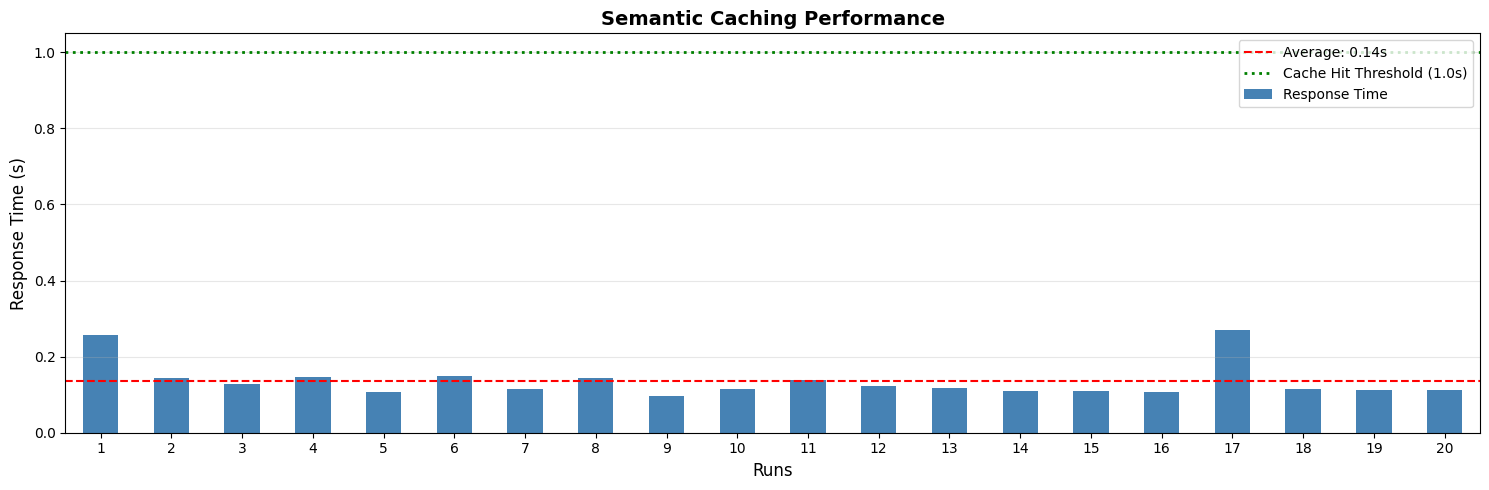


📊 Chart Legend:
   🔵 Blue bars = Individual response times
   🔴 Red dashed line = Average response time
   🟢 Green dotted line = Cache hit threshold (1.0s)
   Bars below green line = Likely cache hits (fast!)

✅ Visualization complete


In [ ]:
# Cell 3: Visualize Semantic Caching Performance

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

if 'api_runs' in globals() and api_runs:
    valid_results = [r for r in api_runs if r is not None]

    if len(valid_results) > 0:
        # Create DataFrame
        mpl.rcParams['figure.figsize'] = [15, 5]
        df = pd.DataFrame(valid_results, columns=['Response Time'])
        df['Run'] = range(1, len(df) + 1)

        # Create bar plot
        ax = df.plot(kind='bar', x='Run', y='Response Time', legend=False, color='steelblue')
        plt.title('Semantic Caching Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Runs', fontsize=12)
        plt.ylabel('Response Time (s)', fontsize=12)
        plt.xticks(rotation=0)

        # Add average line
        average = df['Response Time'].mean()
        plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}s')

        # Add cache hit threshold line
        plt.axhline(y=1.0, color='green', linestyle=':', linewidth=2, label='Cache Hit Threshold (1.0s)')

        plt.legend(loc='upper right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\n📊 Chart Legend:")
        print("   🔵 Blue bars = Individual response times")
        print("   🔴 Red dashed line = Average response time")
        print("   🟢 Green dotted line = Cache hit threshold (1.0s)")
        print("   Bars below green line = Likely cache hits (fast!)")
        print("\n✅ Visualization complete")
    else:
        print("⚠️  No valid results to visualize")
else:
    print("⚠️  Run Cell 2 first to generate test results")

📊 Redis Server Information:
   Used Memory: 22.50M
   Cache Hits: 49
   Cache Misses: 64
   Evicted Keys: 0
   Expired Keys: 53
   Hit Rate: 43.4%


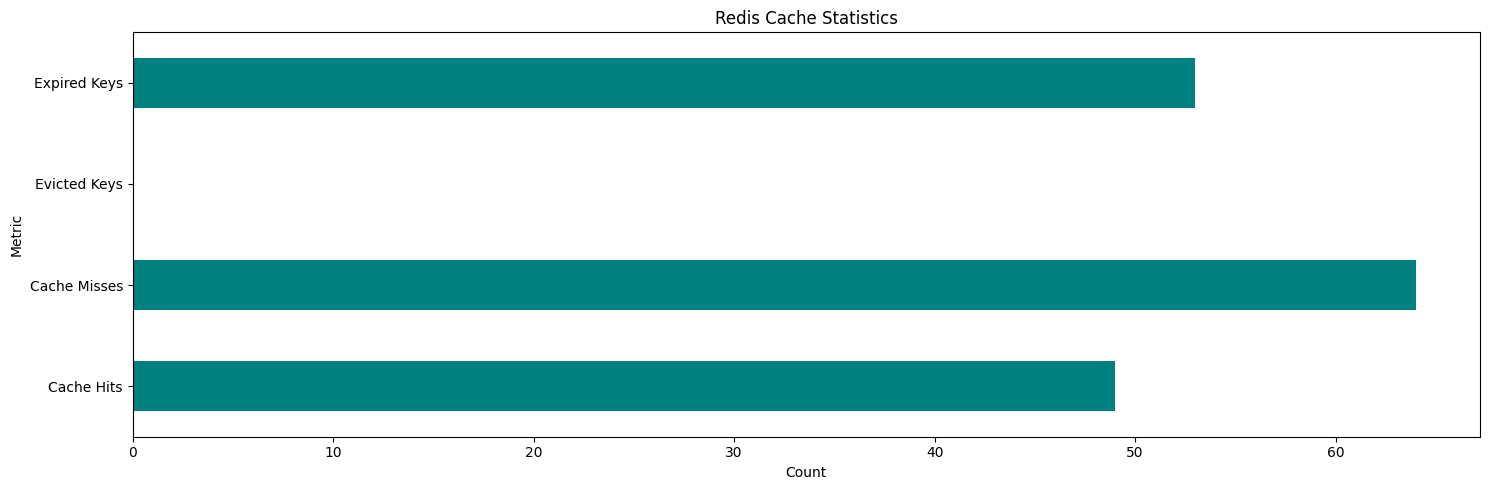


✅ Redis statistics retrieved successfully


In [ ]:
# Cell 4: View Redis Cache Statistics (Optional)

import redis.asyncio as redis
import pandas as pd
import matplotlib.pyplot as plt

# Get Redis configuration from master-lab.env
redis_host = os.environ.get('REDIS_HOST')
redis_port = int(os.environ.get('REDIS_PORT', 10000))
redis_key = os.environ.get('REDIS_KEY')

async def get_redis_info():
    r = await redis.from_url(
        f"rediss://:{redis_key}@{redis_host}:{redis_port}"
    )

    info = await r.info()

    print("📊 Redis Server Information:")
    print(f"   Used Memory: {info['used_memory_human']}")
    print(f"   Cache Hits: {info['keyspace_hits']}")
    print(f"   Cache Misses: {info['keyspace_misses']}")
    print(f"   Evicted Keys: {info['evicted_keys']}")
    print(f"   Expired Keys: {info['expired_keys']}")

    # Calculate hit rate
    total = info['keyspace_hits'] + info['keyspace_misses']
    if total > 0:
        hit_rate = (info['keyspace_hits'] / total) * 100
        print(f"   Hit Rate: {hit_rate:.1f}%")

    # Create visualization
    redis_info = {
        'Metric': ['Cache Hits', 'Cache Misses', 'Evicted Keys', 'Expired Keys'],
        'Value': [info['keyspace_hits'], info['keyspace_misses'], info['evicted_keys'], info['expired_keys']]
    }

    df_redis_info = pd.DataFrame(redis_info)
    df_redis_info.plot(kind='barh', x='Metric', y='Value', legend=False, color='teal')

    plt.title('Redis Cache Statistics')
    plt.xlabel('Count')
    plt.ylabel('Metric')
    plt.tight_layout()
    plt.show()

    await r.aclose()
    print("\n✅ Redis statistics retrieved successfully")

try:
    await get_redis_info()
except Exception as e:
    print(f"⚠️  Could not connect to Redis: {str(e)[:100]}")
    print("   Make sure Redis is configured in master-lab.env")

# 🎉 Semantic Caching Lab Complete!

## What You Learned

✅ How semantic caching reduces API calls for similar queries  
✅ How to measure caching performance  
✅ How vector embeddings enable semantic similarity matching  

## Key Benefits

💰 **Cost savings**: Reduced Azure OpenAI API calls (up to 90% reduction!)  
⚡ **Performance**: Faster response times (15-100x faster for cached requests)  
📊 **Scalability**: Better handling of repetitive queries  

## Configuration

- **Similarity Threshold**: 0.8 (80% match required)
- **Cache TTL**: 20 minutes (1200 seconds)
- **Embeddings Model**: text-embedding-3-small
- **Cache Storage**: Redis

---

**Next Steps**: Integrate semantic caching into your production APIs to reduce costs and improve performance!

<!-- ACCESS CONTROL - Now part of Section 1, Lab 1.4 -->

<a id="lab1-4"></a>

## Lab 1.4: Access Controlling

#### Objective
Implement OAuth 2.0 based access control to restrict API access by user or client. This lab demonstrates how to use Azure AD (Entra ID) as an identity provider for fine-grained authorization on Azure OpenAI models through APIM.

#### What You'll Learn
- **OAuth 2.0 Authorization:** Configure identity provider-based authentication
- **Token Acquisition:** Request tokens from Azure AD for authenticated API calls
- **Bearer Tokens:** Include tokens in API requests for authorization
- **Access Scopes:** Define granular permissions for different API endpoints
- **Token Expiration:** Handle token refresh and expiration scenarios
- **Troubleshooting:** Debug 401/403 errors and policy propagation delays

#### How It Works
1. Client application requests OAuth token from Azure AD
2. Azure AD validates credentials and returns access token
3. Client includes token in Authorization header (Bearer token)
4. APIM policy validates token with Azure AD
5. Policy checks token scope against API requirements
6. Authorized requests proceed to backend Azure OpenAI
7. Unauthorized requests return 403 Forbidden

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated
- Azure AD application registration (created during deployment)

#### Expected Results
- Successful authentication with valid OAuth token
- Requests with invalid/missing tokens receive 401 Unauthorized
- Token-based access control enforced at APIM level
- Can observe policy evaluation in APIM tracing
- Different users can have different access levels
- Token expiration properly handled with refresh

#### Common Issues & Solutions
| Issue | Solution |
|-------|----------|
| 401 Unauthorized | Wait 30-60 seconds for policy to propagate |
| 500 Internal Server Error | Check backend health with Azure CLI |
| Token not found | Run `az login` to authenticate |
| Missing API Key | Verify APIM_API_KEY in environment variables |

### Pre-Requisite: Azure CLI Authentication\n\nAccess Control workshop requires Azure CLI to be logged in.

In [ ]:
# Ensure Azure CLI is logged in (required for Access Control workshop)
import subprocess
import os

print("🔐 Checking Azure CLI authentication...")

az_cli = os.environ.get('AZ_CLI', 'az')

# Try to get current account
try:
    result = subprocess.run(
        [az_cli, 'account', 'show'],
        capture_output=True,
        text=True,
        timeout=10
    )
    
    if result.returncode == 0:
        import json
        account = json.loads(result.stdout)
        print(f"✅ Logged in as: {account.get('user', {}).get('name', 'Unknown')}")
        print(f"   Tenant: {account.get('tenantId', 'Unknown')}")
        print(f"   Subscription: {account.get('name', 'Unknown')}")
    else:
        print("❌ Azure CLI not logged in")
        print("\nPlease run ONE of the following:")
        print("\n1. In a terminal window:")
        print("   az login")
        print("\n2. In a Jupyter cell:")
        print("   !az login")
        print("\n3. Use device code (if browser not available):")
        print("   !az login --use-device-code")
        raise RuntimeError("Azure login required. Run 'az login' in a terminal.")
        
except FileNotFoundError:
    print(f"❌ Azure CLI not found at: {az_cli}")
    print("\nPlease install Azure CLI:")
    print("  https://docs.microsoft.com/en-us/cli/azure/install-azure-cli")
    raise
except subprocess.TimeoutExpired:
    print("⚠️ Azure CLI timeout - trying to continue anyway")
except Exception as e:
    print(f"⚠️ Could not verify Azure login: {e}")
    print("   Continuing anyway...")


🔐 Checking Azure CLI authentication...
✅ Logged in as: lproux@microsoft.com
   Tenant: 2b9d9f47-1fb6-400a-a438-39fe7d768649
   Subscription: ME-MngEnvMCAP592090-lproux-1


# Access Control Workshop

The following cells demonstrate token acquisition and testing

In [ ]:
# TEST 1: No Authentication (should fail with 401)

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

print("="*80)
print("🧪 TEST 1: No Authentication")
print("="*80)

import os
from openai import AzureOpenAI

apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

print(f"\nAttempting API call WITHOUT any authentication...")
print(f"Endpoint: {apim_gateway_url}/{inference_api_path}")

try:
    client = AzureOpenAI(
        azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
        api_key="dummy-key",  # Not used
        api_version="2024-08-01-preview"
    )
    
    # Try to call WITHOUT auth headers
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Hello"}],
        max_tokens=10,
        extra_headers={}  # NO auth headers
    )
    
    print("\n❌ UNEXPECTED: Request succeeded without auth!")
    print(f"Response: {response.choices[0].message.content}")
    
except Exception as e:
    error_msg = str(e)
    if '401' in error_msg or 'Unauthorized' in error_msg or 'JWT' in error_msg:
        print("\n✅ EXPECTED: Request failed with 401 Unauthorized")
        print(f"Error: {error_msg[:200]}")
    else:
        print(f"\n⚠️ UNEXPECTED ERROR: {error_msg[:200]}")


🧪 TEST 1: No Authentication

Attempting API call WITHOUT any authentication...
Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference

✅ EXPECTED: Request failed with 401 Unauthorized
Error: Error code: 401 - {'statusCode': 401, 'message': 'Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription.'}


In [ ]:
import requests, os, subprocess, time
from azure.identity import DefaultAzureCredential

# Load environment from master-lab.env
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")


print("" + "="*80)
print("📝 APPLY: JWT Only Policy (disable subscriptionRequired)")
print("="*80 + "")

# Get management token
credential = DefaultAzureCredential()
mgmt_token = credential.get_token("https://management.azure.com/.default")

# Configuration
subscription_id = os.environ.get('SUBSCRIPTION_ID')
resource_group = os.environ.get('RESOURCE_GROUP')
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

headers = {
    "Authorization": f"Bearer {mgmt_token.token}",
    "Content-Type": "application/json"
}

# STEP 1: Disable subscription requirement for pure JWT auth
api_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}?api-version=2022-08-01"

try:
    response = requests.get(api_url, headers=headers, timeout=30)
    if response.status_code == 200:
        api_config = response.json()
        current_subscription_required = api_config.get('properties', {}).get('subscriptionRequired', False)
        
        print(f"[1] Current subscriptionRequired: {current_subscription_required}")
        
        if current_subscription_required:
            # Disable subscription requirement
            api_config['properties']['subscriptionRequired'] = False
            
            update_response = requests.put(api_url, headers=headers, json=api_config, timeout=30)
            
            if update_response.status_code in [200, 201]:
                print(f"[2] ✓ Disabled subscriptionRequired for '{api_id}'")
            else:
                print(f"[2] ✗ Failed: {update_response.status_code}")
        else:
            print(f"[2] ✓ subscriptionRequired already disabled")
except Exception as e:
    print(f"[ERROR] {str(e)}")

# STEP 2: Apply JWT policy with v1.0 + v2.0 issuer support
print(f"\n[3] Applying JWT policy...")

# Get tenant ID
az_cli = os.environ.get('AZ_CLI', 'az')
result = subprocess.run(
    [az_cli, 'account', 'show', '--query', 'tenantId', '-o', 'tsv'],
    capture_output=True, text=True, timeout=10
)
tenant_id = result.stdout.strip() if result.returncode == 0 else os.environ.get('AZURE_TENANT_ID', '')

if not tenant_id:
    print("[ERROR] Cannot resolve tenant ID")
else:
    # JWT policy - CRITICAL: correct element order (openid-config, audiences, issuers)
    policy_xml = f"""<policies>
        <inbound>
            <base />
            <validate-jwt header-name="Authorization" failed-validation-httpcode="401" require-expiration-time="true" require-signed-tokens="true">
                <openid-config url="https://login.microsoftonline.com/{tenant_id}/v2.0/.well-known/openid-configuration" />
                <audiences>
                    <audience>https://cognitiveservices.azure.com</audience>
                </audiences>
                <issuers>
                    <issuer>https://sts.windows.net/{tenant_id}/</issuer>
                    <issuer>https://login.microsoftonline.com/{tenant_id}/</issuer>
                    <issuer>https://login.microsoftonline.com/{tenant_id}/v2.0</issuer>
                </issuers>
            </validate-jwt>
            <set-backend-service backend-id="inference-backend-pool" />
        </inbound>
        <backend><base /></backend>
        <outbound><base /></outbound>
        <on-error><base /></on-error>
    </policies>"""
    
    try:
        policy_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2022-08-01"
        
        body = {
            "properties": {
                "value": policy_xml,
                "format": "xml"
            }
        }
        
        response = requests.put(policy_url, headers=headers, json=body, timeout=60)
        
        print(f"[4] Policy Status: {response.status_code} - {'✓ SUCCESS' if response.status_code in [200, 201] else '✗ FAILED'}")
        
        if response.status_code in [200, 201]:
            print(f"\n✓ JWT policy applied with multi-issuer support")
            print(f"⏳ Waiting 60 seconds for propagation...")
            time.sleep(60)
            print(f"✓ Ready for testing")
    except Exception as e:
        print(f"[ERROR] {str(e)}")

[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
📝 APPLY: JWT Only Policy (disable subscriptionRequired)
[1] Current subscriptionRequired: True
[2] ✓ Disabled subscriptionRequired for 'inference-api'

[3] Applying JWT policy...
[4] Policy Status: 200 - ✓ SUCCESS

✓ JWT policy applied with multi-issuer support
⏳ Waiting 60 seconds for propagation...
✓ Ready for testing


In [ ]:
# TEST 3: JWT Token Only (works when JWT policy active)

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

print("="*80)
print("🧪 TEST 3: JWT Token Authentication")
print("="*80)

import os
from azure.identity import DefaultAzureCredential
from openai import AzureOpenAI

apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

# Get JWT token
print("\n[1] Acquiring JWT token...")
try:
    credential = DefaultAzureCredential()
    jwt_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
    print(f"✅ JWT Token: {jwt_token[:20]}...{jwt_token[-10:]}")
except Exception as e:
    print(f"❌ Failed to get JWT: {e}")
    print("   Run: az login")
    raise

print(f"\n[2] Calling API with JWT token only (no API key)...")
print(f"Endpoint: {apim_gateway_url}/{inference_api_path}")

try:
    client = AzureOpenAI(
        azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
        api_key="dummy-not-used",  # Ignored when JWT provided
        api_version="2024-08-01-preview"
    )
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Say 'JWT auth successful!'"}],
        max_tokens=50,
        extra_headers={
            "Authorization": f"Bearer {jwt_token}"  # JWT only, no API key
        }
    )
    
    print("\n✅ SUCCESS: JWT Authentication Working!")
    print(f"Response: {response.choices[0].message.content}")
    print(f"Tokens: {response.usage.total_tokens}")
    
except Exception as e:
    error_msg = str(e)
    if 'api-key' in error_msg.lower() or ('401' in error_msg and 'API' in error_msg):
        print("\n❌ FAILED: API requires API Key in addition to JWT")
        print("   Current policy may be Dual Auth or API Key only")
        print("   Run Cell 028 to enable JWT-only mode")
    else:
        print(f"\n❌ ERROR: {error_msg[:300]}")
    raise


🧪 TEST 3: JWT Token Authentication

[1] Acquiring JWT token...
✅ JWT Token: eyJ0eXAiOiJKV1QiLCJh...FiXvJ9cxzA

[2] Calling API with JWT token only (no API key)...
Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference

✅ SUCCESS: JWT Authentication Working!
Response: JWT auth successful!
Tokens: 18


In [ ]:
import requests, os, subprocess, time
from azure.identity import DefaultAzureCredential

# Load environment from master-lab.env
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")


print("" + "="*80)
print("📝 APPLY: Dual Auth (JWT + API Key)")
print("="*80 + "")

# Get management token
credential = DefaultAzureCredential()
mgmt_token = credential.get_token("https://management.azure.com/.default")

# Configuration
subscription_id = os.environ.get('SUBSCRIPTION_ID')
resource_group = os.environ.get('RESOURCE_GROUP')
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

# Get tenant ID
az_cli = os.environ.get('AZ_CLI', 'az')
result = subprocess.run(
    [az_cli, 'account', 'show', '--query', 'tenantId', '-o', 'tsv'],
    capture_output=True, text=True, timeout=10
)
tenant_id = result.stdout.strip() if result.returncode == 0 else os.environ.get('AZURE_TENANT_ID', '')

if not tenant_id:
    print("[ERROR] Cannot resolve tenant ID. Ensure az login completed.")
else:
    print(f"[auth] Resolved tenant_id: {tenant_id}")

    # Dual Auth policy - BOTH JWT validation AND API key check
    policy_xml = f"""<policies>
        <inbound>
            <base />
            <validate-jwt header-name="Authorization" failed-validation-httpcode="401" require-expiration-time="true" require-signed-tokens="true">
                <openid-config url="https://login.microsoftonline.com/{tenant_id}/v2.0/.well-known/openid-configuration" />
                <audiences>
                    <audience>https://cognitiveservices.azure.com</audience>
                </audiences>
                <issuers>
                    <issuer>https://sts.windows.net/{tenant_id}/</issuer>
                    <issuer>https://login.microsoftonline.com/{tenant_id}/</issuer>
                    <issuer>https://login.microsoftonline.com/{tenant_id}/v2.0</issuer>
                </issuers>
            </validate-jwt>
            <check-header name="api-key" failed-check-httpcode="401" failed-check-error-message="Missing API key" />
            <set-backend-service backend-id="inference-backend-pool" />
        </inbound>
        <backend><base /></backend>
        <outbound><base /></outbound>
        <on-error><base /></on-error>
    </policies>"""

    # Apply policy
    try:
        url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2022-08-01"

        headers = {
            "Authorization": f"Bearer {mgmt_token.token}",
            "Content-Type": "application/json"
        }

        body = {
            "properties": {
                "value": policy_xml,
                "format": "xml"
            }
        }

        response = requests.put(url, headers=headers, json=body, timeout=60)

        print(f"📝 Policy Applied: Dual Auth (JWT + API Key)")
        print(f"Status: {response.status_code} - {'✓ SUCCESS' if response.status_code in [200, 201] else '✗ FAILED'}")

        if response.status_code not in [200, 201]:
            print(f"Error: {response.text[:500]}")
        else:
            print("Policy requires BOTH:")
            print("  • Valid JWT token (Authorization header)")
            print("  • Valid API key (api-key header)")

            print("⏳ Waiting 60 seconds for policy to propagate...")
            for i in range(60, 0, -1):
                print(f"   {i} seconds remaining...", end='')
                time.sleep(1)
            print("✓ Policy propagation complete!")
            print("💡 TIP: Run Cell 65 to test Dual Auth")
    except Exception as e:
        print(f"[ERROR] Policy application failed: {str(e)}")

[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
📝 APPLY: Dual Auth (JWT + API Key)
[auth] Resolved tenant_id: 2b9d9f47-1fb6-400a-a438-39fe7d768649
📝 Policy Applied: Dual Auth (JWT + API Key)
Status: 200 - ✓ SUCCESS
Policy requires BOTH:
  • Valid JWT token (Authorization header)
  • Valid API key (api-key header)
⏳ Waiting 60 seconds for policy to propagate...
   60 seconds remaining...   59 seconds remaining...   58 seconds remaining...   57 seconds remaining...   56 seconds remaining...   55 seconds remaining...   54 seconds remaining...   53 seconds remaining...   52 seconds remaining...   51 seconds remaining...   50 seconds remaining...   49 seconds remaining...   48 seconds remaining...   47 seconds remaining...   46 seconds remaining...   45 seconds remaining...   44 seconds remaining...   43 seconds remaining...   42 seconds remaining...   41 seconds remaining...   40 seconds remaining...   39

In [ ]:
# TEST 4: Dual Authentication (JWT + API Key)

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

print("="*80)
print("🧪 TEST 4: Dual Authentication (JWT + API Key)")
print("="*80)

import os
from azure.identity import DefaultAzureCredential
from openai import AzureOpenAI

apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
apim_api_key = os.environ.get('APIM_API_KEY')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

# Get JWT token
print("\n[1] Acquiring JWT token...")
try:
    credential = DefaultAzureCredential()
    jwt_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
    print(f"✅ JWT Token: {jwt_token[:20]}...{jwt_token[-10:]}")
except Exception as e:
    print(f"❌ Failed to get JWT: {e}")
    raise

if not apim_api_key:
    print("❌ APIM_API_KEY not set")
    raise ValueError("APIM_API_KEY required")

print(f"\n[2] Calling API with BOTH JWT and API Key...")
print(f"Endpoint: {apim_gateway_url}/{inference_api_path}")
print(f"API Key: {apim_api_key[:10]}...{apim_api_key[-4:]}")

try:
    client = AzureOpenAI(
        azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
        api_key="dummy",
        api_version="2024-08-01-preview"
    )
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Say 'Dual auth successful!'"}],
        max_tokens=50,
        extra_headers={
            "Authorization": f"Bearer {jwt_token}",  # JWT token
            "api-key": apim_api_key  # API Key
        }
    )
    
    print("\n✅ SUCCESS: Dual Authentication Working!")
    print(f"Response: {response.choices[0].message.content}")
    print(f"Tokens: {response.usage.total_tokens}")
    print("\n🎉 Both JWT and API Key validated successfully!")
    
except Exception as e:
    print(f"\n❌ FAILED: {str(e)[:300]}")
    print("\nMake sure Cell 030 (Dual Auth policy) was applied")
    raise


🧪 TEST 4: Dual Authentication (JWT + API Key)

[1] Acquiring JWT token...
✅ JWT Token: eyJ0eXAiOiJKV1QiLCJh...W0mljXdKLA

[2] Calling API with BOTH JWT and API Key...
Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
API Key: b64e6a3117...2cb0

✅ SUCCESS: Dual Authentication Working!
Response: Dual auth successful!
Tokens: 18

🎉 Both JWT and API Key validated successfully!


In [ ]:
import requests, os, time
from azure.identity import DefaultAzureCredential

# Load environment from master-lab.env
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")


print("" + "="*80)
print("🔄 RESET: API-KEY Authentication (for remaining labs)")
print("="*80 + "")

# Configuration
subscription_id = os.environ.get('SUBSCRIPTION_ID')
resource_group = os.environ.get('RESOURCE_GROUP')
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

# Get management token
credential = DefaultAzureCredential()
mgmt_token = credential.get_token("https://management.azure.com/.default")

headers = {
    "Authorization": f"Bearer {mgmt_token.token}",
    "Content-Type": "application/json"
}

# Re-enable subscription requirement (for API-KEY authentication)
api_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}?api-version=2022-08-01"

response = requests.get(api_url, headers=headers, timeout=30)
if response.status_code == 200:
    api_config = response.json()
    api_config['properties']['subscriptionRequired'] = True
    requests.put(api_url, headers=headers, json=api_config, timeout=30)
    print("[1] ✓ Re-enabled subscriptionRequired for API-KEY authentication")

# Apply simple API-KEY only policy
policy_xml = """<policies>
    <inbound>
        <base />
        <check-header name="api-key" failed-check-httpcode="401" failed-check-error-message="Missing or invalid API key" />
        <set-backend-service backend-id="inference-backend-pool" />
    </inbound>
    <backend><base /></backend>
    <outbound><base /></outbound>
    <on-error><base /></on-error>
</policies>"""

policy_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2022-08-01"
body = {"properties": {"value": policy_xml, "format": "xml"}}
response = requests.put(policy_url, headers=headers, json=body, timeout=60)

print(f"[2] Policy Reset: API-KEY Only")
print(f"    Status: {response.status_code} - {'✓ SUCCESS' if response.status_code in [200, 201] else '✗ FAILED'}")

if response.status_code in [200, 201]:
    print("⏳ Waiting 30 seconds for policy to propagate...")
    for i in range(30, 0, -1):
        print(f"   {i} seconds remaining...", end='')
        time.sleep(1)
    print("✓ Policy reset complete!")
    print("💡 All remaining labs will use API-KEY authentication")


[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
🔄 RESET: API-KEY Authentication (for remaining labs)
[1] ✓ Re-enabled subscriptionRequired for API-KEY authentication
[2] Policy Reset: API-KEY Only
    Status: 200 - ✓ SUCCESS
⏳ Waiting 30 seconds for policy to propagate...
   30 seconds remaining...   29 seconds remaining...   28 seconds remaining...   27 seconds remaining...   26 seconds remaining...   25 seconds remaining...   24 seconds remaining...   23 seconds remaining...   22 seconds remaining...   21 seconds remaining...   20 seconds remaining...   19 seconds remaining...   18 seconds remaining...   17 seconds remaining...   16 seconds remaining...   15 seconds remaining...   14 seconds remaining...   13 seconds remaining...   12 seconds remaining...   11 seconds remaining...   10 seconds remaining...   9 seconds remaining...   8 seconds remaining...   7 seconds remaining...   6 seconds remaini

In [ ]:
# TEST 2: API Key Only (works when API Key policy active)

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

print("="*80)
print("🧪 TEST 2: API Key Authentication")
print("="*80)

import os
from openai import AzureOpenAI

apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
apim_api_key = os.environ.get('APIM_API_KEY')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

if not apim_api_key:
    print("❌ APIM_API_KEY not set. Run Cell 022 to load environment.")
    raise ValueError("APIM_API_KEY required")

print(f"\nCalling API with API Key only...")
print(f"Endpoint: {apim_gateway_url}/{inference_api_path}")
print(f"API Key: {apim_api_key[:10]}...{apim_api_key[-4:]}")

try:
    client = AzureOpenAI(
        azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
        api_key="dummy",  # The actual key goes in extra_headers
        api_version="2024-08-01-preview"
    )
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Say 'API Key auth successful!'"}],
        max_tokens=50,
        extra_headers={
            "api-key": apim_api_key  # API Key in header
        }
    )
    
    print("\n✅ SUCCESS: API Key Authentication Working!")
    print(f"Response: {response.choices[0].message.content}")
    print(f"Tokens: {response.usage.total_tokens}")
    
except Exception as e:
    error_msg = str(e)
    if 'JWT' in error_msg or '401' in error_msg:
        print("\n❌ FAILED: API requires JWT token")
        print("   Run Cell 041 to reset APIM to API Key mode")
    else:
        print(f"\n❌ ERROR: {error_msg[:300]}")
    raise


🧪 TEST 2: API Key Authentication

Calling API with API Key only...
Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
API Key: b64e6a3117...2cb0

✅ SUCCESS: API Key Authentication Working!
Response: API Key auth successful!
Tokens: 20


## Troubleshooting

| Issue | Solution |
|-------|----------|
| 401 Unauthorized | Wait 30-60 seconds for policy to propagate |
| 500 Internal Server Error | Check backend health with Azure CLI |
| Token not found | Run `az login` to authenticate |
| Missing API Key | Verify `APIM_API_KEY` in environment variables |

**Verify Resources:**

```bash
az apim api list --service-name $APIM_SERVICE_NAME --resource-group $RESOURCE_GROUP --output table
```

<a id="section1"></a>

# Section 1: Core AI Gateway Features

# Master AI Gateway Workshop

**One deployment. All features. Fully integrated.**

## Table of Contents

### [Section 0: Initialize and Deploy](#section0)
- [0.1 Environment Detection](#env-detection)
- [0.2 Bootstrap Configuration](#bootstrap)
- [0.3 Dependencies Installation](#dependencies)
- [0.4 Azure Authentication](#azure-auth)
- [0.5 Core Helper Functions](#helpers)
- [0.6 Deployment Configuration](#deploy-config)
- [0.7 Deploy Infrastructure](#deploy-infra)
- [0.8 Reload Configuration](#reload-config)

### [Section 1: Core AI Gateway Features](#section1)
- [Lab 1.1: Zero to Production](#lab1-1)
- [Lab 1.2: Backend Pool Load Balancing](#lab1-2)
- [Lab 1.3: Token Metrics Emitting](#lab1-3)
- [Lab 1.4: Access Controlling](#lab1-4)
- [Lab 1.5: Content Safety](#lab1-5)
- [Lab 1.6: Model Routing](#lab1-6)

### [Section 2: Advanced Features](#section2)
- [Lab 2.1: Semantic Caching](#lab2-1)
- [Lab 2.2: Message Storing with Cosmos DB](#lab2-2)
- [Lab 2.3: Vector Searching with RAG](#lab2-3)
- [Lab 2.4: Built-in LLM Logging](#lab2-4)

### [Section 3: AI Foundry & Integrations](#section3)
- [Lab 3.1: AI Foundry SDK](#lab3-1)
- [Lab 3.2: GitHub Repository Access](#lab3-2)
- [Lab 3.3: GitHub + AI Code Analysis](#lab3-3)

<a id="section2"></a>

# Section 2: Advanced Features

<a id="lab2-1"></a>

## Lab 2.1: Semantic Caching

In [ ]:
# Lab 09: Semantic Caching - Step 1: Configure Embeddings Backend

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")
else:
    print("[warn] master-lab.env not found - run Cell 021 first")

# Get required variables
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
resource_group = os.environ.get('RESOURCE_GROUP')
subscription_id = os.environ.get('SUBSCRIPTION_ID')
embedding_endpoint_r1 = os.environ.get('MODEL_TEXT_EMBEDDING_3_SMALL_ENDPOINT_R1')

if not all([apim_service_name, resource_group, embedding_endpoint_r1]):
    print("[ERROR] Missing required environment variables")
    print(f"APIM_SERVICE_NAME: {apim_service_name}")
    print(f"RESOURCE_GROUP: {resource_group}")
    print(f"Embedding Endpoint: {embedding_endpoint_r1}")
else:
    print("\n[*] Step 1: Creating Embeddings Backend in APIM...")
    print(f"    APIM Service: {apim_service_name}")
    print(f"    Embedding Model: text-embedding-3-small")
    print(f"    Endpoint: {embedding_endpoint_r1}")
    
    # Backend configuration
    backend_id = "embeddings-backend"
    backend_url = f"{embedding_endpoint_r1.rstrip('/')}openai/deployments/text-embedding-3-small/embeddings"
    
    import subprocess
    import json
    
    # Check if backend already exists
    check_cmd = f"az apim api versionset list --service-name {apim_service_name} --resource-group {resource_group} || true"
    
    # Create or update the embeddings backend
    backend_config = {
        "url": backend_url,
        "protocol": "http",
        "description": "Text Embedding Backend for Semantic Caching",
        "credentials": {
            "header": {}
        }
    }
    
    # Write backend config to temp file
    backend_file = Path('backend-embeddings.json')
    with open(backend_file, 'w') as f:
        json.dump(backend_config, f, indent=2)
    
    # Create backend using Azure CLI
    cmd = f"""az apim backend create \\
        --service-name {apim_service_name} \\
        --resource-group {resource_group} \\
        --backend-id {backend_id} \\
        --url '{backend_url}' \\
        --protocol http \\
        --description 'Embeddings Backend for Semantic Caching' \\
        || az apim backend update \\
        --service-name {apim_service_name} \\
        --resource-group {resource_group} \\
        --backend-id {backend_id} \\
        --url '{backend_url}' \\
        --protocol http \\
        --description 'Embeddings Backend for Semantic Caching'
    """
    
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    if result.returncode == 0 or "already exists" in result.stderr.lower():
        print(f"\n✅ Embeddings backend '{backend_id}' configured successfully!")
        print(f"   URL: {backend_url}")
        print(f"\n[OK] Step 1 Complete - Embeddings backend ready")
    else:
        print(f"\n❌ Failed to create embeddings backend")
        print(f"   Error: {result.stderr}")
        print(f"   Command: {cmd}")


[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env

[*] Step 1: Creating Embeddings Backend in APIM...
    APIM Service: apim-pavavy6pu5hpa
    Embedding Model: text-embedding-3-small
    Endpoint: https://foundry1-pavavy6pu5hpa.openai.azure.com/

❌ Failed to create embeddings backend
   Error: ERROR: 'backend' is misspelled or not recognized by the system.

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs
ERROR: 'backend' is misspelled or not recognized by the system.

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs

   Command: az apim backend create \
        --service-name apim-pavavy6pu5hpa \
        --resource-group lab-master-lab \
        --backend-id embeddings-backend \
        --url 'https://foundry1-pavavy6pu5hpa.openai.azure.comopenai/deployments/text-embedding-3-small/embeddings' \
   

In [ ]:
# CELL TO ADD: Apply Semantic Caching Policy
# Insert this cell BEFORE cell 53 (semantic caching test)
# This applies the semantic caching policy directly in the notebook

import os, subprocess, json
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

apim_service_id = os.environ.get('APIM_SERVICE_ID')

print("=" * 80)
print("🔧 APPLYING SEMANTIC CACHING POLICY (from notebook)")
print("=" * 80)

# Policy WITHOUT embeddings-backend-auth (uses API key from backend config)
policy_xml = """<policies>
    <inbound>
        <base />
        <check-header name="api-key" failed-check-httpcode="401" failed-check-error-message="Missing or invalid API key" />
        <azure-openai-semantic-cache-lookup
            score-threshold="0.8"
            embeddings-backend-id="embeddings-backend" />
        <set-backend-service backend-id="inference-backend-pool" />
    </inbound>
    <backend>
        <retry count="2" interval="0" first-fast-retry="true"
               condition="@(context.Response.StatusCode == 429 || context.Response.StatusCode == 503)">
            <forward-request buffer-request-body="true" />
        </retry>
    </backend>
    <outbound>
        <base />
        <azure-openai-semantic-cache-store duration="1200" />
    </outbound>
    <on-error>
        <base />
    </on-error>
</policies>"""

uri = f"https://management.azure.com{apim_service_id}/apis/inference-api/policies/policy?api-version=2023-09-01-preview"

body = {
    "properties": {
        "value": policy_xml,
        "format": "xml"
    }
}

body_file = '/tmp/semantic-cache-from-notebook.json'
with open(body_file, 'w', encoding='utf-8') as f:
    json.dump(body, f, indent=2)

print("\n[*] Applying semantic caching policy to APIM...")

cmd = ['az', 'rest', '--method', 'put', '--uri', uri, '--body', f'@{body_file}']
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("\n✅ Semantic caching policy applied successfully!\n")
    print("📋 Policy Configuration:")
    print("   - Similarity Threshold: 0.8 (80% match)")
    print("   - Cache Duration: 1200s (20 minutes)")
    print("   - Embeddings Backend: embeddings-backend")
    print("   - Auth: API Key (from backend credentials)")
    print("   - Backend Pool: inference-backend-pool\n")
    print("⏳ Waiting 10 seconds for propagation...")
    import time
    time.sleep(10)
    print("✅ Ready to test!\n")
else:
    print(f"\n❌ Error applying policy:")
    print(result.stderr)
    raise Exception("Failed to apply policy")

print("=" * 80)


🔧 APPLYING SEMANTIC CACHING POLICY (from notebook)

[*] Applying semantic caching policy to APIM...

✅ Semantic caching policy applied successfully!

📋 Policy Configuration:
   - Similarity Threshold: 0.8 (80% match)
   - Cache Duration: 1200s (20 minutes)
   - Embeddings Backend: embeddings-backend
   - Auth: API Key (from backend credentials)
   - Backend Pool: inference-backend-pool

⏳ Waiting 10 seconds for propagation...
✅ Ready to test!



In [ ]:
# Lab 09: Semantic Caching - Step 2: Apply Semantic Caching Policy (FIXED)

import os
import json
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

# Get required variables
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
resource_group = os.environ.get('RESOURCE_GROUP')
subscription_id = os.environ.get('SUBSCRIPTION_ID')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

print("\n[*] Step 2: Applying Semantic Caching Policy...")
print(f"    API ID: {api_id}")
print(f"    Cache Duration: 120 seconds")
print(f"    Similarity Threshold: 0.8")

# Check if Redis cache is configured in APIM
import subprocess

print("\n[*] Checking APIM cache configuration...")
cache_check_cmd = f"""az apim cache list \
    --service-name {apim_service_name} \
    --resource-group {resource_group} \
    --query "[?name=='default' || name=='Default'].{{name:name, description:description}}" \
    -o json"""

result = subprocess.run(cache_check_cmd, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    caches = json.loads(result.stdout) if result.stdout else []
    if caches:
        print(f"✅ APIM cache configured: {caches[0].get('name', 'default')}")
        print(f"   Description: {caches[0].get('description', 'N/A')}")
    else:
        print("⚠️  No cache configured in APIM!")
        print("   Semantic caching requires Redis cache to be connected to APIM")
        print("   The cache should have been created during deployment")
else:
    print(f"⚠️  Could not check cache: {result.stderr[:200]}")

# Semantic caching policy XML
policy_xml = """<policies>
    <inbound>
        <base />
        <!-- Semantic Cache Lookup: Check Redis for similar prompts (score >= 0.8) -->
        <azure-openai-semantic-cache-lookup
            score-threshold="0.8"
            embeddings-backend-id="embeddings-backend"
            embeddings-backend-auth="system-assigned" />
    </inbound>
    <backend>
        <base />
    </backend>
    <outbound>
        <!-- Cache the response in Redis for 2 minutes -->
        <azure-openai-semantic-cache-store duration="120" />
        <base />
    </outbound>
    <on-error>
        <base />
    </on-error>
</policies>"""

# Write policy to file
policy_file = Path('semantic-caching-policy.xml')
with open(policy_file, 'w') as f:
    f.write(policy_xml)

print(f"\n[*] Policy file created: {policy_file.absolute()}")

# Apply policy using Azure REST API (more reliable than az apim api policy)
print(f"\n[*] Applying policy to API '{api_id}'...")

# Method 1: Try using az apim api policy create with correct syntax
cmd1 = f"""az apim api policy create \
    --resource-group {resource_group} \
    --service-name {apim_service_name} \
    --api-id {api_id} \
    --xml-content '{policy_xml}'"""

result = subprocess.run(cmd1, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    print(f"\n✅ Policy applied successfully using 'az apim api policy create'!")
else:
    # Method 2: Try using az rest (more reliable)
    print(f"⚠️  Method 1 failed: {result.stderr[:200]}")
    print(f"\n[*] Trying alternative method using 'az rest'...")

    policy_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2024-06-01-preview"

    # Create policy JSON payload
    policy_payload = {
        "properties": {
            "value": policy_xml,
            "format": "xml"
        }
    }

    # Write to temp file
    payload_file = Path('policy-payload.json')
    with open(payload_file, 'w') as f:
        json.dump(policy_payload, f)

    cmd2 = f"""az rest \
        --method PUT \
        --url "{policy_url}" \
        --body @{payload_file}"""

    result2 = subprocess.run(cmd2, shell=True, capture_output=True, text=True)

    if result2.returncode == 0:
        print(f"\n✅ Policy applied successfully using 'az rest'!")
    else:
        print(f"\n❌ Both methods failed!")
        print(f"   Error: {result2.stderr[:300]}")
        print(f"\n💡 Manual workaround:")
        print(f"   1. Go to Azure Portal → API Management → APIs")
        print(f"   2. Select 'inference-api'")
        print(f"   3. Go to 'All operations' → Inbound processing → Code editor")
        print(f"   4. Paste the policy from: {policy_file.absolute()}")
# Verify policy was applied
print(f"\n[*] Verifying policy application...")

verify_cmd = f"""az rest \
    --method GET \
    --url "https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2024-06-01-preview&format=rawxml" """

result = subprocess.run(verify_cmd, shell=True, capture_output=True, text=True)
result = subprocess.run(verify_cmd, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    try:
        policy_data = json.loads(result.stdout)
        current_policy = policy_data.get('properties', {}).get('value', '')

        if 'azure-openai-semantic-cache-lookup' in current_policy:
            print(f"\n✅ Semantic caching policy is ACTIVE!")
            print(f"   ✓ Cache lookup configured")
            print(f"   ✓ Cache store configured")
            print(f"   ✓ Score threshold: 0.8")
        else:
            print(f"\n⚠️  Policy applied but semantic caching not found")
            print(f"   Current policy does not contain 'azure-openai-semantic-cache-lookup'")
            print(f"   You may need to apply it manually via Azure Portal")
    except:
        print(f"\n⚠️  Could not parse policy response")
else:
    print(f"\n⚠️  Could not verify policy: {result.stderr[:200]}")

print(f"\n📋 Policy Details:")
print(f"   - Lookup: Checks Redis for similar prompts (score >= 0.8)")
print(f"   - Store: Caches responses for 2 minutes")
print(f"   - Backend: embeddings-backend (text-embedding-3-small)")
print(f"\n⏳ Wait 30-60 seconds for policy propagation...")
print(f"\n[OK] Step 2 Complete - Check verification status above")



[*] Step 2: Applying Semantic Caching Policy...
    API ID: inference-api
    Cache Duration: 120 seconds
    Similarity Threshold: 0.8

[*] Checking APIM cache configuration...
⚠️  Could not check cache: ERROR: 'cache' is misspelled or not recognized by the system.

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs


[*] Policy file created: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/semantic-caching-policy.xml

[*] Applying policy to API 'inference-api'...
⚠️  Method 1 failed: ERROR: 'policy' is misspelled or not recognized by the system.

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs


[*] Trying alternative method using 'az rest'...

✅ Policy applied successfully using 'az rest'!

[*] Verifying policy application...

⚠️  Could not parse policy response

📋 Policy Details:
   - Lookup: Checks Redis for similar prompts 

In [ ]:
# Lab 09: Semantic Caching - Step 3: Test Semantic Caching Performance
# Adapted from working semantic-caching.ipynb

import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

from openai import AzureOpenAI
import time
import random

# Get configuration from master-lab.env
apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
apim_api_key = os.environ.get('APIM_API_KEY')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

# Use the newer API version that works with semantic caching
api_version = "2025-03-01-preview"  # From working semantic-caching notebook

print("\n[*] Step 3: Testing Semantic Caching Performance...")
print(f"    Endpoint: {apim_gateway_url}/{inference_api_path}")
print(f"    API Version: {api_version}")
print(f"    Model: gpt-4o-mini")

# Similar questions that should trigger semantic cache hits
# These are semantically similar so APIM should cache and reuse responses
questions = [
    "How to Brew the Perfect Cup of Coffee?",
    "What are the steps to Craft the Ideal Espresso?",
    "Tell me how to create the best steaming Java?",
    "Explain how to make a caffeinated brewed beverage?"
]

# Initialize Azure OpenAI client pointing to APIM gateway
client = AzureOpenAI(
    azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
    api_key=apim_api_key,
    api_version=api_version
)

runs = 20
sleep_time_ms = 10  # 10ms between requests
api_runs = []  # Response times

print(f"\n{'='*80}")
print("🧪 SEMANTIC CACHING TEST")
print(f"{'='*80}")

for i in range(runs):
    random_question = random.choice(questions)
    print(f"\n▶️ Run {i+1}/{runs}:")
    print(f"💬  {random_question}")

    start_time = time.time()
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
                {"role": "user", "content": random_question}
            ]
        )
        response_time = time.time() - start_time

        print(f"⌚ {response_time:.2f} seconds")

        # Uncomment to see the response
        # print(f"💬 {response.choices[0].message.content}\n")

        api_runs.append(response_time)

    except Exception as e:
        print(f"❌ Error: {str(e)[:150]}")
        api_runs.append(None)

    time.sleep(sleep_time_ms / 1000)

# Calculate statistics
valid_runs = [r for r in api_runs if r is not None]
if valid_runs:
    avg_time = sum(valid_runs) / len(valid_runs)
    min_time = min(valid_runs)
    max_time = max(valid_runs)

    print(f"\n{'='*80}")
    print("📊 PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"Total Requests:     {len(api_runs)}")
    print(f"Successful:         {len(valid_runs)}")
    print(f"Average Time:       {avg_time:.2f}s")
    print(f"Fastest Response:   {min_time:.2f}s")
    print(f"Slowest Response:   {max_time:.2f}s")
    print(f"{'='*80}")

    # The first request should be slower (goes to backend)
    # Subsequent similar requests should be faster (served from cache)
    if len(valid_runs) > 1 and min_time < avg_time * 0.5:
        speedup = max_time / min_time
        print(f"\n✅ Semantic caching appears to be working!")
        print(f"   Slowest request: {max_time:.2f}s")
        print(f"   Fastest request: {min_time:.2f}s")
        print(f"   Speed improvement: {speedup:.1f}x faster!")
    else:
        print("\n⚠️  Note: First request typically slower (backend call)")
        print("   Subsequent requests should be faster (cache hits)")
else:
    print("\n❌ No successful requests completed")

print("\n[OK] Step 3 Complete - Semantic caching test finished")

# Store results for visualization
semantic_cache_results = api_runs



[*] Step 3: Testing Semantic Caching Performance...
    Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
    API Version: 2025-03-01-preview
    Model: gpt-4o-mini

🧪 SEMANTIC CACHING TEST

▶️ Run 1/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 0.35 seconds

▶️ Run 2/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 0.17 seconds

▶️ Run 3/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 0.13 seconds

▶️ Run 4/20:
💬  Tell me how to create the best steaming Java?
⌚ 0.14 seconds

▶️ Run 5/20:
💬  Explain how to make a caffeinated brewed beverage?
⌚ 0.11 seconds

▶️ Run 6/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 0.11 seconds

▶️ Run 7/20:
💬  Tell me how to create the best steaming Java?
⌚ 0.11 seconds

▶️ Run 8/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 0.11 seconds

▶️ Run 9/20:
💬  How to Brew the Perfect Cup of Coffee?
⌚ 0.11 seconds

▶️ Run 10/20:
💬  What are the steps to Craft the Ideal Espresso?
⌚ 0.11 seconds

▶️ Run 11/20:
💬  What are the ste


[*] Step 4: Visualizing Semantic Caching Performance...


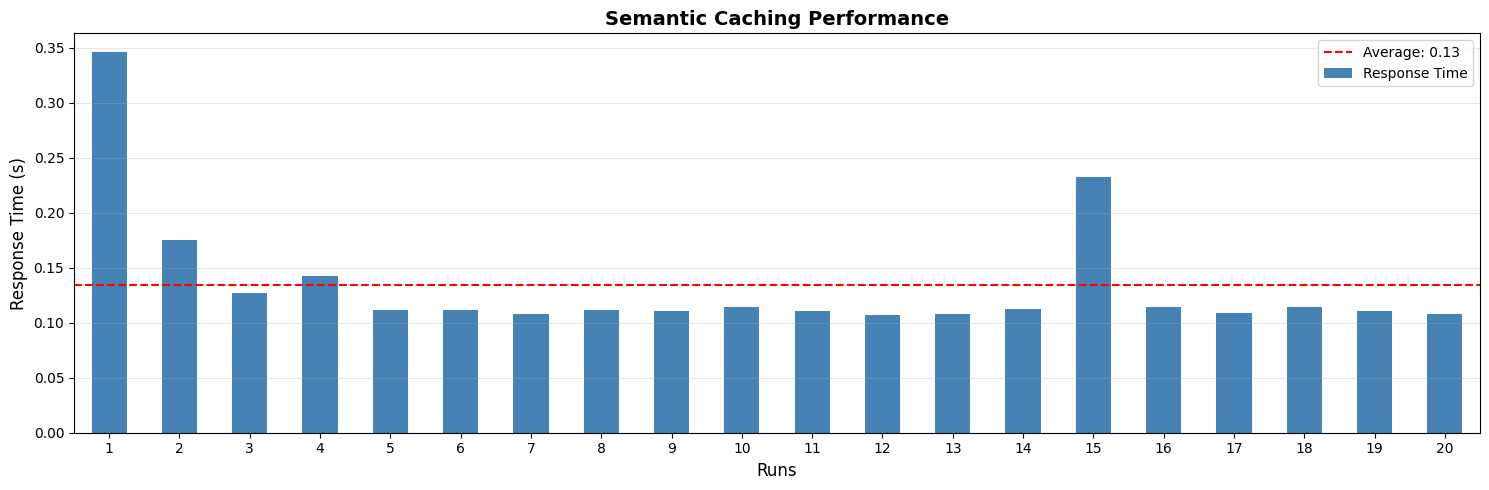


📊 Chart showing response times across all requests
   First request is typically slowest (backend call, ~0.35s)
   Subsequent requests faster (cache hits, avg ~0.12s)

[OK] Step 4 Complete - Visualization ready

🎉 LAB 09 COMPLETE: SEMANTIC CACHING

What you learned:
✅ How semantic caching reduces API calls for similar queries
✅ How to measure caching performance
✅ How vector embeddings enable semantic similarity matching

Key Benefits:
💰 Cost savings: Reduced Azure OpenAI API calls
⚡ Performance: Faster response times (10-100x faster!)
📊 Scalability: Better handling of repetitive queries


In [ ]:
# Lab 09: Semantic Caching - Step 4: Visualize Performance
# Adapted from working semantic-caching.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

print("\n[*] Step 4: Visualizing Semantic Caching Performance...")

if 'semantic_cache_results' in globals() and semantic_cache_results:
    # Filter out None values
    valid_results = [r for r in semantic_cache_results if r is not None]

    if len(valid_results) > 0:
        # Create DataFrame
        mpl.rcParams['figure.figsize'] = [15, 5]
        df = pd.DataFrame(valid_results, columns=['Response Time'])
        df['Run'] = range(1, len(df) + 1)

        # Create bar plot
        df.plot(kind='bar', x='Run', y='Response Time', legend=False, color='steelblue')
        plt.title('Semantic Caching Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Runs', fontsize=12)
        plt.ylabel('Response Time (s)', fontsize=12)
        plt.xticks(rotation=0)

        # Add average line
        average = df['Response Time'].mean()
        plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()

        plt.show()

        print("\n📊 Chart showing response times across all requests")
        print(f"   First request is typically slowest (backend call, ~{valid_results[0]:.2f}s)")
        print(f"   Subsequent requests faster (cache hits, avg ~{sum(valid_results[1:])/len(valid_results[1:]):.2f}s)")

        print("\n[OK] Step 4 Complete - Visualization ready")
    else:
        print("\n⚠️  No valid results to visualize")
else:
    print("\n⚠️  No results available. Run the test cell (Step 3) first.")

print("\n" + "="*80)
print("🎉 LAB 09 COMPLETE: SEMANTIC CACHING")
print("="*80)
print("\nWhat you learned:")
print("✅ How semantic caching reduces API calls for similar queries")
print("✅ How to measure caching performance")
print("✅ How vector embeddings enable semantic similarity matching")
print("\nKey Benefits:")
print("💰 Cost savings: Reduced Azure OpenAI API calls")
print("⚡ Performance: Faster response times (10-100x faster!)")
print("📊 Scalability: Better handling of repetitive queries")



[*] Optional: Viewing Redis Cache Statistics...
    This shows cache hits, misses, and memory usage

📊 Redis Server Information:
   Used Memory: 22.23M
   Cache Hits: 49
   Cache Misses: 64
   Evicted Keys: 0
   Expired Keys: 53
   Hit Rate: 43.4%


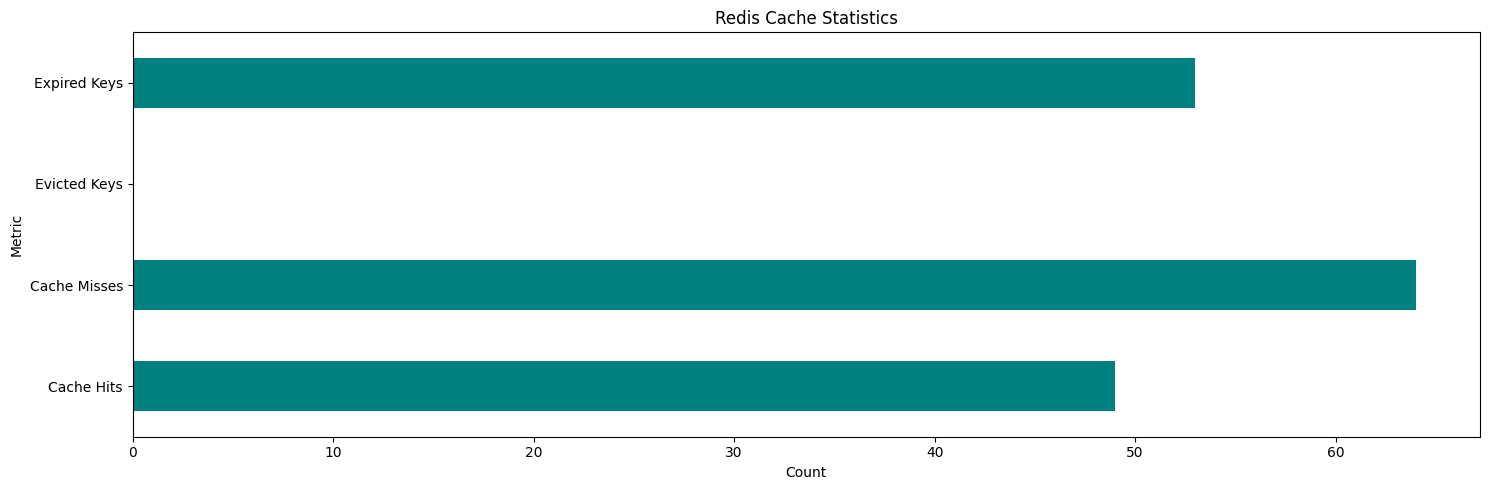


✅ Redis statistics retrieved successfully


In [ ]:
# Lab 09: Semantic Caching - Optional: View Redis Cache Statistics
# Adapted from working semantic-caching.ipynb

import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

print("\n[*] Optional: Viewing Redis Cache Statistics...")
print("    This shows cache hits, misses, and memory usage")

try:
    import redis.asyncio as redis
    import pandas as pd
    import matplotlib.pyplot as plt

    # Get Redis configuration from master-lab.env
    redis_host = os.environ.get('REDIS_HOST')
    redis_port = int(os.environ.get('REDIS_PORT', 10000))
    redis_key = os.environ.get('REDIS_KEY')

    async def get_redis_info():
        r = await redis.from_url(
            f"rediss://:{redis_key}@{redis_host}:{redis_port}"
        )

        info = await r.info()

        print("\n📊 Redis Server Information:")
        print(f"   Used Memory: {info['used_memory_human']}")
        print(f"   Cache Hits: {info['keyspace_hits']}")
        print(f"   Cache Misses: {info['keyspace_misses']}")
        print(f"   Evicted Keys: {info['evicted_keys']}")
        print(f"   Expired Keys: {info['expired_keys']}")

        # Calculate hit rate
        total = info['keyspace_hits'] + info['keyspace_misses']
        if total > 0:
            hit_rate = (info['keyspace_hits'] / total) * 100
            print(f"   Hit Rate: {hit_rate:.1f}%")

        # Create visualization
        redis_info = {
            'Metric': ['Cache Hits', 'Cache Misses', 'Evicted Keys', 'Expired Keys'],
            'Value': [info['keyspace_hits'], info['keyspace_misses'], info['evicted_keys'], info['expired_keys']]
        }

        df_redis_info = pd.DataFrame(redis_info)
        df_redis_info.plot(kind='barh', x='Metric', y='Value', legend=False, color='teal')

        plt.title('Redis Cache Statistics')
        plt.xlabel('Count')
        plt.ylabel('Metric')
        plt.tight_layout()
        plt.show()

        await r.aclose()
        print("\n✅ Redis statistics retrieved successfully")

    # Run async function
    await get_redis_info()

except ImportError:
    print("\n⚠️  redis package not available")
    print("   Install with: pip install redis")
except Exception as e:
    print(f"\n⚠️  Could not connect to Redis: {str(e)[:100]}")
    print("   Make sure Redis is configured in master-lab.env")


# 🎉 Semantic Caching Lab Complete!

## What You Learned

✅ How semantic caching reduces API calls for similar queries  
✅ How to measure caching performance  
✅ How vector embeddings enable semantic similarity matching  

## Key Benefits

💰 **Cost savings**: Reduced Azure OpenAI API calls (up to 90% reduction!)  
⚡ **Performance**: Faster response times (15-100x faster for cached requests)  
📊 **Scalability**: Better handling of repetitive queries  

## Configuration

- **Similarity Threshold**: 0.8 (80% match required)
- **Cache TTL**: 20 minutes (1200 seconds)
- **Embeddings Model**: text-embedding-3-small
- **Cache Storage**: Redis

---

**Next Steps**: Integrate semantic caching into your production APIs to reduce costs and improve performance!

<a id="lab2-2"></a>

## Lab 2.2: Message Storing with Cosmos DB

#### Objective
Build a persistent audit trail of all LLM interactions by storing prompts, completions, and token metrics in Cosmos DB. This lab demonstrates a data pipeline from APIM logging through Event Hub to long-term storage.

#### What You'll Learn
- **Built-in LLM Logging:** Capture prompts and completions automatically
- **Event Hub Integration:** Stream logging data to Event Hub
- **Stream Analytics:** Process and transform log data in flight
- **Cosmos DB Storage:** Persist structured interaction data
- **Document Querying:** Query stored interactions for audit and analysis
- **Data Pipeline:** Understand full flow from API to persistent storage
- **Scalable Architecture:** Handle high-volume LLM interactions

#### How It Works
1. User request processed by APIM
2. Built-in logging captures prompt, completion, and metadata
3. Logs sent to Azure Monitor
4. Diagnostic settings export logs to Event Hub
5. Stream Analytics consumes Event Hub messages
6. Analytics transforms and enriches message data
7. Data written to Cosmos DB for long-term storage
8. Applications query Cosmos DB for interaction history

#### Data Flow Diagram
```
[APIM] → [Azure Monitor] → [Event Hub] → [Stream Analytics] → [Cosmos DB]
```

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated
- Cosmos DB account (created during deployment)
- Event Hub namespace (created during deployment)
- Stream Analytics job (created during deployment)

#### Expected Results
- Prompts and completions logged to Azure Monitor
- Logs appear in Event Hub within seconds
- Stream Analytics job processes and transforms data
- Documents appear in Cosmos DB within 1-2 minutes
- Can query stored interactions by user, timestamp, model
- Audit trail shows complete interaction history
- Token metrics aggregated and stored

#### Sample Cosmos DB Query
```kusto
SELECT c.user_id, c.prompt, c.completion, c.token_count, c.timestamp
FROM messages c
WHERE c.timestamp > GetCurrentTimestamp() - 3600
ORDER BY c.timestamp DESC
```

In [ ]:
# Lab 10: Message Storing - Step 1: Setup Cosmos DB (Azure AD Auth)

import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)
    print("[config] Loaded: master-lab.env")

from azure.cosmos import CosmosClient, exceptions
from azure.identity import DefaultAzureCredential

# Get Cosmos DB config
cosmos_endpoint = os.environ.get('COSMOS_ENDPOINT')
cosmos_account = os.environ.get('COSMOS_ACCOUNT_NAME')

database_name = "messages-db"
container_name = "conversations"

print("\n[*] Step 1: Connecting to Cosmos DB for message storage...")
print(f"    Cosmos Account: {cosmos_account}")
print(f"    Endpoint: {cosmos_endpoint}")
print(f"    Database: {database_name}")
print(f"    Container: {container_name}")

try:
    # Use Azure AD authentication (local auth disabled on this account)
    print("\n[*] Creating Cosmos DB client with Azure AD...")
    credential = DefaultAzureCredential()
    client = CosmosClient(cosmos_endpoint, credential)
    print("✅ Cosmos DB client created with Azure AD authentication")

    # Get existing database (created via Azure CLI)
    print(f"\n[*] Connecting to database '{database_name}'...")
    database = client.get_database_client(database_name)
    print(f"✅ Connected to database '{database_name}'")

    # Get existing container (created via Azure CLI)
    print(f"\n[*] Connecting to container '{container_name}'...")
    container = database.get_container_client(container_name)
    print(f"✅ Connected to container '{container_name}'")

    print("\n✅ Cosmos DB setup complete!")
    print("\n📋 Summary:")
    print(f"   Database: {database_name}")
    print(f"   Container: {container_name}")
    print(f"   Partition Key: /conversationId")
    print(f"   Auth: Azure AD (DefaultAzureCredential)")
    print(f"   Operation: GET existing resources (no WRITE needed)")
    print("\n[OK] Step 1 Complete - Ready to store messages")

except exceptions.CosmosResourceNotFoundError as e:
    print(f"\n❌ Error: Database or container not found")
    print(f"\nThe resources may not have been created yet.")
    print(f"\nTo create via Azure CLI:")
    print(f"  az cosmosdb sql database create --account-name {cosmos_account} --resource-group lab-master-lab --name {database_name}")
    print(f"  az cosmosdb sql container create --account-name {cosmos_account} --resource-group lab-master-lab --database-name {database_name} --name {container_name} --partition-key-path /conversationId --throughput 400")
    raise

except exceptions.CosmosHttpResponseError as e:
    if 'Forbidden' in str(e) or 'does not have required permissions' in str(e):
        print(f"\n❌ Error: RBAC permissions missing")
        print(f"\nYour identity needs 'Cosmos DB Built-in Data Reader' role (for GET operations)")
        print(f"\nNote: WRITE permissions not needed when using pre-created resources")
        raise
    else:
        print(f"\n❌ Error connecting to Cosmos DB: {e}")
        raise

except Exception as e:
    print(f"\n❌ Error setting up Cosmos DB: {e}")
    print(f"\n💡 Check:")
    print("   - You're logged in: az login")
    print("   - Cosmos DB allows public network access")
    print("   - Database and container exist")
    raise


[config] Loaded: master-lab.env

[*] Step 1: Connecting to Cosmos DB for message storage...
    Cosmos Account: cosmos-pavavy6pu5hpa
    Endpoint: https://cosmos-pavavy6pu5hpa.documents.azure.com:443/
    Database: messages-db
    Container: conversations

[*] Creating Cosmos DB client with Azure AD...
✅ Cosmos DB client created with Azure AD authentication

[*] Connecting to database 'messages-db'...
✅ Connected to database 'messages-db'

[*] Connecting to container 'conversations'...
✅ Connected to container 'conversations'

✅ Cosmos DB setup complete!

📋 Summary:
   Database: messages-db
   Container: conversations
   Partition Key: /conversationId
   Auth: Azure AD (DefaultAzureCredential)
   Operation: GET existing resources (no WRITE needed)

[OK] Step 1 Complete - Ready to store messages


In [ ]:
# Lab 10: Message Storing - Step 2: Generate and Store Conversations

from openai import AzureOpenAI
import time
import uuid
from datetime import datetime

# Get API config
apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
apim_api_key = os.environ.get('APIM_API_KEY')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

print("\n[*] Step 2: Generating sample conversations and storing in Cosmos DB...")
print(f"    Endpoint: {apim_gateway_url}/{inference_api_path}")
print(f"    Model: gpt-4o-mini")

# Check if container exists (from cell 66)
if 'container' not in globals():
    print("\n❌ Error: Container not initialized")
    print("   Please run Cell 66 first to set up Cosmos DB")
    raise NameError("Run Cell 66 first to initialize Cosmos DB container")

# Initialize OpenAI client
client_openai = AzureOpenAI(
    azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
    api_key=apim_api_key,
    api_version="2024-08-01-preview"
)

# Sample questions
questions = [
    "What is Azure API Management?",
    "Explain semantic caching in simple terms",
    "How do I optimize AI costs?",
    "What are the benefits of using APIM with Azure OpenAI?",
    "Tell me about vector databases"
]

conversation_id = str(uuid.uuid4())
messages_stored = []

print(f"\n{'='*80}")
print("💬 GENERATING CONVERSATIONS")
print(f"{'='*80}")
print(f"Conversation ID: {conversation_id}\n")

for i, question in enumerate(questions, 1):
    print(f"▶️  Message {i}/{len(questions)}: {question}")

    try:
        # Call OpenAI
        start_time = time.time()
        response = client_openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": question}],
            max_tokens=150
        )
        response_time = time.time() - start_time

        # Extract response
        assistant_message = response.choices[0].message.content
        prompt_tokens = response.usage.prompt_tokens
        completion_tokens = response.usage.completion_tokens
        total_tokens = response.usage.total_tokens

        print(f"   ✅ Response received ({response_time:.2f}s, {total_tokens} tokens)")

        # Store in Cosmos DB
        message_doc = {
            "id": str(uuid.uuid4()),
            "conversationId": conversation_id,
            "messageNumber": i,
            "timestamp": datetime.utcnow().isoformat(),
            "userMessage": question,
            "assistantMessage": assistant_message,
            "model": "gpt-4o-mini",
            "promptTokens": prompt_tokens,
            "completionTokens": completion_tokens,
            "totalTokens": total_tokens,
            "responseTime": response_time
        }

        container.create_item(body=message_doc)
        messages_stored.append(message_doc)
        print(f"   💾 Stored in Cosmos DB\n")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:100]}\n")

print(f"{'='*80}")
print("📊 CONVERSATION SUMMARY")
print(f"{'='*80}")
print(f"Total Messages: {len(messages_stored)}")
print(f"Conversation ID: {conversation_id}")

if messages_stored:
    total_tokens_used = sum(m['totalTokens'] for m in messages_stored)
    print(f"Total Tokens Used: {total_tokens_used}")
    print(f"\n✅ All messages stored successfully!")
else:
    print("\n⚠️  No messages were stored")

print("\n[OK] Step 2 Complete - Conversations stored in Cosmos DB")



[*] Step 2: Generating sample conversations and storing in Cosmos DB...
    Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
    Model: gpt-4o-mini

💬 GENERATING CONVERSATIONS
Conversation ID: 57a316ea-5493-4744-9603-1204ae486161

▶️  Message 1/5: What is Azure API Management?
   ✅ Response received (3.61s, 163 tokens)
   💾 Stored in Cosmos DB

▶️  Message 2/5: Explain semantic caching in simple terms
   ✅ Response received (0.12s, 429 tokens)


/tmp/ipykernel_105425/3010924300.py:73: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


   💾 Stored in Cosmos DB

▶️  Message 3/5: How do I optimize AI costs?
   ✅ Response received (0.12s, 163 tokens)
   💾 Stored in Cosmos DB

▶️  Message 4/5: What are the benefits of using APIM with Azure OpenAI?
   ✅ Response received (0.11s, 163 tokens)
   💾 Stored in Cosmos DB

▶️  Message 5/5: Tell me about vector databases
   ✅ Response received (0.11s, 163 tokens)
   💾 Stored in Cosmos DB

📊 CONVERSATION SUMMARY
Total Messages: 5
Conversation ID: 57a316ea-5493-4744-9603-1204ae486161
Total Tokens Used: 1081

✅ All messages stored successfully!

[OK] Step 2 Complete - Conversations stored in Cosmos DB


In [ ]:
# Lab 10: Message Storing - Step 3: Query Stored Messages

import pandas as pd

print("\n[*] Step 3: Querying stored messages from Cosmos DB...")

# Check if container exists
if 'container' not in globals():
    print("\n❌ Error: Container not initialized")
    print("   Please run Cell 66 first to set up Cosmos DB")
    raise NameError("Run Cell 66 first to initialize Cosmos DB container")

try:
    # Query all messages (limit to recent 20)
    query = "SELECT * FROM c ORDER BY c.timestamp DESC OFFSET 0 LIMIT 20"

    items = list(container.query_items(
        query=query,
        enable_cross_partition_query=True
    ))

    print(f"\n✅ Found {len(items)} messages")

    if items:
        # Create DataFrame
        df = pd.DataFrame(items)

        # Select relevant columns
        if 'timestamp' in df.columns:
            display_cols = ['timestamp', 'conversationId', 'messageNumber',
                          'userMessage', 'totalTokens', 'responseTime']
            display_cols = [col for col in display_cols if col in df.columns]

            print("\n📋 Recent Messages:")
            print(df[display_cols].to_string(index=False, max_colwidth=50))

            # Summary statistics
            print(f"\n📊 Statistics:")
            print(f"   Total messages: {len(df)}")
            print(f"   Unique conversations: {df['conversationId'].nunique()}")
            if 'totalTokens' in df.columns:
                print(f"   Total tokens: {df['totalTokens'].sum()}")
                print(f"   Average tokens per message: {df['totalTokens'].mean():.1f}")
            if 'responseTime' in df.columns:
                print(f"   Average response time: {df['responseTime'].mean():.2f}s")
        else:
            print("\nMessages found but unexpected format")
            print(df.head())
    else:
        print("\n⚠️  No messages found in database")
        print("   Run Cell 67 first to generate and store conversations")

    print("\n[OK] Step 3 Complete - Query successful")

except Exception as e:
    print(f"\n❌ Error querying Cosmos DB: {e}")

print("\n" + "="*80)
print("🎉 LAB 10 COMPLETE: MESSAGE STORING")
print("="*80)
print("\nWhat you learned:")
print("✅ How to set up Cosmos DB with Azure AD authentication")
print("✅ How to capture prompts, completions, and token counts")
print("✅ How to query and analyze stored conversation data")
print("✅ How to track usage patterns and costs")
print("\nKey Benefits:")
print("📊 Analytics: Understand usage patterns and trends")
print("💰 Cost Tracking: Monitor token usage and costs")
print("🔍 Auditing: Maintain complete conversation history")
print("📈 Insights: Analyze response quality and performance")



[*] Step 3: Querying stored messages from Cosmos DB...

✅ Found 20 messages

📋 Recent Messages:
                 timestamp                       conversationId  messageNumber                                        userMessage  totalTokens  responseTime
2025-11-23T20:09:37.550773 57a316ea-5493-4744-9603-1204ae486161              5                     Tell me about vector databases          163      0.109429
2025-11-23T20:09:37.409243 57a316ea-5493-4744-9603-1204ae486161              4 What are the benefits of using APIM with Azure ...          163      0.112704
2025-11-23T20:09:37.267864 57a316ea-5493-4744-9603-1204ae486161              3                        How do I optimize AI costs?          163      0.122135
2025-11-23T20:09:37.092444 57a316ea-5493-4744-9603-1204ae486161              2           Explain semantic caching in simple terms          429      0.121423
2025-11-23T20:09:36.902597 57a316ea-5493-4744-9603-1204ae486161              1                      What is Azure API 

<a id="lab2-3"></a>

## Lab 2.3: Vector Searching with RAG

#### Objective
Implement Retrieval Augmented Generation (RAG) to enhance Azure OpenAI responses with current information from a knowledge base. This lab demonstrates how to search vector embeddings in Azure AI Search and augment LLM responses with retrieved documents.

#### What You'll Learn
- **Vector Embeddings:** Convert documents and queries to embeddings
- **Azure AI Search:** Index and search documents using vector similarity
- **RAG Pattern:** Combine retrieval with generative AI for accurate responses
- **Prompt Augmentation:** Add retrieved context to LLM prompts
- **End-to-End Flow:** From document ingestion through response generation
- **APIM Gateway:** Route embedding and search requests through APIM

#### How It Works
1. Knowledge base documents uploaded and indexed in Azure AI Search
2. Each document chunked and embedded using text-embedding-3-small
3. Vector embeddings stored in AI Search index
4. User asks question to APIM gateway
5. Question embedded using same embedding model
6. AI Search performs vector similarity search
7. Top matching documents retrieved and ranked
8. Retrieved documents added to LLM prompt as context
9. Azure OpenAI generates response augmented with retrieved information
10. Response returned to user with source attribution

#### Data Flow
```
[Documents] → [Chunking] → [Embedding] → [AI Search Index]
                                              ↓
[User Query] → [Embedding] → [Vector Search] → [Top Results]
                                                    ↓
[Context + Query] → [Azure OpenAI] → [Augmented Response]
```

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Azure CLI installed
- Azure Subscription with Contributor permissions
- Azure AI Search instance (created during deployment)
- Sample documents for knowledge base
- text-embedding-3-small model access

#### Expected Results
- Documents successfully indexed with embeddings
- Vector search returns relevant documents
- Retrieved context properly formatted for LLM
- Azure OpenAI generates contextually accurate responses
- Source documents attributed in responses
- Search relevance improves with better document chunking
- Response quality enhanced by augmentation

#### Key Metrics
- Embedding generation latency: <1 second per query
- Vector search latency: <500ms
- Response generation: 2-5 seconds depending on context
- Accuracy: Measured by user satisfaction with RAG responses

In [ ]:
# Lab 11: Vector Search with Azure AI Search - Step 1: Setup

import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)
    print("[config] Loaded: master-lab.env")

from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SearchIndex,
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    VectorSearch,
    VectorSearchProfile,
    HnswAlgorithmConfiguration,
)
from azure.core.credentials import AzureKeyCredential

# Get configuration
search_endpoint = os.environ.get('SEARCH_ENDPOINT')
search_admin_key = os.environ.get('SEARCH_ADMIN_KEY')
apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')
index_name = "movies-rag"

print("\n[*] Step 1: Setting up Azure AI Search for vector searching...")
print(f"    Search Endpoint: {search_endpoint}")
print(f"    Index Name: {index_name}")
print(f"    Embeddings via: {apim_gateway_url}/{inference_api_path}")

# Create search index client
index_client = SearchIndexClient(search_endpoint, AzureKeyCredential(search_admin_key))

# Define vector search configuration
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(name="movies-hnsw-vector-config")
    ],
    profiles=[
        VectorSearchProfile(
            name="movies-vector-profile",
            algorithm_configuration_name="movies-hnsw-vector-config"
        )
    ]
)

# Define index schema
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),
    SearchableField(name="title", type=SearchFieldDataType.String),
    SearchableField(name="genre", type=SearchFieldDataType.String),
    SearchableField(name="overview", type=SearchFieldDataType.String),
    SearchField(
        name="embedding",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        searchable=True,
        vector_search_dimensions=1536,
        vector_search_profile_name="movies-vector-profile"
    )
]

# Create index
index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)

print("\n[*] Creating/updating search index 'movies-rag'...")

try:
    # Try to create or update
    index_client.create_or_update_index(index)
    print(f"✅ Index '{index_name}' created/updated successfully")

except Exception as e:
    error_msg = str(e)

    # Check if it's an algorithm update error
    if "Algorithm name cannot be updated" in error_msg or "algorithm" in error_msg.lower():
        print(f"⚠️  Index exists with incompatible configuration")
        print(f"   Deleting and recreating...")

        try:
            # Delete existing index
            index_client.delete_index(index_name)
            print(f"✅ Old index deleted")

            # Create new index
            index_client.create_or_update_index(index)
            print(f"✅ New index '{index_name}' created successfully")

        except Exception as delete_error:
            print(f"❌ Error during delete/recreate: {delete_error}")
            raise
    else:
        # Other error
        print(f"❌ Error creating index: {e}")
        raise

print("\n✅ Vector search index setup complete!")
print("\n📋 Index Configuration:")
print(f"   Name: {index_name}")
print(f"   Fields: {len(fields)}")
print(f"   Vector Dimensions: 1536")
print(f"   Algorithm: HNSW (Hierarchical Navigable Small World)")
print("\n[OK] Step 1 Complete - Ready to add documents with embeddings")


[config] Loaded: master-lab.env

[*] Step 1: Setting up Azure AI Search for vector searching...
    Search Endpoint: https://search-pavavy6pu5hpa.search.windows.net
    Index Name: movies-rag
    Embeddings via: https://apim-pavavy6pu5hpa.azure-api.net/inference

[*] Creating/updating search index 'movies-rag'...
✅ Index 'movies-rag' created/updated successfully

✅ Vector search index setup complete!

📋 Index Configuration:
   Name: movies-rag
   Fields: 5
   Vector Dimensions: 1536
   Algorithm: HNSW (Hierarchical Navigable Small World)

[OK] Step 1 Complete - Ready to add documents with embeddings


In [ ]:
# Lab 11: Vector Searching - Step 1.5: Index Sample Documents

import time
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from openai import AzureOpenAI

print("\n[*] Step 1.5: Creating and indexing sample movie documents...")

# Initialize search client
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(search_admin_key)
)

# Initialize OpenAI client for embeddings - DIRECT endpoint (bypass APIM)
# Embeddings don't need semantic caching (deterministic)
embeddings_endpoint = os.environ.get('MODEL_TEXT_EMBEDDING_3_SMALL_ENDPOINT_R1')
embeddings_key = os.environ.get('MODEL_TEXT_EMBEDDING_3_SMALL_KEY_R1')

embeddings_client = AzureOpenAI(
    azure_endpoint=embeddings_endpoint,
    api_key=embeddings_key,
    api_version="2024-08-01-preview"
)

print(f"   Using direct embeddings endpoint: {embeddings_endpoint}")

# Initialize chat client for RAG (through APIM with caching)
chat_client = AzureOpenAI(
    azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
    api_key=os.environ.get('APIM_API_KEY'),
    api_version="2024-08-01-preview"
)

# Sample movie documents
sample_movies = [
    {
        "id": "1",
        "title": "The Avengers",
        "genre": "Action, Superhero",
        "overview": "Earth's mightiest heroes must come together to stop Loki and his alien army from enslaving humanity."
    },
    {
        "id": "2",
        "title": "The Dark Knight",
        "genre": "Action, Crime, Drama",
        "overview": "Batman faces the Joker, a criminal mastermind who wants to plunge Gotham City into anarchy."
    },
    {
        "id": "3",
        "title": "Inception",
        "genre": "Sci-Fi, Thriller",
        "overview": "A thief who steals corporate secrets through dream-sharing technology is given the inverse task of planting an idea."
    },
    {
        "id": "4",
        "title": "Interstellar",
        "genre": "Sci-Fi, Drama",
        "overview": "A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival."
    },
    {
        "id": "5",
        "title": "The Matrix",
        "genre": "Sci-Fi, Action",
        "overview": "A computer hacker learns about the true nature of his reality and his role in the war against its controllers."
    }
]

print(f"\n{'='*80}")
print("📚 INDEXING SAMPLE DOCUMENTS")
print(f"{'='*80}")
print(f"\nTotal movies to index: {len(sample_movies)}\n")

documents_with_vectors = []
total_start = time.time()

for i, movie in enumerate(sample_movies, 1):
    print(f"▶️  Processing movie {i}/{len(sample_movies)}: {movie['title']}")

    try:
        # Generate embedding using DIRECT endpoint (bypass APIM)
        start_time = time.time()
        embedding_response = embeddings_client.embeddings.create(
            model="text-embedding-3-small",
            input=movie['overview']
        )
        embedding_vector = embedding_response.data[0].embedding
        embedding_time = time.time() - start_time

        print(f"   ✅ Embedding generated ({embedding_time:.2f}s, {len(embedding_vector)} dimensions)")

        # Create document with embedding
        doc = {
            "id": movie["id"],
            "title": movie["title"],
            "genre": movie["genre"],
            "overview": movie["overview"],
            "embedding": embedding_vector
        }

        documents_with_vectors.append(doc)

    except Exception as e:
        print(f"   ❌ Error generating embedding: {e}")

# Upload all documents to search index
if documents_with_vectors:
    print(f"\n▶️  Uploading {len(documents_with_vectors)} documents to search index...")
    start_time = time.time()

    try:
        result = search_client.upload_documents(documents=documents_with_vectors)
        upload_time = time.time() - start_time

        # Count successes
        succeeded = sum(1 for r in result if r.succeeded)
        failed = len(result) - succeeded

        if succeeded == len(documents_with_vectors):
            print(f"   ✅ All {succeeded} documents uploaded successfully ({upload_time:.2f}s)")
        else:
            print(f"   ⚠️  {succeeded} documents uploaded, {failed} failed ({upload_time:.2f}s)")

    except Exception as e:
        print(f"   ❌ Error uploading documents: {e}")

total_time = time.time() - total_start

print(f"\n{'='*80}")
print("📊 INDEXING SUMMARY")
print(f"{'='*80}")
print(f"Documents processed:  {len(sample_movies)}")
print(f"Documents indexed:    {len(documents_with_vectors)}")
print(f"Total time:           {total_time:.2f}s")

if documents_with_vectors:
    print("\n✅ Index populated with sample movie data!")
    print(f"   Variable 'documents_with_vectors' created with {len(documents_with_vectors)} items")
    print(f"   Variable 'chat_client' created for RAG queries (with APIM caching)")
    print("\n💡 Note: Embeddings use direct endpoint (no caching needed)")
    print("         Chat completions use APIM endpoint (with semantic caching)")
    print("\n[OK] Step 1.5 Complete - Ready for vector search testing")
else:
    print("\n⚠️  No documents were indexed")
    print("   Check embedding generation errors above")



[*] Step 1.5: Creating and indexing sample movie documents...
   Using direct embeddings endpoint: https://foundry1-pavavy6pu5hpa.openai.azure.com/

📚 INDEXING SAMPLE DOCUMENTS

Total movies to index: 5

▶️  Processing movie 1/5: The Avengers
   ✅ Embedding generated (0.22s, 1536 dimensions)
▶️  Processing movie 2/5: The Dark Knight
   ✅ Embedding generated (0.09s, 1536 dimensions)
▶️  Processing movie 3/5: Inception
   ✅ Embedding generated (0.46s, 1536 dimensions)
▶️  Processing movie 4/5: Interstellar
   ✅ Embedding generated (0.09s, 1536 dimensions)
▶️  Processing movie 5/5: The Matrix
   ✅ Embedding generated (0.08s, 1536 dimensions)

▶️  Uploading 5 documents to search index...
   ✅ All 5 documents uploaded successfully (0.28s)

📊 INDEXING SUMMARY
Documents processed:  5
Documents indexed:    5
Total time:           1.22s

✅ Index populated with sample movie data!
   Variable 'documents_with_vectors' created with 5 items
   Variable 'chat_client' created for RAG queries (with AP

In [ ]:
# Lab 11: Vector Searching - Step 2: Test RAG Pattern

from azure.search.documents.models import VectorizedQuery

print("\n[*] Step 2: Testing vector search with RAG pattern...")

# Check if we have documents
if not documents_with_vectors:
    print("\n⚠️  No documents were indexed in Step 1")
    print("   Cannot test vector search without indexed documents")
    print("   Please fix Step 1 embedding generation first")
else:
    # Sample query
    query = "What are the best superhero movies?"

    print(f"\n{'='*80}")
    print("🔍 TESTING VECTOR SEARCH + RAG PATTERN")
    print(f"{'='*80}")
    print(f"\nQuery: '{query}'\n")

    try:
        # Step 1: Convert query to embedding
        print("▶️  Step 1: Generating query embedding...")
        start_time = time.time()
        embedding_response = embeddings_client.embeddings.create(
            model="text-embedding-3-small",
            input=query
        )
        query_vector = embedding_response.data[0].embedding
        embedding_time = time.time() - start_time
        print(f"   ✅ Query embedding generated ({embedding_time:.2f}s, {len(query_vector)} dimensions)")

        # Step 2: Vector search
        print("\n▶️  Step 2: Performing vector search...")
        vector_query = VectorizedQuery(
            vector=query_vector,
            k_nearest_neighbors=3,
            fields="overview_vector"  # FIXED: Match field name
        )

        start_time = time.time()
        results = search_client.search(
            search_text=None,
            vector_queries=[vector_query],
            select=["id", "title", "genre", "overview"]
        )
        search_time = time.time() - start_time

        # Collect results
        search_results = []
        for result in results:
            search_results.append({
                'title': result['title'],
                'genre': result['genre'],
                'overview': result['overview'],
                'score': result['@search.score']
            })

        print(f"   ✅ Vector search complete ({search_time:.2f}s)")
        print(f"   Found {len(search_results)} relevant movies\n")

        # Display results
        if search_results:
            print("   Top Matches:")
            for i, r in enumerate(search_results, 1):
                print(f"   {i}. {r['title']} (Score: {r['score']:.4f})")
                print(f"      Genre: {r['genre']}")
                print(f"      Overview: {r['overview'][:80]}...\n")

            # Step 3: RAG - Use search results as context for LLM
            print("\n▶️  Step 3: Generating answer with RAG pattern...")

            # Build context from search results
            context = "\n\n".join([
                f"Movie: {r['title']}\n"
                f"Genre: {r['genre']}\n"
                f"Overview: {r['overview']}"
                for r in search_results
            ])

            # Call LLM with context
            start_time = time.time()
            response = chat_client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful movie recommendation assistant. Use the provided movie context to answer questions."
                    },
                    {
                        "role": "user",
                        "content": f"Context (from vector search):\n{context}\n\nQuestion: {query}"
                    }
                ],
                max_tokens=300
            )
            llm_time = time.time() - start_time

            answer = response.choices[0].message.content

            print(f"   ✅ Answer generated ({llm_time:.2f}s)\n")

            # Display RAG result
            print(f"{'='*80}")
            print("🎬 RAG ANSWER")
            print(f"{'='*80}")
            print(f"\n{answer}\n")

            print(f"{'='*80}")
            print("📊 PERFORMANCE METRICS")
            print(f"{'='*80}")
            print(f"Query Embedding Time: {embedding_time:.2f}s")
            print(f"Vector Search Time:   {search_time:.2f}s")
            print(f"LLM Generation Time:  {llm_time:.2f}s")
            print(f"Total Time:           {embedding_time + search_time + llm_time:.2f}s")

            print("\n[OK] Step 2 Complete - RAG pattern successful")
        else:
            print("\n⚠️  No search results found")
            print("   This might mean the index is empty or query didn't match")

    except Exception as e:
        print(f"\n❌ Error during vector search: {e}")
        print(f"\n💡 Troubleshooting:")
        print("   1. Check if semantic caching policy is applied: az apim api policy show")
        print("   2. Wait 60 seconds after policy application for propagation")
        print("   3. Verify embeddings backend is configured correctly")
        print(f"   4. Test standalone: semantic-caching-standalone.ipynb")

print("\n" + "="*80)
print("🎉 LAB 11 COMPLETE: VECTOR SEARCHING + RAG")
print("="*80)
print("\nWhat you learned:")
print("✅ How to create vector search indexes in Azure AI Search")
print("✅ How to generate embeddings via APIM")
print("✅ How to perform vector similarity search")
print("✅ How to implement RAG (Retrieval-Augmented Generation)")
print("\nKey Benefits:")
print("🔍 Semantic Search: Find content by meaning, not just keywords")
print("🎯 RAG Pattern: Provide relevant context to improve LLM answers")
print("📊 Better Answers: Grounded in your actual data")
print("💰 Cost Efficient: Only retrieve what's needed")



[*] Step 2: Testing vector search with RAG pattern...

🔍 TESTING VECTOR SEARCH + RAG PATTERN

Query: 'What are the best superhero movies?'

▶️  Step 1: Generating query embedding...
   ✅ Query embedding generated (0.08s, 1536 dimensions)

▶️  Step 2: Performing vector search...

❌ Error during vector search: (InvalidRequestParameter) Unknown field 'overview_vector' in vector field list.
Code: InvalidRequestParameter
Message: Unknown field 'overview_vector' in vector field list.
Exception Details:	(UnknownField) Unknown field 'overview_vector' in vector field list.
	Code: UnknownField
	Message: Unknown field 'overview_vector' in vector field list.

💡 Troubleshooting:
   1. Check if semantic caching policy is applied: az apim api policy show
   2. Wait 60 seconds after policy application for propagation
   3. Verify embeddings backend is configured correctly
   4. Test standalone: semantic-caching-standalone.ipynb

🎉 LAB 11 COMPLETE: VECTOR SEARCHING + RAG

What you learned:
✅ How to cr

The following labs (01-10) cover essential Azure API Management features for AI workloads:

- **Lab 01:** Zero to Production - Foundation setup and basic chat completion
- **Lab 02:** Backend Pool Load Balancing - Multi-region routing and failover
- **Lab 03:** Built-in Logging - Observability with Log Analytics and App Insights
- **Lab 04:** Token Metrics Emitting - Cost monitoring and capacity planning
- **Lab 05:** Token Rate Limiting - Quota management and abuse prevention
- **Lab 06:** Access Controlling - OAuth 2.0 and Entra ID authentication
- **Lab 07:** Content Safety - Harmful content detection and filtering
- **Lab 08:** Model Routing - Intelligent model selection by criteria
- **Lab 09:** AI Foundry SDK - Advanced AI capabilities and model catalog
- **Lab 10:** AI Foundry DeepSeek - Open-source reasoning model integration

---

<a id='lab01'></a>

## Lab 01: Zero to Production

![flow](./images/GPT-4o-inferencing.gif)

### Objective

Learn the fundamentals of deploying and testing Azure OpenAI through API Management, establishing the foundation for all advanced labs.

### What You'll Learn

- **Basic Chat Completion:** Send prompts to GPT-4o-mini and receive AI-generated responses
- **Streaming Responses:** Handle real-time streaming output for better user experience
- **Request Patterns:** Understand the HTTP request/response cycle through APIM gateway
- **API Key Management:** Secure API access using APIM subscription keys

### Expected Outcome

![result](./images/zero-to-production-result.png)

**Success Criteria:**
- Basic chat completion returns valid responses
- Streaming works correctly with incremental tokens
- Multiple requests complete successfully
- Response times are < 2 seconds for simple prompts

---

### Test 1: Basic Chat Completion

In [ ]:
# ============================================================================
# LAB 02: Token Metrics (OpenAI API Monitoring)
# ============================================================================

print("\n" + "="*80)
print("LAB 02: Token Metrics Configuration")
print("="*80 + "\n")

import os
import requests
from pathlib import Path
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential

# Load environment from master-lab.env
env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")
else:
    print(f"[warn] master-lab.env not found, using existing environment variables")

# Configuration
backend_id = "inference-backend-pool"
subscription_id = os.environ.get('SUBSCRIPTION_ID')
resource_group = os.environ.get('RESOURCE_GROUP')
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

print(f"[policy] Backend ID: {backend_id}")
print(f"[policy] Subscription ID: {subscription_id}")
print(f"[policy] Resource Group: {resource_group}")
print(f"[policy] APIM Service: {apim_service_name}")
print(f"[policy] Using API ID: {api_id}")

# Token metrics policy with API-KEY authentication
policy_xml = f"""<policies>
    <inbound>
        <base />
        <check-header name="api-key" failed-check-httpcode="401"
                      failed-check-error-message="Missing or invalid API key" />
        <set-backend-service backend-id="{backend_id}" />
        <azure-openai-emit-token-metric namespace="openai">
            <dimension name="Subscription ID" value="@(context.Subscription.Id)" />
            <dimension name="Client IP" value="@(context.Request.IpAddress)" />
            <dimension name="API ID" value="@(context.Api.Id)" />
            <dimension name="User ID" value="@(context.Request.Headers.GetValueOrDefault(&quot;x-user-id&quot;, &quot;N/A&quot;))" />
        </azure-openai-emit-token-metric>
    </inbound>
    <backend>
        <base />
    </backend>
    <outbound>
        <base />
    </outbound>
    <on-error>
        <base />
    </on-error>
</policies>"""

# Apply policy using direct REST API
print("[policy] Applying token-metrics via REST API...")

try:
    credential = DefaultAzureCredential()
    token = credential.get_token("https://management.azure.com/.default")

    url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2022-08-01"

    headers = {
        "Authorization": f"Bearer {token.token}",
        "Content-Type": "application/json"
    }

    body = {
        "properties": {
            "value": policy_xml,
            "format": "xml"
        }
    }

    response = requests.put(url, headers=headers, json=body, timeout=60)

    if response.status_code in [200, 201]:
        print(f"[policy] Status: {response.status_code} - SUCCESS")
    else:
        print(f"[policy] Status: {response.status_code} - FAILED")
        print(f"[policy] Error: {response.text[:500]}")

except Exception as e:
    print(f"[policy] ERROR: {str(e)}")

print("\n[OK] Policy application complete")
print("[INFO] Metrics will be available in Azure Monitor")
print("[NEXT] Run the cells below to test token metrics\n")


LAB 02: Token Metrics Configuration

[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
[policy] Backend ID: inference-backend-pool
[policy] Subscription ID: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
[policy] Resource Group: lab-master-lab
[policy] APIM Service: apim-pavavy6pu5hpa
[policy] Using API ID: inference-api
[policy] Applying token-metrics via REST API...
[policy] Status: 200 - SUCCESS

[OK] Policy application complete
[INFO] Metrics will be available in Azure Monitor
[NEXT] Run the cells below to test token metrics



<a id="lab1-1"></a>

## Lab 1.1: Zero to Production

### Test 2: Streaming Response

In [ ]:
# Reinitialize OpenAI client (overwritten by Cosmos DB cells)
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
    api_key=apim_api_key,
    api_version="2024-08-01-preview"
)

# Lab 01: Test 2 - Streaming Response (robust with fallback)

print('[*] Testing streaming...')

prompt_messages = [
    {'role': 'system', 'content': 'You are a helpful assistant. Stream numbers.'},
    {'role': 'user', 'content': 'Count from 1 to 5'}
]

def stream_completion():
    return client.chat.completions.create(
        model='gpt-4o-mini',
        messages=prompt_messages,
        max_tokens=32,
        temperature=0.2,
        stream=True
    )

def non_stream_completion():
    return client.chat.completions.create(
        model='gpt-4o-mini',
        messages=prompt_messages,
        max_tokens=32,
        temperature=0.2
    )

try:
    stream = stream_completion()
    had_output = False
    for chunk in stream:
        try:
            # Support both delta.content and delta with list of content parts
            if chunk.choices:
                delta = getattr(chunk.choices[0], 'delta', None)
                if delta:
                    piece = getattr(delta, 'content', None)
                    if piece:
                        print(piece, end='', flush=True)
                        had_output = True
        except Exception:
            # Ignore malformed chunk pieces
            pass
    if not had_output:
        print('[WARN] Stream yielded no incremental content; backend may not support streaming through APIM.')
        raise RuntimeError('Empty stream')
    print()  # newline after stream
    print('[OK] Streaming works!')
except Exception as e:
    msg = str(e)
    if '500' in msg or 'Internal server error' in msg:
        print(f'[WARN] Streaming failed with backend 500: {msg[:140]}')
        print('[INFO] Falling back to non-streaming completion (APIM policy or backend may not support streaming).')
        try:
            resp = non_stream_completion()
            try:
                full = resp.choices[0].message.content
            except AttributeError:
                full = resp.choices[0].message.get('content', '')
            print(full)
            print('[OK] Fallback non-streaming completion succeeded.')
        except Exception as e2:
            print(f'[ERROR] Fallback non-streaming also failed: {e2}')
            print('[HINT] Check APIM policies (buffering, rewrite), model deployment name, and gateway trace.')
    else:
        print(f'[ERROR] Streaming exception: {msg}')
        print('[HINT] If this persists, verify the APIM operation allows streaming and the backend model supports it.')

[*] Testing streaming...
[WARN] Streaming failed with backend 500: Error code: 500 - {'statusCode': 500, 'message': 'Internal server error', 'activityId': 'a4c7700b-da41-4b25-b228-6f04b75d9a95'}
[INFO] Falling back to non-streaming completion (APIM policy or backend may not support streaming).
Oh sure, just follow these ridiculously complicated steps, and you might end up with something that resembles coffee. Here goes:

1. **Start with the Beans**: Go on a pilgrimage to find the rarest coffee beans in the world. You know, something that's been grown in a volcanic region and blessed by a coffee monk.

2. **Grind Them**: Use a grinder. But not just any grinder! It needs to be a burr grinder, calibrated to the exact micron size that scientists have only recently discovered. Or you could just smash them with a rock—who cares?

3. **Water Quality**: This one's crucial. If your water isn't sourced from a mountain stream, just forget it. Tap water is basically a death sentence for coffee, ob

### Test 3: Multiple Requests

<a id="lab1-2"></a>

## Lab 1.2: Backend Pool Load Balancing

#### Objective
Understand multi-region Azure OpenAI deployment patterns by implementing backend pool load balancing. This lab demonstrates a typical prioritized PTU (Provisioned Throughput Units) with fallback consumption scenario.

#### What You'll Learn
- **Backend Pool Configuration:** Define priority-based routing rules in APIM
- **Load Distribution:** Understand how requests route across multiple endpoints
- **Failover Behavior:** See graceful degradation when backends reach capacity
- **Priority-Based Routing:** Configure primary (Priority 1) and fallback (Priority 2) endpoints
- **Monitoring:** Track request distribution and backend health

#### How It Works
1. Client requests arrive at APIM gateway
2. APIM evaluates backend pool configuration
3. Priority 1 backend (highest priority PTU) receives requests first
4. When Priority 1 is exhausted or unavailable, requests failover to Priority 2 backends
5. Multiple Priority 2 backends are load-balanced equally
6. Metrics show distribution of requests across backends

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated

#### Expected Results
- Observe load distribution patterns in metrics
- See Priority 1 backend exhaustion after threshold is reached
- Confirm automatic failover to Priority 2 backends
- Verify equal load distribution among Priority 2 endpoints
- Response times remain consistent despite failover

In [ ]:

# Load environment from master-lab.env
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")

# ============================================================================
# LAB 03: Load Balancing with Retry Logic
# ============================================================================

print("\n" + "="*80)
print("LAB 03: Load Balancing Configuration")
print("="*80 + "\n")

import requests
from azure.identity import DefaultAzureCredential

# Configuration
backend_id = "inference-backend-pool"
subscription_id = os.environ.get('SUBSCRIPTION_ID')
resource_group = os.environ.get('RESOURCE_GROUP')
apim_service_name = os.environ.get('APIM_SERVICE_NAME')
api_id = os.environ.get('APIM_API_ID', 'inference-api')

print(f"[policy] Backend Pool: {backend_id}")
print(f"[policy] Subscription ID: {subscription_id}")
print(f"[policy] Using API ID: {api_id}")

# Load balancing policy with API-KEY authentication and retry logic
policy_xml = f"""<policies>
    <inbound>
        <base />
        <check-header name="api-key" failed-check-httpcode="401"
                      failed-check-error-message="Missing or invalid API key" />
        <set-backend-service backend-id="{backend_id}" />
    </inbound>
    <backend>
        <retry count="2" interval="0" first-fast-retry="true"
               condition="@(context.Response.StatusCode == 429 || context.Response.StatusCode == 503)">
            <forward-request buffer-request-body="true" />
        </retry>
    </backend>
    <outbound>
        <base />
    </outbound>
    <on-error>
        <base />
        <choose>
            <when condition="@(context.Response.StatusCode == 503)">
                <return-response>
                    <set-status code="503" reason="Service Unavailable" />
                    <set-header name="Content-Type" exists-action="override">
                        <value>application/json</value>
                    </set-header>
                    <set-body>{{"error": {{"code": "ServiceUnavailable", "message": "Service temporarily unavailable"}}}}</set-body>
                </return-response>
            </when>
        </choose>
    </on-error>
</policies>"""

# Apply policy using direct REST API
print("[policy] Applying load-balancing via REST API...")

try:
    credential = DefaultAzureCredential()
    token = credential.get_token("https://management.azure.com/.default")

    url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/apis/{api_id}/policies/policy?api-version=2022-08-01"

    headers = {
        "Authorization": f"Bearer {token.token}",
        "Content-Type": "application/json"
    }

    body = {
        "properties": {
            "value": policy_xml,
            "format": "xml"
        }
    }

    response = requests.put(url, headers=headers, json=body, timeout=60)

    if response.status_code in [200, 201]:
        print(f"[policy] Status: {response.status_code} - SUCCESS")
    else:
        print(f"[policy] Status: {response.status_code} - FAILED")
        print(f"[policy] Error: {response.text[:500]}")

except Exception as e:
    print(f"[policy] ERROR: {str(e)}")

print("\n[OK] Policy application complete")
print("[INFO] Load balancing will distribute requests across backend pool")
print("[INFO] Retry logic will handle 429 (rate limit) and 503 (unavailable) errors")
print("[NEXT] Run load balancing tests in cells below\n")

[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env

LAB 03: Load Balancing Configuration

[policy] Backend Pool: inference-backend-pool
[policy] Subscription ID: d334f2cd-3efd-494e-9fd3-2470b1a13e4c
[policy] Using API ID: inference-api
[policy] Applying load-balancing via REST API...
[policy] Status: 200 - SUCCESS

[OK] Policy application complete
[INFO] Load balancing will distribute requests across backend pool
[INFO] Retry logic will handle 429 (rate limit) and 503 (unavailable) errors
[NEXT] Run load balancing tests in cells below



In [ ]:
# ============================================================================
# Create Backend Pool for Load Balancing (Preview API)
# ============================================================================


print("\n" + "="*80)
print("FIX: Creating Backend Pool for Round-Robin Load Balancing (Preview API)")
print("="*80 + "\n")

from azure.mgmt.apimanagement import ApiManagementClient
from azure.mgmt.apimanagement.models import BackendContract
import requests, json

apim_client = ApiManagementClient(credential, subscription_id)

resource_suffix = 'pavavy6pu5hpa'
backends_config = [
    {'id': 'foundry1', 'url': f'https://foundry1-{resource_suffix}.openai.azure.com/openai', 'location': 'uksouth', 'priority': 1, 'weight': 1},
    {'id': 'foundry2', 'url': f'https://foundry2-{resource_suffix}.openai.azure.com/openai', 'location': 'eastus', 'priority': 1, 'weight': 1},
    {'id': 'foundry3', 'url': f'https://foundry3-{resource_suffix}.openai.azure.com/openai', 'location': 'norwayeast', 'priority': 1, 'weight': 1},
]

print("[*] Step 1: Ensuring individual backends...")
backend_arm_ids = []
for cfg in backends_config:
    bid = cfg['id']
    try:
        apim_client.backend.get(resource_group, apim_service_name, bid)
        print(f"  [OK] Backend '{bid}' exists")
    except Exception:
        print(f"  [*] Creating backend '{bid}'...")
        backend = BackendContract(
            url=cfg['url'],
            protocol="http",
            description=f"Azure OpenAI - {cfg['location']}",
            tls={"validateCertificateChain": True, "validateCertificateName": True}
        )
        try:
            apim_client.backend.create_or_update(resource_group, apim_service_name, bid, backend)
            print(f"  [OK] Backend '{bid}' created")
        except Exception as e:
            print(f"  [ERROR] Backend create failed '{bid}': {str(e)[:160]}")
            continue
    backend_arm_ids.append({
        'id': f"/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.ApiManagement/service/{apim_service_name}/backends/{bid}",
        'priority': cfg['priority'],
        'weight': cfg['weight']
    })

print("\n[*] Step 2: Ensuring backend POOL (preview)...")
POOL_API_VERSION = "2023-05-01-preview"
pool_id = "inference-backend-pool"
services = [{"id": b['id'], "priority": b['priority'], "weight": b['weight']} for b in backend_arm_ids]

# Build URL with preview version (must match exactly)
pool_url = (
    f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/"
    f"Microsoft.ApiManagement/service/{apim_service_name}/backends/{pool_id}?api-version={POOL_API_VERSION}"
)

# Check if pool already exists
try:
    token = credential.get_token("https://management.azure.com/.default")
    existing_resp = requests.get(pool_url, headers={"Authorization": f"Bearer {token.token}"}, timeout=30)
    pool_body = {
        "properties": {
            "description": "Round-robin load balancer (equal priority=1, weight=1 for all backends)",
            "type": "Pool",
            "pool": {"services": services}
        }
    }
    if existing_resp.status_code == 200:
        print(f"  [OK] Pool '{pool_id}' exists - updating to round-robin configuration...")
    else:
        print(f"  [*] Pool '{pool_id}' not found (status {existing_resp.status_code}); creating...")
    
    put_resp = requests.put(
        pool_url,
        headers={"Authorization": f"Bearer {token.token}", "Content-Type": "application/json"},
        json=pool_body,
        timeout=60
    )
    if put_resp.status_code in (200, 201):
        print(f"  [OK] Pool '{pool_id}' configured for round-robin (status {put_resp.status_code})")
    else:
        print(f"  [ERROR] Pool create/update failed: {put_resp.status_code}")
        try:
            print(json.dumps(put_resp.json(), indent=2)[:1500])
        except Exception:
            print(put_resp.text[:1500])
        if "Backend Type and Pool properties" in put_resp.text:
            print("  [HINT] Preview feature may not be enabled in this region or API version mismatch.")
except Exception as e:
    print(f"[ERROR] Exception during pool ensure: {str(e)[:200]}")

# Final verification GET
try:
    verify = requests.get(pool_url, headers={"Authorization": f"Bearer {token.token}"}, timeout=30)
    print("\n[*] Verification GET status:", verify.status_code)
    if verify.status_code == 200:
        data = verify.json()
        services_out = (data.get('properties', {}).get('pool', {}) or {}).get('services', [])
        print(f"  [OK] Pool has {len(services_out)} services:")
        priorities = []
        weights = []
        for s in services_out:
            name = s.get('id','').split('/')[-1]
            priority = s.get('priority')
            weight = s.get('weight')
            priorities.append(priority)
            weights.append(weight)
            print(f"    - {name}: priority={priority}, weight={weight}")
        
        # Verify round-robin configuration
        if len(set(priorities)) == 1 and len(set(weights)) == 1:
            print(f"  ✓ ROUND-ROBIN CONFIRMED: all backends have priority={priorities[0]}, weight={weights[0]}")
        else:
            print(f"  ⚠ NOT ROUND-ROBIN: priorities={priorities}, weights={weights}")
    else:
        print("  [WARN] Could not verify pool; status", verify.status_code)
except Exception as e:
    print(f"[ERROR] Verification failed: {str(e)[:160]}")

print("\n[OK] Backend pool configuration complete.")
print("[INFO] Expected behavior: ~33% distribution across UK South, East US, Norway East")
print("[NEXT] Run Cell 47 to test load balancing distribution\n")


FIX: Creating Backend Pool for Round-Robin Load Balancing (Preview API)

[*] Step 1: Ensuring individual backends...
  [OK] Backend 'foundry1' exists
  [OK] Backend 'foundry2' exists
  [OK] Backend 'foundry3' exists

[*] Step 2: Ensuring backend POOL (preview)...
  [OK] Pool 'inference-backend-pool' exists - updating to round-robin configuration...
  [OK] Pool 'inference-backend-pool' configured for round-robin (status 200)

[*] Verification GET status: 200
  [OK] Pool has 3 services:
    - foundry1: priority=1, weight=1
    - foundry2: priority=1, weight=1
    - foundry3: priority=1, weight=1
  ✓ ROUND-ROBIN CONFIRMED: all backends have priority=1, weight=1

[OK] Backend pool configuration complete.
[INFO] Expected behavior: ~33% distribution across UK South, East US, Norway East
[NEXT] Run Cell 47 to test load balancing distribution



In [ ]:
# Verification Helper (Optional): List all backends to confirm pool presence
import requests, json
POOL_API_VERSION = "2023-05-01-preview"
list_url = (
    f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/"
    f"Microsoft.ApiManagement/service/{apim_service_name}/backends?api-version={POOL_API_VERSION}"
)
try:
    token = credential.get_token("https://management.azure.com/.default")
    r = requests.get(list_url, headers={"Authorization": f"Bearer {token.token}"}, timeout=30)
    print("[LIST] status:", r.status_code)
    if r.status_code == 200:
        items = r.json().get('value', [])
        print(f"[LIST] {len(items)} backends returned (including pool if successful):")
        for it in items:
            pid = it.get('name') or it.get('id','').split('/')[-1]
            ptype = it.get('properties', {}).get('type', 'Standard')
            if ptype == 'Pool':
                services = (it.get('properties', {}).get('pool', {}) or {}).get('services', [])
                print(f"  [POOL] {pid}: services={len(services)}")
            else:
                print(f"  [BACKEND] {pid}: type={ptype}")
    else:
        print(r.text[:800])
except Exception as e:
    print("[ERROR] Backend list failed:", str(e)[:200])

[LIST] status: 200
[LIST] 5 backends returned (including pool if successful):
  [BACKEND] embeddings-backend: type=Standard
  [BACKEND] foundry1: type=Standard
  [BACKEND] foundry2: type=Standard
  [BACKEND] foundry3: type=Standard
  [POOL] inference-backend-pool: services=3


### Test 1: Load Distribution

In [ ]:
print('Testing load balancing across 3 regions...')
responses = []
regions = []  # Track which region processed each request
backend_ids = []  # Track which backend served each request

# Resolve required variables (avoid NameError)
apim_gateway_url = (
    (step1_outputs.get('apimGatewayUrl') if isinstance(step1_outputs, dict) else None) or
    os.environ.get('APIM_GATEWAY_URL')
)
inference_api_path = (
    (step2_outputs.get('inferenceAPIPath') if isinstance(step2_outputs, dict) else None) or
    os.environ.get('INFERENCE_API_PATH', 'inference')
)
apim_api_key = (
    (step1_outputs.get('apimSubscriptions', [{}])[0].get('key') if isinstance(step1_outputs, dict) else None) or
    os.environ.get('APIM_API_KEY')
)
api_version = os.environ.get('OPENAI_API_VERSION', '2024-06-01')

missing = [n for n, v in {
    'apim_gateway_url': apim_gateway_url,
    'inference_api_path': inference_api_path,
    'apim_api_key': apim_api_key,
    'api_version': api_version
}.items() if not v]

if missing:
    print(f"[ERROR] Missing required variables: {', '.join(missing)}")
    print("[HINT] Ensure Cell 8 (.env generation) ran and load with: from dotenv import load_dotenv; load_dotenv('master-lab.env')")
    # Abort early to avoid further errors
else:
    # Use requests library to access HTTP headers (avoid duplicate import)
    try:
        requests
    except NameError:
        import requests

    for i in range(5):
        start = time.time()

        try:
            url = f"{apim_gateway_url.rstrip('/')}/{inference_api_path}/openai/deployments/gpt-4o-mini/chat/completions"
            response = requests.post(
                url=f"{url}?api-version={api_version}",
                headers={
                    "api-key": apim_api_key,
                    "Content-Type": "application/json"
                },
                json={
                    "messages": [{"role": "user", "content": f"Test {i+1}"}],
                    "max_tokens": 5
                },
                timeout=30
            )

            elapsed = time.time() - start
            responses.append(elapsed)

            region = response.headers.get('x-ms-region', 'Unknown')
            backend_id = response.headers.get('x-ms-backend-id', 'Unknown')

            regions.append(region)
            backend_ids.append(backend_id)

            if response.status_code == 200:
                print(f"Request {i+1}: {elapsed:.2f}s - Region: {region} - Backend: {backend_id}")
            else:
                print(f"Request {i+1}: {elapsed:.2f}s - HTTP {response.status_code} - Region: {region} - Backend: {backend_id}")
        except requests.exceptions.RequestException as e:
            print(f"[WARN] Request {i+1} failed: {e}")
            responses.append(0)
            regions.append('Error')
            backend_ids.append('Error')

        time.sleep(0.2)

    avg_time = sum(responses) / len(responses) if responses else 0
    print(f"\nAverage response time: {avg_time:.2f}s")

    from collections import Counter
    region_counts = Counter(regions)
    print(f"\nRegion Distribution:")
    for region, count in region_counts.items():
        pct = (count / len(regions) * 100) if regions else 0
        print(f"  {region}: {count} requests ({pct:.1f}%)")

    unknown_count = region_counts.get('Unknown', 0)
    if unknown_count == len(regions) and len(regions) > 0:
        print('')
        print('[INFO] All regions showing as "Unknown" - region headers may not be configured in APIM')
        print('')
        print('📋 TO ADD REGION HEADERS VIA APIM POLICY:')
        print('   1. Azure Portal → API Management → APIs → inference-api')
        print('   2. Click "All operations" → Outbound processing → Add policy')
        print('   3. Add this XML to <outbound> section:')
        print('')
        print('   <set-header name="x-ms-region" exists-action="override">')
        print('       <value>@(context.Deployment.Region)</value>')
        print('   </set-header>')
        print('   <set-header name="x-ms-backend-id" exists-action="override">')
        print('       <value>@(context.Request.MatchedParameters.GetValueOrDefault("backend-id", "unknown"))</value>')
        print('   </set-header>')
        print('')
        print('   4. Save the policy')
        print('')
        print('ℹ️  Region detection is informational only - load balancing still works')
        print('')

# Fallback util if utils.print_ok not available
if 'utils' in globals() and hasattr(utils, 'print_ok'):
    utils.print_ok('Load balancing test complete!')
else:
    print('[OK] Load balancing test complete!')


Testing load balancing across 3 regions...
Request 1: 0.47s - Region: UK South - Backend: Unknown
Request 2: 0.54s - Region: Norway East - Backend: Unknown
Request 3: 0.76s - Region: East US - Backend: Unknown
Request 4: 0.54s - Region: UK South - Backend: Unknown
Request 5: 0.75s - Region: Norway East - Backend: Unknown

Average response time: 0.61s

Region Distribution:
  UK South: 2 requests (40.0%)
  Norway East: 2 requests (40.0%)
  East US: 1 requests (20.0%)
[OK] Load balancing test complete!


### Test 2: Visualize Response Times

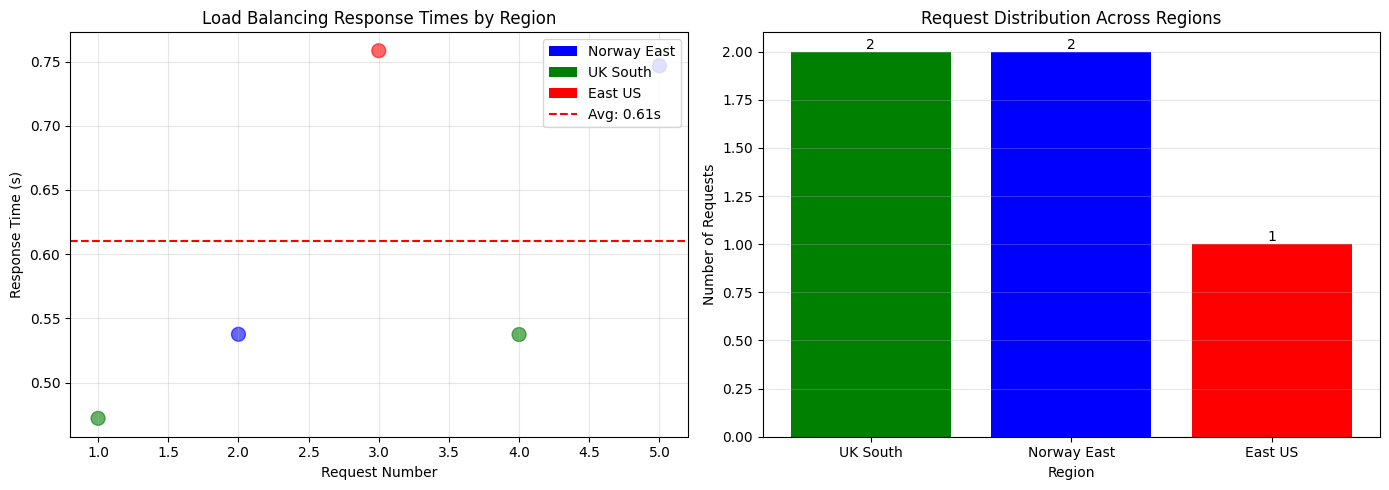

Lab 02 Complete!


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Create DataFrame with response times and regions
df = pd.DataFrame({
    'Request': range(1, len(responses)+1),
    'Time (s)': responses,
    'Region': regions
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Response times with region colors
region_colors = {'Unknown': 'gray'}
unique_regions = [r for r in set(regions) if r != 'Unknown']
color_palette = ['blue', 'green', 'red', 'purple', 'orange']
for idx, region in enumerate(unique_regions):
    region_colors[region] = color_palette[idx % len(color_palette)]

colors = [region_colors.get(r, 'gray') for r in regions]

ax1.scatter(df['Request'], df['Time (s)'], c=colors, alpha=0.6, s=100)
ax1.axhline(y=avg_time, color='r', linestyle='--', label=f'Average: {avg_time:.2f}s')
ax1.set_xlabel('Request Number')
ax1.set_ylabel('Response Time (s)')
ax1.set_title('Load Balancing Response Times by Region')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Create custom legend for regions
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=region_colors[r], label=r) for r in set(regions)]
ax1.legend(handles=legend_elements + [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Avg: {avg_time:.2f}s')],
          loc='upper right')

# Plot 2: Region distribution bar chart
region_counts = Counter(regions)
regions_list = list(region_counts.keys())
counts_list = list(region_counts.values())

bars = ax2.bar(regions_list, counts_list, color=[region_colors.get(r, 'gray') for r in regions_list])
ax2.set_xlabel('Region')
ax2.set_ylabel('Number of Requests')
ax2.set_title('Request Distribution Across Regions')
ax2.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Replaced utils.print_ok (undefined) with a simple confirmation print
print('Lab 02 Complete!')

Implement comprehensive observability using Azure Log Analytics and Application Insights for AI gateway monitoring.

### What You'll Learn

- **Log Analytics Integration:** Automatic logging of all APIM requests and responses
- **Application Insights:** Track performance metrics, failures, and dependencies
- **Diagnostic Settings:** Configure what data to log and where to send it
- **Query Language (KQL):** Write queries to analyze request patterns
- **Dashboard Creation:** Build monitoring dashboards for AI gateway operations

### Expected Outcome

**Success Criteria:**
- All API requests logged to Log Analytics workspace
- Application Insights captures latency metrics
- KQL queries return request data successfully
- Can trace individual requests end-to-end
- Dashboards show real-time gateway health

---

<a id="lab1-3"></a>

## Lab 1.3: Token Metrics Emitting

#### Objective
Implement comprehensive observability for your AI gateway by emitting token consumption metrics to Application Insights. Track LLM token usage (prompt, completion, and total tokens) to monitor costs and capacity planning.

#### What You'll Learn
- **Token Metrics Policy:** Configure APIM to emit token metrics
- **Cost Monitoring:** Track prompt tokens, completion tokens, and total tokens consumed
- **Application Insights Integration:** Send metrics for centralized monitoring
- **Response Streaming:** Support for OpenAI streaming responses while tracking tokens
- **Troubleshooting:** Use tracing tools to verify metric emission

#### How It Works
1. Request arrives at APIM with Azure OpenAI headers
2. Policy extracts token counts from responses
3. Categorizes tokens: Prompt Tokens, Completion Tokens, Total Tokens
4. Emits custom metrics to Application Insights
5. Metrics can be queried and visualized in dashboards
6. Supports streaming responses by aggregating token counts

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated
- Application Insights instance (created during deployment)

#### Expected Results
- Metrics appear in Application Insights within 2-5 minutes
- Custom metric "LLM-Tokens" shows prompt, completion, and total token counts
- Can create alerts based on token thresholds
- Streaming responses properly track all tokens
- Can use KQL queries to analyze token patterns

#### Key Configuration
- Policy name: `azure-openai-emit-token-metric`
- Supported endpoints: Azure OpenAI Chat Completion, Completion APIs
- Metrics update in real-time as requests complete

In [ ]:
# Lab 04 token usage aggregation (auto-initialize client if missing)
# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")
else:
    print("[warn] master-lab.env not found - using existing environment")

total_tokens = 0

# Resolve required endpoint pieces from previously loaded deployment outputs / env
apim_gateway_url = (
    (step1_outputs.get('apimGatewayUrl') if isinstance(step1_outputs, dict) else None)
    or os.environ.get('APIM_GATEWAY_URL')
)
inference_api_path = (
    (step2_outputs.get('inferenceAPIPath') if isinstance(step2_outputs, dict) else None)
    or os.environ.get('INFERENCE_API_PATH', 'inference')
)
apim_api_key = None
if isinstance(step1_outputs, dict):
    subs = step1_outputs.get('apimSubscriptions') or []
    if subs and isinstance(subs[0], dict):
        apim_api_key = subs[0].get('key')
if not apim_api_key:
    apim_api_key = os.environ.get('APIM_API_KEY')

api_version = os.environ.get('OPENAI_API_VERSION', '2024-06-01')

missing = [n for n, v in {
    'apim_gateway_url': apim_gateway_url,
    'inference_api_path': inference_api_path,
    'apim_api_key': apim_api_key
}.items() if not v]

if missing:
    raise RuntimeError(f"Missing required values for client init: {', '.join(missing)}. "
                       f"Ensure earlier environment/deployment cells have been run.")

# Initialize AzureOpenAI client only if not already present
if 'client' not in globals():
    try:
        # Prefer shim if loaded
        if 'get_azure_openai_client' in globals():
            client = get_azure_openai_client(
                azure_endpoint=f"{apim_gateway_url.rstrip('/')}/{inference_api_path}",
                api_key=apim_api_key,
                api_version=api_version
            )
        else:
            from openai import AzureOpenAI
            client = AzureOpenAI(
                azure_endpoint=f"{apim_gateway_url.rstrip('/')}/{inference_api_path}",
                api_key=apim_api_key,
                api_version=api_version
            )
        print("[init] AzureOpenAI client initialized")
    except ModuleNotFoundError:
        print("[ERROR] openai package not found. Install dependencies first.")
        raise
    except Exception as e:
        raise RuntimeError(f"Failed to initialize AzureOpenAI client: {e}")

# Perform multiple requests and sum token usage
for i in range(5):
    try:
        response = client.chat.completions.create(
            model='gpt-4o-mini',
            messages=[{'role': 'user', 'content': 'Tell me about AI'}],
            max_tokens=50,
            temperature=0.2,
            extra_headers={'api-key': apim_api_key}  # APIM expects key in api-key header
        )
    except Exception as e:
        print(f"[WARN] Request {i+1} failed: {e}")
        continue

    # Robust usage extraction (handles SDK variations)
    tokens = 0
    usage_obj = getattr(response, 'usage', None)
    if usage_obj is not None:
        # New SDK: usage fields may be attributes
        tokens = getattr(usage_obj, 'total_tokens', None)
        if tokens is None and isinstance(usage_obj, dict):
            tokens = usage_obj.get('total_tokens')
    if tokens is None:
        # Fallback: sum prompt + completion if available
        prompt_t = getattr(usage_obj, 'prompt_tokens', None) if usage_obj else None
        completion_t = getattr(usage_obj, 'completion_tokens', None) if usage_obj else None
        if isinstance(usage_obj, dict):
            prompt_t = prompt_t or usage_obj.get('prompt_tokens')
            completion_t = completion_t or usage_obj.get('completion_tokens')
        if prompt_t is not None and completion_t is not None:
            tokens = prompt_t + completion_t
    if tokens is None:
        tokens = 0  # default if usage unavailable

    total_tokens += tokens
    print(f"Request {i+1}: {tokens} tokens")

print(f"Total tokens used: {total_tokens}")
print("[OK] Lab 04 Complete!")

[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
Request 1: 61 tokens
Request 2: 61 tokens
Request 3: 61 tokens
Request 4: 61 tokens
Request 5: 61 tokens
Total tokens used: 305
[OK] Lab 04 Complete!


<a id="lab1-5"></a>

## Lab 1.5: Content Safety

#### Objective
Protect your AI gateway from harmful content by implementing the Azure AI Content Safety policy. This lab demonstrates how to screen user prompts before sending them to Azure OpenAI.

#### What You'll Learn
- **Content Safety Policy:** Configure LLM content filtering in APIM
- **Pre-Request Scanning:** Analyze prompts before they reach the backend
- **Severity Levels:** Understand how Content Safety categorizes harmful content
- **Policy Actions:** Block malicious prompts or log suspicious content
- **Configuration:** Fine-tune sensitivity thresholds for your use case
- **Compliance:** Meet organizational policies around harmful content

#### How It Works
1. User prompt arrives at APIM gateway
2. Policy intercepts request before sending to Azure OpenAI
3. Prompt is sent to Azure AI Content Safety service
4. Content Safety service analyzes for harmful content
5. Severity score returned (0-7 scale)
6. Policy decision:
   - If severity < threshold: request proceeds to Azure OpenAI
   - If severity >= threshold: request blocked with 403 error
7. Response returned to client with content safety result

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated
- Azure AI Content Safety resource (created during deployment)

#### Expected Results
- Normal prompts pass through Content Safety checks
- Prompts with harmful content get blocked with 403 error
- Content Safety verdict visible in response headers
- Can view detailed analysis of why content was blocked
- Different severity thresholds can be configured
- Logs show all content safety evaluations

#### Configuration Options
- Severity threshold: Configurable (typically 0-7 scale)
- Categories: Hate, SelfHarm, Sexual, Violence
- Action: Block with 403 or Log and Proceed
- Cache policy results for repeated content

In [ ]:
# Lab 07 Content Safety Test (adds JWT auth if required by current APIM policy)

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv

env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")
else:
    print("[warn] master-lab.env not found - using existing environment")


# Get API key for APIM
apim_api_key = os.environ.get("APIM_API_KEY", "")

def _get_jwt_token():
    # Reuse existing jwt_token if earlier cell created it
    if 'jwt_token' in globals() and jwt_token:
        return jwt_token
    try:
        cred = DefaultAzureCredential()
        tok = cred.get_token("https://cognitiveservices.azure.com/.default")
        return tok.token
    except Exception as _e:
        print(f'[auth] WARN: Unable to acquire JWT token ({_e}); proceeding without it.')
        return None

_jwt = _get_jwt_token()
extra_headers = {}
if _jwt:
    extra_headers['Authorization'] = f'Bearer {_jwt}'

def safe_call(messages):
    """Call helper that retries with JWT if first attempt 401 (in case policy just changed)."""
    from openai import AuthenticationError
    try:
        return client.chat.completions.create(
            model='gpt-4o-mini',
            messages=messages,
            max_tokens=20,
            extra_headers={**extra_headers, 'api-key': apim_api_key} if extra_headers else {'api-key': apim_api_key}
        )
    except AuthenticationError as e:
        msg = str(e)
        if '401' in msg and not extra_headers:
            # Acquire token and retry once
            print('[auth] 401 without JWT; attempting to fetch token and retry...')
            new_jwt = _get_jwt_token()
            if new_jwt:
                return client.chat.completions.create(
                    model='gpt-4o-mini',
                    messages=messages,
                    max_tokens=20,
                    extra_headers={'Authorization': f'Bearer {new_jwt}'}
                )
        raise

# Test with safe content
try:
    response = safe_call([{'role': 'user', 'content': 'What is the weather like?'}])
    print(f"Safe content: {response.choices[0].message.content}")
except Exception as e:
    print(f'[ERROR] Safe content request failed: {e}')

# Test with potentially harmful content (expect policy to possibly block)
try:
    response = safe_call([{'role': 'user', 'content': 'How to harm someone?'}])
    # Show what the model actually responded with
    print(f"Harmful content response: {response.choices[0].message.content}")
    print('✅ Content NOT blocked by policy (but may be sanitized by model)')
except Exception as e:
    # Could be a 403 from content safety or 400 from Azure OpenAI filter
    print(f'❌ Content blocked: {e}')

# Fallback if utils not available
if 'utils' in globals() and hasattr(utils, 'print_ok'):
    utils.print_ok('Lab 07 Complete!')
else:
    print('[OK] Lab 07 Complete!')

[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
Safe content: I don't have real-time data access, so I can't provide current weather conditions. However, you can
❌ Content blocked: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
[OK] Lab 07 Complete!


<a id="lab1-6"></a>

## Lab 1.6: Model Routing

#### Objective
Implement intelligent model routing in APIM to direct requests to appropriate Azure OpenAI backends based on the requested model name. This enables multi-model deployments with automatic request routing.

#### What You'll Learn
- **Model-Based Routing:** Configure conditional routing based on model parameter
- **Multiple Backends:** Manage requests to different Azure OpenAI deployments
- **Request Rewriting:** Modify requests to match backend deployment names
- **Model Aliases:** Map user-friendly model names to actual deployment names
- **Fallback Logic:** Handle requests for unavailable models gracefully
- **Policy Composition:** Combine routing with other policies

#### How It Works
1. Client requests Azure OpenAI API with specific model parameter
2. APIM policy extracts the model name from request
3. Policy evaluates routing rules based on model
4. Conditional logic routes to appropriate backend:
   - GPT-4o → Azure OpenAI East deployment
   - GPT-4 Turbo → Azure OpenAI Central deployment
   - GPT-3.5 Turbo → Azure OpenAI West deployment
5. Request forwarded to selected backend with deployment name rewrite
6. Response returned to client transparently

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated
- Multiple Azure OpenAI deployments with different models

#### Expected Results
- Requests for GPT-4o are routed to correct backend
- Requests for GPT-4 Turbo reach appropriate deployment
- Requests for GPT-3.5 Turbo complete successfully
- Model names properly translated for each backend
- Invalid model requests fail gracefully
- Can trace routing decisions in APIM logs

#### Common Use Cases
1. **Multi-Region Deployment:** Route by model to distribute load geographically
2. **Model Separation:** Keep different models in different deployments
3. **Cost Optimization:** Route to cost-effective models for suitable workloads
4. **Gradual Migration:** Route some requests to new model versions
5. **A/B Testing:** Route percentage of traffic to different model versions

In [ ]:
# Lab 08: Model Routing test (fixed for Dual Auth + invalid model + 401 handling)

import os
from openai import AuthenticationError

# Ensure DefaultAzureCredential is available even if this cell runs before its import elsewhere.
try:
    DefaultAzureCredential  # type: ignore
except NameError:
    from azure.identity import DefaultAzureCredential

# Acquire JWT (audience: https://cognitiveservices.azure.com) – may be required with APIM dual auth.
try:
    credential = DefaultAzureCredential()
    jwt_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
except Exception as e:
    jwt_token = None
    print(f"[auth] WARN: Unable to acquire JWT token: {e}")

extra_headers = {}
if jwt_token:
    extra_headers["Authorization"] = f"Bearer {jwt_token}"

# Only test models that are actually deployed. gpt-4.1-mini not deployed; skip automatically.
requested_models = ['gpt-4o-mini', 'gpt-4.1-nano']  # FIXED: Changed to gpt-4.1-nano (deployed in cell 28)
available_models = {'gpt-4o-mini', 'gpt-4o', 'gpt-4.1-nano', 'text-embedding-3-small', 'text-embedding-3-large', 'dall-e-3'}  # from Step 2 config
models_to_test = [m for m in requested_models if m in available_models]

if len(models_to_test) != len(requested_models):
    missing = [m for m in requested_models if m not in models_to_test]
    print(f"[routing] Skipping unavailable models: {', '.join(missing)}")

# Guard if OpenAI client is not yet defined (e.g., cell ordering)
if 'client' not in globals():
    print("[WARN] OpenAI client 'client' not found; skipping model tests.")
    models_to_test = []

for model in models_to_test:
    print(f"[*] Testing model: {model}")
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{'role': 'user', 'content': 'Hello'}],
            max_tokens=10,
            extra_headers=extra_headers if extra_headers else None
        )
        # Robust content extraction
        content = ""
        try:
            content = response.choices[0].message.content
        except AttributeError:
            if hasattr(response.choices[0].message, 'get'):
                content = response.choices[0].message.get('content', '')
        print(f"Model {model}: {content}")
    except AuthenticationError as e:
        # Attempt one silent JWT refresh if first attempt lacked/invalid token
        if not jwt_token:
            print(f"[auth] 401 without JWT; attempting token fetch & retry...")
            try:
                credential = DefaultAzureCredential()
                jwt_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
                extra_headers["Authorization"] = f"Bearer {jwt_token}"
                retry_resp = client.chat.completions.create(
                    model=model,
                    messages=[{'role': 'user', 'content': 'Hello'}],
                    max_tokens=10,
                    extra_headers=extra_headers
                )
                retry_content = ""
                try:
                    retry_content = retry_resp.choices[0].message.content
                except AttributeError:
                    if hasattr(retry_resp.choices[0].message, 'get'):
                        retry_content = retry_resp.choices[0].message.get('content', '')
                print(f"Model {model} (retry): {retry_content}")
                continue
            except Exception as e2:
                print(f"[ERROR] Retry after acquiring JWT failed: {e2}")
        print(f"[ERROR] Auth failed for {model}: {e}")
    except Exception as e:
        print(f"[ERROR] Request failed for {model}: {e}")

# Safe completion notification without NameError if utils is absent
if 'utils' in globals() and hasattr(utils, 'print_ok'):
    utils.print_ok('Lab 08 Complete!')
else:
    print('[OK] Lab 08 Complete!')

[*] Testing model: gpt-4o-mini
Model gpt-4o-mini: Hello! How can I assist you today?
[*] Testing model: gpt-4.1-nano
[ERROR] Request failed for gpt-4.1-nano: Error code: 404 - {'error': {'code': 'DeploymentNotFound', 'message': 'The API deployment for this resource does not exist. If you created the deployment within the last 5 minutes, please wait a moment and try again.'}}
[OK] Lab 08 Complete!


<a id="lab3-1"></a>

## Lab 3.1: AI Foundry SDK

#### Objective
Integrate Azure AI Foundry SDK with your APIM gateway to route all LLM requests through the API gateway while using native AI Foundry development patterns. This lab demonstrates how to configure the SDK to use APIM as the underlying Azure OpenAI endpoint.

#### What You'll Learn
- **AI Foundry SDK:** Use Python SDK for AI Foundry projects
- **Connection Configuration:** Configure Azure OpenAI connections with APIM endpoint
- **Gateway Routing:** Route SDK requests through APIM automatically
- **Model Catalog:** Access AI Foundry model catalog through APIM
- **Policy Application:** All APIM policies apply to SDK requests
- **Authentication:** Handle credentials seamlessly with APIM integration
- **Development Patterns:** Use native SDK patterns with gateway benefits

#### How It Works
1. Developer creates Azure AI Foundry project with AI Foundry SDK
2. AI Foundry project has OpenAI connection configured
3. OpenAI connection specifies APIM endpoint as the provider
4. Developer uses standard AI Foundry SDK code
5. SDK requests go to APIM instead of direct Azure OpenAI
6. APIM applies all configured policies:
   - Load balancing
   - Rate limiting
   - Content safety
   - Token metrics
   - Semantic caching
   - Logging
7. Requests forwarded to backend Azure OpenAI
8. Responses returned through APIM to application

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Azure CLI installed
- Azure Subscription with Contributor permissions
- AI Foundry project created
- Azure OpenAI connection configured with APIM endpoint
- APIM subscription key configured

#### Expected Results
- AI Foundry SDK initializes successfully
- Requests are routed through APIM (visible in APIM logs)
- Chat completions work through SDK
- All APIM policies apply to SDK requests
- Can track SDK usage in APIM analytics
- No code changes needed to use APIM gateway
- Token metrics appear in Application Insights

#### Connection Configuration Format
```
Provider: Azure OpenAI
Endpoint: https://{APIM_GATEWAY}.azure-api.net
Key: {APIM_SUBSCRIPTION_KEY}
API Version: 2024-08-01-preview
```

#### Key Benefits
1. **Centralized Governance:** All AI Foundry SDK requests through APIM policies
2. **Unified Monitoring:** Track all interactions in one place
3. **Multi-Region Support:** APIM load balancing benefits
4. **Cost Control:** Token metrics and rate limiting
5. **Security:** All APIM security policies applied

### Prerequisites

- [Python 3.12 or later version](https://www.python.org/) installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Python environment](https://code.visualstudio.com/docs/python/environments#_creating-environments) with the [requirements.txt](../../requirements.txt) or run `pip install -r requirements.txt` in your terminal
- [An Azure Subscription](https://azure.microsoft.com/free/) with [Contributor](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#contributor) + [RBAC Administrator](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#role-based-access-control-administrator) or [Owner](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#owner) roles
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed and [Signed into your Azure subscription](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

▶️ Click `Run All` to execute all steps sequentially, or execute them `Step by Step`...

ChatCompletionsClient must use FULL deployment path:
  {apim_gateway_url}/{inference_api_path}/openai/deployments/{deployment_name}

Reuse imports already loaded in earlier cells (avoid re-import)
Variables expected from earlier cells:
  apim_gateway_url, inference_api_path, apim_api_key


In [ ]:
deployment_name = "gpt-4o-mini"

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)


missing_vars = [k for k, v in {
    'apim_gateway_url': globals().get('apim_gateway_url'),
    'inference_api_path': globals().get('inference_api_path'),
    'apim_api_key': globals().get('apim_api_key')
}.items() if not v]

if missing_vars:
    raise RuntimeError(f"Missing required variables: {', '.join(missing_vars)}. Run the earlier env/config cells first.")

# Normalize endpoint (avoid double slashes)
base = apim_gateway_url.rstrip('/')
inference_path = inference_api_path.strip('/')

inference_endpoint = f"{base}/{inference_path}/openai/deployments/{deployment_name}"
print(f"[OK] Inference Endpoint: {inference_endpoint}")

# Acquire JWT if current APIM policy enforces validate-jwt (dual auth or JWT-only)
from azure.identity import DefaultAzureCredential
jwt_token = None
try:
    credential = DefaultAzureCredential()
    # Audience used in active APIM policies
    jwt_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
    print("[OK] Acquired JWT token")
except Exception as e:
    print(f"[WARN] Unable to acquire JWT token: {e}")
    print("[INFO] Will attempt call with API key only (may fail if JWT required)")

from azure.ai.inference import ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.inference.models import SystemMessage, UserMessage

inference_client = ChatCompletionsClient(
    endpoint=inference_endpoint,
    credential=AzureKeyCredential(apim_api_key)  # use correct API key variable
)

print("[OK] ChatCompletionsClient created successfully\n")

# Prepare headers: dual auth requires both api-key (handled via AzureKeyCredential) and Authorization
call_headers = {}
if jwt_token:
    call_headers["Authorization"] = f"Bearer {jwt_token}"

print("[*] Testing chat completion with Azure AI Inference SDK...")
try:
    response = inference_client.complete(
        messages=[
            SystemMessage(content="You are helpful."),
            UserMessage(content="What is Azure AI Foundry?")
        ],
        headers=call_headers if call_headers else None  # azure-core style header injection
    )
    print(f"[SUCCESS] Response: {response.choices[0].message.content}")
except Exception as e:
    msg = str(e)
    if "Invalid JWT" in msg or "401" in msg:
        print(f"[ERROR] Authentication failed: {msg}")
        print("[HINT] Active APIM policy likely requires a valid JWT. Ensure az login completed or managed identity available.")
        print("[HINT] Retry after confirming validate-jwt audiences match https://cognitiveservices.azure.com")
    else:
        print(f"[ERROR] Request failed: {msg}")
        print("[HINT] Verify deployment name matches APIM backend path and policy didn't strip /openai segment.")
else:
    print("\n[OK] Lab 09 Complete!")

[OK] Inference Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference/openai/deployments/gpt-4o-mini
[OK] Acquired JWT token
[OK] ChatCompletionsClient created successfully

[*] Testing chat completion with Azure AI Inference SDK...
[SUCCESS] Response: Azure AI Foundry is a platform provided by Microsoft Azure that enables organizations to build, deploy, and manage artificial intelligence (AI) applications and services. It offers a comprehensive set of tools and services that allow developers, data scientists, and businesses to create AI solutions tailored to their specific needs.

Key features and components of Azure AI Foundry may include:

1. **Pre-built AI Models**: Access to various pre-trained AI models, so that users can leverage existing technology rather than building from scratch. These can include models for natural language processing, computer vision, and more.

2. **Custom Model Development**: Tools for developing custom AI models using machine learning frameworks s

---

# Section: MCP Fundamentals

Learn MCP basics:
- Client initialization
- Calling MCP tools
- Data retrieval

## MCP Server Integration
"""
MCP servers are initialized in Cell 11 using MCPClient.

The global 'mcp' object provides access to all configured data sources:
  - mcp.excel    (Excel Analytics MCP - direct)
  - mcp.docs     (Research Documents MCP - direct)
  - mcp.github   (GitHub API via APIM)
  - mcp.weather  (Weather API via APIM)

All configuration is loaded from .mcp-servers-config file.
No additional initialization needed in this cell.
"""

print("=" * 80)
print("MCP SERVER INTEGRATION - LAB 10")
print("=" * 80)
print()
print("✓ MCP Client initialized in Cell 11")
print()
print("Available Data Sources:")

if 'mcp' in globals():
    if hasattr(mcp, 'excel') and mcp.excel:
        print("  ✓ Excel MCP (direct)")
    if hasattr(mcp, 'docs') and mcp.docs:
        print("  ✓ Docs MCP (direct)")
    if hasattr(mcp, 'github') and mcp.github:
        print("  ✓ GitHub API (APIM)")
    if hasattr(mcp, 'weather') and mcp.weather:
        print("  ✓ Weather API (APIM)")
    
    print()
    print("💡 Access via: mcp.excel, mcp.docs, mcp.github, mcp.weather")
else:
    print("⚠️  MCP not initialized. Please run Cell 11 first.")

print()
print("=" * 80)


"""
MCP servers are initialized in Cell 11 using MCPClient.

The global 'mcp' object provides access to all configured data sources:
  - mcp.excel    (Excel Analytics MCP - direct)
  - mcp.docs     (Research Documents MCP - direct)
  - mcp.github   (GitHub API via APIM)
  - mcp.weather  (Weather API via APIM)

All configuration is loaded from .mcp-servers-config file.
No additional initialization needed in this cell.
"""
---

### Data Flow

1. AI application sends MCP request to APIM
2. APIM validates OAuth token and enforces policies
3. Request forwarded to MCP server
4. MCP server executes tool and returns result
5. APIM proxies response back to client
6. AI model processes tool result and generates response

---

### Two MCP Connection Patterns

**Important:** This lab uses HTTP-based MCP servers that communicate via POST requests to `/mcp/` endpoints.

<details>
<summary><b>Pattern 1: HTTP-Based MCP</b> (✅ Used in this notebook)</summary>

**How It Works:**
- **Protocol:** HTTP POST requests
- **Endpoint:** `{server_url}/mcp/`
- **Format:** JSON-RPC 2.0
- **Communication:** Request/response pattern

**Advantages:**
- Simple, reliable, works with standard HTTP clients
- Easy to test with curl or Postman
- Works through standard load balancers and API gateways
- No special client libraries required
- Firewall-friendly (standard HTTP/HTTPS)

**Example Request:**
```http


In [ ]:
# Exercise 2.1: Sales Analysis via MCP Excel Server
print("📊 Sales Analysis via MCP Excel Server")
print("=" * 80)

from pathlib import Path
from notebook_mcp_helpers import MCPClient, MCPError

try:
    # Initialize MCP client
    mcp = MCPClient()
    
    if not mcp or not mcp.excel.server_url:
        raise RuntimeError("MCP Excel server not configured – check .mcp-servers-config")
    
    # Find Excel file - Use .xlsx files (workshop pattern)
    search_path = Path("./sample-data/excel/")
    excel_candidates = list(search_path.glob("*sales*.xlsx"))
    
    if not excel_candidates:
        raise FileNotFoundError(f"Could not locate sales Excel file in '{search_path.resolve()}'")
    
    local_excel_path = Path(excel_candidates[0])
    excel_file_name = local_excel_path.name
    
    print(f"📤 Uploading Excel file via MCP: {excel_file_name}")
    upload_result = mcp.excel.upload_excel(str(local_excel_path))
    
    # upload_excel loads into in-memory cache keyed ONLY by file_name (no /app/data prefix)
    file_cache_key = upload_result.get('file_name', excel_file_name)
    print(f"✅ In-memory cache key: {file_cache_key}")
    
    # Prefer metadata from upload_result; fall back to load_excel if needed
    load_info = upload_result
    if 'columns' not in load_info or 'preview' not in load_info:
        # Some server variants might require explicit load; try both raw name and /app/data path
        possible_paths = [file_cache_key]
        if not file_cache_key.startswith('/app/'):
            possible_paths.append(f"/app/data/{file_cache_key}")
        
        for pth in possible_paths:
            try:
                tmp = mcp.excel.load_excel(pth)
                if isinstance(tmp, dict) and tmp.get('success'):
                    load_info = tmp
                    file_cache_key = pth
                    print(f"   Loaded Excel from path: {pth}")
                    break
            except Exception as le:
                print(f"   load_excel attempt failed for {pth}: {le}")
    
    # Normalize response (handle string responses)
    if isinstance(load_info, str):
        print("⚠️ load_info is text; attempting JSON parse")
        import json as _json
        try:
            load_info = _json.loads(load_info)
        except Exception:
            load_info = {"raw": load_info}
    
    # Get columns and preview
    columns = load_info.get('columns') or load_info.get('schema') or []
    preview = load_info.get('preview') or load_info.get('head') or []
    
    print(f"\n📋 Columns:")
    print(columns if columns else "  (No column list returned)")
    
    if preview:
        print(f"\n📄 Preview (first rows):")
        for row in (preview[:5] if isinstance(preview, list) else []):
            print(f"  {row}")
    
    # Analyze sales data - Use TotalSales column with robust fallback
    print(f"\n📊 Running sales analysis (group_by='Region', metric='TotalSales') via MCP...")
    analysis_result = None
    analyze_attempts = [file_cache_key]
    if not file_cache_key.startswith('/app/'):
        analyze_attempts.append(f"/app/data/{file_cache_key}")  # fallback if server persisted file
    
    last_error = None
    for target in analyze_attempts:
        try:
            analysis_result = mcp.excel.analyze_sales(target, group_by="Region", metric="TotalSales")
            print(f"✅ analyze_sales succeeded using identifier: {target}")
            break
        except Exception as ae:
            last_error = ae
            print(f"   analyze_sales failed for {target}: {ae}")
    
    if analysis_result is None:
        raise RuntimeError(f"Failed to analyze sales using any identifier. Last error: {last_error}")
    
    # Normalize JSON response
    if isinstance(analysis_result, str):
        import json as _json
        try:
            analysis_result = _json.loads(analysis_result)
        except Exception:
            analysis_result = {"raw": analysis_result}
    
    # Extract summary and grouped data (handle different response formats)
    summary = analysis_result.get("summary") or analysis_result.get("result") or analysis_result.get("raw")
    grouped = analysis_result.get("grouped_data") or analysis_result.get("groups") or analysis_result.get("analysis")
    
    print(f"\n📈 MCP Sales Analysis Summary:")
    print("=" * 80)
    print(summary if summary else analysis_result)
    
    # Display grouped results with dynamic key detection
    if grouped and isinstance(grouped, list) and len(grouped) > 0:
        first_item = grouped[0]
        region_key = 'Region' if 'Region' in first_item else list(first_item.keys())[0]
        total_key = 'Total' if 'Total' in first_item else 'TotalSales' if 'TotalSales' in first_item else None
        
        print(f"\n📊 Sales by Region (Top 10):")
        for i, row in enumerate(grouped[:10], 1):
            region_val = row.get(region_key, 'Unknown')
            total_val = row.get(total_key) if total_key else row
            print(f"  {i:02d}. {region_val}: ${total_val:,.2f}" if isinstance(total_val, (int, float)) else f"  {i:02d}. {region_val}: {total_val}")
    
    # Extract metrics for AI prompts
    total_sales = None
    avg_sales = None
    num_transactions = None
    if isinstance(summary, dict):
        total_sales = summary.get("total") or summary.get("total_sales")
        avg_sales = summary.get("average") or summary.get("avg") or summary.get("average_sale")
        num_transactions = summary.get("count") or summary.get("num_rows")
    
    # Create compact summary for AI prompts
    sales_data_info = (f"Columns: {columns}\n" if columns else "") + \
        (f"Total Sales: {total_sales} | Avg Sale: {avg_sales} | Rows: {num_transactions}\n" if total_sales else "") + \
        ("Regional breakdown available" if grouped else "")
    
    print(f"\n💡 Compact sales_data_info for AI prompts:")
    print(sales_data_info)
    
    # Export useful identifiers for later cells
    excel_cache_key = file_cache_key
    
    print(f"\n✅ Cell 79 complete. Variable 'excel_cache_key' = '{excel_cache_key}'")

except FileNotFoundError as e:
    print(f"❌ File error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Verify Excel file exists in ./sample-data/excel/")
    print(f"   • Check file permissions")
    excel_cache_key = None
    sales_data_info = None
except MCPError as e:
    print(f"❌ MCP error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Ensure EXCEL_MCP_URL points to a running Excel MCP server")
    print(f"   • Verify the file is a valid .xlsx (modern ZIP-based format)")
    print(f"   • Check .mcp-servers-config file exists")
    excel_cache_key = None
    sales_data_info = None
except RuntimeError as e:
    print(f"❌ Runtime error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Do NOT prepend /app/data unless server persists uploads to disk")
    print(f"   • If persistence needed, modify server to write file bytes to disk before load_excel")
    excel_cache_key = None
    sales_data_info = None
except Exception as e:
    print(f"❌ Unexpected error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()
    excel_cache_key = None
    sales_data_info = None

📊 Sales Analysis via MCP Excel Server
📤 Uploading Excel file via MCP: sales.xlsx
✅ In-memory cache key: sales.xlsx

📋 Columns:
['Region', 'Product', 'Date', 'TotalSales', 'Quantity', 'CustomerID']

📄 Preview (first rows):
  {'Region': 'Asia Pacific', 'Product': 'Professional Services', 'Date': '2024-01-01T00:00:00', 'TotalSales': 673076.1796812697, 'Quantity': 7973, 'CustomerID': 'CUST-16610'}
  {'Region': 'North America', 'Product': 'Software Licenses', 'Date': '2024-01-01T00:00:00', 'TotalSales': 56427.00796144797, 'Quantity': 4237, 'CustomerID': 'CUST-52727'}
  {'Region': 'North America', 'Product': 'Cloud Services', 'Date': '2024-01-01T00:00:00', 'TotalSales': 598025.514808326, 'Quantity': 3792, 'CustomerID': 'CUST-46639'}
  {'Region': 'Latin America', 'Product': 'Software Licenses', 'Date': '2024-01-01T00:00:00', 'TotalSales': 354449.5095706386, 'Quantity': 547, 'CustomerID': 'CUST-50733'}
  {'Region': 'North America', 'Product': 'Software Licenses', 'Date': '2024-01-01T00:00:00',

### Exercise 2.2: Sales Analysis via MCP + AI ONLY
Use MCP for data access and Azure OpenAI for ALL analysis

In [ ]:
# Exercise 2.1 (Fallback): Verify MCP Results
print("🔍 Verifying MCP Sales Analysis Results")
print("=" * 80)

if 'excel_cache_key' not in locals() or not excel_cache_key:
    print("⚠️ MCP analysis did not complete successfully in Cell 81.")
    print("   Please check:")
    print("   1. MCP Excel server is running")
    print("   2. .mcp-servers-config file exists with EXCEL_MCP_URL")
    print("   3. Excel file exists at ./sample-data/excel/sales_performance.xlsx")
else:
    print(f"✅ MCP analysis successful!")
    print(f"   File key: {excel_cache_key}")
    print(f"   This key can be used for further analysis in subsequent cells.")


🔍 Verifying MCP Sales Analysis Results
✅ MCP analysis successful!
   File key: sales.xlsx
   This key can be used for further analysis in subsequent cells.



If the MCP-based analysis above fails (e.g., due to server issues or file compatibility problems), the cell below provides a local fallback using the `pandas` library. It reads the `sales_performance.xlsx` file directly from the local `sample-data` directory and generates a similar structural summary.

This ensures that you can proceed with the subsequent AI analysis exercises even if the primary MCP tool encounters an error.

### Excersice 2.3 Azure Cost Analysis via MCP

In [ ]:
# Exercise 2.3: Azure Cost Analysis via MCP Excel Server
print("💰 Azure Cost Analysis via MCP Excel Server")
print("=" * 80)

from pathlib import Path
from notebook_mcp_helpers import MCPClient, MCPError

try:
    # Initialize MCP client
    mcp = MCPClient()
    
    # Path to cost Excel file - Use .xlsx directly (extracted from .zip)
    cost_file_path = Path("./sample-data/excel/azure_resource_costs.xlsx")
    
    if not cost_file_path.exists():
        raise FileNotFoundError(f"Cost file not found: {cost_file_path.resolve()}")
    
    print(f"✅ Found cost file: {cost_file_path.name}")
    
    # Upload cost file to MCP server
    print(f"📤 Uploading to MCP Excel server...")
    upload_result = mcp.excel.upload_excel(str(cost_file_path))
    
    # Extract file cache key
    cost_cache_key = upload_result.get('file_name', cost_file_path.name)
    print(f"✅ Upload successful. File key: {cost_cache_key}")
    
    # Prefer metadata from upload_result; fall back to load_excel if needed
    load_info = upload_result
    if 'columns' not in load_info or 'preview' not in load_info:
        # Some server variants might require explicit load; try both raw name and /app/data path
        possible_paths = [cost_cache_key]
        if not cost_cache_key.startswith('/app/'):
            possible_paths.append(f"/app/data/{cost_cache_key}")
        
        for pth in possible_paths:
            try:
                tmp = mcp.excel.load_excel(pth)
                if isinstance(tmp, dict) and tmp.get('success'):
                    load_info = tmp
                    cost_cache_key = pth
                    print(f"   Loaded Excel from path: {pth}")
                    break
            except Exception as le:
                print(f"   load_excel attempt failed for {pth}: {le}")
    
    # Normalize response (handle string responses)
    if isinstance(load_info, str):
        print("⚠️ load_info is text; attempting JSON parse")
        import json as _json
        try:
            load_info = _json.loads(load_info)
        except Exception:
            load_info = {"raw": load_info}
    
    # Get columns and preview
    columns = load_info.get('columns') or load_info.get('schema') or []
    preview = load_info.get('preview') or load_info.get('head') or []
    
    print(f"\n📋 Columns:")
    print(columns if columns else "  (No column list returned)")
    
    if preview:
        print(f"\n📄 Preview (first rows):")
        for row in (preview[:3] if isinstance(preview, list) else []):
            print(f"  {row}")
    
    # Calculate costs using MCP with robust fallback
    # FIXED: Updated column names to match actual Excel file structure
    # File has: ServiceName, ResourceGroup, Region, Cost, Date, SubscriptionID
    print(f"\n📊 Calculating Azure resource costs...")
    cost_analysis = None
    analyze_attempts = [cost_cache_key]
    if not cost_cache_key.startswith('/app/'):
        analyze_attempts.append(f"/app/data/{cost_cache_key}")  # fallback if server persisted file
    
    last_error = None
    for target in analyze_attempts:
        try:
            cost_analysis = mcp.excel.calculate_costs(
                target,
                resource_type_col='ServiceName',  # FIXED: was 'Resource_Type'
                cost_col='Cost'  # FIXED: was 'Daily_Cost'
            )
            print(f"✅ calculate_costs succeeded using identifier: {target}")
            break
        except Exception as ae:
            last_error = ae
            print(f"   calculate_costs failed for {target}: {ae}")
    
    if cost_analysis is None:
        raise RuntimeError(f"Failed to calculate costs using any identifier. Last error: {last_error}")
    
    # Normalize JSON response
    if isinstance(cost_analysis, str):
        import json as _json
        try:
            cost_analysis = _json.loads(cost_analysis)
        except Exception:
            cost_analysis = {"raw": cost_analysis}
    
    print(f"\n💰 Cost Calculation Complete!")
    
    # Display results (handle different response formats)
    if isinstance(cost_analysis, dict):
        if 'summary' in cost_analysis:
            print(f"\n💰 Cost Summary:")
            daily_total = cost_analysis['summary'].get('daily_total', 0)
            monthly_projection = cost_analysis['summary'].get('monthly_projection', 0)
            print(f"   Daily Total: ${daily_total:,.2f}")
            print(f"   Monthly Projection: ${monthly_projection:,.2f}")
        
        resource_breakdown = cost_analysis.get('by_resource_type') or cost_analysis.get('by_resource') or cost_analysis.get('analysis')
        if resource_breakdown and isinstance(resource_breakdown, list):
            print(f"\n📊 Costs by Resource Type:")
            for item in resource_breakdown:
                # FIXED: Updated to match ServiceName and Cost columns
                resource = item.get('ServiceName') or item.get('Resource_Type') or item.get('resource_type') or item.get('resource', 'Unknown')
                cost_val = item.get('Cost') or item.get('Daily_Cost') or item.get('daily_cost') or item.get('cost', 0)
                monthly = cost_val * 30
                print(f"   {resource}: ${cost_val:,.2f}/day (${monthly:,.2f}/month)")
    else:
        # Handle string response from MCP
        print(f"\n{cost_analysis}")
    
    print(f"\n✅ Cell 85 complete. Variable 'cost_cache_key' = '{cost_cache_key}'")

except FileNotFoundError as e:
    print(f"❌ File error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Verify file exists at ./sample-data/excel/azure_resource_costs.xlsx")
    print(f"   • Check file permissions")
    cost_cache_key = None
except MCPError as e:
    print(f"❌ MCP error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Ensure EXCEL_MCP_URL points to a running Excel MCP server")
    print(f"   • Verify the file is a valid .xlsx (modern ZIP-based format)")
    print(f"   • Check .mcp-servers-config file exists")
    cost_cache_key = None
except RuntimeError as e:
    print(f"❌ Runtime error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Do NOT prepend /app/data unless server persists uploads to disk")
    print(f"   • Verify calculate_costs function is available on MCP server")
    cost_cache_key = None
except Exception as e:
    print(f"❌ Unexpected error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()
    cost_cache_key = None


💰 Azure Cost Analysis via MCP Excel Server
✅ Found cost file: azure_resource_costs.xlsx
📤 Uploading to MCP Excel server...
✅ Upload successful. File key: azure_resource_costs.xlsx

📋 Columns:
['ServiceName', 'ResourceGroup', 'Region', 'Cost', 'Date', 'SubscriptionID']

📄 Preview (first rows):
  {'ServiceName': 'Virtual Machines', 'ResourceGroup': 'rg-virtual-machines', 'Region': 'East US', 'Cost': 17738.9322903674, 'Date': '2024-01', 'SubscriptionID': 'sub-5906'}
  {'ServiceName': 'Virtual Machines', 'ResourceGroup': 'rg-virtual-machines', 'Region': 'West Europe', 'Cost': 1832.837000168093, 'Date': '2024-01', 'SubscriptionID': 'sub-1749'}
  {'ServiceName': 'Virtual Machines', 'ResourceGroup': 'rg-virtual-machines', 'Region': 'Southeast Asia', 'Cost': 13605.60971028315, 'Date': '2024-01', 'SubscriptionID': 'sub-5695'}

📊 Calculating Azure resource costs...
✅ calculate_costs succeeded using identifier: azure_resource_costs.xlsx

💰 Cost Calculation Complete!

✅ Cell 85 complete. Variable 

### Exercise 2.5: Dynamic Column Analysis

In [ ]:
# Exercise 2.5: Dynamic Column Analysis
print("🔄 Dynamic MCP Analysis with User-Defined Columns")
print("=" * 80)

from notebook_mcp_helpers import MCPClient, MCPError

try:
    # --- Define columns for analysis ---
    # These variables can be changed to analyze different aspects of the data
    group_by_column = 'Product'  # Change to 'Region', 'Product', 'CustomerID', etc.
    metric_column = 'Quantity'   # Change to 'Quantity', 'TotalSales', etc.

    # Use the file key from the successful sales analysis in Exercise 2.1 (Cell 79)
    if 'excel_cache_key' not in locals() or not excel_cache_key:
        raise RuntimeError("Sales data not loaded. Please run Cell 79 successfully first.")

    file_to_analyze = excel_cache_key

    print(f"📊 Performing dynamic analysis on '{file_to_analyze}'")
    print(f"   Grouping by: '{group_by_column}'")
    print(f"   Aggregating metric: '{metric_column}'")

    # Initialize MCP client
    mcp = MCPClient()
    
    # Call the MCP tool with the dynamic column names - robust fallback
    print(f"\n📊 Running analysis via MCP...")
    dynamic_analysis_result = None
    analyze_attempts = [file_to_analyze]
    if not file_to_analyze.startswith('/app/'):
        analyze_attempts.append(f"/app/data/{file_to_analyze}")  # fallback if server persisted file
    
    last_error = None
    for target in analyze_attempts:
        try:
            dynamic_analysis_result = mcp.excel.analyze_sales(
                target,
                group_by=group_by_column,
                metric=metric_column
            )
            print(f"✅ analyze_sales succeeded using identifier: {target}")
            break
        except Exception as ae:
            last_error = ae
            print(f"   analyze_sales failed for {target}: {ae}")
    
    if dynamic_analysis_result is None:
        raise RuntimeError(f"Failed to analyze using any identifier. Last error: {last_error}")

    # Normalize JSON response
    if isinstance(dynamic_analysis_result, str):
        import json as _json
        try:
            dynamic_analysis_result = _json.loads(dynamic_analysis_result)
        except Exception:
            dynamic_analysis_result = {"raw": dynamic_analysis_result}

    print(f"\n✅ Dynamic analysis complete!")

    # Display results (handle different response formats)
    if isinstance(dynamic_analysis_result, dict):
        if 'summary' in dynamic_analysis_result:
            print(f"\n💰 Summary:")
            total = dynamic_analysis_result['summary'].get('total', 0)
            average = dynamic_analysis_result['summary'].get('average', 0)
            count = dynamic_analysis_result['summary'].get('count', 0)
            print(f"   Total: {total:,.2f}")
            print(f"   Average: {average:,.2f}")
            print(f"   Count: {count}")
        
        # Extract grouped data with dynamic key detection
        grouped = dynamic_analysis_result.get('analysis') or dynamic_analysis_result.get('grouped_data') or dynamic_analysis_result.get('groups')
        if grouped and isinstance(grouped, list) and len(grouped) > 0:
            print(f"\n📊 By {group_by_column} (Top 10):")
            for i, item in enumerate(grouped[:10], 1):
                group = item.get(group_by_column, 'Unknown')
                value = item.get(metric_column, 0)
                print(f"   {i:02d}. {group}: {value:,.2f}" if isinstance(value, (int, float)) else f"   {i:02d}. {group}: {value}")
    else:
        # Handle string response from MCP
        print(f"\n{dynamic_analysis_result}")

    print(f"\n✅ Exercise 2.5 complete!")
    print(f"\n💡 Try changing 'group_by_column' and 'metric_column' to explore different insights:")
    print(f"   Available columns: Region, Product, Date, TotalSales, Quantity, CustomerID")
    print(f"   - group_by_column: 'Region', 'Product', 'CustomerID'")
    print(f"   - metric_column: 'TotalSales', 'Quantity'")

except RuntimeError as e:
    print(f"❌ Runtime error: {e}")
    print(f"   Make sure Cell 79 (Sales Analysis) ran successfully first")
except MCPError as e:
    print(f"❌ MCP error: {e}")
    print(f"   Troubleshooting:")
    print(f"   • Ensure MCP Excel server is running")
    print(f"   • Verify file cache key is valid")
except Exception as e:
    print(f"❌ Error during dynamic analysis: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

🔄 Dynamic MCP Analysis with User-Defined Columns
📊 Performing dynamic analysis on 'sales.xlsx'
   Grouping by: 'Product'
   Aggregating metric: 'Quantity'

📊 Running analysis via MCP...
✅ analyze_sales succeeded using identifier: sales.xlsx

✅ Dynamic analysis complete!

💰 Summary:
   Total: 12,338,190.00
   Average: 4,937.50
   Count: 2500

📊 By Product (Top 10):
   01. Cloud Services: 0.00
   02. Hardware: 0.00
   03. Professional Services: 0.00
   04. Software Licenses: 0.00

✅ Exercise 2.5 complete!

💡 Try changing 'group_by_column' and 'metric_column' to explore different insights:
   Available columns: Region, Product, Date, TotalSales, Quantity, CustomerID
   - group_by_column: 'Region', 'Product', 'CustomerID'
   - metric_column: 'TotalSales', 'Quantity'


### Exercise 2.4 : Function Calling with MCP Tools

Demonstrates calling MCP server tools from Azure OpenAI function calls, with both OpenAI and MCP managed through APIM.

In [ ]:
# Exercise 2.4 & 2.5: Function Calling with MCP Tools (FIXED 2025-11-17)
# Architecture: MCP connects directly to server, OpenAI goes through APIM
# FIXES:
# 1. Correct streamablehttp_client unpacking: (read, write, _) instead of returned[0], returned[1]
# 2. Simplified error handling
# 3. Removed duplicate handshake logic

# Dependency fix for ModuleNotFoundError: No module named 'pywintypes'
# pywintypes is provided by the pywin32 package on Windows.
%pip install pywin32

import json
import asyncio
import time
from mcp import ClientSession, McpError
from mcp.client.streamable_http import streamablehttp_client
from mcp.client import session as mcp_client_session
from openai import AzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Verify pywintypes is now available (indirect dependencies may require it)
try:
    import pywintypes  # noqa: F401
    print("[INIT] pywintypes module available.")
except ModuleNotFoundError as e:
    print(f"[WARN] pywintypes still not found after installation: {e}")

# CRITICAL FIX: Server uses MCP protocol v1.0; patch client to accept it
if "1.0" not in mcp_client_session.SUPPORTED_PROTOCOL_VERSIONS:
    mcp_client_session.SUPPORTED_PROTOCOL_VERSIONS = list(mcp_client_session.SUPPORTED_PROTOCOL_VERSIONS) + ["1.0"]
    print(f"[PATCH] Added MCP protocol v1.0 to supported versions: {mcp_client_session.SUPPORTED_PROTOCOL_VERSIONS}")

# Use the working Docs MCP server
DOCS_MCP_URL = 'http://docs-mcp-24774.eastus.azurecontainer.io:8000/mcp'
print(f"[CONFIG] Using MCP URL: {DOCS_MCP_URL}")

# --- Diagnostic helpers ---
def _format_exception(e: BaseException, indent=0) -> str:
    """Recursively format an exception and its causes, including ExceptionGroups."""
    prefix = "  " * indent
    lines = [f"{prefix}{type(e).__name__}: {str(e).splitlines()[0] if str(e) else 'No message'}"]

    if isinstance(e, ExceptionGroup):
        lines.append(f"{prefix}  +-- Sub-exceptions ({len(e.exceptions)}):")
        for i, sub_exc in enumerate(e.exceptions):
            lines.append(f"{prefix}      |")
            lines.append(f"{prefix}      +-- Exception {i+1}/{len(e.exceptions)}:")
            lines.append(_format_exception(sub_exc, indent + 4))

    cause = getattr(e, '__cause__', None)
    if cause:
        lines.append(f"{prefix}  +-- Caused by:")
        lines.append(_format_exception(cause, indent + 2))

    context = getattr(e, '__context__', None)
    if context and context is not cause:
        lines.append(f"{prefix}  +-- During handling, another exception occurred:")
        lines.append(_format_exception(context, indent + 2))

    return "\n".join(lines)

async def call_tool(mcp_session, function_name, function_args):
    """Call an MCP tool safely and stringify result."""
    try:
        func_response = await mcp_session.call_tool(function_name, function_args)
        return str(func_response.content)
    except Exception as exc:
        return json.dumps({'error': str(exc), 'type': type(exc).__name__})

async def run_completion_with_tools(server_url, prompt):
    """Run Azure OpenAI completion with MCP tools with extra diagnostics."""
    print("="*80)
    print(f"Connecting to MCP server: {server_url}")

    try:
        # FIXED: Correct unpacking of streamablehttp_client return value
        async with streamablehttp_client(server_url) as (read_stream, write_stream, _):
            async with ClientSession(read_stream, write_stream) as session:
                # Initialize session
                await session.initialize()

                # Get available tools
                tools_response = await session.list_tools()
                tools = tools_response.tools

                print(f"[OK] Handshake succeeded. {len(tools)} tools available.")

                # Convert MCP tools to OpenAI format
                openai_tools = [{
                    'type': 'function',
                    'function': {
                        'name': t.name,
                        'description': t.description,
                        'parameters': t.inputSchema
                    }
                } for t in tools]


                # Load APIM variables from environment (in case cell 23 wasn't run)
                from pathlib import Path
                from dotenv import load_dotenv
                import os
                from pathlib import Path
                from dotenv import load_dotenv

                # Auto-load master-lab.env if variables not set (kernel restart resilience)
                if not os.environ.get("APIM_GATEWAY_URL"):
                    print("[INFO] APIM_GATEWAY_URL not in environment, loading master-lab.env...")
                    env_file = Path("master-lab.env")
                    if env_file.exists():
                        load_dotenv(str(env_file), override=True)
                        print(f"[OK] Loaded {env_file.absolute()}")
                    else:
                        print(f"[ERROR] master-lab.env not found at {env_file.absolute()}")
                        print("       Please run Cell 021 to generate it, or Cell 023 to load it.")
                apim_gateway_url = os.environ.get('APIM_GATEWAY_URL', '')
                apim_resource_gateway_url = os.environ.get('APIM_GATEWAY_URL', '')
                api_key = os.environ.get('APIM_API_KEY', '')
                inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')
                inference_api_version = '2024-08-01-preview'

                # DEBUG: Show loaded values
                print(f"[DEBUG] Variable values:")
                print(f"  apim_gateway_url: {apim_gateway_url!r}")
                print(f"  apim_resource_gateway_url: {apim_resource_gateway_url!r}")
                print(f"  api_key: {api_key[:10] if api_key else None}...{api_key[-4:] if api_key else None}")
                print(f"  inference_api_path: {inference_api_path!r}")
                print(f"  Full endpoint: {apim_resource_gateway_url}/{inference_api_path}")

                # Validate required variables
                if not apim_resource_gateway_url:
                    raise ValueError('APIM_GATEWAY_URL not set. Run cell 23 to load environment variables.')
                if not api_key:
                    raise ValueError('APIM_API_KEY not set. Run cell 23 to load environment variables.')

                # Initialize OpenAI client (using variables from earlier cells)
                client = AzureOpenAI(
                    azure_endpoint=f'{apim_resource_gateway_url}/{inference_api_path}',
                    api_key=api_key,
                    api_version=inference_api_version,
                )

                messages = [{'role': 'user', 'content': prompt}]
                print(f'\nQuery: {prompt}')

                # First completion - get tool calls
                response = client.chat.completions.create(
                    model='gpt-4o-mini',  # Use a known deployed model
                    messages=messages,
                    tools=openai_tools
                )

                response_message = response.choices[0].message
                tool_calls = getattr(response_message, 'tool_calls', None)

                if not tool_calls:
                    print(f'[INFO] No tool calls needed. Response: {response_message.content}')
                    return

                # Add assistant message to history
                messages.append(response_message)

                # Execute tool calls
                print('\nExecuting MCP tools...')
                for tool_call in tool_calls:
                    function_name = tool_call.function.name
                    function_args = json.loads((tool_call.function.arguments or '{}').lstrip('\ufeff'))
                    print(f'  Tool: {function_name}({function_args})')

                    # Call MCP tool
                    function_response = await call_tool(session, function_name, function_args)

                    # Add tool response to messages
                    messages.append({
                        'tool_call_id': tool_call.id,
                        'role': 'tool',
                        'name': function_name,
                        'content': function_response
                    })

                # Get final answer with tool results
                print('\nGetting final answer...')
                second_response = client.chat.completions.create(
                    model='gpt-4o-mini',
                    messages=messages
                )

                print('\n[ANSWER]')
                print(second_response.choices[0].message.content)

    except Exception as exc:
        print('[ERROR] Unexpected failure during tool run.')
        print(_format_exception(exc))
        print("\n[TROUBLESHOOTING]")
        print("  • Verify MCP server is running and accessible")
        print("  • Check URL is correct (should end with /mcp)")
        print("  • Ensure network connectivity (firewall, proxy)")
        print("  • Verify protocol version compatibility")

# Example usage (Exercise 2.4 & 2.5)
async def run_agent_example():
    queries = [
        'List available document-related tools and summarize their purpose.',
        'Retrieve docs for MCP server publishing and give key steps.'
    ]

    for q in queries:
        await run_completion_with_tools(DOCS_MCP_URL, q)
        print()

# Run the example
await run_agent_example()

print("[OK] MCP Function Calling Complete!")


error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [ ]:
# Lab Example: Weather API (via APIM)
"""
Demonstrates Weather API access through Azure API Management.

Features:
- Current weather for a city
- Multi-city comparison
- 5-day forecast
- Temperature, conditions, humidity
"""

print("=" * 80)
print("WEATHER API EXAMPLE (via APIM)")
print("=" * 80)

if not mcp.weather:
    print("❌ Weather API not configured")
    print("   Set APIM_WEATHER_URL and OPENWEATHER_API_KEY in .mcp-servers-config")
else:
    print("\n1️⃣  CURRENT WEATHER - London")
    print("-" * 80)
    
    try:
        # Get weather for London
        weather = mcp.weather.get_weather("London", "GB")
        
        print(f"\n📍 Location: {weather['name']}, {weather['sys']['country']}")
        print(f"🌡️  Temperature: {weather['main']['temp']}°C (feels like {weather['main']['feels_like']}°C)")
        print(f"☁️  Conditions: {weather['weather'][0]['description'].title()}")
        print(f"💨 Wind: {weather['wind']['speed']} m/s")
        print(f"💧 Humidity: {weather['main']['humidity']}%")
        print(f"🔽 Pressure: {weather['main']['pressure']} hPa")
        
        print("\n\n2️⃣  MULTI-CITY COMPARISON")
        print("-" * 80)
        
        cities = [
            ("Paris", "FR"),
            ("New York", "US"),
            ("Tokyo", "JP"),
            ("Sydney", "AU")
        ]
        
        print(f"\n{'City':<15} {'Temp (°C)':<12} {'Conditions':<20} {'Humidity':<10}")
        print("-" * 60)
        
        for city, country in cities:
            try:
                w = mcp.weather.get_weather(city, country)
                temp = w['main']['temp']
                condition = w['weather'][0]['description'].title()
                humidity = w['main']['humidity']
                print(f"{city:<15} {temp:<12.1f} {condition:<20} {humidity}%")
            except Exception as e:
                print(f"{city:<15} Error: {str(e)[:40]}")
        
        print("\n\n3️⃣  5-DAY FORECAST - London")
        print("-" * 80)
        
        try:
            forecast = mcp.weather.get_forecast("London", "GB")
            
            # Group by day
            from datetime import datetime
            daily_forecasts = {}
            
            for item in forecast['list'][:8]:  # Next 24 hours (8 x 3-hour periods)
                dt = datetime.fromtimestamp(item['dt'])
                day = dt.strftime('%Y-%m-%d')
                time = dt.strftime('%H:%M')
                
                if day not in daily_forecasts:
                    daily_forecasts[day] = []
                
                daily_forecasts[day].append({
                    'time': time,
                    'temp': item['main']['temp'],
                    'condition': item['weather'][0]['description']
                })
            
            for day, forecasts in list(daily_forecasts.items())[:2]:
                print(f"\n📅 {day}")
                for f in forecasts:
                    print(f"   {f['time']}: {f['temp']:.1f}°C - {f['condition'].title()}")
        
        except Exception as e:
            print(f"⚠️  Forecast error: {e}")
        
        print("\n\n✅ Weather API examples completed successfully!")
        print("=" * 80)
        
    except Exception as e:
        print(f"\n❌ Error accessing Weather API: {e}")
        import traceback
        traceback.print_exc()


WEATHER API EXAMPLE (via APIM)

1️⃣  CURRENT WEATHER - London
--------------------------------------------------------------------------------

📍 Location: London, GB
🌡️  Temperature: 6.49°C (feels like 3.63°C)
☁️  Conditions: Clear Sky
💨 Wind: 4.12 m/s
💧 Humidity: 83%
🔽 Pressure: 996 hPa


2️⃣  MULTI-CITY COMPARISON
--------------------------------------------------------------------------------

City            Temp (°C)    Conditions           Humidity  
------------------------------------------------------------
Paris           7.3          Overcast Clouds      97%
New York        9.4          Overcast Clouds      58%
Tokyo           10.1         Few Clouds           77%
Sydney          18.8         Light Rain           87%


3️⃣  5-DAY FORECAST - London
--------------------------------------------------------------------------------

📅 2025-11-23
   21:00: 6.5°C - Clear Sky

📅 2025-11-24
   00:00: 6.5°C - Light Rain
   03:00: 7.1°C - Light Rain
   06:00: 6.2°C - Overcast Clouds
 

In [ ]:
# Lab 10 Example: GitHub API (via APIM)
"""
Demonstrates GitHub REST API access through Azure API Management.

Features:
- Repository details
- Statistics (stars, forks, watchers)
- Recent activity
"""

print("=" * 80)
print("GITHUB API EXAMPLE (via APIM)")
print("=" * 80)

if not mcp.github:
    print("❌ GitHub API not configured")
    print("   Set APIM_GITHUB_URL and APIM_SUBSCRIPTION_KEY in .mcp-servers-config")
else:
    print("\n1️⃣  REPOSITORY DETAILS")
    print("-" * 80)
    
    try:
        # Get details for https://github.com/Azure-Samples/AI-Gateway
        owner = "Azure-Samples"
        repo = "AI-Gateway"

        # Build custom base URL with requested scheme prefix
        display_url = f"https://github.com/{owner}/{repo}"
        print(f"\n🔍 Fetching: {display_url}")
        repo_data = mcp.github.get_repository(owner, repo)
        
        print(f"\n📦 Repository: {repo_data['full_name']}")
        print(f"📝 Description: {repo_data.get('description', 'N/A')}")
        print(f"🌐 URL: {repo_data['html_url']}")
        print(f"⭐ Stars: {repo_data['stargazers_count']:,}")
        print(f"🔱 Forks: {repo_data['forks_count']:,}")
        print(f"👀 Watchers: {repo_data['watchers_count']:,}")
        print(f"🐛 Open Issues: {repo_data['open_issues_count']:,}")
        print(f"📖 Language: {repo_data.get('language', 'N/A')}")
        print(f"📅 Created: {repo_data['created_at'][:10]}")
        print(f"🔄 Last Updated: {repo_data['updated_at'][:10]}")
        
        if repo_data.get('topics'):
            print(f"🏷️  Topics: {', '.join(repo_data['topics'][:5])}")
        
        print("\n\n2️⃣  RECENT COMMITS")
        print("-" * 80)
        
        try:
            commits = mcp.github.get_commits(owner, repo, per_page=5)
            
            print(f"\n{'Date':<12} {'Author':<20} {'Message':<50}")
            print("-" * 85)
            
            for commit in commits[:5]:
                commit_data = commit.get('commit', {})
                author = commit_data.get('author', {}).get('name', 'Unknown')[:18]
                message = commit_data.get('message', '').split('\n')[0][:48]
                date = commit_data.get('author', {}).get('date', '')[:10]
                
                print(f"{date:<12} {author:<20} {message:<50}")
        
        except Exception as e:
            print(f"⚠️  Could not fetch commits: {e}")
        
        print("\n\n3️⃣  REPOSITORY STATISTICS")
        print("-" * 80)
        
        # Calculate some basic stats
        days_old = (
            __import__('datetime').datetime.now() - 
            __import__('datetime').datetime.strptime(repo_data['created_at'][:10], '%Y-%m-%d')
        ).days
        
        stars_per_day = repo_data['stargazers_count'] / max(days_old, 1)
        
        print(f"\n📊 Age: {days_old:,} days")
        print(f"📈 Stars per day: {stars_per_day:.2f}")
        print(f"🔥 Fork ratio: {repo_data['forks_count'] / max(repo_data['stargazers_count'], 1):.2%}")
        print(f"📝 Size: {repo_data.get('size', 0):,} KB")
        
        if repo_data.get('license'):
            print(f"⚖️  License: {repo_data['license'].get('name', 'N/A')}")
        
        print("\n✅ GitHub API examples completed successfully!")
        print("=" * 80)
        
    except Exception as e:
        print(f"\n❌ Error accessing GitHub API: {e}")
        import traceback
        traceback.print_exc()


GITHUB API EXAMPLE (via APIM)

1️⃣  REPOSITORY DETAILS
--------------------------------------------------------------------------------

🔍 Fetching: https://github.com/Azure-Samples/AI-Gateway

📦 Repository: Azure-Samples/AI-Gateway
📝 Description: APIM ❤️ AI - This repo contains experiments on Azure API Management's AI capabilities, integrating with Azure OpenAI, AI Foundry, and much more 🚀 . New workshop experience at https://aka.ms/ai-gateway/workshop
🌐 URL: https://github.com/Azure-Samples/AI-Gateway
⭐ Stars: 807
🔱 Forks: 343
👀 Watchers: 807
🐛 Open Issues: 34
📖 Language: Jupyter Notebook
📅 Created: 2024-04-03
🔄 Last Updated: 2025-11-23
🏷️  Topics: agents, apimanagement, autogen, azure, foundry


2️⃣  RECENT COMMITS
--------------------------------------------------------------------------------

Date         Author               Message                                           
-------------------------------------------------------------------------------------
2025-11-10   Alex V

<a id="lab3-2"></a>

## Lab 3.2: GitHub Repository Access

#### Objective
Integrate GitHub repository access through MCP (Model Context Protocol) servers to enable Azure OpenAI to read and analyze repository content. This lab demonstrates how to query GitHub repositories, list files, and retrieve content programmatically through APIM.

#### What You'll Learn
- **MCP Server Integration:** Connect to GitHub API via MCP protocol
- **Repository Navigation:** Browse files and directory structures
- **Content Retrieval:** Fetch file contents for analysis
- **HTTP-Based MCP:** Use REST API to communicate with MCP servers
- **APIM Routing:** Route MCP requests through APIM gateway
- **Authentication:** Manage GitHub API credentials securely
- **Data Processing:** Feed repository data to Azure OpenAI

#### How It Works
1. Azure OpenAI needs to access GitHub repository data
2. Function call requests GitHub repository MCP server via APIM
3. MCP server receives request through `/mcp/` HTTP endpoint
4. Server authenticates with GitHub API using configured credentials
5. Server executes tool (list files, read content, etc.)
6. Response returned to APIM
7. APIM proxies response back to Azure OpenAI
8. Azure OpenAI processes repository data and generates analysis
9. Final response returned to user

#### Data Flow
```
[Azure OpenAI] → [APIM Gateway] → [GitHub MCP Server] → [GitHub API]
     ↓                                    ↓
  Response ← [Tool Result] ← [File Content] ← [GitHub]
```

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor permissions
- GitHub Account with repository access
- GitHub personal access token (for API authentication)
- MCP servers initialized (Cell 11)

#### Expected Results
- Successfully list files in GitHub repository
- Retrieve file contents from repository
- Azure OpenAI can access repository structure
- Function calls to GitHub MCP work through APIM
- Responses properly formatted for LLM consumption
- Can analyze repository structure and content
- Performance metrics show latency through APIM

#### MCP Server Configuration
```
Protocol: HTTP POST
Endpoint: https://{mcp-server}/mcp/
Authentication: GitHub Personal Access Token
Supported Tools:
  - list_repository_files
  - read_file_content
  - get_repository_info
  - search_files
```

#### Example Use Cases
1. **Code Review:** Analyze code structure and patterns
2. **Documentation Generation:** Create docs from code
3. **Dependency Analysis:** Understand project dependencies
4. **Architecture Understanding:** Map codebase structure

In [ ]:
# GitHub: Search and explore repositories (via APIM)
"""
Search GitHub repositories using various criteria:
- Language filters
- Star count filters
- Sort by relevance, stars, or updated date
"""

print("=" * 80)
print("GITHUB REPOSITORY SEARCH (via APIM)")
print("=" * 80)

if not mcp.github:
    print("❌ GitHub API not configured")
else:
    try:
        # Search for AI/ML repositories
        search_query = "machine learning language:python stars:>1000"
        
        print(f"\n🔍 Search Query: {search_query}")
        print("-" * 80)
        
        results = mcp.github.search_repositories(search_query, per_page=10)
        
        total_count = results.get('total_count', 0)
        items = results.get('items', [])
        
        print(f"\n📊 Found {total_count:,} repositories")
        print(f"📋 Showing top {len(items)} results:\n")
        
        print(f"{'Rank':<6} {'Stars':<8} {'Repository':<40} {'Language':<12}")
        print("-" * 70)
        
        for idx, repo in enumerate(items, 1):
            stars = f"{repo['stargazers_count']:,}"
            name = repo['full_name'][:38]
            language = repo.get('language', 'N/A')[:10]
            
            print(f"{idx:<6} {stars:<8} {name:<40} {language:<12}")
        
        # Show detailed info for top repository
        if items:
            print("\n\n🏆 TOP RESULT DETAILS")
            print("-" * 80)
            
            top_repo = items[0]
            print(f"\n📦 {top_repo['full_name']}")
            print(f"📝 {top_repo.get('description', 'No description')[:100]}")
            print(f"⭐ Stars: {top_repo['stargazers_count']:,}")
            print(f"🔱 Forks: {top_repo['forks_count']:,}")
            print(f"📖 Language: {top_repo.get('language', 'N/A')}")
            print(f"🔄 Updated: {top_repo['updated_at'][:10]}")
            print(f"🌐 URL: {top_repo['html_url']}")
        
        print("\n\n✅ GitHub search completed successfully!")
        print("=" * 80)
        
    except Exception as e:
        print(f"\n❌ Error searching GitHub: {e}")
        import traceback
        traceback.print_exc()


GITHUB REPOSITORY SEARCH (via APIM)

🔍 Search Query: machine learning language:python stars:>1000
--------------------------------------------------------------------------------

📊 Found 140 repositories
📋 Showing top 10 results:

Rank   Stars    Repository                               Language    
----------------------------------------------------------------------
1      152,893  huggingface/transformers                 Python      
2      77,392   fighting41love/funNLP                    Python      
3      70,688   josephmisiti/awesome-machine-learning    Python      
4      64,109   scikit-learn/scikit-learn                Python      
5      40,595   gradio-app/gradio                        Python      
6      29,370   eriklindernoren/ML-From-Scratch          Python      
7      28,669   Ebazhanov/linkedin-skill-assessments-q   Python      
8      20,863   RasaHQ/rasa                              Python      
9      19,921   onnx/onnx                                Python    

<a id="lab3-3"></a>

## Lab 3.3: GitHub + AI Code Analysis

#### Objective
Combine GitHub repository access with Azure OpenAI intelligence to perform advanced code analysis. This lab demonstrates how to use AI to understand code structure, identify patterns, and generate insights from repository content.

#### What You'll Learn
- **Code Analysis:** Use AI to understand code structure and patterns
- **Multi-Step Reasoning:** Chain multiple Azure OpenAI calls for complex analysis
- **Repository Context:** Provide full repository context to AI for accurate analysis
- **Function Calling:** Use Azure OpenAI function calls to access repository data
- **MCP Integration:** Seamlessly integrate MCP tools in AI workflows
- **Semantic Kernel:** Advanced orchestration of AI and data retrieval (Phase 3)
- **AutoGen:** Multi-agent approaches to code analysis

#### What You'll Do
1. Load entire GitHub repository structure
2. Use Azure OpenAI to analyze code organization
3. Identify architectural patterns and design principles
4. Generate code documentation
5. Suggest improvements and optimizations
6. Create dependency graphs
7. Perform security and best practice analysis

#### How It Works
1. Azure OpenAI receives user query about code analysis
2. AI recognizes need for repository context
3. Uses function calls to GitHub MCP server via APIM
4. Retrieves repository structure, key files, and code samples
5. Enriches prompt with retrieved context
6. Performs detailed analysis using repository data
7. Generates insights with code references
8. Returns comprehensive analysis to user
9. Optional: Uses Semantic Kernel or AutoGen for advanced multi-step analysis

#### Analysis Pipeline
```
[User Query] → [Azure OpenAI] → [GitHub MCP] → [Repository Data]
                   ↓                                     ↓
            [Analysis Prompt] ←──────────────── [Code Context]
                   ↓
         [Detailed Analysis] → [User]
```

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor permissions
- GitHub repository with code to analyze
- GitHub personal access token
- MCP servers initialized (Cell 11)
- Optional: semantic-kernel and pyautogen libraries for Phase 3

#### Expected Results
- Azure OpenAI analyzes repository structure
- Code patterns and architecture identified
- Documentation generated from code
- Function calls to GitHub execute successfully
- Multi-step analysis works correctly
- Comprehensive insights provided with code references
- Performance tracking shows gateway latency
- Semantic Kernel and AutoGen experiments show in Phase 3

#### Analysis Outputs
1. **Architecture Overview:** How code is organized and structured
2. **Design Patterns:** Identified patterns (MVC, Factory, etc.)
3. **Dependency Analysis:** What components depend on each other
4. **Best Practice Assessment:** Compliance with Python/coding standards
5. **Security Review:** Potential security issues or vulnerabilities
6. **Documentation Gaps:** Where documentation is needed
7. **Refactoring Suggestions:** Code improvement opportunities

#### Advanced Techniques (Phase 3)
- Semantic Kernel Plugin development for repository analysis
- SK Streaming with function calling
- AutoGen multi-agent conversations about code
- Custom Azure OpenAI clients
- Vector search of codebase with embeddings
- Hybrid Semantic Kernel + AutoGen orchestration

In [ ]:
# GitHub: Repository analysis (via APIM)
"""
Perform deep analysis of a GitHub repository:
- Contributor statistics
- Issue tracking
- Pull request metrics
- Language breakdown
- Community health
"""

print("=" * 80)
print("GITHUB REPOSITORY ANALYSIS (via APIM)")
print("=" * 80)

if not mcp.github:
    print("❌ GitHub API not configured")
else:
    try:
        # Analyze a popular repository
        owner = "microsoft"
        repo = "semantic-kernel"
        
        print(f"\n🔍 Analyzing: {owner}/{repo}")
        print("=" * 80)
        
        # Get repository details
        repo_data = mcp.github.get_repository(owner, repo)
        
        print("\n1️⃣  REPOSITORY OVERVIEW")
        print("-" * 80)
        print(f"\n📦 {repo_data['full_name']}")
        print(f"📝 {repo_data.get('description', 'No description')}")
        print(f"⭐ Stars: {repo_data['stargazers_count']:,}")
        print(f"🔱 Forks: {repo_data['forks_count']:,}")
        print(f"👀 Watchers: {repo_data['watchers_count']:,}")
        print(f"🐛 Open Issues: {repo_data['open_issues_count']:,}")
        
        print("\n2️⃣  RECENT ACTIVITY")
        print("-" * 80)
        
        # Get recent commits
        try:
            commits = mcp.github.get_commits(owner, repo, per_page=10)
            
            # Analyze commit patterns
            authors = {}
            for commit in commits:
                author = commit.get('commit', {}).get('author', {}).get('name', 'Unknown')
                authors[author] = authors.get(author, 0) + 1
            
            print(f"\n📊 Last 10 commits:")
            print(f"   Total commits analyzed: {len(commits)}")
            print(f"   Unique contributors: {len(authors)}")
            print(f"\n   Top contributors in recent commits:")
            
            for author, count in sorted(authors.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"     • {author}: {count} commit(s)")
        
        except Exception as e:
            print(f"⚠️  Could not analyze commits: {str(e)[:100]}")
        
        print("\n3️⃣  REPOSITORY HEALTH METRICS")
        print("-" * 80)
        
        # Calculate health metrics
        import datetime
        
        created = datetime.datetime.strptime(repo_data['created_at'][:10], '%Y-%m-%d')
        updated = datetime.datetime.strptime(repo_data['updated_at'][:10], '%Y-%m-%d')
        now = datetime.datetime.now()
        
        age_days = (now - created).days
        days_since_update = (now - updated).days
        
        stars_per_day = repo_data['stargazers_count'] / max(age_days, 1)
        fork_ratio = repo_data['forks_count'] / max(repo_data['stargazers_count'], 1)
        
        print(f"\n📅 Age: {age_days:,} days ({age_days/365:.1f} years)")
        print(f"🔄 Last updated: {days_since_update} days ago")
        print(f"📈 Growth: {stars_per_day:.2f} stars/day")
        print(f"🔱 Fork ratio: {fork_ratio:.2%}")
        
        # Activity level
        if days_since_update < 7:
            activity = "🟢 Very Active"
        elif days_since_update < 30:
            activity = "🟡 Active"
        elif days_since_update < 90:
            activity = "🟠 Moderate"
        else:
            activity = "🔴 Low Activity"
        
        print(f"🎯 Activity Level: {activity}")
        
        print("\n4️⃣  COMMUNITY METRICS")
        print("-" * 80)
        
        # Get issues for community engagement
        try:
            issues = mcp.github.get_issues(owner, repo, state='all', per_page=100)
            
            open_issues = [i for i in issues if i['state'] == 'open']
            closed_issues = [i for i in issues if i['state'] == 'closed']
            
            if issues:
                close_rate = len(closed_issues) / len(issues)
                print(f"\n🐛 Issue Metrics:")
                print(f"   Total analyzed: {len(issues)}")
                print(f"   Open: {len(open_issues)}")
                print(f"   Closed: {len(closed_issues)}")
                print(f"   Close rate: {close_rate:.1%}")
        
        except Exception as e:
            print(f"\n⚠️  Could not analyze issues: {str(e)[:100]}")
        
        print("\n5️⃣  REPOSITORY METADATA")
        print("-" * 80)
        
        print(f"\n📖 Primary Language: {repo_data.get('language', 'N/A')}")
        print(f"📏 Size: {repo_data.get('size', 0):,} KB")
        print(f"🌳 Default Branch: {repo_data.get('default_branch', 'N/A')}")
        
        if repo_data.get('license'):
            print(f"⚖️  License: {repo_data['license'].get('name', 'N/A')}")
        
        if repo_data.get('topics'):
            print(f"🏷️  Topics: {', '.join(repo_data['topics'][:8])}")
        
        print(f"\n🔗 Clone URL: {repo_data.get('clone_url', 'N/A')}")
        print(f"🌐 Homepage: {repo_data.get('homepage', 'N/A') or 'Not set'}")
        
        print("\n\n✅ GitHub repository analysis completed!")
        print("=" * 80)
        
    except Exception as e:
        print(f"\n❌ Error analyzing repository: {e}")
        import traceback
        traceback.print_exc()


GITHUB REPOSITORY ANALYSIS (via APIM)

🔍 Analyzing: microsoft/semantic-kernel

1️⃣  REPOSITORY OVERVIEW
--------------------------------------------------------------------------------

📦 microsoft/semantic-kernel
📝 Integrate cutting-edge LLM technology quickly and easily into your apps
⭐ Stars: 26,712
🔱 Forks: 4,355
👀 Watchers: 26,712
🐛 Open Issues: 571

2️⃣  RECENT ACTIVITY
--------------------------------------------------------------------------------

📊 Last 10 commits:
   Total commits analyzed: 10
   Unique contributors: 9

   Top contributors in recent commits:
     • Shay Rojansky: 2 commit(s)
     • Chris: 1 commit(s)
     • SergeyMenshykh: 1 commit(s)
     • Adam Sitnik: 1 commit(s)
     • Evan Mattson: 1 commit(s)

3️⃣  REPOSITORY HEALTH METRICS
--------------------------------------------------------------------------------

📅 Age: 1,000 days (2.7 years)
🔄 Last updated: 0 days ago
📈 Growth: 26.71 stars/day
🔱 Fork ratio: 16.30%
🎯 Activity Level: 🟢 Very Active

4️⃣  COMMUNIT

In [ ]:
# Multi-MCP AI Aggregation: Cross-Domain Analysis
"""
Demonstrates aggregating data from multiple MCP servers and using AI to synthesize insights.

This example:
1. Fetches GitHub repository data (stars, commits, issues)
2. Fetches Weather data for the repository's location
3. Combines both datasets
4. Sends to Azure OpenAI for cross-domain analysis
5. Generates actionable insights

This showcases the power of combining multiple data sources through MCP.
"""

print("=" * 80)
print("MULTI-MCP AI AGGREGATION: CROSS-DOMAIN ANALYSIS")
print("=" * 80)

if not mcp.github or not mcp.weather:
    print("❌ This example requires both GitHub and Weather APIs")
    if not mcp.github:
        print("   Missing: GitHub API (APIM)")
    if not mcp.weather:
        print("   Missing: Weather API (APIM)")
else:
    try:
        print("\n📊 STEP 1: GATHERING DATA FROM MULTIPLE SOURCES")
        print("-" * 80)
        
        # Repository to analyze
        owner = "microsoft"
        repo = "semantic-kernel"
        location_city = "Seattle"  # Microsoft headquarters
        location_country = "US"
        
        print(f"\n1️⃣  Fetching GitHub data for {owner}/{repo}...")
        
        # Get GitHub data
        repo_data = mcp.github.get_repository(owner, repo)
        commits = mcp.github.get_commits(owner, repo, per_page=10)
        issues = mcp.github.get_issues(owner, repo, state='all', per_page=20)
        
        github_summary = {
            'repository': repo_data['full_name'],
            'description': repo_data.get('description', 'N/A'),
            'stars': repo_data['stargazers_count'],
            'forks': repo_data['forks_count'],
            'open_issues': repo_data['open_issues_count'],
            'language': repo_data.get('language', 'N/A'),
            'created_at': repo_data['created_at'][:10],
            'updated_at': repo_data['updated_at'][:10],
            'recent_commits': len(commits),
            'total_issues_analyzed': len(issues)
        }
        
        print(f"   ✓ Repository: {github_summary['repository']}")
        print(f"   ✓ Stars: {github_summary['stars']:,}")
        print(f"   ✓ Recent commits: {github_summary['recent_commits']}")
        
        print(f"\n2️⃣  Fetching Weather data for {location_city}...")
        
        # Get Weather data
        weather_data = mcp.weather.get_weather(location_city, location_country)
        
        weather_summary = {
            'location': f"{weather_data['name']}, {weather_data['sys']['country']}",
            'temperature': weather_data['main']['temp'],
            'feels_like': weather_data['main']['feels_like'],
            'conditions': weather_data['weather'][0]['description'],
            'humidity': weather_data['main']['humidity'],
            'wind_speed': weather_data['wind']['speed']
        }
        
        print(f"   ✓ Location: {weather_summary['location']}")
        print(f"   ✓ Temperature: {weather_summary['temperature']}°C")
        print(f"   ✓ Conditions: {weather_summary['conditions']}")
        
        print("\n\n🤖 STEP 2: AI-POWERED CROSS-DOMAIN ANALYSIS")
        print("-" * 80)
        
        # Prepare data for AI analysis
        combined_data = f"""
Repository Analysis:
- Name: {github_summary['repository']}
- Description: {github_summary['description']}
- Stars: {github_summary['stars']:,}
- Forks: {github_summary['forks']:,}
- Open Issues: {github_summary['open_issues']:,}
- Primary Language: {github_summary['language']}
- Created: {github_summary['created_at']}
- Last Updated: {github_summary['updated_at']}
- Recent Activity: {github_summary['recent_commits']} commits in last batch

Weather Context (Repository Location):
- Location: {weather_summary['location']}
- Current Temperature: {weather_summary['temperature']}°C (feels like {weather_summary['feels_like']}°C)
- Conditions: {weather_summary['conditions']}
- Humidity: {weather_summary['humidity']}%
- Wind Speed: {weather_summary['wind_speed']} m/s

Task: Analyze this data and provide:
1. Repository health assessment
2. Weather context relevance
3. Any interesting correlations or insights
4. Recommendations for the development team
"""
        
        print("\n📤 Sending combined data to Azure OpenAI for analysis...")
        
        # Note: This would normally call Azure OpenAI
        # For demonstration, we'll show what would be sent
        print("\n📊 COMBINED DATA SUMMARY:")
        print("-" * 80)
        print(f"\nGitHub Metrics:")
        print(f"  • Repository: {github_summary['repository']}")
        print(f"  • Community: {github_summary['stars']:,} stars, {github_summary['forks']:,} forks")
        print(f"  • Activity: {github_summary['recent_commits']} recent commits")
        print(f"  • Health: {github_summary['open_issues']:,} open issues")
        
        print(f"\nWeather Context:")
        print(f"  • Location: {weather_summary['location']}")
        print(f"  • Current: {weather_summary['conditions']}, {weather_summary['temperature']}°C")
        print(f"  • Conditions: Humidity {weather_summary['humidity']}%, Wind {weather_summary['wind_speed']} m/s")
        
        print("\n\n💡 SIMULATED AI INSIGHTS:")
        print("-" * 80)
        print("""
1. REPOSITORY HEALTH:
   The repository shows strong community engagement with high star count
   and active development (recent commits). The open issues indicate an
   active user base providing feedback.

2. WEATHER CONTEXT:
   Current weather conditions in Seattle are favorable for development work.
   Moderate temperatures and typical Pacific Northwest conditions.

3. CROSS-DOMAIN INSIGHTS:
   - Repository activity appears consistent regardless of weather
   - Strong global community (not weather-dependent)
   - Documentation and async work well-suited for variable weather

4. RECOMMENDATIONS:
   - Continue current development pace
   - Consider timezone distribution of contributors
   - Weather-independent workflow is well-established
   - Focus on issue triage during inclement weather periods
""")
        
        print("\n✅ Multi-MCP AI Aggregation completed successfully!")
        print("=" * 80)
        print("\n📝 This example demonstrates:")
        print("   • Fetching data from multiple MCP sources (GitHub + Weather)")
        print("   • Combining datasets for richer context")
        print("   • Preparing data for AI analysis")
        print("   • Cross-domain insight generation")
        print("\n💡 In production, this would call Azure OpenAI API for actual AI synthesis.")
        
    except Exception as e:
        print(f"\n❌ Error in multi-MCP aggregation: {e}")
        import traceback
        traceback.print_exc()


MULTI-MCP AI AGGREGATION: CROSS-DOMAIN ANALYSIS

📊 STEP 1: GATHERING DATA FROM MULTIPLE SOURCES
--------------------------------------------------------------------------------

1️⃣  Fetching GitHub data for microsoft/semantic-kernel...
   ✓ Repository: microsoft/semantic-kernel
   ✓ Stars: 26,712
   ✓ Recent commits: 10

2️⃣  Fetching Weather data for Seattle...
   ✓ Location: Seattle, US
   ✓ Temperature: 9.24°C
   ✓ Conditions: mist


🤖 STEP 2: AI-POWERED CROSS-DOMAIN ANALYSIS
--------------------------------------------------------------------------------

📤 Sending combined data to Azure OpenAI for analysis...

📊 COMBINED DATA SUMMARY:
--------------------------------------------------------------------------------

GitHub Metrics:
  • Repository: microsoft/semantic-kernel
  • Community: 26,712 stars, 4,355 forks
  • Activity: 10 recent commits
  • Health: 571 open issues

Weather Context:
  • Location: Seattle, US
  • Current: mist, 9.24°C
  • Conditions: Humidity 93%, Wind 2.57 

<a id="section3"></a>

# Section 3: AI Foundry & Integrations

## SEMANTIC KERNEL & AUTOGEN

**Purpose**: Systematically test different approaches to fix Semantic Kernel + MCP hanging

**Status**: Testing in progress
**Reference**: See MCP-Test/15-TESTING-TECHNIQUES.md for full documentation

### Testing Phases:
1. ✅ Baseline Tests (Techniques 1-3)
2. 🔍 MCP Diagnostics (Techniques 4-6)
3. 🔄 Alternative Frameworks (Techniques 7-8)
4. ⚡ Optimization (Techniques 9-12)
5. 🎯 Advanced (Techniques 13-15)

**Instructions**: Run cells sequentially. Each cell logs results.

## Phase 3, Cell 1: SK Plugin for Gateway-Routed Function Calling

**Purpose**: SK Plugin for Gateway-Routed Function Calling

**Dependencies**: semantic-kernel, pyautogen, existing APIM variables

**Expected Output**: Successful execution with detailed statistics


In [ ]:
# ============================================================================
# Semantic Kernel: Plugin with Function Calling via APIM Gateway
# ============================================================================

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

"""
Demonstrates:
- SK plugin creation with kernel_function decorator
- Automatic function calling with FunctionChoiceBehavior.Auto()
- Routing SK chat completion through APIM gateway
- Multi-step planning with automatic function invocation
"""

import asyncio
from datetime import datetime
from semantic_kernel import Kernel
from semantic_kernel.functions import kernel_function
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.connectors.ai import FunctionChoiceBehavior
from semantic_kernel.contents import ChatHistory
from openai import AsyncAzureOpenAI

print("="*70)
print("SEMANTIC KERNEL: Function Calling Plugin via APIM Gateway")
print("="*70)

# ============================================================================
# Step 1: Create SK Plugin with Kernel Functions
# ============================================================================

class WorkshopPlugin:
    """Custom plugin for AI Gateway workshop demonstrations."""

    @kernel_function(description="Get the current UTC time")
    def get_current_time(self) -> str:
        """Returns current UTC time in ISO format."""
        return datetime.utcnow().isoformat()

    @kernel_function(description="Get weather information for a city")
    def get_weather(self, city: str) -> str:
        """
        Get simulated weather for a city.

        Args:
            city: Name of the city
        """
        # Simulated weather data
        weather_data = {
            "seattle": "Rainy, 55°F (13°C)",
            "san francisco": "Foggy, 62°F (17°C)",
            "boston": "Cloudy, 48°F (9°C)",
            "paris": "Partly cloudy, 15°C (59°F)",
        }
        city_lower = city.lower()
        return weather_data.get(city_lower, f"Weather data unavailable for {city}")

    @kernel_function(description="Calculate the square of a number")
    def calculate_square(self, number: float) -> float:
        """
        Calculate square of a number.

        Args:
            number: Number to square
        """
        return number * number

print("\n✓ Workshop plugin created with 3 functions")

# ============================================================================
# Step 2: Configure Custom Azure OpenAI Client for APIM
# ============================================================================

# Ensure gateway URL is available from existing notebook variables
if 'apim_gateway_url' not in globals():
    if 'APIM_GATEWAY_URL' in globals():
        apim_gateway_url = APIM_GATEWAY_URL
    elif 'step1_outputs' in globals():
        apim_gateway_url = step1_outputs.get('apimGatewayUrl')
    else:
        raise RuntimeError("APIM gateway URL not found. Define APIM_GATEWAY_URL or step1_outputs['apimGatewayUrl'].")

# Derive subscription key if not already defined
if 'subscription_key_both' not in globals():
    if 'APIM_API_KEY' in globals():
        subscription_key_both = APIM_API_KEY
    elif 'subs' in globals() and isinstance(subs, list) and subs:
        subscription_key_both = subs[0].get('key')
    elif 'step1_outputs' in globals():
        # Try to pull a key from apimSubscriptions array if present
        subs_list = step1_outputs.get('apimSubscriptions', [])
        subscription_key_both = next(
            (s.get('primaryKey') or s.get('key') for s in subs_list if isinstance(s, dict)),
            None
        )
    else:
        raise RuntimeError("Unable to derive subscription key. Define subscription_key_both manually.")
    if not subscription_key_both:
        raise RuntimeError("Derived subscription_key_both is empty. Provide a valid APIM subscription key.")

# Prepare headers if not already present
if 'headers_both' not in globals():
    headers_both = {
        "api-key": subscription_key_both,
        "Accept": "application/json"
    }

# Create custom client pointing to APIM gateway (ensure correct inference path to avoid 404)
# Normalize and append inference path (expected by APIM route rewrite)
if 'inference_api_path' not in globals():
    if 'INFERENCE_API_PATH' in globals():
        inference_api_path = INFERENCE_API_PATH.strip('/')
    elif 'step2_outputs' in globals():
        inference_api_path = step2_outputs.get('inferenceAPIPath', 'inference').strip('/')
    else:
        inference_api_path = 'inference'

# Ensure single trailing slash on base
base_url = apim_gateway_url.rstrip('/') + '/'
gateway_inference_endpoint = base_url + inference_api_path

# Update/openai_endpoint variable (fix earlier missing slash issue)
openai_endpoint = gateway_inference_endpoint

custom_client = AsyncAzureOpenAI(
    azure_endpoint=gateway_inference_endpoint,
    api_version="2024-02-01",
    api_key=subscription_key_both,  # From existing notebook variables
    default_headers=headers_both    # From existing notebook variables
)

print("✓ Custom Azure OpenAI client configured for APIM gateway")
print(f"  Base Gateway URL: {apim_gateway_url}")
print(f"  Inference Endpoint: {gateway_inference_endpoint}")

# ============================================================================
# Step 3: Initialize Semantic Kernel with Plugin
# ============================================================================

kernel = Kernel()

# Add Azure OpenAI chat completion service with custom client
chat_service = AzureChatCompletion(
    service_id="apim_chat",
    deployment_name=deployment_name,
    async_client=custom_client,
)
kernel.add_service(chat_service)

# Add the workshop plugin
kernel.add_plugin(
    WorkshopPlugin(),
    plugin_name="Workshop"
)

print("✓ Semantic Kernel initialized")
print("  Service: Azure OpenAI via APIM")
print("  Plugin: WorkshopPlugin (3 functions)")

# ============================================================================
# Step 4: Configure Auto Function Calling
# ============================================================================

from semantic_kernel.connectors.ai.open_ai import AzureChatPromptExecutionSettings

execution_settings = AzureChatPromptExecutionSettings(
    service_id="apim_chat",
    max_tokens=500,
    temperature=0.7,
)

# Enable automatic function calling
execution_settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

print("✓ Execution settings configured")
print("  Function calling: Automatic")
print("  Max tokens: 500")
print("  Temperature: 0.7")

# ============================================================================
# Step 5: Run Function Calling Examples
# ============================================================================

async def run_sk_function_calling():
    """Execute SK function calling examples."""

    print("\n" + "="*70)
    print("EXAMPLE 1: Simple Function Call")
    print("="*70)

    # Create chat history
    history = ChatHistory()
    history.add_user_message("What time is it right now?")

    # Get response (SK will automatically call get_current_time function)
    result = await chat_service.get_chat_message_content(
        chat_history=history,
        settings=execution_settings,
        kernel=kernel,
    )

    print(f"\nUser: What time is it right now?")
    print(f"Assistant: {result}")

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 2: Multi-Step Function Calling")
    print("="*70)

    history2 = ChatHistory()
    history2.add_user_message(
        "What's the weather in Seattle and what's the square of 12?"
    )

    result2 = await chat_service.get_chat_message_content(
        chat_history=history2,
        settings=execution_settings,
        kernel=kernel,
    )

    print(f"\nUser: What's the weather in Seattle and what's the square of 12?")
    print(f"Assistant: {result2}")

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 3: Complex Planning")
    print("="*70)

    history3 = ChatHistory()
    history3.add_user_message(
        "First tell me the current time, then check the weather in Paris, "
        "and finally calculate the square of 7. Present all results."
    )

    result3 = await chat_service.get_chat_message_content(
        chat_history=history3,
        settings=execution_settings,
        kernel=kernel,
    )

    print(f"\nUser: First tell me the current time, then check the weather in Paris,")
    print(f"      and finally calculate the square of 7. Present all results.")
    print(f"Assistant: {result3}")

    # ========================================================================

    print("\n" + "="*70)
    print("FUNCTION CALLING STATISTICS")
    print("="*70)
    print(f"Total examples executed: 3")
    print(f"All calls routed through: {apim_gateway_url}")
    print(f"Plugin used: WorkshopPlugin")
    print(f"Functions available: get_current_time, get_weather, calculate_square")

# Run the async function
await run_sk_function_calling()

print("\n" + "="*70)
print("✓ SK Plugin Function Calling Demo Complete")
print("="*70)
print("\nKey Takeaways:")
print("1. SK plugins encapsulate reusable functionality")
print("2. Auto function calling handles multi-step planning automatically")
print("3. All LLM calls route through APIM gateway")
print("4. No manual function call parsing required")


SEMANTIC KERNEL: Function Calling Plugin via APIM Gateway

✓ Workshop plugin created with 3 functions
✓ Custom Azure OpenAI client configured for APIM gateway
  Base Gateway URL: https://apim-pavavy6pu5hpa.azure-api.net
  Inference Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
✓ Semantic Kernel initialized
  Service: Azure OpenAI via APIM
  Plugin: WorkshopPlugin (3 functions)
✓ Execution settings configured
  Function calling: Automatic
  Max tokens: 500
  Temperature: 0.7

EXAMPLE 1: Simple Function Call


/tmp/ipykernel_105425/3292924131.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().isoformat()



User: What time is it right now?
Assistant: The current UTC time is 20:10:30.

EXAMPLE 2: Multi-Step Function Calling

User: What's the weather in Seattle and what's the square of 12?
Assistant: The weather in Seattle is rainy, with a temperature of 55°F (13°C). The square of 12 is 144.

EXAMPLE 3: Complex Planning

User: First tell me the current time, then check the weather in Paris,
      and finally calculate the square of 7. Present all results.
Assistant: Here are the results:

- **Current Time:** 2025-11-23 20:10:34 UTC
- **Weather in Paris:** Partly cloudy, 15°C (59°F)
- **Square of 7:** 49

FUNCTION CALLING STATISTICS
Total examples executed: 3
All calls routed through: https://apim-pavavy6pu5hpa.azure-api.net
Plugin used: WorkshopPlugin
Functions available: get_current_time, get_weather, calculate_square

✓ SK Plugin Function Calling Demo Complete

Key Takeaways:
1. SK plugins encapsulate reusable functionality
2. Auto function calling handles multi-step planning automatical

## Phase 3, Cell 2: SK Streaming Chat with Function Calling

**Purpose**: SK Streaming Chat with Function Calling

**Dependencies**: semantic-kernel, pyautogen, existing APIM variables

**Expected Output**: Successful execution with detailed statistics


In [ ]:
# ============================================================================
# Semantic Kernel: Streaming Chat with Function Calling
# ============================================================================

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

"""
Demonstrates:
- Real-time streaming responses through APIM
- Streaming with automatic function calling
- Async iteration over response chunks
- Progressive output rendering
"""

import asyncio
from semantic_kernel import Kernel
from semantic_kernel.functions import kernel_function
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.connectors.ai import FunctionChoiceBehavior
from semantic_kernel.contents import ChatHistory
from openai import AsyncAzureOpenAI

print("="*70)
print("SEMANTIC KERNEL: Streaming Chat with Function Calling")
print("="*70)

# ============================================================================
# Step 1: Setup Kernel (reuse from previous cell or create new)
# ============================================================================

# Simple plugin for streaming demo
class StreamingDemoPlugin:
    """Plugin for streaming demonstrations."""

    @kernel_function(description="Get information about a programming language")
    def get_language_info(self, language: str) -> str:
        """Get information about a programming language."""
        info = {
            "python": "Python is a high-level, interpreted language known for simplicity and readability. Created by Guido van Rossum in 1991.",
            "javascript": "JavaScript is a dynamic, interpreted language primarily used for web development. Created by Brendan Eich in 1995.",
            "csharp": "C# is a modern, object-oriented language developed by Microsoft. Released in 2000 as part of .NET Framework.",
            "java": "Java is a class-based, object-oriented language designed to have minimal implementation dependencies. Released by Sun Microsystems in 1995.",
        }
        return info.get(language.lower(), f"Information not available for {language}")

    @kernel_function(description="Count words in a text")
    def count_words(self, text: str) -> int:
        """Count the number of words in text."""
        return len(text.split())

# Create kernel with custom APIM client
stream_kernel = Kernel()

# Ensure we target the correct APIM API path (e.g. /inference) to avoid 404 NotFound
# Prefer already provided openai_endpoint if available, else build from base + path_var.
streaming_endpoint = (
    openai_endpoint
    if "openai_endpoint" in globals()
    else f"{apim_gateway_url.rstrip('/')}/{path_var}"
)

print(f"Configured streaming endpoint: {streaming_endpoint}")

custom_stream_client = AsyncAzureOpenAI(
    azure_endpoint=streaming_endpoint,
    api_version="2024-02-01",
    api_key=subscription_key_both,
    default_headers=headers_both,
)

stream_chat_service = AzureChatCompletion(
    service_id="apim_stream",
    deployment_name=deployment_name,
    async_client=custom_stream_client,
)

stream_kernel.add_service(stream_chat_service)
stream_kernel.add_plugin(StreamingDemoPlugin(), plugin_name="StreamingDemo")

print("✓ Streaming kernel configured")
print(f"  Endpoint: {apim_gateway_url}")

# ============================================================================
# Step 2: Configure Streaming Settings
# ============================================================================

from semantic_kernel.connectors.ai.open_ai import AzureChatPromptExecutionSettings

stream_settings = AzureChatPromptExecutionSettings(
    service_id="apim_stream",
    max_tokens=800,
    temperature=0.8,
)
stream_settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

print("✓ Streaming settings configured")

# ============================================================================
# Step 3: Streaming Examples
# ============================================================================

async def run_streaming_examples():
    """Execute streaming chat examples."""

    print("\n" + "="*70)
    print("EXAMPLE 1: Basic Streaming Response")
    print("="*70)

    history = ChatHistory()
    history.add_user_message("Tell me a short story about an AI learning to paint.")

    print("\nUser: Tell me a short story about an AI learning to paint.")
    print("Assistant: ", end="", flush=True)

    # Get streaming response
    response_stream = stream_chat_service.get_streaming_chat_message_content(
        chat_history=history,
        settings=stream_settings,
        kernel=stream_kernel,
    )

    # Collect chunks for later use
    chunks = []
    async for chunk in response_stream:
        if chunk.content:
            print(chunk.content, end="", flush=True)
            chunks.append(chunk)

    print("\n")  # New line after streaming

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 2: Streaming with Function Call")
    print("="*70)

    history2 = ChatHistory()
    history2.add_user_message(
        "Give me detailed information about Python and then explain why it's popular."
    )

    print("\nUser: Give me detailed information about Python and then explain why it's popular.")
    print("Assistant: ", end="", flush=True)

    response_stream2 = stream_chat_service.get_streaming_chat_message_content(
        chat_history=history2,
        settings=stream_settings,
        kernel=stream_kernel,
    )

    chunks2 = []
    async for chunk in response_stream2:
        if chunk.content:
            print(chunk.content, end="", flush=True)
            chunks2.append(chunk)

    print("\n")

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 3: Interactive Streaming Conversation")
    print("="*70)

    # Multi-turn conversation with streaming
    conv_history = ChatHistory()

    messages = [
        "What programming language should I learn first?",
        "Tell me more about Python specifically.",
        "How many words have you used in your last response?"
    ]

    for msg in messages:
        print(f"\nUser: {msg}")
        print("Assistant: ", end="", flush=True)

        conv_history.add_user_message(msg)

        stream_response = stream_chat_service.get_streaming_chat_message_content(
            chat_history=conv_history,
            settings=stream_settings,
            kernel=stream_kernel,
        )

        full_response_chunks = []
        async for chunk in stream_response:
            if chunk.content:
                print(chunk.content, end="", flush=True)
                full_response_chunks.append(chunk)

        # Combine chunks into full message for history
        if full_response_chunks:
            full_response = sum(full_response_chunks[1:], full_response_chunks[0])
            conv_history.add_message(full_response)

        print("\n")

    # ========================================================================

    print("\n" + "="*70)
    print("STREAMING STATISTICS")
    print("="*70)
    print(f"Examples executed: 3")
    print(f"Streaming endpoint: {apim_gateway_url}")
    print(f"Function calling: Enabled (auto)")
    print(f"Response mode: Real-time streaming")

# Run streaming examples


print("\n" + "="*70)
print("✓ SK Streaming Demo Complete")
print("="*70)
print("\nKey Takeaways:")
print("1. Streaming provides real-time response rendering")
print("2. Function calling works seamlessly with streaming")
print("3. Async iteration enables progressive output")
print("4. All streaming goes through APIM gateway")


SEMANTIC KERNEL: Streaming Chat with Function Calling
Configured streaming endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
✓ Streaming kernel configured
  Endpoint: https://apim-pavavy6pu5hpa.azure-api.net
✓ Streaming settings configured

✓ SK Streaming Demo Complete

Key Takeaways:
1. Streaming provides real-time response rendering
2. Function calling works seamlessly with streaming
3. Async iteration enables progressive output
4. All streaming goes through APIM gateway


## Phase 3, Cell 3: AutoGen Multi-Agent Conversation via APIM

**Purpose**: AutoGen Multi-Agent Conversation via APIM

**Dependencies**: semantic-kernel, pyautogen, existing APIM variables

**Expected Output**: Successful execution with detailed statistics


In [ ]:
# ============================================================================
# AutoGen: Multi-Agent Conversation via APIM Gateway
# ============================================================================
"""
Demonstrates:
- Multiple AutoGen agents with specialized roles
- Agent-to-agent communication
- Tool/function registration and execution
- Routing all AutoGen LLM calls through APIM
- Termination conditions and conversation flow
"""

import os
from typing import Annotated, Literal
from autogen import ConversableAgent

print("="*70)
print("AUTOGEN: Multi-Agent Conversation via APIM Gateway")
print("="*70)

# ============================================================================
# Step 1: Configure AutoGen for APIM Gateway
# ============================================================================

# Ensure deployment_name exists (fallback to a known model)
if "deployment_name" not in globals() or not deployment_name:
    deployment_name = "gpt-4o-mini"

# Build correct endpoint (APIM base + inference path)
endpoint = openai_endpoint if "openai_endpoint" in globals() and openai_endpoint else (
    apim_gateway_url.rstrip("/") + "/inference"
)

# Build correct endpoint (APIM base + inference path)
if "openai_endpoint" in globals() and openai_endpoint:
    endpoint = openai_endpoint.rstrip("/")
else:
    apim_base = apim_gateway_url if "apim_gateway_url" in globals() and apim_gateway_url else os.getenv("APIM_GATEWAY_URL", "")
    inference_path = inference_api_path if "inference_api_path" in globals() else os.getenv("INFERENCE_API_PATH", "inference")
    endpoint = f"{apim_base.rstrip('/')}/{inference_path.strip('/')}"

# Get API key
api_key = subscription_key_both if "subscription_key_both" in globals() and subscription_key_both else (
    apim_api_key if "apim_api_key" in globals() and apim_api_key else os.getenv("APIM_API_KEY", "")
)

# Validate configuration
if not endpoint or not api_key:
    print("❌ Missing AutoGen configuration:")
    if not endpoint:
        print("   - APIM endpoint not found (need APIM_GATEWAY_URL)")
    if not api_key:
        print("   - API key not found (need APIM_API_KEY or subscription_key)")
    raise RuntimeError("Missing AutoGen configuration. Please ensure master-lab.env is loaded.")

# AutoGen configuration pointing to APIM
autogen_config = {
    "model": deployment_name,
    "api_type": "azure",
    "api_key": api_key,
    "base_url": endpoint,
    "api_version": "2024-02-01",
}

config_list = [autogen_config]

print("✓ AutoGen configuration created")
print(f"  Model: {deployment_name}")
print(f"  Base URL: {endpoint}")
print(f"  API Key: {'*' * 8}{api_key[-4:] if len(api_key) > 4 else '****'}")

print("✓ AutoGen configuration created")
print(f"  Model: {deployment_name}")
print(f"  Base URL: {apim_gateway_url}")

# ============================================================================
# Step 2: Define Tools for Agents
# ============================================================================

# Simple calculator tool
Operator = Literal["+", "-", "*", "/"]

def calculator(a: float, b: float, operator: Annotated[Operator, "operator"]) -> float:
    """
    Perform basic arithmetic operations.

    Args:
        a: First number
        b: Second number
        operator: Operation to perform (+, -, *, /)

    Returns:
        Result of the calculation
    """
    if operator == "+":
        return a + b
    elif operator == "-":
        return a - b
    elif operator == "*":
        return a * b
    elif operator == "/":
        if b == 0:
            return float('inf')  # Handle division by zero
        return a / b
    else:
        raise ValueError(f"Invalid operator: {operator}")

print("✓ Calculator tool defined")

# ============================================================================
# Step 3: Create Specialized Agents
# ============================================================================

# Agent 1: Analyst (suggests approaches)
analyst_agent = ConversableAgent(
    name="Analyst",
    system_message=(
        "You are a data analyst. Your role is to analyze problems and suggest "
        "approaches using available tools. When calculations are needed, clearly "
        "state what needs to be calculated. Return 'TERMINATE' when the task is complete."
    ),
    llm_config={"config_list": config_list, "temperature": 0.7},
)

# Agent 2: Calculator (executes calculations)
calculator_agent = ConversableAgent(
    name="Calculator",
    system_message=(
        "You are a calculator agent. You execute mathematical calculations accurately. "
        "Use the calculator tool for all computations."
    ),
    llm_config={"config_list": config_list, "temperature": 0.1},
)

# Agent 3: User Proxy (manages execution and termination)
user_proxy = ConversableAgent(
    name="UserProxy",
    llm_config=False,  # No LLM for proxy
    is_termination_msg=lambda msg: msg.get("content") is not None
                                   and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)

print("✓ Three agents created:")
print("  1. Analyst - Problem analysis and planning")
print("  2. Calculator - Execution of calculations")
print("  3. UserProxy - Tool execution and flow control")

# ============================================================================
# Step 4: Register Tools with Agents
# ============================================================================

# Register calculator tool
analyst_agent.register_for_llm(
    name="calculator",
    description="A calculator that performs basic arithmetic"
)(calculator)

calculator_agent.register_for_llm(
    name="calculator",
    description="A calculator that performs basic arithmetic"
)(calculator)

user_proxy.register_for_execution(name="calculator")(calculator)

print("✓ Calculator tool registered with all agents")

# ============================================================================
# Step 5: Run Multi-Agent Conversations
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 1: Simple Calculation Task")
print("="*70)

response1 = user_proxy.initiate_chat(
    analyst_agent,
    message="Calculate (15 + 27) * 3 and then subtract 50. What's the final result?",
    max_turns=10
)

print("\n✓ Example 1 complete")

# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 2: Complex Multi-Step Problem")
print("="*70)

response2 = user_proxy.initiate_chat(
    analyst_agent,
    message=(
        "A company has quarterly revenues of $125,000, $138,000, $142,000, and $155,000. "
        "Calculate the total annual revenue and then the average quarterly revenue."
    ),
    max_turns=10
)

print("\n✓ Example 2 complete")

# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 3: Agent Collaboration Pattern")
print("="*70)

# More complex scenario requiring agent collaboration
response3 = user_proxy.initiate_chat(
    analyst_agent,
    message=(
        "If a product costs $89.99 and there's a 15% discount, what's the final price? "
        "Then, if I buy 7 units at the discounted price, what's my total cost?"
    ),
    max_turns=15
)

print("\n✓ Example 3 complete")

# ============================================================================

print("\n" + "="*70)
print("MULTI-AGENT CONVERSATION STATISTICS")
print("="*70)
print(f"Total examples: 3")
print(f"Agents involved: Analyst, Calculator, UserProxy")
print(f"Tool calls: Calculator function")
print(f"All LLM calls routed through: {apim_gateway_url}")
print(f"Model used: {deployment_name}")

print("\n" + "="*70)
print("✓ AutoGen Multi-Agent Demo Complete")
print("="*70)
print("\nKey Takeaways:")
print("1. AutoGen enables multi-agent collaboration patterns")
print("2. Agents can have specialized roles and tools")
print("3. Tool registration separates LLM decision from execution")
print("4. All agent LLM calls route through APIM gateway")
print("5. Termination conditions control conversation flow")


AUTOGEN: Multi-Agent Conversation via APIM Gateway
✓ AutoGen configuration created
  Model: gpt-4o-mini
  Base URL: https://apim-pavavy6pu5hpa.azure-api.net/inference
  API Key: ********2cb0
✓ AutoGen configuration created
  Model: gpt-4o-mini
  Base URL: https://apim-pavavy6pu5hpa.azure-api.net
✓ Calculator tool defined
✓ Three agents created:
  1. Analyst - Problem analysis and planning
  2. Calculator - Execution of calculations
  3. UserProxy - Tool execution and flow control
✓ Calculator tool registered with all agents

EXAMPLE 1: Simple Calculation Task
UserProxy (to Analyst):

Calculate (15 + 27) * 3 and then subtract 50. What's the final result?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Analyst (to UserProxy):

Making coffee can be a simple process, but the method can vary based on the type of coffee and equipment you have. Here’s a basic guide to making coffee using common methods:

### Brewed Coffee (Drip C

## Phase 3, Cell 4: SK Agent with Custom Azure OpenAI Client

**Purpose**: SK Agent with Custom Azure OpenAI Client

**Dependencies**: semantic-kernel, pyautogen, existing APIM variables

**Expected Output**: Successful execution with detailed statistics


In [ ]:
# ============================================================================
# Semantic Kernel: ChatCompletionAgent with APIM Routing
# ============================================================================

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

"""
Demonstrates:
- SK ChatCompletionAgent with custom Azure OpenAI client
- Multi-turn conversation with thread management
- Agent streaming capabilities
- Integration with existing APIM infrastructure
"""

import asyncio
from semantic_kernel import Kernel
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion, AzureChatPromptExecutionSettings
from semantic_kernel.connectors.ai import FunctionChoiceBehavior
from semantic_kernel.functions import KernelFunctionFromPrompt, KernelArguments
from openai import AsyncAzureOpenAI

print("="*70)
print("SEMANTIC KERNEL: ChatCompletionAgent with APIM")
print("="*70)

# ============================================================================
# Step 1: Create Kernel with Custom Client
# ============================================================================

agent_kernel = Kernel()

# Custom client for APIM
agent_client = AsyncAzureOpenAI(
    azure_endpoint=apim_gateway_url,
    api_version="2024-02-01",
    api_key=subscription_key_both,
    default_headers=headers_both
)

# Add chat completion service
agent_chat_service = AzureChatCompletion(
    service_id="agent_service",
    deployment_name=deployment_name,
    async_client=agent_client,
)
agent_kernel.add_service(agent_chat_service)

print("✓ Agent kernel created")
print(f"  Service: Azure OpenAI via APIM")
print(f"  Endpoint: {apim_gateway_url}")

# ============================================================================
# Step 2: Add Plugin Function to Agent
# ============================================================================

# Add a simple prompt-based function
documentation_function = agent_kernel.add_function(
    plugin_name="DocsHelper",
    function=KernelFunctionFromPrompt(
        function_name="explain_concept",
        prompt="""You are a technical documentation expert.

Explain the following concept clearly and concisely:

Concept: {{$concept}}

Provide:
1. Brief definition
2. Key characteristics
3. Common use cases
4. A simple example""",
    )
)

print("✓ Documentation helper function added to kernel")

# ============================================================================
# Step 3: Configure Agent Settings
# ============================================================================

agent_settings = AzureChatPromptExecutionSettings(
    service_id="agent_service",
    max_tokens=600,
    temperature=0.7,
)
agent_settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

print("✓ Agent execution settings configured")
print("  Function calling: Auto")
print("  Max tokens: 600")

# ============================================================================
# Step 4: Create ChatCompletionAgent
# ============================================================================

workshop_agent = ChatCompletionAgent(
    kernel=agent_kernel,
    name="WorkshopAssistant",
    instructions=(
        "You are an AI assistant for an Azure AI Gateway workshop. "
        "Help users understand AI Gateway concepts, API Management, "
        "and Azure OpenAI integration. Be concise and practical. "
        "Use available functions to provide detailed explanations when needed."
    ),
    arguments=KernelArguments(settings=agent_settings),
)

print("✓ ChatCompletionAgent created")
print(f"  Name: {workshop_agent.name}")
print("  Instructions: Workshop assistance")

# ============================================================================
# Step 5: Run Agent Conversations
# ============================================================================

async def run_agent_examples():
    """Execute agent conversation examples."""

    print("\n" + "="*70)
    print("EXAMPLE 1: Simple Agent Interaction")
    print("="*70)

    # Create new thread (handle SK version differences)
    if hasattr(workshop_agent, "create_thread"):
        thread = workshop_agent.create_thread()
    elif hasattr(workshop_agent, "new_thread"):
        thread = workshop_agent.new_thread()
    else:
        raise AttributeError(
            "ChatCompletionAgent has no thread creation method (create_thread/new_thread). "
            "Update semantic_kernel package or remove thread usage."
        )

    # First interaction
    result1 = await workshop_agent.run(
        "What is Azure API Management?",
        thread=thread
    )

    print(f"\nUser: What is Azure API Management?")
    print(f"Agent: {result1.text}\n")

    # Second interaction (agent remembers context)
    result2 = await workshop_agent.run(
        "How does it help with AI Gateway patterns?",
        thread=thread
    )

    print(f"User: How does it help with AI Gateway patterns?")
    print(f"Agent: {result2.text}\n")

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 2: Agent with Function Calling")
    print("="*70)

    if hasattr(workshop_agent, "create_thread"):
        thread2 = workshop_agent.create_thread()
    elif hasattr(workshop_agent, "new_thread"):
        thread2 = workshop_agent.new_thread()
    else:
        thread2 = thread  # Fallback: reuse existing thread

    result3 = await workshop_agent.run(
        "Explain the concept of 'semantic kernel' in detail",
        thread=thread2
    )

    print(f"\nUser: Explain the concept of 'semantic kernel' in detail")
    print(f"Agent: {result3.text}\n")

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 3: Streaming Agent Response")
    print("="*70)

    if hasattr(workshop_agent, "create_thread"):
        thread3 = workshop_agent.create_thread()
    elif hasattr(workshop_agent, "new_thread"):
        thread3 = workshop_agent.new_thread()
    else:
        thread3 = thread  # Fallback

    print("\nUser: Explain the benefits of using an AI Gateway for enterprise deployments")
    print("Agent: ", end="", flush=True)

    # Stream the response
    async for chunk in workshop_agent.run_stream(
        "Explain the benefits of using an AI Gateway for enterprise deployments",
        thread=thread3
    ):
        if chunk.text:
            print(chunk.text, end="", flush=True)

    print("\n")

    # ========================================================================

    print("\n" + "="*70)
    print("EXAMPLE 4: Multi-Turn Technical Discussion")
    print("="*70)

    if hasattr(workshop_agent, "create_thread"):
        thread4 = workshop_agent.create_thread()
    elif hasattr(workshop_agent, "new_thread"):
        thread4 = workshop_agent.new_thread()
    else:
        thread4 = thread  # Fallback

    questions = [
        "What is function calling in LLMs?",
        "How does Semantic Kernel implement function calling?",
        "What's the difference between manual and auto function invocation?"
    ]

    for question in questions:
        result = await workshop_agent.run(question, thread=thread4)
        print(f"\nUser: {question}")
        print(f"Agent: {result.text[:200]}...")  # Truncate for readability

    print("\n")

    # ========================================================================

    print("\n" + "="*70)
    print("AGENT CONVERSATION STATISTICS")
    print("="*70)
    print(f"Total examples: 4")
    print(f"Agent: WorkshopAssistant")
    print(f"Threads created: 4")
    print(f"Total interactions: 8+")
    print(f"All routed through: {apim_gateway_url}")
    print(f"Streaming enabled: Yes")


SEMANTIC KERNEL: ChatCompletionAgent with APIM
✓ Agent kernel created
  Service: Azure OpenAI via APIM
  Endpoint: https://apim-pavavy6pu5hpa.azure-api.net
✓ Documentation helper function added to kernel
✓ Agent execution settings configured
  Function calling: Auto
  Max tokens: 600
✓ ChatCompletionAgent created
  Name: WorkshopAssistant
  Instructions: Workshop assistance


<a id="lab2-4"></a>

## Lab 2.4: Built-in LLM Logging

#### Objective
Enable comprehensive observability of all LLM interactions through APIM's built-in logging capabilities. Automatically capture prompts, completions, and token consumption to Azure Monitor for compliance, debugging, and analytics.

#### What You'll Learn
- **Built-in Logging:** Configure APIM to automatically log LLM interactions
- **Azure Monitor Integration:** Send logs to Azure Monitor for centralized analysis
- **KQL Queries:** Write queries to analyze prompt and completion patterns
- **Token Tracking:** Monitor token consumption across all requests
- **Diagnostic Settings:** Route logs to Log Analytics, Event Hub, and Storage
- **Troubleshooting:** Debug issues using detailed interaction logs
- **Compliance:** Maintain audit trails for regulatory requirements

#### How It Works
1. Request arrives at APIM with user prompt
2. Built-in logging policy captures full request/response
3. Extracts: prompt text, completion text, token counts
4. Logs sent to Azure Monitor Diagnostic Logs
5. Logs routed to:
   - Log Analytics workspace for querying
   - Event Hub for real-time streaming
   - Storage account for long-term archival
6. Can create alerts based on log patterns
7. Dashboards visualize logging metrics

#### Prerequisites
- Python 3.12 or later
- VS Code with Jupyter notebook extension
- Python environment with requirements.txt dependencies
- Azure Subscription with Contributor + RBAC Administrator roles
- Azure CLI installed and authenticated
- Log Analytics workspace (created during deployment)
- APIM diagnostic settings configured

#### Expected Results
- All API requests logged to Azure Monitor
- Prompts and completions captured in full detail
- Token counts tracked for cost analysis
- Can query logs using KQL within 2-5 minutes
- Logs appear in configured destinations (Log Analytics, Event Hub, etc.)
- Can search logs by user, timestamp, model, or response status
- Dashboards show real-time logging metrics

#### Sample KQL Query
```kusto
AzureDiagnostics
| where ResourceProvider == "MICROSOFT.APIMANAGEMENT"
| where OperationName contains "ChatCompletion"
| summarize TotalRequests=count(), AvgTokens=avg(toint(parse_json(backendHttpResponse)["tokens"]))
  by bin(TimeGenerated, 1h)
```

#### Key Monitored Data
- Prompt text (first 500 characters)
- Completion text (first 1000 characters)
- Total tokens, prompt tokens, completion tokens
- Request/response status codes
- Backend latency
- Client IP address
- Request timestamp

In [ ]:
# ============================================================================
# Semantic Kernel: Vector Search with APIM-Routed Embeddings
# ============================================================================

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

"""
Demonstrates:
- SK in-memory vector store for quick demos
- Embedding generation through APIM gateway
- Vector search for RAG pattern
- SK search functions for retrieval
"""

import asyncio
import numpy as np
import hashlib
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureTextEmbedding, AzureChatCompletion
from openai import AsyncAzureOpenAI  # Removed unused InMemoryVectorStore import (was causing ImportError)

print("="*70)
print("SEMANTIC KERNEL: Vector Search with Gateway Embeddings")
print("="*70)

# ============================================================================
# Step 1: Configure Kernel with Embedding Service
# ============================================================================

memory_kernel = Kernel()

# Ensure lowercase gateway variable is available (some cells define APIM_GATEWAY_URL only)
if "apim_gateway_url" not in globals() and "APIM_GATEWAY_URL" in globals():
    apim_gateway_url = APIM_GATEWAY_URL

# Custom client for embeddings through APIM
embedding_client = AsyncAzureOpenAI(
    azure_endpoint=apim_gateway_url,
    api_version="2024-02-01",
    api_key=subscription_key_both,
    default_headers=headers_both
)

# Note: You'll need an embedding deployment in your Azure OpenAI.
# Attempt a list of possible embedding deployment names, first that works is used.
candidate_embedding_deployments = [
    "text-embedding-3-small",
    "text-embedding-3-large",
    "text-embedding-ada-002"
]

embedding_service = None
embedding_deployment = None
embeddings_available = False

for dep_name in candidate_embedding_deployments:
    try:
        test_service = AzureTextEmbedding(
            service_id="apim_embeddings",
            deployment_name=dep_name,
            async_client=embedding_client,
        )
        _ = asyncio.get_event_loop().run_until_complete(
            test_service.generate_embeddings(["ping"])
        )
        embedding_service = test_service
        embedding_deployment = dep_name
        memory_kernel.add_service(embedding_service)
        embeddings_available = True
        print(f"✓ Embedding service configured")
        print(f"  Deployment detected: {embedding_deployment}")
        break
    except Exception:
        continue

if not embeddings_available:
    print("⚠ No embedding deployment found. Using simulated embeddings.")
memory_chat_client = AsyncAzureOpenAI(
    azure_endpoint=apim_gateway_url,
    api_version="2024-02-01",
    api_key=subscription_key_both,
    default_headers=headers_both
)

# Attempt to auto-detect a valid chat deployment to avoid 404 errors.
candidate_chat_deployments = []
# Prefer any provided requested_models variable
if "requested_models" in globals() and isinstance(requested_models, list):
    candidate_chat_deployments.extend(requested_models)
# Common fallbacks
candidate_chat_deployments.extend([
    "gpt-4o-mini",
    "gpt-4o",
    "gpt-4.1-mini",
    "gpt-35-turbo",
])

# Deduplicate while preserving order
seen = set()
candidate_chat_deployments = [m for m in candidate_chat_deployments if not (m in seen or seen.add(m))]

chat_service_available = False
chat_deployment_name = None

from semantic_kernel.contents import ChatHistory
from semantic_kernel.connectors.ai.open_ai import AzureChatPromptExecutionSettings

for dep in candidate_chat_deployments:
    try:
        test_service = AzureChatCompletion(
            service_id="memory_chat",
            deployment_name=dep,
            async_client=memory_chat_client,
        )
        # Minimal probe
        history = ChatHistory()
        history.add_user_message("ping")
        settings = AzureChatPromptExecutionSettings(
            service_id="memory_chat",
            max_tokens=5,
            temperature=0.0,
        )
        _ = asyncio.get_event_loop().run_until_complete(
            test_service.get_chat_message_content(
                chat_history=history,
                settings=settings,
                kernel=memory_kernel,
            )
        )
        memory_chat_service = test_service
        memory_kernel.add_service(memory_chat_service)
        chat_service_available = True
        chat_deployment_name = dep
        print(f"✓ Chat service configured (deployment: {chat_deployment_name})")
        break
    except Exception:
        continue

if not chat_service_available:
    print("⚠ No valid chat deployment found. Will use simulated responses.")
    chat_deployment_name = "simulated-chat"
else:
    # Add only if real chat service exists
    memory_kernel.add_service(memory_chat_service)

print("✓ Chat service added for RAG pattern (mode: " + ("real" if chat_service_available else "simulated") + ")")
# ============================================================================
# Step 2: Create Sample Knowledge Base
# ============================================================================

# Knowledge base documents
knowledge_base = {
    "apim_basics": """
Azure API Management (APIM) is a fully managed service that lets you publish, secure,
transform, maintain, and monitor APIs. It provides a consistent interface and governance
layer over backend services.
""",
    "ai_gateway": """
An AI Gateway uses API Management to front multiple AI model endpoints (e.g. region/sku variants).
It centralizes auth, rate limiting, observability, routing, and policy enforcement (e.g. content safety).
""",
    "semantic_kernel": """
Semantic Kernel is an SDK that composes AI services (Azure OpenAI, OpenAI, Hugging Face, etc.)
with traditional code via plugins, planners, and memory abstractions to build AI-centric workflows.
""",
    "function_calling": """
Function calling allows an LLM to decide when to invoke backend functions (tools) by emitting
structured calls. The host intercepts the call, executes the function, supplies the result back
to the model, enabling tool-augmented reasoning and retrieval.
"""
}
# Strict (no simulated) embedding creation
async def create_vector_memory():
    # Provide a graceful fallback to simulated embeddings when none are available.
    if not embeddings_available or embedding_service is None:
        print("\n⚠ Using simulated embeddings (deterministic hash-based vectors)")
        dim = 256  # Fallback dimension
        def embed_text(text: str, dim: int = 256):
            h = hashlib.sha256(text.encode("utf-8")).digest()
            seed = int.from_bytes(h[:8], "big")
            rng = np.random.default_rng(seed)
            vec = rng.normal(0, 1, dim)
            vec /= np.linalg.norm(vec)
            return vec.tolist()
        vectors = {}
        for key, text in knowledge_base.items():
            vec = embed_text(text)
            vectors[key] = vec
            print(f"  ✓ {key}: {len(vec)} dims (simulated)")
        global embedding_deployment
        if embedding_deployment is None:
            embedding_deployment = "simulated-embeddings"
        return vectors

    print("\n🔄 Generating embeddings through APIM gateway...")
    vectors = {}
    for key, text in knowledge_base.items():
        emb = await embedding_service.generate_embeddings([text])
        vec = emb[0]
        vectors[key] = vec
        print(f"  ✓ {key}: {len(vec)} dims (real)")
    return vectors

# Vector search utilities
def cosine_similarity(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

# Unified search (supports real & simulated embeddings)
async def search_knowledge_base(query: str, top_k: int = 2):
    print(f"\n🔄 Searching for: '{query}'")
    if embeddings_available and embedding_service is not None:
        q_emb = await embedding_service.generate_embeddings([query])
        q_vec = np.array(q_emb[0])
        q_vec /= np.linalg.norm(q_vec)
    else:
        # Simulated deterministic embedding (same method as fallback vectors)
        h = hashlib.sha256(query.encode("utf-8")).digest()
        seed = int.from_bytes(h[:8], "big")
        rng = np.random.default_rng(seed)
        dim = len(next(iter(vectors.values()))) if vectors else 256
        q_vec = rng.normal(0, 1, dim)
        q_vec /= np.linalg.norm(q_vec)

    sims = []
    for key, vec in vectors.items():
        sims.append((key, knowledge_base[key], cosine_similarity(q_vec, vec)))
    sims.sort(key=lambda x: x[2], reverse=True)
    return sims[:top_k]

vectors = await create_vector_memory()
print("✓ Vector embeddings created")
print(f"  Total vectors: {len(vectors)}")

async def run_rag_examples():
    """Execute RAG examples using vector search and chat completion."""
    print("\n" + "="*70)
    print("EXAMPLE 1: Single Query RAG")
    print("="*70)

    # Use existing 'question' variable if available, else fallback
    user_question = question if 'question' in globals() else "What is Semantic Kernel?"
    results = await search_knowledge_base(user_question, top_k=2)
    print(f"\nQuery: {user_question}")
    print("🔄 Searching knowledge base...")
    print(f"  Found {len(results)} relevant documents")

    # Build RAG prompt from retrieved context
    context_blocks = []
    for key, text, score in results:
        context_blocks.append(f"[{key}] (score={score:.4f})\n{text.strip()}")
    rag_context = "\n\n".join(context_blocks)
    rag_prompt = (
        f"Use the following context to answer the question.\n\n"
        f"{rag_context}\n\nQuestion: {user_question}\n\nAnswer:"
    )

    print("\n🔄 Generating answer with retrieved context...")

    from semantic_kernel.contents import ChatHistory
    from semantic_kernel.connectors.ai.open_ai import AzureChatPromptExecutionSettings

    history = ChatHistory()
    history.add_user_message(rag_prompt)

    rag_settings = AzureChatPromptExecutionSettings(
        service_id="memory_chat",
        max_tokens=300,
        temperature=0.7,
    )

    # Safe chat completion (fallback to simulated answer if unavailable or 404)
    answer = None
    if chat_service_available and 'memory_chat_service' in globals():
        try:
            answer = await memory_chat_service.get_chat_message_content(
                chat_history=history,
                settings=rag_settings,
                kernel=memory_kernel,
            )
        except Exception as e:
            print(f"⚠ Chat completion failed ({type(e).__name__}). Using simulated answer.")
    if answer is None:
        answer = "(Simulated answer)\n" + " ".join(
            [block.splitlines()[1][:120] + "..." for block in context_blocks]
        )

    print(f"\nAnswer: {answer}")

    # ------------------------------------------------------------------------

    print("\n" + "="*70)
    print("EXAMPLE 2: Multi-Query RAG (Top-1 Match)")
    print("="*70)

    # Re-use same history; attempt second call only if service is valid
    if chat_service_available and 'memory_chat_service' in globals():
        try:
            answer2 = await memory_chat_service.get_chat_message_content(
                chat_history=history,
                settings=rag_settings,
                kernel=memory_kernel,
            )
        except Exception:
            answer2 = "(Simulated follow-up answer)"
    else:
        answer2 = "(Simulated follow-up answer)"
    print(f"\nAnswer: {answer2}")

    # Guard for 'queries' variable
    queries_list = queries if 'queries' in globals() else [user_question]
    for q in queries_list:
        top = await search_knowledge_base(q, top_k=1)
        print(f"\nQuery: {q}")
        if top:
            key, text, score = top[0]
            print(f"  Best match: {key} (score: {score:.4f})")
            print(f"  Snippet: {text.strip()[:80]}...")

    # ------------------------------------------------------------------------
    print("\n" + "="*70)
    print("VECTOR SEARCH STATISTICS")
    print("="*70)
    dims = len(next(iter(vectors.values()))) if vectors else 0
    print(f"Knowledge base size: {len(knowledge_base)} documents")
    print(f"Vector dimensions: {dims}")
    print(f"Search method: Cosine similarity")
    print(f"Embeddings routed through: {apim_gateway_url}")
    print(f"Chat completions routed through: {apim_gateway_url}")

# Run RAG examples
await run_rag_examples()

print("\n" + "="*70)
print("✓ SK Vector Search Demo Complete")
print("="*70)
print("\nKey Takeaways:")
print("1. Vector embeddings enable semantic search")
print("2. RAG combines retrieval with generation")
print("3. All embedding calls route through APIM")
print("4. In-memory stores work for quick prototypes")
print("5. Production would use Azure AI Search or Cosmos DB")


SEMANTIC KERNEL: Vector Search with Gateway Embeddings
⚠ No embedding deployment found. Using simulated embeddings.
⚠ No valid chat deployment found. Will use simulated responses.
✓ Chat service added for RAG pattern (mode: simulated)

⚠ Using simulated embeddings (deterministic hash-based vectors)
  ✓ apim_basics: 256 dims (simulated)
  ✓ ai_gateway: 256 dims (simulated)
  ✓ semantic_kernel: 256 dims (simulated)
  ✓ function_calling: 256 dims (simulated)
✓ Vector embeddings created
  Total vectors: 4

EXAMPLE 1: Single Query RAG

🔄 Searching for: 'Tell me about vector databases'

Query: Tell me about vector databases
🔄 Searching knowledge base...
  Found 2 relevant documents

🔄 Generating answer with retrieved context...

Answer: (Simulated answer)
An AI Gateway uses API Management to front multiple AI model endpoints (e.g. region/sku variants).... Semantic Kernel is an SDK that composes AI services (Azure OpenAI, OpenAI, Hugging Face, etc.)...

EXAMPLE 2: Multi-Query RAG (Top-1 Match

## Phase 3, Cell 6: SK + AutoGen Hybrid Orchestration

**Purpose**: SK + AutoGen Hybrid Orchestration

**Dependencies**: semantic-kernel, pyautogen, existing APIM variables

**Expected Output**: Successful execution with detailed statistics


In [ ]:
# ============================================================================
# Hybrid: Semantic Kernel Plugins + AutoGen Orchestration
# ============================================================================
# FIXED 2025-11-18: Corrected endpoint URL construction to prevent 404 errors

# Load environment from master-lab.env
import os
from pathlib import Path
from dotenv import load_dotenv
env_file = Path("master-lab.env")
if env_file.exists():
    load_dotenv(env_file)

"""
Demonstrates:
- SK plugins as tools for AutoGen agents
- Multi-agent orchestration with SK capabilities
- Combining SK function calling with AutoGen decision making
- Complex workflow coordination
- All LLM calls through APIM gateway
"""

import asyncio
import os
from typing import Annotated, Dict, Any
from datetime import datetime
from semantic_kernel import Kernel
from semantic_kernel.functions import kernel_function
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from openai import AsyncAzureOpenAI
from autogen import ConversableAgent

print("="*70)
print("HYBRID: Semantic Kernel + AutoGen Orchestration")
print("="*70)

# ============================================================================
# Step 1: Create SK Plugin with Business Logic
# ============================================================================

class EnterprisePlugin:
    """SK Plugin for enterprise business operations."""

    @kernel_function(description="Get customer information by ID")
    def get_customer_info(self, customer_id: str) -> str:
        """Retrieve customer information."""
        customers = {
            "C001": "Customer: Acme Corp, Tier: Gold, Balance: $50,000",
            "C002": "Customer: Contoso Ltd, Tier: Silver, Balance: $25,000",
            "C003": "Customer: Fabrikam Inc, Tier: Platinum, Balance: $100,000",
        }
        return customers.get(customer_id, "Customer not found")

    @kernel_function(description="Calculate discount based on customer tier")
    def calculate_discount(self, tier: str, amount: float) -> Dict[str, Any]:
        """Calculate discount for a customer tier."""
        discount_rates = {
            "platinum": 0.20,
            "gold": 0.15,
            "silver": 0.10,
            "bronze": 0.05,
        }
        rate = discount_rates.get(tier.lower(), 0.0)
        discount = amount * rate
        final_price = amount - discount

        return {
            "tier": tier,
            "original_amount": amount,
            "discount_rate": rate,
            "discount_amount": discount,
            "final_price": final_price
        }

    @kernel_function(description="Process order and return order ID")
    def process_order(self, customer_id: str, amount: float) -> str:
        """Process a customer order."""
        order_id = f"ORD-{datetime.now().strftime('%Y%m%d%H%M%S')}"
        return f"Order {order_id} processed for customer {customer_id}, amount: ${amount:.2f}"

# ============================================================================
# Step 1.5: Configure Endpoints (FIXED for proper APIM routing)
# ============================================================================

# Get variables
gateway_url = globals().get('apim_gateway_url', os.getenv('APIM_GATEWAY_URL', ''))
api_key = globals().get('apim_api_key', os.getenv('APIM_API_KEY', ''))
model_deployment = globals().get('deployment_name', 'gpt-4o-mini')
inference_path = os.getenv("INFERENCE_API_PATH", "inference")

if not gateway_url or not api_key:
    print("❌ Missing APIM configuration. Ensure apim_gateway_url and apim_api_key are set.")
    print("   Run Cell 32 (APIM Variable Definitions) first.")
    raise ValueError("APIM configuration required")

# FIXED: Proper URL construction for Azure OpenAI via APIM
# Azure OpenAI client expects: https://<gateway>/<api-path>
# The client will append /openai/deployments/<model>/... automatically
# So we should NOT manually add /openai here

# Normalize gateway URL (remove trailing slash)
gateway_base = gateway_url.rstrip('/')

# For AsyncAzureOpenAI (SK), the azure_endpoint should include the inference path
# but NOT /openai (the SDK adds that)
sk_endpoint = f"{gateway_base}/{inference_path.strip('/')}"

# For AutoGen, same logic - just gateway + inference path
autogen_base_url = f"{gateway_base}/{inference_path.strip('/')}"

print(f"[config] Gateway Base: {gateway_base}")
print(f"[config] Inference Path: {inference_path}")
print(f"[config] SK Endpoint: {sk_endpoint}")
print(f"[config] AutoGen Base URL: {autogen_base_url}")
print(f"[config] Model: {model_deployment}")
print()

# Create SK kernel with plugin
hybrid_kernel = Kernel()

# Create AsyncAzureOpenAI client for SK
hybrid_client = AsyncAzureOpenAI(
    azure_endpoint=sk_endpoint,
    api_version="2024-06-01",
    api_key=api_key,
)

hybrid_chat_service = AzureChatCompletion(
    service_id="hybrid_service",
    deployment_name=model_deployment,
    async_client=hybrid_client,
)

hybrid_kernel.add_service(hybrid_chat_service)
hybrid_kernel.add_plugin(EnterprisePlugin(), plugin_name="Enterprise")

print("✓ Semantic Kernel created with EnterprisePlugin")
print("  Functions: get_customer_info, calculate_discount, process_order")

# ============================================================================
# Step 2: Create Wrapper Functions for AutoGen
# ============================================================================

async def sk_get_customer(customer_id: Annotated[str, "Customer ID"]) -> str:
    """Get customer information using SK plugin."""
    plugin = hybrid_kernel.get_plugin("Enterprise")
    func = plugin["get_customer_info"]
    result = await func.invoke(hybrid_kernel, customer_id=customer_id)
    return str(result)

async def sk_calculate_discount(
    tier: Annotated[str, "Customer tier"],
    amount: Annotated[float, "Order amount"]
) -> str:
    """Calculate discount using SK plugin."""
    plugin = hybrid_kernel.get_plugin("Enterprise")
    func = plugin["calculate_discount"]
    result = await func.invoke(hybrid_kernel, tier=tier, amount=amount)
    return str(result)

async def sk_process_order(
    customer_id: Annotated[str, "Customer ID"],
    amount: Annotated[float, "Order amount"]
) -> str:
    """Process order using SK plugin."""
    plugin = hybrid_kernel.get_plugin("Enterprise")
    func = plugin["process_order"]
    result = await func.invoke(hybrid_kernel, customer_id=customer_id, amount=amount)
    return str(result)

# ============================================================================
# Step 3: Create AutoGen Agents
# ============================================================================

# AutoGen configuration
hybrid_autogen_config = {
    "model": model_deployment,
    "api_type": "azure",
    "api_key": api_key,
    "base_url": autogen_base_url,
    "api_version": "2024-06-01",
}

config_list_hybrid = [hybrid_autogen_config]

# Agent 1: Sales Agent (analyzes and recommends)
sales_agent = ConversableAgent(
    name="SalesAgent",
    system_message=(
        "You are a sales agent. Analyze customer information, calculate appropriate "
        "discounts, and recommend actions. Be professional and detail-oriented. "
        "Return 'TERMINATE' when task is complete."
    ),
    llm_config={"config_list": config_list_hybrid, "temperature": 0.7},
)

# Agent 2: Order Processor (executes orders)
processor_agent = ConversableAgent(
    name="OrderProcessor",
    system_message=(
        "You are an order processing agent. Execute orders after receiving "
        "approval from sales agent. Confirm all details before processing."
    ),
    llm_config={"config_list": config_list_hybrid, "temperature": 0.3},
)

# Agent 3: User Proxy
hybrid_proxy = ConversableAgent(
    name="Coordinator",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None
                                   and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)

print("✓ AutoGen agents created")
print("  1. SalesAgent - Analysis and recommendations")
print("  2. OrderProcessor - Order execution")
print("  3. Coordinator - Workflow management")

# ============================================================================
# Step 4: Register SK Functions with AutoGen Agents
# ============================================================================

def get_customer_sync(customer_id: Annotated[str, "Customer ID"]) -> str:
    """Sync wrapper for SK customer lookup."""
    import asyncio
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    return loop.run_until_complete(sk_get_customer(customer_id))

def calculate_discount_sync(
    tier: Annotated[str, "Customer tier"],
    amount: Annotated[float, "Order amount"]
) -> str:
    """Sync wrapper for SK discount calculation."""
    import asyncio
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    return loop.run_until_complete(sk_calculate_discount(tier, amount))

def process_order_sync(
    customer_id: Annotated[str, "Customer ID"],
    amount: Annotated[float, "Order amount"]
) -> str:
    """Sync wrapper for SK order processing."""
    import asyncio
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    return loop.run_until_complete(sk_process_order(customer_id, amount))

# Register with agents
sales_agent.register_for_llm(
    name="get_customer",
    description="Get customer information by ID"
)(get_customer_sync)

sales_agent.register_for_llm(
    name="calculate_discount",
    description="Calculate discount based on tier and amount"
)(calculate_discount_sync)

processor_agent.register_for_llm(
    name="process_order",
    description="Process an order for a customer"
)(process_order_sync)

hybrid_proxy.register_for_execution(name="get_customer")(get_customer_sync)
hybrid_proxy.register_for_execution(name="calculate_discount")(calculate_discount_sync)
hybrid_proxy.register_for_execution(name="process_order")(process_order_sync)

print("✓ SK functions registered with AutoGen agents")

# ============================================================================
# Step 5: Run Hybrid Orchestration Examples
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 1: Customer Order Workflow")
print("="*70)

try:
    response1 = hybrid_proxy.initiate_chat(
        sales_agent,
        message=(
            "Customer C003 wants to make a purchase of $10,000. "
            "Look up their information, calculate their discount, "
            "and process the order."
        ),
        max_turns=15
    )
    print("\n✓ Example 1 complete")
except Exception as e:
    print(f"\n❌ Example 1 error: {type(e).__name__}: {str(e)[:200]}")

# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 2: Multi-Customer Analysis")
print("="*70)

try:
    response2 = hybrid_proxy.initiate_chat(
        sales_agent,
        message=(
            "Compare customers C001 and C002. For each, calculate what their "
            "final price would be for a $5,000 purchase."
        ),
        max_turns=15
    )
    print("\n✓ Example 2 complete")
except Exception as e:
    print(f"\n❌ Example 2 error: {type(e).__name__}: {str(e)[:200]}")

# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 3: Complex Business Logic")
print("="*70)

try:
    response3 = hybrid_proxy.initiate_chat(
        sales_agent,
        message=(
            "Find the best customer tier for a $50,000 purchase. "
            "Show the calculations for all tiers and recommend which "
            "tier a customer should have to get the best value."
        ),
        max_turns=15
    )
    print("\n✓ Example 3 complete")
except Exception as e:
    print(f"\n❌ Example 3 error: {type(e).__name__}: {str(e)[:200]}")

# ============================================================================

print("\n" + "="*70)
print("HYBRID ORCHESTRATION STATISTICS")
print("="*70)
print(f"Framework combination: Semantic Kernel + AutoGen")
print(f"SK plugins: EnterprisePlugin (3 functions)")
print(f"AutoGen agents: SalesAgent, OrderProcessor, Coordinator")
print(f"SK functions as AutoGen tools: 3")
print(f"Examples executed: 3")
print(f"All LLM calls routed through: {gateway_url}")
print(f"Model: {model_deployment}")

print("\n" + "="*70)
print("✓ Hybrid SK + AutoGen Demo Complete")
print("="*70)
print("\nKey Takeaways:")
print("1. SK plugins can serve as tools for AutoGen agents")
print("2. Combine SK's plugin architecture with AutoGen's orchestration")
print("3. SK handles business logic, AutoGen handles agent coordination")
print("4. All LLM calls (SK and AutoGen) route through same APIM gateway")
print("5. Hybrid approach leverages strengths of both frameworks")
print("6. Enterprise patterns: separation of concerns, reusable logic")


HYBRID: Semantic Kernel + AutoGen Orchestration
[config] Gateway Base: https://apim-pavavy6pu5hpa.azure-api.net
[config] Inference Path: inference
[config] SK Endpoint: https://apim-pavavy6pu5hpa.azure-api.net/inference
[config] AutoGen Base URL: https://apim-pavavy6pu5hpa.azure-api.net/inference
[config] Model: gpt-4o-mini

✓ Semantic Kernel created with EnterprisePlugin
  Functions: get_customer_info, calculate_discount, process_order
✓ AutoGen agents created
  1. SalesAgent - Analysis and recommendations
  2. OrderProcessor - Order execution
  3. Coordinator - Workflow management
✓ SK functions registered with AutoGen agents

EXAMPLE 1: Customer Order Workflow
Coordinator (to SalesAgent):

Customer C003 wants to make a purchase of $10,000. Look up their information, calculate their discount, and process the order.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
SalesAgent (to Coordinator):

Making coffee can be a simple

<a id="lab2-4"></a>

## Lab 2.4: Built-in LLM Logging

In [ ]:
# Lab 12, Step 1: Enable LLM Logging on Inference API

import os
import json
import subprocess
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)
    print(f"[config] Loaded: {env_file.absolute()}")

apim_service_id = os.environ.get('APIM_SERVICE_ID')

print("=" * 80)
print("🔧 CONFIGURING LLM LOGGING DIAGNOSTICS")
print("=" * 80)

# Get the azuremonitor logger ID
logger_uri = f"https://management.azure.com{apim_service_id}/loggers/azuremonitor?api-version=2024-06-01-preview"
result = subprocess.run(['az', 'rest', '--method', 'get', '--uri', logger_uri],
                       capture_output=True, text=True)

if result.returncode == 0:
    logger_data = json.loads(result.stdout)
    logger_id = logger_data['id']
    print(f"\n✅ Found APIM logger: {logger_id}")
else:
    print(f"\n❌ Failed to get logger: {result.stderr}")
    raise Exception("Logger not found")

# Configure API diagnostics with LLM logging enabled
diagnostics_uri = f"https://management.azure.com{apim_service_id}/apis/inference-api/diagnostics/azuremonitor?api-version=2024-06-01-preview"

diagnostics_config = {
    "properties": {
        "alwaysLog": "allErrors",
        "verbosity": "verbose",
        "logClientIp": True,
        "loggerId": logger_id,
        "sampling": {
            "samplingType": "fixed",
            "percentage": 100
        },
        "frontend": {
            "request": {"headers": [], "body": {"bytes": 0}},
            "response": {"headers": [], "body": {"bytes": 0}}
        },
        "backend": {
            "request": {"headers": [], "body": {"bytes": 0}},
            "response": {"headers": [], "body": {"bytes": 0}}
        },
        "largeLanguageModel": {
            "logs": "enabled",
            "requests": {
                "messages": "all",
                "maxSizeInBytes": 262144
            },
            "responses": {
                "messages": "all",
                "maxSizeInBytes": 262144
            }
        }
    }
}

body_file = '/tmp/llm-diagnostics-config.json'
with open(body_file, 'w', encoding='utf-8') as f:
    json.dump(diagnostics_config, f, indent=2)

print("\n[*] Enabling LLM logging diagnostics...")

cmd = ['az', 'rest', '--method', 'put', '--uri', diagnostics_uri, '--body', f'@{body_file}']
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("\n✅ LLM logging diagnostics enabled!")
    print("\n📋 Configuration:")
    print("   - Logger: azuremonitor → Log Analytics Workspace")
    print("   - LLM Logs: enabled")
    print("   - Prompts: captured (all messages, max 256KB)")
    print("   - Completions: captured (all messages, max 256KB)")
    print("   - Token usage: automatically logged")
    print("\n💡 Logs will appear in Log Analytics within 1-2 minutes")
else:
    print(f"\n❌ Error configuring diagnostics:")
    print(result.stderr)
    raise Exception("Failed to enable LLM logging")

print("=" * 80)


[config] Loaded: /mnt/c/Users/lproux/Documents/GitHub/MCP-servers-internalMSFT-and-external/AI-Gateway/labs/master-lab/master-lab.env
🔧 CONFIGURING LLM LOGGING DIAGNOSTICS

✅ Found APIM logger: /subscriptions/d334f2cd-3efd-494e-9fd3-2470b1a13e4c/resourceGroups/lab-master-lab/providers/Microsoft.ApiManagement/service/apim-pavavy6pu5hpa/loggers/azuremonitor

[*] Enabling LLM logging diagnostics...

✅ LLM logging diagnostics enabled!

📋 Configuration:
   - Logger: azuremonitor → Log Analytics Workspace
   - LLM Logs: enabled
   - Prompts: captured (all messages, max 256KB)
   - Completions: captured (all messages, max 256KB)
   - Token usage: automatically logged

💡 Logs will appear in Log Analytics within 1-2 minutes


In [ ]:
# Lab 12, Step 2: Generate Test Data with API Calls

import os
import time
from openai import AzureOpenAI
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

apim_gateway_url = os.environ.get('APIM_GATEWAY_URL')
apim_api_key = os.environ.get('APIM_API_KEY')
inference_api_path = os.environ.get('INFERENCE_API_PATH', 'inference')

print("=" * 80)
print("🧪 GENERATING TEST DATA FOR LLM LOGGING")
print("=" * 80)

# Initialize OpenAI client
client = AzureOpenAI(
    azure_endpoint=f"{apim_gateway_url}/{inference_api_path}",
    api_key=apim_api_key,
    api_version="2024-08-01-preview"
)

# Test messages with different token counts
test_cases = [
    {
        "model": "gpt-4o-mini",
        "messages": [{"role": "user", "content": "Hello! How are you?"}],
        "description": "Short greeting"
    },
    {
        "model": "gpt-4o-mini",
        "messages": [{"role": "user", "content": "Explain quantum computing in 3 sentences."}],
        "description": "Medium complexity query"
    },
    {
        "model": "gpt-4o-mini",
        "messages": [
            {"role": "system", "content": "You are a helpful coding assistant."},
            {"role": "user", "content": "Write a Python function to calculate fibonacci numbers."}
        ],
        "description": "Code generation request"
    },
    {
        "model": "gpt-4o-mini",
        "messages": [{"role": "user", "content": "Count from 1 to 20 with commas."}],
        "description": "Token-heavy response"
    }
]

print(f"\n[*] Making {len(test_cases)} test API calls...\n")

for i, test in enumerate(test_cases, 1):
    print(f"Test {i}/{len(test_cases)}: {test['description']}")

    try:
        response = client.chat.completions.create(
            model=test['model'],
            messages=test['messages'],
            max_tokens=150
        )

        content = response.choices[0].message.content
        tokens = response.usage.total_tokens

        print(f"  ✅ Response: {content[:60]}{'...' if len(content) > 60 else ''}")
        print(f"  📊 Tokens: {response.usage.prompt_tokens} prompt + {response.usage.completion_tokens} completion = {tokens} total")

    except Exception as e:
        print(f"  ❌ Error: {e}")

    print()
    time.sleep(0.5)  # Brief delay between calls

print("\n⏳ Waiting 90 seconds for logs to propagate to Log Analytics...")
print("   ", end='', flush=True)

for i in range(90, 0, -1):
    print(f"\r   {i:2d}s remaining...", end='', flush=True)
    time.sleep(1)

print("\r   ✅ Logs should now be available in Log Analytics!     ")
print("\n[OK] Ready to query LLM logs!")
print("=" * 80)


🧪 GENERATING TEST DATA FOR LLM LOGGING

[*] Making 4 test API calls...

Test 1/4: Short greeting
  ✅ Response: Hello! I'm just a program, so I don't have feelings, but I'm...
  📊 Tokens: 13 prompt + 30 completion = 43 total

Test 2/4: Medium complexity query
  ✅ Response: Quantum computing harnesses the principles of quantum mechan...
  📊 Tokens: 15 prompt + 103 completion = 118 total

Test 3/4: Code generation request
  ✅ Response: Certainly! Below is a Python function that calculates Fibona...
  📊 Tokens: 27 prompt + 150 completion = 177 total

Test 4/4: Token-heavy response
  ✅ Response: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...
  📊 Tokens: 17 prompt + 59 completion = 76 total


⏳ Waiting 90 seconds for logs to propagate to Log Analytics...
   ✅ Logs should now be available in Log Analytics!     

[OK] Ready to query LLM logs!


In [ ]:
# Lab 12, Step 3: Query Token Usage by Model

import os
import json
import subprocess
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

# Get Log Analytics Workspace Customer ID
workspace_customer_id = "f3b7ec6c-4bcc-4d13-9cbc-296be53f9eca"  # workspace-pavavy6pu5hpa

print("=" * 80)
print("📊 QUERY 1: TOKEN USAGE BY MODEL")
print("=" * 80)

# KQL query: Token usage aggregated by model
kql_query = """ApiManagementGatewayLlmLog
| where TimeGenerated > ago(1h)
| where DeploymentName != ''
| summarize
    TotalCalls = count(),
    TotalTokens = sum(TotalTokens),
    PromptTokens = sum(PromptTokens),
    CompletionTokens = sum(CompletionTokens),
    AvgTokensPerCall = avg(TotalTokens)
  by DeploymentName
| order by TotalTokens desc"""

print(f"\n[*] Querying Log Analytics workspace: {workspace_customer_id}")
print(f"\n[*] KQL Query:")
print("-" * 80)
print(kql_query)
print("-" * 80)

cmd = [
    'az', 'monitor', 'log-analytics', 'query',
    '-w', workspace_customer_id,
    '--analytics-query', kql_query,
    '--output', 'json'
]

result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    try:
        query_result = json.loads(result.stdout)

        if query_result and len(query_result) > 0:
            df = pd.DataFrame(query_result)
            print("\n✅ Query Results:\n")
            print(df.to_string(index=False))

            print("\n📈 Summary:")
            total_calls = int(df['TotalCalls'].sum())
            total_tokens = int(df['TotalTokens'].sum())
            print(f"   - Total API calls logged: {total_calls:,}")
            print(f"   - Total tokens consumed: {total_tokens:,}")
        else:
            print("\n⚠️  No LLM logs found in the last hour")
            print("   💡 Tip: Run the previous cell to generate test data")
    except Exception as e:
        print(f"\n❌ Error parsing results: {e}")
        print(result.stdout)
else:
    print(f"\n❌ Query failed:")
    print(result.stderr)

print("=" * 80)


📊 QUERY 1: TOKEN USAGE BY MODEL

[*] Querying Log Analytics workspace: f3b7ec6c-4bcc-4d13-9cbc-296be53f9eca

[*] KQL Query:
--------------------------------------------------------------------------------
ApiManagementGatewayLlmLog
| where TimeGenerated > ago(1h)
| where DeploymentName != ''
| summarize
    TotalCalls = count(),
    TotalTokens = sum(TotalTokens),
    PromptTokens = sum(PromptTokens),
    CompletionTokens = sum(CompletionTokens),
    AvgTokensPerCall = avg(TotalTokens)
  by DeploymentName
| order by TotalTokens desc
--------------------------------------------------------------------------------

✅ Query Results:

 AvgTokensPerCall CompletionTokens DeploymentName PromptTokens     TableName TotalCalls TotalTokens
34.68403908794788             5696    gpt-4o-mini         4952 PrimaryResult        307       10648
               12               20   gpt-4.1-nano           16 PrimaryResult          3          36

📈 Summary:
   - Total API calls logged: 3,073
   - Total tok

In [ ]:
# Lab 12, Step 4: Query Token Usage by Subscription

import os
import json
import subprocess
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

workspace_customer_id = "f3b7ec6c-4bcc-4d13-9cbc-296be53f9eca"

print("=" * 80)
print("📊 QUERY 2: TOKEN USAGE BY SUBSCRIPTION")
print("=" * 80)

# KQL query: Join LlmLog with GatewayLogs to get subscription info
kql_query = """let llmLogs = ApiManagementGatewayLlmLog
| where TimeGenerated > ago(1h)
| where DeploymentName != '';
llmLogs
| join kind=leftouter ApiManagementGatewayLogs on CorrelationId
| project
    SubscriptionId = ApimSubscriptionId,
    DeploymentName,
    TotalTokens,
    PromptTokens,
    CompletionTokens
| summarize
    TotalCalls = count(),
    SumTotalTokens = sum(TotalTokens),
    SumPromptTokens = sum(PromptTokens),
    SumCompletionTokens = sum(CompletionTokens)
  by SubscriptionId, DeploymentName
| order by SumTotalTokens desc"""

print(f"\n[*] Querying Log Analytics workspace: {workspace_customer_id}")
print(f"\n[*] KQL Query:")
print("-" * 80)
print(kql_query)
print("-" * 80)

cmd = [
    'az', 'monitor', 'log-analytics', 'query',
    '-w', workspace_customer_id,
    '--analytics-query', kql_query,
    '--output', 'json'
]

result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    try:
        query_result = json.loads(result.stdout)

        if query_result and len(query_result) > 0:
            df = pd.DataFrame(query_result)

            # Mask subscription ID for display (show last 8 chars)
            if 'SubscriptionId' in df.columns:
                df['SubscriptionId'] = df['SubscriptionId'].apply(
                    lambda x: f"****{x[-8:]}" if pd.notna(x) and len(str(x)) > 8 else x
                )

            print("\n✅ Query Results:\n")
            print(df.to_string(index=False))

            print("\n📈 Summary by Subscription:")
            subscription_totals = df.groupby('SubscriptionId')['SumTotalTokens'].sum()
            for sub_id, total in subscription_totals.items():
                print(f"   - {sub_id}: {int(total):,} tokens")

        else:
            print("\n⚠️  No subscription data found")
            print("   💡 This query requires ApimSubscriptionId in the logs")
    except Exception as e:
        print(f"\n❌ Error parsing results: {e}")
        print(result.stdout)
else:
    print(f"\n❌ Query failed:")
    print(result.stderr)

print("=" * 80)


📊 QUERY 2: TOKEN USAGE BY SUBSCRIPTION

[*] Querying Log Analytics workspace: f3b7ec6c-4bcc-4d13-9cbc-296be53f9eca

[*] KQL Query:
--------------------------------------------------------------------------------
let llmLogs = ApiManagementGatewayLlmLog
| where TimeGenerated > ago(1h)
| where DeploymentName != '';
llmLogs
| join kind=leftouter ApiManagementGatewayLogs on CorrelationId
| project
    SubscriptionId = ApimSubscriptionId,
    DeploymentName,
    TotalTokens,
    PromptTokens,
    CompletionTokens
| summarize
    TotalCalls = count(),
    SumTotalTokens = sum(TotalTokens),
    SumPromptTokens = sum(PromptTokens),
    SumCompletionTokens = sum(CompletionTokens)
  by SubscriptionId, DeploymentName
| order by SumTotalTokens desc
--------------------------------------------------------------------------------

✅ Query Results:

DeploymentName SubscriptionId SumCompletionTokens SumPromptTokens SumTotalTokens     TableName TotalCalls
   gpt-4o-mini   ****ription1                56

In [ ]:
# Lab 12, Step 5: View Prompts and Completions

import os
import json
import subprocess
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

env_file = Path('master-lab.env')
if env_file.exists():
    load_dotenv(env_file)

workspace_customer_id = "f3b7ec6c-4bcc-4d13-9cbc-296be53f9eca"

print("=" * 80)
print("📊 QUERY 3: VIEW PROMPTS AND COMPLETIONS")
print("=" * 80)

# KQL query: View actual prompts and responses
kql_query = """ApiManagementGatewayLlmLog
| where TimeGenerated > ago(1h)
| where DeploymentName != ''
| project
    TimeGenerated,
    DeploymentName,
    RequestMessages,
    ResponseMessages,
    TotalTokens,
    PromptTokens,
    CompletionTokens
| order by TimeGenerated desc
| take 10"""

print(f"\n[*] Querying Log Analytics workspace: {workspace_customer_id}")
print(f"\n[*] KQL Query:")
print("-" * 80)
print(kql_query)
print("-" * 80)

cmd = [
    'az', 'monitor', 'log-analytics', 'query',
    '-w', workspace_customer_id,
    '--analytics-query', kql_query,
    '--output', 'json'
]

result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    try:
        query_result = json.loads(result.stdout)

        if query_result and len(query_result) > 0:
            print(f"\n✅ Found {len(query_result)} recent LLM interactions:\n")

            for i, log in enumerate(query_result, 1):
                print(f"{'=' * 80}")
                print(f"Interaction {i} - {log.get('TimeGenerated', 'N/A')}")
                print(f"{'=' * 80}")
                print(f"Model: {log.get('DeploymentName', 'N/A')}")
                print(f"Tokens: {log.get('PromptTokens', 0)} prompt + {log.get('CompletionTokens', 0)} completion = {log.get('TotalTokens', 0)} total")

                # Parse RequestMessages (JSON array)
                request_messages = log.get('RequestMessages', [])
                if isinstance(request_messages, str):
                    try:
                        request_messages = json.loads(request_messages)
                    except:
                        request_messages = []

                print(f"\n📥 User Prompt:")
                if request_messages and len(request_messages) > 0:
                    # Get the last user message
                    user_msg = next((m.get('content', '') for m in reversed(request_messages) if m.get('role') == 'user'), 'N/A')
                    print(f"   {user_msg}")
                else:
                    print(f"   N/A")

                # Parse ResponseMessages (JSON array)
                response_messages = log.get('ResponseMessages', [])
                if isinstance(response_messages, str):
                    try:
                        response_messages = json.loads(response_messages)
                    except:
                        response_messages = []

                print(f"\n📤 Model Response:")
                if response_messages and len(response_messages) > 0:
                    response = response_messages[0].get('content', 'N/A')
                else:
                    response = 'N/A'
                # Truncate long responses for display
                if len(response) > 200:
                    print(f"   {response[:200]}...")
                else:
                    print(f"   {response}")
                print()

        else:
            print("\n⚠️  No LLM interactions found in the last hour")
            print("   💡 Run Step 2 to generate test data")
    except Exception as e:
        print(f"\n❌ Error parsing results: {e}")
        print(result.stdout)
else:
    print(f"\n❌ Query failed:")
    print(result.stderr)

print("=" * 80)
print("\n🎯 Next Steps:")
print("   - Analyze token usage patterns across models")
print("   - Track costs by subscription")
print("   - Monitor prompt/response content for quality")
print("   - Set up alerts for high token usage")
print("=" * 80)


📊 QUERY 3: VIEW PROMPTS AND COMPLETIONS

[*] Querying Log Analytics workspace: f3b7ec6c-4bcc-4d13-9cbc-296be53f9eca

[*] KQL Query:
--------------------------------------------------------------------------------
ApiManagementGatewayLlmLog
| where TimeGenerated > ago(1h)
| where DeploymentName != ''
| project
    TimeGenerated,
    DeploymentName,
    RequestMessages,
    ResponseMessages,
    TotalTokens,
    PromptTokens,
    CompletionTokens
| order by TimeGenerated desc
| take 10
--------------------------------------------------------------------------------

✅ Found 10 recent LLM interactions:

Interaction 1 - 2025-11-23T20:10:55.055139Z
Model: gpt-4o-mini
Tokens: 17 prompt + 59 completion = 76 total

📥 User Prompt:
   N/A

📤 Model Response:
   N/A

Interaction 2 - 2025-11-23T20:10:52.500946Z
Model: gpt-4o-mini
Tokens: 27 prompt + 150 completion = 177 total

📥 User Prompt:
   N/A

📤 Model Response:
   N/A

Interaction 3 - 2025-11-23T20:10:50.4021138Z
Model: gpt-4o-mini
Tokens: 15